# Active Learning Guide

TBD.

## Setup

In [80]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

In [2]:
%load_ext autoreload
%autoreload 2

## Dataset

In [3]:
TRAIN_RATIO = 0.2
BATCH_SIZE = 64

In [4]:
from data_utils import (
    build_resized_image_folder,
    build_paths_and_labels,
    train_test_val_pool_split,
    CustomDataset,
    IMAGENET_MEAN,
    IMAGENET_STD,
    visualize_batch,
    IMAGE_MIN_SIZE,
    train_transform,
    eval_transform,
)

In [5]:
# Resize images to 64px their smallest side and save to new folder.
# This will accelerate training, since the purpose is to show how active learning works.
dataset_root = Path("./data/flowers")
build_resized_image_folder(
    src_root=dataset_root / "train",
    dst_root=dataset_root / f"train_{IMAGE_MIN_SIZE}",
    min_side=IMAGE_MIN_SIZE,
    overwrite=False,
)

Processing images: 100%|██████████| 2751/2751 [00:03<00:00, 731.56it/s]

Done. Processed 2746 images. Wrote 0 resized images to: data\flowers\train_64


In [6]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

In [7]:
print(f"Number of paths: {len(paths)}")
print(f"Classes: {classe_names}")
print(f"Class to index mapping: {class_to_id}")
print(f"First path: {paths[0]}")
print(f"First label (int, id): {labels[0]}")
print(f"First label (str): {classe_names[labels[0]]}")

Number of paths: 2746
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Class to index mapping: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
First path: data\flowers\train_64\daisy\10140303196_b88d3d6cec.jpg
First label (int, id): 0
First label (str): daisy


In [8]:
# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.2, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [9]:
print(f"Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")
print(f"Pool size: {len(pool_idx)}")

Train size: 548
Val size: 276
Test size: 276
Pool size: 1646


In [10]:
# Auxiliary factory function to create DataLoaders
# If not Windows, set num_workers > 0 for faster data loading.
# If CUDA is available, set pin_memory=True for faster data transfer to GPU.
def make_loader(ds, batch_size=16, shuffle=False, num_workers=1, pin_memory=False):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

In [11]:
# Datasets and loaders
train_ds = CustomDataset(paths, labels, train_idx, transform=train_transform)
val_ds = CustomDataset(paths, labels, val_idx, transform=eval_transform)
test_ds = CustomDataset(paths, labels, test_idx,  transform=eval_transform)
pool_ds = CustomDataset(paths, labels, pool_idx, transform=eval_transform)

train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
pool_loader = make_loader(pool_ds, batch_size=BATCH_SIZE, shuffle=False)

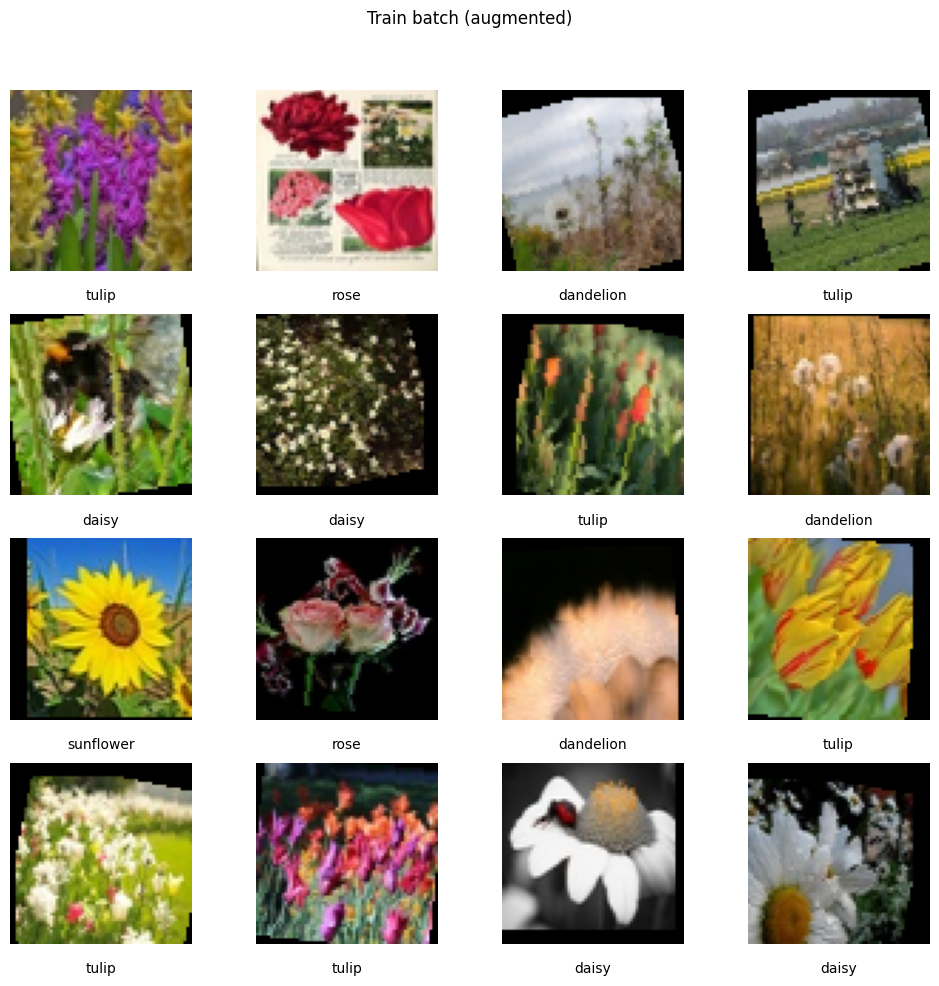

In [12]:
batch = next(iter(train_loader))
visualize_batch(batch, class_names=classe_names, title="Train batch (augmented)")

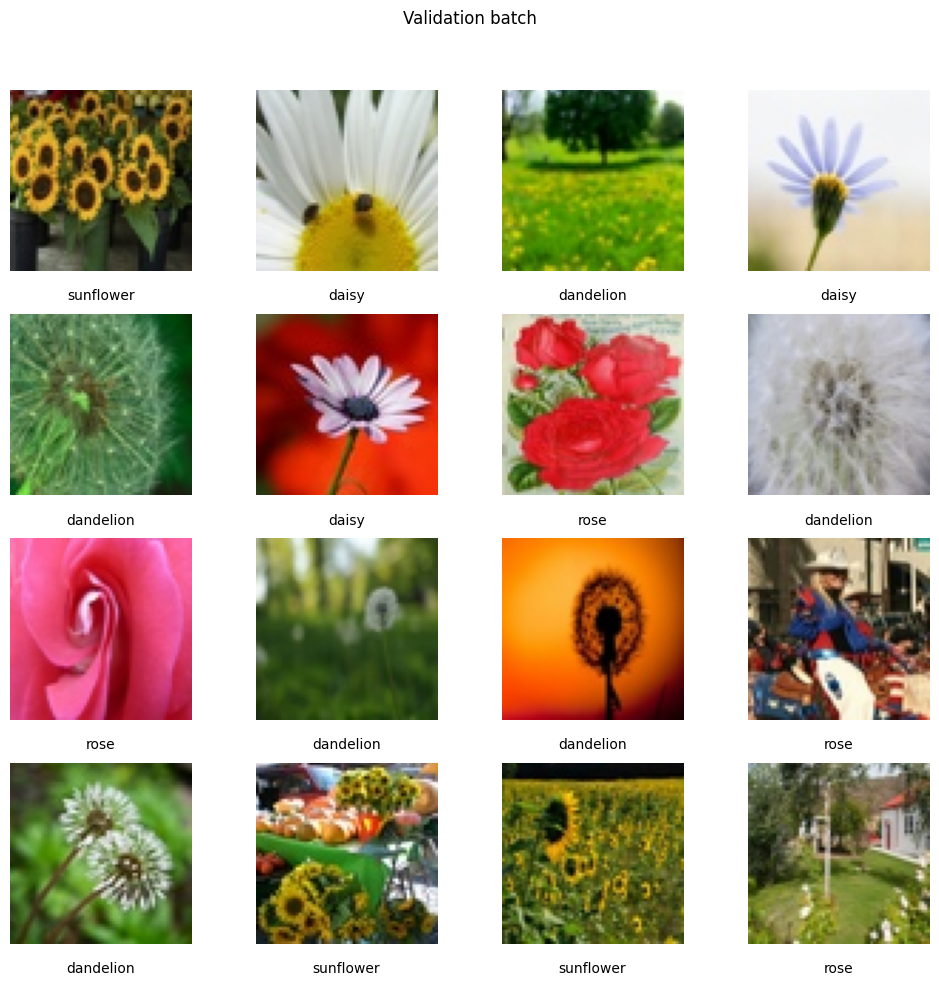

In [13]:
batch = next(iter(val_loader))
visualize_batch(batch, class_names=classe_names, title="Validation batch")

## Model Definition and Training Check

In [14]:
from model_utils import (
    SimpleCNN,
    TrainConfig,
    train,
    evaluate,
    plot_history,
    load_model,
    predict,
    predict_image,
    set_seed,
)

In [16]:
# Set seed for reproducibility
set_seed(42)

In [17]:
# model
model = SimpleCNN(num_classes=len(classe_names))

In [18]:
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (projection): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=T

In [19]:
print(f"Model size: {model.size:,} parameters")

Model size: 2,192,389 parameters


In [20]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [21]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.109375

In [22]:
# Check that the classifier / feature vector switch works as expected
model.eval()
with torch.no_grad():
    raw_output = model(images, return_embeddings=False)
    print(raw_output.shape)

torch.Size([64, 5])


In [24]:
# Training Configuration
best_metric = "val_f1"  # "val_acc" | "val_loss" | "val_f1"
cfg = TrainConfig(
    num_classes=len(classe_names),
    epochs=20,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    out_dir="runs/flowers_cnn",
    run_name=f"train_ratio_{TRAIN_RATIO}",
    metric_for_best=best_metric,
    maximize_metric=False if "loss" in best_metric else True,
)

In [25]:
# Train the model!
history = train(model, train_loader, val_loader, cfg)

Training epochs:   5%|▌         | 1/20 [00:16<05:11, 16.40s/it]

Epoch 001/20 | train_loss=107.9643 train_acc=0.297 train_f1=0.278 | val_loss=9.9001 val_acc=0.377 val_f1=0.333 | lr=1.00e-03


Training epochs:  10%|█         | 2/20 [00:32<04:54, 16.37s/it]

Epoch 002/20 | train_loss=17.4870 train_acc=0.405 train_f1=0.395 | val_loss=8.7022 val_acc=0.362 val_f1=0.330 | lr=1.00e-03


Training epochs:  15%|█▌        | 3/20 [00:49<04:40, 16.51s/it]

Epoch 003/20 | train_loss=7.0894 train_acc=0.418 train_f1=0.402 | val_loss=3.2156 val_acc=0.359 val_f1=0.340 | lr=1.00e-03


Training epochs:  20%|██        | 4/20 [01:07<04:34, 17.13s/it]

Epoch 004/20 | train_loss=2.6979 train_acc=0.372 train_f1=0.360 | val_loss=1.7427 val_acc=0.362 val_f1=0.359 | lr=1.00e-03


Training epochs:  25%|██▌       | 5/20 [01:23<04:11, 16.76s/it]

Epoch 005/20 | train_loss=1.5725 train_acc=0.370 train_f1=0.368 | val_loss=1.6872 val_acc=0.366 val_f1=0.345 | lr=1.00e-03


Training epochs:  30%|███       | 6/20 [01:40<03:57, 16.94s/it]

Epoch 006/20 | train_loss=1.4517 train_acc=0.381 train_f1=0.346 | val_loss=1.6144 val_acc=0.366 val_f1=0.325 | lr=1.00e-03


Training epochs:  35%|███▌      | 7/20 [01:59<03:48, 17.58s/it]

Epoch 007/20 | train_loss=1.4755 train_acc=0.372 train_f1=0.355 | val_loss=1.5768 val_acc=0.362 val_f1=0.342 | lr=1.00e-03


Training epochs:  40%|████      | 8/20 [02:15<03:25, 17.12s/it]

Epoch 008/20 | train_loss=1.4175 train_acc=0.385 train_f1=0.360 | val_loss=1.5922 val_acc=0.384 val_f1=0.365 | lr=1.00e-03


Training epochs:  45%|████▌     | 9/20 [02:32<03:07, 17.02s/it]

Epoch 009/20 | train_loss=1.4177 train_acc=0.407 train_f1=0.395 | val_loss=1.6240 val_acc=0.420 val_f1=0.412 | lr=1.00e-03


Training epochs:  50%|█████     | 10/20 [02:59<03:20, 20.06s/it]

Epoch 010/20 | train_loss=1.3338 train_acc=0.434 train_f1=0.436 | val_loss=1.6520 val_acc=0.424 val_f1=0.421 | lr=1.00e-03


Training epochs:  55%|█████▌    | 11/20 [03:17<02:53, 19.26s/it]

Epoch 011/20 | train_loss=1.3363 train_acc=0.458 train_f1=0.459 | val_loss=1.6856 val_acc=0.420 val_f1=0.415 | lr=1.00e-03


Training epochs:  60%|██████    | 12/20 [03:37<02:36, 19.60s/it]

Epoch 012/20 | train_loss=1.3178 train_acc=0.445 train_f1=0.458 | val_loss=1.6153 val_acc=0.446 val_f1=0.448 | lr=1.00e-03


Training epochs:  65%|██████▌   | 13/20 [03:57<02:18, 19.72s/it]

Epoch 013/20 | train_loss=1.3423 train_acc=0.432 train_f1=0.443 | val_loss=1.6590 val_acc=0.489 val_f1=0.491 | lr=1.00e-03


Training epochs:  70%|███████   | 14/20 [04:16<01:57, 19.63s/it]

Epoch 014/20 | train_loss=1.3345 train_acc=0.456 train_f1=0.451 | val_loss=1.6825 val_acc=0.482 val_f1=0.481 | lr=1.00e-03


Training epochs:  75%|███████▌  | 15/20 [04:34<01:35, 19.15s/it]

Epoch 015/20 | train_loss=1.3098 train_acc=0.456 train_f1=0.447 | val_loss=1.5756 val_acc=0.457 val_f1=0.453 | lr=1.00e-03


Training epochs:  80%|████████  | 16/20 [04:51<01:14, 18.51s/it]

Epoch 016/20 | train_loss=1.3245 train_acc=0.451 train_f1=0.447 | val_loss=1.5987 val_acc=0.457 val_f1=0.452 | lr=1.00e-03


Training epochs:  85%|████████▌ | 17/20 [05:09<00:55, 18.33s/it]

Epoch 017/20 | train_loss=1.3197 train_acc=0.454 train_f1=0.445 | val_loss=1.5940 val_acc=0.482 val_f1=0.483 | lr=1.00e-03


Training epochs:  90%|█████████ | 18/20 [05:26<00:35, 17.96s/it]

Epoch 018/20 | train_loss=1.3339 train_acc=0.438 train_f1=0.425 | val_loss=1.5726 val_acc=0.457 val_f1=0.449 | lr=1.00e-03


Training epochs:  95%|█████████▌| 19/20 [05:45<00:18, 18.13s/it]

Epoch 019/20 | train_loss=1.2532 train_acc=0.465 train_f1=0.452 | val_loss=1.5726 val_acc=0.467 val_f1=0.459 | lr=1.00e-03


Training epochs: 100%|██████████| 20/20 [06:03<00:00, 18.18s/it]

Epoch 020/20 | train_loss=1.3230 train_acc=0.473 train_f1=0.463 | val_loss=1.5445 val_acc=0.471 val_f1=0.472 | lr=1.00e-03


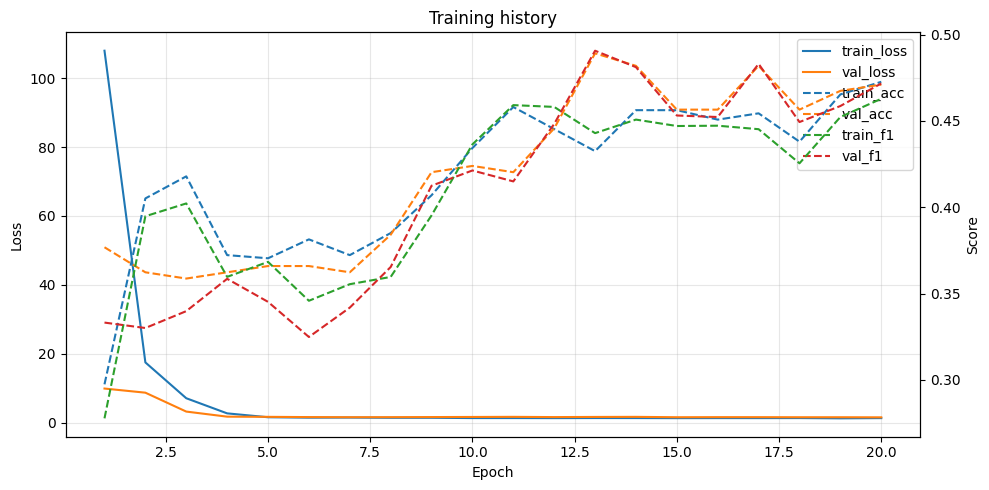

In [26]:
# Plot learning curves
plot_history(history)

In [31]:
# Evaluate best checkpoint
device = torch.device(cfg.device)
ckpt = load_model(Path(cfg.out_dir) / cfg.run_name / "best.pt", model, map_location=cfg.device)
test_metrics = evaluate(model.to(device), test_loader, device, num_classes=len(classe_names))

In [32]:
print(test_metrics)

{'test_loss': 1.6271411387816719, 'test_acc': 0.5181159420289855, 'test_f1': 0.5104970324625108}


In [33]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [34]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.484375

## Active Learning: Single Query

In [35]:
import numpy as np

from active_ml_utils import (
    TorchClassifierWrapper,
    compute_next_candidates,
    transfer_candidates_idx,
    SearchStrategy,
)

In [36]:
wrapper = TorchClassifierWrapper(
    model=model,
    pool_ds=pool_ds,
    batch_size=16,  # small for demo
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

In [37]:
X_small = np.array([[0], [3], [7], [10], [25]])
X_empty = np.empty((0,0))

In [38]:
X_small.shape

(5, 1)

In [39]:
X_empty.shape

(0, 0)

In [40]:
probs = wrapper.predict_proba(X_empty)
feats = wrapper.compute_embeddings(X_empty)

In [41]:
probs = wrapper.predict_proba(X_small)
feats = wrapper.compute_embeddings(X_small)

predict_proba: 100%|██████████| 1/1 [00:00<00:00, 48.15it/s]


In [44]:
print("Shape:", probs.shape)
print("First row probs:", probs[0])
print("First row feats:", feats[0])

Shape: (5, 5)
First row probs: [5.8105792e-04 5.7648411e-03 1.3047220e-07 9.9365401e-01 1.2119942e-11]
First row feats: [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        6.721676
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0

In [45]:
probs, feats = wrapper.predict_proba(X_small, return_embeddings=True)

predict_proba: 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]


In [47]:
print("Shape:", probs.shape)
print("First row probs:", probs[0])
print("First row feats:", feats[0])

Shape: (5, 5)
First row probs: [5.8105792e-04 5.7648411e-03 1.3047220e-07 9.9365401e-01 1.2119942e-11]
First row feats: [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        6.721676
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0

In [48]:
len(pool_ds)

1646

In [49]:
candidates_local_idx = compute_next_candidates(
    model=model,
    pool_ds=pool_ds,
    query_size=32,
    method="badge",  # "random", "least_confident", "margin_sampling", "entropy", "badge"
    seed=42,
    batch_size=16,
    device="cpu",
    num_workers=0,
    pin_memory=False,
    verbose=True,
)

predict_proba: 100%|██████████| 103/103 [00:05<00:00, 20.06it/s]


In [50]:
candidates_local_idx

[394,
 1039,
 772,
 471,
 134,
 77,
 343,
 1525,
 121,
 261,
 48,
 708,
 915,
 853,
 939,
 507,
 1036,
 1115,
 124,
 1048,
 1326,
 136,
 1327,
 1124,
 1442,
 1556,
 1339,
 1444,
 1004,
 79,
 313,
 399]

In [51]:
train_new_idx, pool_new_idx, candidates_global_idx = transfer_candidates_idx(
    train_idx=train_idx,
    pool_idx=pool_idx,
    candidates_idx=candidates_local_idx,
)

In [52]:
candidates_global_idx

[2383,
 1773,
 2351,
 301,
 1574,
 493,
 40,
 2296,
 2429,
 2259,
 2346,
 2476,
 1391,
 1068,
 2595,
 452,
 2329,
 1711,
 1606,
 2438,
 920,
 1210,
 2151,
 1006,
 1565,
 501,
 2717,
 983,
 2661,
 889,
 1154,
 1335]

In [53]:
print(f"len(train_idx): {len(train_idx)}")
print(f"len(train_new_idx): {len(train_new_idx)}")

len(train_idx): 548
len(train_new_idx): 580


## Active Learning: Experiments to Compare Strategies

In [54]:
import time
from typing import Optional
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import CustomDataset
from model_utils import SimpleCNN, TrainConfig, train, evaluate, load_model
from torch.utils.data import DataLoader

In [77]:
def evaluate_active_learning(
    # Data components
    paths: list,
    labels: list,
    classe_names: list,
    initial_train_idx: list[int],
    val_idx: list[int],
    test_idx: list[int],
    initial_pool_idx: list[int],
    train_transform,
    eval_transform,
    
    # Active learning parameters
    extension_ratio: float = 0.05,
    method: SearchStrategy = "badge",
    max_iterations: Optional[int] = None,
    
    # Training parameters
    epochs: int = 20,
    lr: float = 1e-3,
    batch_size: int = 64,
    
    # Model saving
    artifacts_dir: str = "runs/active_learning",
    run_name_slug: str = "exp",
    
    # Output
    output_csv: str = "active_learning_experiments.csv",
    
    # Runtime
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    num_workers: int = 0,
    pin_memory: bool = False,
    seed: int = 42,
    verbose: bool = True,
) -> dict:
    """
    Evaluate active learning by iteratively adding samples to the training set.
    
    Args:
        paths: List of all image paths
        labels: List of all labels (same length as paths)
        classe_names: List of class names
        initial_train_idx: Initial training set indices (global)
        val_idx: Validation set indices (global, remains fixed)
        test_idx: Test set indices (global, remains fixed)
        initial_pool_idx: Initial pool indices (global, decreases each iteration)
        train_transform: Transform for training data
        eval_transform: Transform for evaluation data
        extension_ratio: Fraction of pool to query each iteration (converted to query_size)
        method: Active learning strategy
        max_iterations: Maximum number of iterations (None = until pool is empty)
        epochs: Number of training epochs per iteration
        lr: Learning rate
        batch_size: Batch size for training
        artifacts_dir: Directory to save model checkpoints
        run_name_slug: Base name for run (will be modified with iteration info)
        output_csv: Path to output CSV file
        device: Device to train on
        num_workers: Number of workers for data loading
        pin_memory: Whether to pin memory for faster GPU transfer
        seed: Random seed
        verbose: Whether to print progress
        
    Returns:
        Dictionary with final statistics and history as pandas DataFrame
    """
    # Initialize output directory and CSV path
    artifacts_dir = Path(artifacts_dir)
    artifacts_dir.mkdir(parents=True, exist_ok=True)
    csv_path = artifacts_dir / Path(output_csv)
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Set seed for reproducibility
    set_seed(seed)
    
    # Helper function to create dataloaders
    def _make_loader(ds, batch_size=16, shuffle=False):
        return DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=pin_memory,
            drop_last=False,
        )
    
    # Initialize indices (make copies to avoid modifying original)
    train_idx = list(initial_train_idx)
    pool_idx = list(initial_pool_idx)
    
    # Calculate total samples
    total_samples = len(paths)
    
    # History tracking with DataFrame
    results_list = []
    iteration = 0
    
    if verbose:
        print(f"Starting active learning evaluation")
        print(f"Method: {method}")
        print(f"Extension ratio: {extension_ratio}")
        print(f"Initial train size: {len(train_idx)}")
        print(f"Val size: {len(val_idx)}")
        print(f"Test size: {len(test_idx)}")
        print(f"Initial pool size: {len(pool_idx)}")
        print(f"Output CSV: {output_csv}")
        print("=" * 80)
    
    while len(pool_idx) > 0:
        if max_iterations is not None and iteration >= max_iterations:
            if verbose:
                print(f"Reached maximum iterations: {max_iterations}")
            break
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"Iteration {iteration}")
            print(f"Train size: {len(train_idx)}, Pool size: {len(pool_idx)}")
        
        # Calculate current train ratio (rounded to 2 decimals)
        current_train_ratio = round(len(train_idx) / total_samples, 2)

        # Create datasets
        train_ds = CustomDataset(paths, labels, train_idx, transform=train_transform)
        val_ds = CustomDataset(paths, labels, val_idx, transform=eval_transform)
        test_ds = CustomDataset(paths, labels, test_idx, transform=eval_transform)
        pool_ds = CustomDataset(paths, labels, pool_idx, transform=eval_transform)
        
        # Create dataloaders
        train_loader = _make_loader(train_ds, batch_size=batch_size, shuffle=False)
        val_loader = _make_loader(val_ds, batch_size=batch_size, shuffle=False)
        test_loader = _make_loader(test_ds, batch_size=batch_size, shuffle=False)
        
        # Initialize fresh model
        model = SimpleCNN(num_classes=len(classe_names))
        
        # Training configuration
        # method, iteration, train ratio in name for better tracking (2 decimal precision)
        run_name = f"{run_name_slug}_{method}_iteration_{iteration:03d}_train_ratio_{current_train_ratio:.2f}"
        cfg = TrainConfig(
            num_classes=len(classe_names),
            epochs=epochs,
            lr=lr,
            batch_size=batch_size,
            out_dir=artifacts_dir.as_posix(),
            run_name=run_name,
            metric_for_best="val_f1",
            maximize_metric=True,
            device=device,
            num_workers=num_workers,
            pin_memory=pin_memory,
            seed=seed,
            #seed=seed + iteration,  # Different seed per iteration
        )
        
        # Train the model
        if verbose:
            print(f"Training model for iteration {iteration}...")
        start_time = time.time()
        train_history = train(model, train_loader, val_loader, cfg)
        train_time = time.time() - start_time
        
        # Load best checkpoint and evaluate on test set
        best_ckpt_path = Path(cfg.out_dir) / cfg.run_name / "best.pt"
        ckpt = load_model(best_ckpt_path, model, map_location=cfg.device)
        model = model.to(torch.device(cfg.device))
        
        test_metrics = evaluate(model, test_loader, torch.device(cfg.device), num_classes=len(classe_names))
        
        # Get best epoch metrics from history
        best_epoch_idx = -1
        best_metric_value = ckpt.get("best_metric", None)
        
        # Find the best epoch in history
        for i, epoch_metrics in enumerate(train_history):
            if epoch_metrics.get(cfg.metric_for_best) == best_metric_value:
                best_epoch_idx = i
                break
        
        if best_epoch_idx == -1:
            best_epoch_idx = -1  # Use last epoch
        
        best_epoch_metrics = train_history[best_epoch_idx]
        
        # Prepare row data
        row_data = {
            "iteration": iteration,
            "method": method,
            "train_ratio": current_train_ratio,
            "extension_ratio": 0.0 if iteration == 0 else round(extension_ratio, 2),
            "train_size": len(train_idx),
            "val_size": len(val_idx),
            "test_size": len(test_idx),
            "pool_size": len(pool_idx),
            "query_size": 0,  # Will be updated after querying (0 for first iteration)
            "epochs": epochs,
            "lr": lr,
            "batch_size": batch_size,
            "train_time_sec": train_time,
            "train_loss": best_epoch_metrics["train_loss"],
            "train_acc": best_epoch_metrics["train_acc"],
            "train_f1": best_epoch_metrics["train_f1"],
            "val_loss": best_epoch_metrics["val_loss"],
            "val_acc": best_epoch_metrics["val_acc"],
            "val_f1": best_epoch_metrics["val_f1"],
            "test_loss": test_metrics["test_loss"],
            "test_acc": test_metrics["test_acc"],
            "test_f1": test_metrics["test_f1"],
            "best_metric": best_metric_value,
            "run_name": run_name,
        }
        
        if verbose:
            print(f"Results - Val F1: {best_epoch_metrics['val_f1']:.4f}, Test F1: {test_metrics['test_f1']:.4f}")
            print(f"Training time: {train_time:.2f}s")
        
        # Active learning: query next candidates
        # Query happens AFTER each iteration (including iteration 0)
        if len(pool_idx) > 0:
            query_size = max(1, int(total_samples * extension_ratio))
            
            if verbose:
                print(f"Querying {query_size} samples using {method}...")
            
            candidates_local_idx = compute_next_candidates(
                model=model,
                pool_ds=pool_ds,
                query_size=query_size,
                method=method,
                seed=seed,
                batch_size=batch_size,
                device=device,
                num_workers=num_workers,
                pin_memory=pin_memory,
                verbose=verbose,
            )
            
            # Transfer candidates
            train_idx, pool_idx, candidates_global_idx = transfer_candidates_idx(
                train_idx=train_idx,
                pool_idx=pool_idx,
                candidates_idx=candidates_local_idx,
            )
            
            row_data["query_size"] = len(candidates_global_idx)
            
            if verbose:
                print(f"Added {len(candidates_global_idx)} samples to training set")
        elif iteration == 0:
            # First iteration: no querying yet, just evaluate baseline
            if verbose:
                print(f"Baseline iteration - no querying performed")
        
        # Add to results list
        results_list.append(row_data)
        
        # Convert to DataFrame and save to CSV
        new_row_df = pd.DataFrame([row_data])
        
        if csv_path.exists():
            # Load existing CSV and append new row
            existing_df = pd.read_csv(csv_path)
            df = pd.concat([existing_df, new_row_df], ignore_index=True)
        else:
            # First iteration - create new DataFrame
            df = new_row_df
        
        df.to_csv(csv_path, index=False)
        
        if verbose:
            print(f"CSV updated: {csv_path}")
        
        # Cleanup model to free memory and avoid re-using weights
        del model
        
        # Increase iteration counter
        iteration += 1
    
    # Final DataFrame
    #results_df = pd.DataFrame(results_list)
    results_df = pd.read_csv(csv_path)
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"Active learning evaluation completed!")
        print(f"Total iterations: {iteration}")
        print(f"Final train size: {len(train_idx)}")
        print(f"Final pool size: {len(pool_idx)}")
        print(f"Results saved to: {csv_path}")
        print(f"\nFinal results summary:")
        print(results_df[['iteration', 'train_size', 'train_ratio', 'val_f1', 'test_f1']].to_string(index=False))
    
    return {
        "history_df": results_df,
        "final_train_idx": train_idx,
        "final_pool_idx": pool_idx,
        "num_iterations": iteration,
        "csv_path": str(csv_path),
    }

In [78]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.2, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [ ]:
method = "random"  # "random", "least_confident", "margin_sampling", "entropy", "badge"
results = evaluate_active_learning(
    # Data components
    paths=paths,
    labels=labels,
    classe_names=classe_names,
    initial_train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    initial_pool_idx=pool_idx,
    train_transform=train_transform,
    eval_transform=eval_transform,
    
    # Active learning parameters
    extension_ratio=0.05,
    method=method,  # "random", "least_confident", "margin_sampling", "entropy", "badge"
    max_iterations=3,  # Set to None to run until pool is empty
    
    # Training parameters
    epochs=3,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    
    # Model saving
    artifacts_dir="runs/active_learning_experiments",
    run_name_slug="flowers",
    
    # Output
    output_csv=f"active_learning_{method}_experiments.csv",
    
    # Runtime
    device="cuda" if torch.cuda.is_available() else "cpu",
    num_workers=0,
    pin_memory=False,
    seed=42,
    verbose=True,
)

In [81]:
def run_multiple_experiments(
    paths,
    labels,
    classe_names,
    initial_train_idx,
    val_idx,
    test_idx,
    initial_pool_idx,
    train_transform,
    eval_transform,
    methods: list[SearchStrategy] = ["random", "least_confident", "margin_sampling", "entropy", "badge"],
    extension_ratio: float = 0.05,
    artifacts_dir: str = "runs/active_learning_experiments",
    **kwargs
) -> dict:
    """
    Run active learning experiments with multiple methods.
    
    Each method will have its own CSV file and all results are combined
    into a single CSV for comparison.
    
    Args:
        paths: List of all image paths
        labels: List of all labels
        classe_names: List of class names
        initial_train_idx: Initial training set indices
        val_idx: Validation set indices
        test_idx: Test set indices
        initial_pool_idx: Initial pool indices
        train_transform: Transform for training data
        eval_transform: Transform for evaluation data
        methods: List of active learning methods to compare
        extension_ratio: Fraction of pool to query each iteration
        artifacts_dir: Directory to save all results (models + CSVs)
        **kwargs: Additional arguments passed to evaluate_active_learning
        
    Returns:
        Dictionary with results for each method and combined DataFrame
    """
    all_results = {}
    all_dfs = []
    
    artifacts_path = Path(artifacts_dir)
    artifacts_path.mkdir(parents=True, exist_ok=True)
    
    for method in methods:
        print(f"\n{'#'*80}")
        print(f"# Running experiment with method: {method}")
        print(f"{'#'*80}\n")
        
        # CSV filename
        output_csv = f"active_learning_{method}_experiments.csv"

        results = evaluate_active_learning(
            paths=paths,
            labels=labels,
            classe_names=classe_names,
            initial_train_idx=initial_train_idx,
            val_idx=val_idx,
            test_idx=test_idx,
            initial_pool_idx=initial_pool_idx,
            train_transform=train_transform,
            eval_transform=eval_transform,
            extension_ratio=extension_ratio,
            method=method,
            output_csv=output_csv,
            artifacts_dir=artifacts_dir,
            **kwargs
        )
        
        all_results[method] = results
        all_dfs.append(results["history_df"])
    
    # Combine all results into a single DataFrame
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_csv = artifacts_path / "active_learning_all_experiments.csv"
    combined_df.to_csv(combined_csv, index=False)
    
    print(f"\n{'='*80}")
    print(f"All experiments completed!")
    print(f"Combined results saved to: {combined_csv}")
    
    return {
        "results_by_method": all_results,
        "combined_df": combined_df,
        "combined_csv": str(combined_csv),
    }

In [82]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.05, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [83]:
print(f"Initial Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")
print(f"Pool size: {len(pool_idx)}")

Initial Train size: 137
Val size: 276
Test size: 276
Pool size: 2057


In [84]:
# Run experiments with all 5 methods
all_results = run_multiple_experiments(
    # Required data arguments
    paths=paths,
    labels=labels,
    classe_names=classe_names,
    initial_train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    initial_pool_idx=pool_idx,
    train_transform=train_transform,
    eval_transform=eval_transform,
    
    # Active learning parameters
    methods=["random", "least_confident", "margin_sampling", "entropy", "badge"],
    extension_ratio=0.03,
    
    # Additional arguments passed via kwargs to evaluate_active_learning
    max_iterations=20,  # None: Run until pool is empty (or set a number like 10)
    epochs=30,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    artifacts_dir="runs/active_learning_experiments_4",
    run_name_slug="flowers",
    device="cuda" if torch.cuda.is_available() else "cpu",
    num_workers=0,
    pin_memory=False,
    seed=42,
    verbose=True,
)

# Access results
print(f"\nAll experiments completed!")
print(f"Combined results: {all_results['combined_csv']}")

# View combined DataFrame
combined_df = all_results['combined_df']
print("\nFirst few rows:")
print(combined_df.head(10))

# Access individual method results
for method, result in all_results['results_by_method'].items():
    print(f"\n{method}: {result['num_iterations']} iterations")
    print(f"  CSV: {result['csv_path']}")


################################################################################
# Running experiment with method: random
################################################################################

Starting active learning evaluation
Method: random
Extension ratio: 0.03
Initial train size: 137
Val size: 276
Test size: 276
Initial pool size: 2057
Output CSV: active_learning_random_experiments.csv

Iteration 0
Train size: 137, Pool size: 2057
Training model for iteration 0...


Training epochs:   3%|▎         | 1/30 [00:01<00:57,  1.99s/it]

Epoch 001/30 | train_loss=4.2938 train_acc=0.234 train_f1=0.217 | val_loss=1.7137 val_acc=0.188 val_f1=0.076 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<00:59,  2.13s/it]

Epoch 002/30 | train_loss=3.7406 train_acc=0.263 train_f1=0.205 | val_loss=1.6114 val_acc=0.344 val_f1=0.278 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:05<00:52,  1.96s/it]

Epoch 003/30 | train_loss=1.6427 train_acc=0.431 train_f1=0.423 | val_loss=1.5131 val_acc=0.420 val_f1=0.363 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:07<00:49,  1.90s/it]

Epoch 004/30 | train_loss=1.8354 train_acc=0.438 train_f1=0.378 | val_loss=1.4907 val_acc=0.446 val_f1=0.397 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:09<00:45,  1.83s/it]

Epoch 005/30 | train_loss=1.4789 train_acc=0.496 train_f1=0.465 | val_loss=1.5673 val_acc=0.428 val_f1=0.412 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:10<00:41,  1.72s/it]

Epoch 006/30 | train_loss=1.2085 train_acc=0.540 train_f1=0.535 | val_loss=1.5852 val_acc=0.478 val_f1=0.456 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:12<00:38,  1.65s/it]

Epoch 007/30 | train_loss=1.0660 train_acc=0.555 train_f1=0.552 | val_loss=1.6001 val_acc=0.460 val_f1=0.449 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:14<00:36,  1.65s/it]

Epoch 008/30 | train_loss=1.0488 train_acc=0.547 train_f1=0.553 | val_loss=1.5629 val_acc=0.486 val_f1=0.470 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:15<00:33,  1.61s/it]

Epoch 009/30 | train_loss=0.9700 train_acc=0.584 train_f1=0.581 | val_loss=1.6316 val_acc=0.475 val_f1=0.460 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:17<00:31,  1.57s/it]

Epoch 010/30 | train_loss=0.9741 train_acc=0.599 train_f1=0.605 | val_loss=1.6069 val_acc=0.475 val_f1=0.463 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:18<00:31,  1.63s/it]

Epoch 011/30 | train_loss=0.8932 train_acc=0.657 train_f1=0.655 | val_loss=1.4755 val_acc=0.471 val_f1=0.464 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:20<00:30,  1.68s/it]

Epoch 012/30 | train_loss=0.8273 train_acc=0.679 train_f1=0.675 | val_loss=1.3957 val_acc=0.504 val_f1=0.500 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:22<00:29,  1.75s/it]

Epoch 013/30 | train_loss=0.7550 train_acc=0.708 train_f1=0.708 | val_loss=1.4037 val_acc=0.514 val_f1=0.513 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:24<00:30,  1.89s/it]

Epoch 014/30 | train_loss=0.7833 train_acc=0.701 train_f1=0.701 | val_loss=1.4663 val_acc=0.489 val_f1=0.486 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:26<00:27,  1.86s/it]

Epoch 015/30 | train_loss=0.7320 train_acc=0.730 train_f1=0.729 | val_loss=1.5338 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:28<00:24,  1.78s/it]

Epoch 016/30 | train_loss=0.7660 train_acc=0.686 train_f1=0.684 | val_loss=1.4466 val_acc=0.500 val_f1=0.496 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:29<00:22,  1.71s/it]

Epoch 017/30 | train_loss=0.7355 train_acc=0.737 train_f1=0.736 | val_loss=1.3940 val_acc=0.493 val_f1=0.492 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:31<00:20,  1.75s/it]

Epoch 018/30 | train_loss=0.6610 train_acc=0.774 train_f1=0.772 | val_loss=1.3840 val_acc=0.504 val_f1=0.503 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:33<00:18,  1.72s/it]

Epoch 019/30 | train_loss=0.6066 train_acc=0.730 train_f1=0.729 | val_loss=1.4024 val_acc=0.489 val_f1=0.488 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:34<00:16,  1.66s/it]

Epoch 020/30 | train_loss=0.6182 train_acc=0.737 train_f1=0.736 | val_loss=1.4267 val_acc=0.511 val_f1=0.508 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:36<00:15,  1.68s/it]

Epoch 021/30 | train_loss=0.5636 train_acc=0.803 train_f1=0.802 | val_loss=1.4190 val_acc=0.514 val_f1=0.512 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:37<00:12,  1.62s/it]

Epoch 022/30 | train_loss=0.5161 train_acc=0.788 train_f1=0.787 | val_loss=1.4307 val_acc=0.522 val_f1=0.520 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:39<00:11,  1.58s/it]

Epoch 023/30 | train_loss=0.5305 train_acc=0.796 train_f1=0.794 | val_loss=1.5121 val_acc=0.518 val_f1=0.518 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:40<00:09,  1.54s/it]

Epoch 024/30 | train_loss=0.5214 train_acc=0.781 train_f1=0.778 | val_loss=1.5403 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:42<00:07,  1.57s/it]

Epoch 025/30 | train_loss=0.5218 train_acc=0.810 train_f1=0.808 | val_loss=1.4599 val_acc=0.522 val_f1=0.524 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:44<00:06,  1.55s/it]

Epoch 026/30 | train_loss=0.4599 train_acc=0.810 train_f1=0.810 | val_loss=1.4256 val_acc=0.540 val_f1=0.541 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:45<00:04,  1.55s/it]

Epoch 027/30 | train_loss=0.5035 train_acc=0.781 train_f1=0.777 | val_loss=1.4587 val_acc=0.507 val_f1=0.505 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:47<00:03,  1.54s/it]

Epoch 028/30 | train_loss=0.4758 train_acc=0.803 train_f1=0.803 | val_loss=1.5299 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:48<00:01,  1.54s/it]

Epoch 029/30 | train_loss=0.5050 train_acc=0.781 train_f1=0.780 | val_loss=1.4475 val_acc=0.507 val_f1=0.507 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [00:50<00:00,  1.67s/it]


Epoch 030/30 | train_loss=0.3813 train_acc=0.861 train_f1=0.864 | val_loss=1.4528 val_acc=0.504 val_f1=0.505 | lr=1.00e-03


Results - Val F1: 0.5413, Test F1: 0.5271
Training time: 50.19s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 1
Train size: 219, Pool size: 1975
Training model for iteration 1...


Training epochs:   3%|▎         | 1/30 [00:02<01:01,  2.13s/it]

Epoch 001/30 | train_loss=5.0633 train_acc=0.228 train_f1=0.224 | val_loss=1.8203 val_acc=0.279 val_f1=0.158 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<00:58,  2.10s/it]

Epoch 002/30 | train_loss=3.9624 train_acc=0.251 train_f1=0.198 | val_loss=1.9353 val_acc=0.279 val_f1=0.197 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:06<00:56,  2.08s/it]

Epoch 003/30 | train_loss=2.0824 train_acc=0.292 train_f1=0.259 | val_loss=1.5122 val_acc=0.315 val_f1=0.233 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:08<00:57,  2.23s/it]

Epoch 004/30 | train_loss=1.5042 train_acc=0.352 train_f1=0.288 | val_loss=1.5129 val_acc=0.301 val_f1=0.240 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:10<00:54,  2.19s/it]

Epoch 005/30 | train_loss=1.4650 train_acc=0.384 train_f1=0.304 | val_loss=1.4940 val_acc=0.351 val_f1=0.313 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:12<00:51,  2.14s/it]

Epoch 006/30 | train_loss=1.4131 train_acc=0.411 train_f1=0.372 | val_loss=1.5088 val_acc=0.391 val_f1=0.338 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:14<00:48,  2.11s/it]

Epoch 007/30 | train_loss=1.3265 train_acc=0.461 train_f1=0.422 | val_loss=1.4260 val_acc=0.409 val_f1=0.351 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:16<00:45,  2.05s/it]

Epoch 008/30 | train_loss=1.2734 train_acc=0.484 train_f1=0.441 | val_loss=1.3568 val_acc=0.431 val_f1=0.393 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:19<00:43,  2.09s/it]

Epoch 009/30 | train_loss=1.2426 train_acc=0.489 train_f1=0.468 | val_loss=1.3132 val_acc=0.460 val_f1=0.437 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:20<00:40,  2.04s/it]

Epoch 010/30 | train_loss=1.1860 train_acc=0.502 train_f1=0.486 | val_loss=1.3078 val_acc=0.475 val_f1=0.455 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:22<00:38,  2.02s/it]

Epoch 011/30 | train_loss=1.1484 train_acc=0.516 train_f1=0.509 | val_loss=1.3096 val_acc=0.478 val_f1=0.463 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:24<00:36,  2.03s/it]

Epoch 012/30 | train_loss=1.1710 train_acc=0.502 train_f1=0.486 | val_loss=1.2863 val_acc=0.475 val_f1=0.451 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:27<00:35,  2.06s/it]

Epoch 013/30 | train_loss=1.0337 train_acc=0.562 train_f1=0.549 | val_loss=1.2567 val_acc=0.482 val_f1=0.456 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:29<00:35,  2.19s/it]

Epoch 014/30 | train_loss=1.0316 train_acc=0.584 train_f1=0.570 | val_loss=1.2315 val_acc=0.482 val_f1=0.470 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:31<00:32,  2.15s/it]

Epoch 015/30 | train_loss=1.0011 train_acc=0.562 train_f1=0.557 | val_loss=1.2008 val_acc=0.496 val_f1=0.492 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:33<00:29,  2.11s/it]

Epoch 016/30 | train_loss=1.0176 train_acc=0.548 train_f1=0.549 | val_loss=1.1988 val_acc=0.511 val_f1=0.505 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:35<00:27,  2.09s/it]

Epoch 017/30 | train_loss=1.0231 train_acc=0.553 train_f1=0.546 | val_loss=1.2365 val_acc=0.500 val_f1=0.486 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:37<00:24,  2.05s/it]

Epoch 018/30 | train_loss=0.9331 train_acc=0.626 train_f1=0.619 | val_loss=1.2330 val_acc=0.496 val_f1=0.485 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:39<00:22,  2.04s/it]

Epoch 019/30 | train_loss=0.8937 train_acc=0.612 train_f1=0.611 | val_loss=1.2031 val_acc=0.504 val_f1=0.495 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:41<00:20,  2.06s/it]

Epoch 020/30 | train_loss=0.8777 train_acc=0.671 train_f1=0.671 | val_loss=1.2287 val_acc=0.496 val_f1=0.479 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:43<00:18,  2.00s/it]

Epoch 021/30 | train_loss=0.8324 train_acc=0.658 train_f1=0.655 | val_loss=1.2837 val_acc=0.482 val_f1=0.462 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:45<00:15,  1.95s/it]

Epoch 022/30 | train_loss=0.8733 train_acc=0.658 train_f1=0.655 | val_loss=1.2372 val_acc=0.493 val_f1=0.481 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:47<00:13,  1.96s/it]

Epoch 023/30 | train_loss=0.8528 train_acc=0.616 train_f1=0.613 | val_loss=1.2177 val_acc=0.493 val_f1=0.485 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:49<00:12,  2.06s/it]

Epoch 024/30 | train_loss=0.8158 train_acc=0.667 train_f1=0.663 | val_loss=1.2830 val_acc=0.493 val_f1=0.474 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:52<00:10,  2.11s/it]

Epoch 025/30 | train_loss=0.8413 train_acc=0.658 train_f1=0.657 | val_loss=1.2764 val_acc=0.504 val_f1=0.490 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:53<00:08,  2.06s/it]

Epoch 026/30 | train_loss=0.8124 train_acc=0.694 train_f1=0.697 | val_loss=1.2488 val_acc=0.500 val_f1=0.479 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:55<00:06,  2.00s/it]

Epoch 027/30 | train_loss=0.7509 train_acc=0.717 train_f1=0.715 | val_loss=1.2576 val_acc=0.486 val_f1=0.469 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:57<00:04,  2.03s/it]

Epoch 028/30 | train_loss=0.7367 train_acc=0.703 train_f1=0.705 | val_loss=1.2725 val_acc=0.478 val_f1=0.460 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:59<00:02,  2.00s/it]

Epoch 029/30 | train_loss=0.7706 train_acc=0.680 train_f1=0.681 | val_loss=1.2527 val_acc=0.507 val_f1=0.494 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:01<00:00,  2.06s/it]


Epoch 030/30 | train_loss=0.7349 train_acc=0.703 train_f1=0.704 | val_loss=1.3211 val_acc=0.507 val_f1=0.485 | lr=1.00e-03


Results - Val F1: 0.5045, Test F1: 0.5226
Training time: 61.91s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 2
Train size: 301, Pool size: 1893
Training model for iteration 2...


Training epochs:   3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Epoch 001/30 | train_loss=3.6735 train_acc=0.233 train_f1=0.224 | val_loss=1.6058 val_acc=0.344 val_f1=0.304 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:05<01:09,  2.49s/it]

Epoch 002/30 | train_loss=1.8415 train_acc=0.336 train_f1=0.316 | val_loss=1.3887 val_acc=0.446 val_f1=0.435 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:07<01:09,  2.59s/it]

Epoch 003/30 | train_loss=1.3078 train_acc=0.488 train_f1=0.492 | val_loss=1.4537 val_acc=0.417 val_f1=0.361 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:10<01:07,  2.58s/it]

Epoch 004/30 | train_loss=1.2036 train_acc=0.505 train_f1=0.456 | val_loss=1.2498 val_acc=0.493 val_f1=0.479 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:13<01:06,  2.66s/it]

Epoch 005/30 | train_loss=1.0822 train_acc=0.545 train_f1=0.531 | val_loss=1.1969 val_acc=0.514 val_f1=0.511 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:15<01:02,  2.60s/it]

Epoch 006/30 | train_loss=1.0282 train_acc=0.588 train_f1=0.585 | val_loss=1.2403 val_acc=0.496 val_f1=0.489 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:18<00:59,  2.57s/it]

Epoch 007/30 | train_loss=0.9645 train_acc=0.591 train_f1=0.585 | val_loss=1.2247 val_acc=0.522 val_f1=0.515 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:20<00:55,  2.51s/it]

Epoch 008/30 | train_loss=0.9584 train_acc=0.621 train_f1=0.619 | val_loss=1.1688 val_acc=0.543 val_f1=0.539 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:22<00:52,  2.48s/it]

Epoch 009/30 | train_loss=0.9149 train_acc=0.651 train_f1=0.651 | val_loss=1.1938 val_acc=0.529 val_f1=0.524 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:25<00:50,  2.52s/it]

Epoch 010/30 | train_loss=0.8507 train_acc=0.645 train_f1=0.639 | val_loss=1.1497 val_acc=0.569 val_f1=0.567 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:27<00:47,  2.48s/it]

Epoch 011/30 | train_loss=0.8287 train_acc=0.651 train_f1=0.650 | val_loss=1.1939 val_acc=0.540 val_f1=0.535 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:30<00:43,  2.42s/it]

Epoch 012/30 | train_loss=0.7871 train_acc=0.691 train_f1=0.687 | val_loss=1.1934 val_acc=0.518 val_f1=0.516 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:32<00:40,  2.40s/it]

Epoch 013/30 | train_loss=0.7153 train_acc=0.728 train_f1=0.725 | val_loss=1.1620 val_acc=0.565 val_f1=0.562 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:34<00:38,  2.42s/it]

Epoch 014/30 | train_loss=0.7270 train_acc=0.718 train_f1=0.718 | val_loss=1.1685 val_acc=0.551 val_f1=0.548 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:37<00:36,  2.41s/it]

Epoch 015/30 | train_loss=0.7209 train_acc=0.698 train_f1=0.698 | val_loss=1.1635 val_acc=0.565 val_f1=0.559 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:39<00:33,  2.42s/it]

Epoch 016/30 | train_loss=0.6712 train_acc=0.734 train_f1=0.735 | val_loss=1.1285 val_acc=0.580 val_f1=0.573 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:42<00:31,  2.42s/it]

Epoch 017/30 | train_loss=0.6586 train_acc=0.714 train_f1=0.713 | val_loss=1.1120 val_acc=0.587 val_f1=0.583 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:44<00:29,  2.44s/it]

Epoch 018/30 | train_loss=0.6121 train_acc=0.744 train_f1=0.743 | val_loss=1.0916 val_acc=0.572 val_f1=0.569 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:47<00:26,  2.40s/it]

Epoch 019/30 | train_loss=0.5840 train_acc=0.761 train_f1=0.760 | val_loss=1.1466 val_acc=0.587 val_f1=0.586 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:49<00:23,  2.39s/it]

Epoch 020/30 | train_loss=0.5532 train_acc=0.784 train_f1=0.780 | val_loss=1.1135 val_acc=0.587 val_f1=0.582 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:51<00:21,  2.44s/it]

Epoch 021/30 | train_loss=0.5377 train_acc=0.787 train_f1=0.786 | val_loss=1.1398 val_acc=0.587 val_f1=0.586 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:54<00:19,  2.39s/it]

Epoch 022/30 | train_loss=0.5379 train_acc=0.781 train_f1=0.777 | val_loss=1.1246 val_acc=0.627 val_f1=0.626 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:56<00:17,  2.43s/it]

Epoch 023/30 | train_loss=0.5254 train_acc=0.787 train_f1=0.786 | val_loss=1.2676 val_acc=0.594 val_f1=0.587 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:59<00:14,  2.42s/it]

Epoch 024/30 | train_loss=0.4492 train_acc=0.850 train_f1=0.851 | val_loss=1.2108 val_acc=0.616 val_f1=0.611 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:01<00:12,  2.41s/it]

Epoch 025/30 | train_loss=0.4556 train_acc=0.821 train_f1=0.819 | val_loss=1.1832 val_acc=0.591 val_f1=0.588 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:04<00:10,  2.53s/it]

Epoch 026/30 | train_loss=0.4547 train_acc=0.817 train_f1=0.818 | val_loss=1.1856 val_acc=0.612 val_f1=0.609 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:07<00:07,  2.61s/it]

Epoch 027/30 | train_loss=0.4475 train_acc=0.817 train_f1=0.815 | val_loss=1.2829 val_acc=0.609 val_f1=0.606 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:09<00:05,  2.59s/it]

Epoch 028/30 | train_loss=0.4822 train_acc=0.841 train_f1=0.842 | val_loss=1.2159 val_acc=0.587 val_f1=0.579 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:12<00:02,  2.62s/it]

Epoch 029/30 | train_loss=0.3980 train_acc=0.850 train_f1=0.851 | val_loss=1.2329 val_acc=0.580 val_f1=0.573 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:15<00:00,  2.50s/it]


Epoch 030/30 | train_loss=0.3964 train_acc=0.874 train_f1=0.871 | val_loss=1.2987 val_acc=0.591 val_f1=0.588 | lr=1.00e-03


Results - Val F1: 0.6262, Test F1: 0.5987
Training time: 75.14s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 3
Train size: 383, Pool size: 1811
Training model for iteration 3...


Training epochs:   3%|▎         | 1/30 [00:03<01:43,  3.55s/it]

Epoch 001/30 | train_loss=4.7134 train_acc=0.285 train_f1=0.258 | val_loss=1.8699 val_acc=0.362 val_f1=0.321 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:06<01:33,  3.34s/it]

Epoch 002/30 | train_loss=2.1107 train_acc=0.360 train_f1=0.347 | val_loss=1.4821 val_acc=0.315 val_f1=0.288 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:09<01:27,  3.24s/it]

Epoch 003/30 | train_loss=1.4267 train_acc=0.433 train_f1=0.360 | val_loss=1.2940 val_acc=0.460 val_f1=0.449 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:12<01:20,  3.10s/it]

Epoch 004/30 | train_loss=1.1617 train_acc=0.514 train_f1=0.490 | val_loss=1.3599 val_acc=0.467 val_f1=0.420 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:15<01:16,  3.06s/it]

Epoch 005/30 | train_loss=1.1047 train_acc=0.538 train_f1=0.506 | val_loss=1.2559 val_acc=0.489 val_f1=0.481 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:18<01:11,  2.99s/it]

Epoch 006/30 | train_loss=1.0852 train_acc=0.551 train_f1=0.531 | val_loss=1.2232 val_acc=0.514 val_f1=0.514 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:21<01:07,  2.94s/it]

Epoch 007/30 | train_loss=0.9950 train_acc=0.619 train_f1=0.612 | val_loss=1.2273 val_acc=0.500 val_f1=0.494 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:24<01:04,  2.93s/it]

Epoch 008/30 | train_loss=0.9876 train_acc=0.616 train_f1=0.609 | val_loss=1.1977 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:27<01:01,  2.91s/it]

Epoch 009/30 | train_loss=0.9605 train_acc=0.619 train_f1=0.609 | val_loss=1.2013 val_acc=0.493 val_f1=0.487 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:30<00:57,  2.90s/it]

Epoch 010/30 | train_loss=0.9240 train_acc=0.650 train_f1=0.646 | val_loss=1.1748 val_acc=0.522 val_f1=0.517 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:32<00:54,  2.86s/it]

Epoch 011/30 | train_loss=0.8761 train_acc=0.655 train_f1=0.648 | val_loss=1.1548 val_acc=0.536 val_f1=0.536 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:35<00:52,  2.91s/it]

Epoch 012/30 | train_loss=0.8631 train_acc=0.658 train_f1=0.648 | val_loss=1.1426 val_acc=0.554 val_f1=0.554 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:38<00:48,  2.85s/it]

Epoch 013/30 | train_loss=0.8622 train_acc=0.627 train_f1=0.619 | val_loss=1.1261 val_acc=0.547 val_f1=0.544 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:41<00:45,  2.86s/it]

Epoch 014/30 | train_loss=0.8027 train_acc=0.674 train_f1=0.666 | val_loss=1.1287 val_acc=0.554 val_f1=0.550 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:44<00:42,  2.83s/it]

Epoch 015/30 | train_loss=0.7931 train_acc=0.687 train_f1=0.680 | val_loss=1.1096 val_acc=0.558 val_f1=0.553 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:47<00:40,  2.86s/it]

Epoch 016/30 | train_loss=0.7588 train_acc=0.681 train_f1=0.679 | val_loss=1.1039 val_acc=0.572 val_f1=0.568 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:50<00:37,  2.91s/it]

Epoch 017/30 | train_loss=0.7269 train_acc=0.713 train_f1=0.708 | val_loss=1.0942 val_acc=0.569 val_f1=0.569 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:53<00:35,  2.93s/it]

Epoch 018/30 | train_loss=0.7261 train_acc=0.705 train_f1=0.698 | val_loss=1.1006 val_acc=0.583 val_f1=0.575 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:55<00:31,  2.88s/it]

Epoch 019/30 | train_loss=0.6897 train_acc=0.726 train_f1=0.720 | val_loss=1.0976 val_acc=0.616 val_f1=0.611 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:58<00:29,  2.93s/it]

Epoch 020/30 | train_loss=0.6729 train_acc=0.731 train_f1=0.726 | val_loss=1.1001 val_acc=0.569 val_f1=0.571 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:01<00:26,  2.94s/it]

Epoch 021/30 | train_loss=0.6593 train_acc=0.755 train_f1=0.750 | val_loss=1.1439 val_acc=0.591 val_f1=0.588 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:04<00:23,  2.97s/it]

Epoch 022/30 | train_loss=0.6359 train_acc=0.749 train_f1=0.743 | val_loss=1.0870 val_acc=0.583 val_f1=0.582 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:07<00:20,  2.95s/it]

Epoch 023/30 | train_loss=0.5711 train_acc=0.752 train_f1=0.750 | val_loss=1.0979 val_acc=0.598 val_f1=0.592 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:10<00:17,  2.95s/it]

Epoch 024/30 | train_loss=0.5814 train_acc=0.781 train_f1=0.780 | val_loss=1.0993 val_acc=0.605 val_f1=0.605 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:13<00:14,  2.93s/it]

Epoch 025/30 | train_loss=0.5394 train_acc=0.812 train_f1=0.811 | val_loss=1.1647 val_acc=0.598 val_f1=0.591 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:16<00:11,  2.96s/it]

Epoch 026/30 | train_loss=0.5314 train_acc=0.789 train_f1=0.787 | val_loss=1.0859 val_acc=0.623 val_f1=0.618 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:19<00:08,  2.97s/it]

Epoch 027/30 | train_loss=0.5388 train_acc=0.817 train_f1=0.814 | val_loss=1.0997 val_acc=0.616 val_f1=0.613 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:22<00:05,  2.96s/it]

Epoch 028/30 | train_loss=0.5360 train_acc=0.773 train_f1=0.767 | val_loss=1.1074 val_acc=0.630 val_f1=0.628 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:25<00:02,  2.97s/it]

Epoch 029/30 | train_loss=0.4689 train_acc=0.812 train_f1=0.811 | val_loss=1.1090 val_acc=0.627 val_f1=0.624 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:28<00:00,  2.96s/it]


Epoch 030/30 | train_loss=0.4544 train_acc=0.841 train_f1=0.839 | val_loss=1.1593 val_acc=0.623 val_f1=0.624 | lr=1.00e-03


Results - Val F1: 0.6275, Test F1: 0.6298
Training time: 88.71s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 4
Train size: 465, Pool size: 1729
Training model for iteration 4...


Training epochs:   3%|▎         | 1/30 [00:03<01:53,  3.90s/it]

Epoch 001/30 | train_loss=3.3703 train_acc=0.277 train_f1=0.269 | val_loss=1.4823 val_acc=0.337 val_f1=0.231 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:07<01:42,  3.64s/it]

Epoch 002/30 | train_loss=1.5768 train_acc=0.387 train_f1=0.376 | val_loss=1.2767 val_acc=0.486 val_f1=0.456 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:10<01:34,  3.51s/it]

Epoch 003/30 | train_loss=1.2110 train_acc=0.523 train_f1=0.504 | val_loss=1.3463 val_acc=0.467 val_f1=0.442 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:14<01:30,  3.48s/it]

Epoch 004/30 | train_loss=1.1403 train_acc=0.561 train_f1=0.557 | val_loss=1.2038 val_acc=0.540 val_f1=0.537 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:17<01:26,  3.45s/it]

Epoch 005/30 | train_loss=1.0548 train_acc=0.568 train_f1=0.557 | val_loss=1.2299 val_acc=0.486 val_f1=0.470 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:20<01:22,  3.42s/it]

Epoch 006/30 | train_loss=1.0280 train_acc=0.594 train_f1=0.581 | val_loss=1.1710 val_acc=0.507 val_f1=0.497 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:24<01:20,  3.50s/it]

Epoch 007/30 | train_loss=0.9573 train_acc=0.594 train_f1=0.575 | val_loss=1.1604 val_acc=0.529 val_f1=0.522 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:27<01:15,  3.43s/it]

Epoch 008/30 | train_loss=0.9265 train_acc=0.591 train_f1=0.586 | val_loss=1.1111 val_acc=0.540 val_f1=0.537 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:31<01:11,  3.39s/it]

Epoch 009/30 | train_loss=0.8948 train_acc=0.639 train_f1=0.631 | val_loss=1.1334 val_acc=0.529 val_f1=0.517 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:34<01:08,  3.40s/it]

Epoch 010/30 | train_loss=0.8676 train_acc=0.637 train_f1=0.631 | val_loss=1.1109 val_acc=0.547 val_f1=0.535 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:37<01:04,  3.41s/it]

Epoch 011/30 | train_loss=0.7899 train_acc=0.680 train_f1=0.673 | val_loss=1.1251 val_acc=0.543 val_f1=0.535 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:41<01:04,  3.58s/it]

Epoch 012/30 | train_loss=0.7935 train_acc=0.695 train_f1=0.688 | val_loss=1.1065 val_acc=0.558 val_f1=0.547 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:45<01:00,  3.54s/it]

Epoch 013/30 | train_loss=0.7283 train_acc=0.705 train_f1=0.698 | val_loss=1.1391 val_acc=0.554 val_f1=0.557 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:48<00:55,  3.48s/it]

Epoch 014/30 | train_loss=0.7597 train_acc=0.705 train_f1=0.700 | val_loss=1.0725 val_acc=0.583 val_f1=0.575 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:52<00:52,  3.50s/it]

Epoch 015/30 | train_loss=0.6984 train_acc=0.738 train_f1=0.734 | val_loss=1.1209 val_acc=0.601 val_f1=0.591 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:55<00:47,  3.43s/it]

Epoch 016/30 | train_loss=0.6449 train_acc=0.742 train_f1=0.740 | val_loss=1.0813 val_acc=0.587 val_f1=0.584 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:58<00:44,  3.41s/it]

Epoch 017/30 | train_loss=0.6265 train_acc=0.746 train_f1=0.744 | val_loss=1.0810 val_acc=0.623 val_f1=0.621 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:02<00:41,  3.43s/it]

Epoch 018/30 | train_loss=0.5959 train_acc=0.768 train_f1=0.764 | val_loss=1.2781 val_acc=0.572 val_f1=0.566 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:05<00:37,  3.39s/it]

Epoch 019/30 | train_loss=0.6034 train_acc=0.770 train_f1=0.766 | val_loss=1.0243 val_acc=0.601 val_f1=0.598 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:09<00:34,  3.42s/it]

Epoch 020/30 | train_loss=0.5291 train_acc=0.804 train_f1=0.801 | val_loss=1.1045 val_acc=0.612 val_f1=0.616 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:12<00:30,  3.41s/it]

Epoch 021/30 | train_loss=0.5327 train_acc=0.781 train_f1=0.776 | val_loss=1.0883 val_acc=0.634 val_f1=0.631 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:15<00:27,  3.41s/it]

Epoch 022/30 | train_loss=0.5483 train_acc=0.768 train_f1=0.765 | val_loss=1.1000 val_acc=0.598 val_f1=0.585 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:19<00:23,  3.40s/it]

Epoch 023/30 | train_loss=0.5361 train_acc=0.794 train_f1=0.791 | val_loss=1.3323 val_acc=0.562 val_f1=0.552 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:22<00:20,  3.40s/it]

Epoch 024/30 | train_loss=0.4897 train_acc=0.802 train_f1=0.801 | val_loss=1.0669 val_acc=0.612 val_f1=0.611 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:26<00:16,  3.40s/it]

Epoch 025/30 | train_loss=0.4765 train_acc=0.806 train_f1=0.805 | val_loss=1.0826 val_acc=0.627 val_f1=0.621 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:29<00:13,  3.41s/it]

Epoch 026/30 | train_loss=0.4266 train_acc=0.826 train_f1=0.825 | val_loss=1.3109 val_acc=0.630 val_f1=0.614 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:33<00:10,  3.45s/it]

Epoch 027/30 | train_loss=0.4339 train_acc=0.834 train_f1=0.832 | val_loss=1.2401 val_acc=0.576 val_f1=0.569 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:36<00:06,  3.47s/it]

Epoch 028/30 | train_loss=0.4780 train_acc=0.815 train_f1=0.814 | val_loss=1.1816 val_acc=0.609 val_f1=0.604 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:40<00:03,  3.44s/it]

Epoch 029/30 | train_loss=0.3935 train_acc=0.856 train_f1=0.857 | val_loss=1.1658 val_acc=0.605 val_f1=0.607 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:43<00:00,  3.45s/it]


Epoch 030/30 | train_loss=0.3716 train_acc=0.856 train_f1=0.855 | val_loss=1.1166 val_acc=0.627 val_f1=0.617 | lr=1.00e-03


Results - Val F1: 0.6311, Test F1: 0.6195
Training time: 103.64s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 5
Train size: 547, Pool size: 1647
Training model for iteration 5...


Training epochs:   3%|▎         | 1/30 [00:03<01:52,  3.89s/it]

Epoch 001/30 | train_loss=3.4324 train_acc=0.305 train_f1=0.284 | val_loss=1.4160 val_acc=0.377 val_f1=0.299 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:07<01:47,  3.85s/it]

Epoch 002/30 | train_loss=1.4262 train_acc=0.431 train_f1=0.420 | val_loss=1.2503 val_acc=0.489 val_f1=0.484 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:11<01:44,  3.86s/it]

Epoch 003/30 | train_loss=1.2584 train_acc=0.503 train_f1=0.494 | val_loss=1.3174 val_acc=0.511 val_f1=0.476 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:15<01:40,  3.86s/it]

Epoch 004/30 | train_loss=1.1023 train_acc=0.559 train_f1=0.548 | val_loss=1.1580 val_acc=0.536 val_f1=0.535 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:19<01:36,  3.84s/it]

Epoch 005/30 | train_loss=1.0436 train_acc=0.574 train_f1=0.567 | val_loss=1.1665 val_acc=0.533 val_f1=0.527 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:23<01:33,  3.88s/it]

Epoch 006/30 | train_loss=1.0438 train_acc=0.569 train_f1=0.560 | val_loss=1.1522 val_acc=0.518 val_f1=0.511 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:27<01:29,  3.91s/it]

Epoch 007/30 | train_loss=0.9962 train_acc=0.605 train_f1=0.601 | val_loss=1.1201 val_acc=0.551 val_f1=0.549 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:31<01:25,  3.89s/it]

Epoch 008/30 | train_loss=0.9403 train_acc=0.627 train_f1=0.623 | val_loss=1.0885 val_acc=0.551 val_f1=0.551 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:34<01:20,  3.85s/it]

Epoch 009/30 | train_loss=0.9044 train_acc=0.638 train_f1=0.633 | val_loss=1.0862 val_acc=0.558 val_f1=0.553 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:38<01:17,  3.88s/it]

Epoch 010/30 | train_loss=0.8683 train_acc=0.654 train_f1=0.648 | val_loss=1.0949 val_acc=0.565 val_f1=0.556 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:42<01:13,  3.88s/it]

Epoch 011/30 | train_loss=0.8178 train_acc=0.684 train_f1=0.679 | val_loss=1.0807 val_acc=0.576 val_f1=0.576 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:46<01:09,  3.85s/it]

Epoch 012/30 | train_loss=0.8217 train_acc=0.682 train_f1=0.676 | val_loss=1.0552 val_acc=0.594 val_f1=0.593 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:50<01:05,  3.87s/it]

Epoch 013/30 | train_loss=0.7660 train_acc=0.687 train_f1=0.683 | val_loss=1.0441 val_acc=0.576 val_f1=0.565 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:54<01:01,  3.87s/it]

Epoch 014/30 | train_loss=0.7188 train_acc=0.718 train_f1=0.715 | val_loss=1.0228 val_acc=0.612 val_f1=0.606 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:58<00:57,  3.86s/it]

Epoch 015/30 | train_loss=0.7000 train_acc=0.733 train_f1=0.731 | val_loss=1.0560 val_acc=0.601 val_f1=0.594 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:01<00:53,  3.81s/it]

Epoch 016/30 | train_loss=0.6860 train_acc=0.737 train_f1=0.735 | val_loss=1.0396 val_acc=0.572 val_f1=0.552 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:05<00:50,  3.85s/it]

Epoch 017/30 | train_loss=0.6428 train_acc=0.759 train_f1=0.755 | val_loss=1.0159 val_acc=0.609 val_f1=0.605 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:09<00:46,  3.85s/it]

Epoch 018/30 | train_loss=0.6147 train_acc=0.753 train_f1=0.750 | val_loss=0.9757 val_acc=0.627 val_f1=0.624 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:13<00:41,  3.81s/it]

Epoch 019/30 | train_loss=0.5759 train_acc=0.777 train_f1=0.777 | val_loss=1.0520 val_acc=0.623 val_f1=0.618 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:17<00:38,  3.82s/it]

Epoch 020/30 | train_loss=0.5973 train_acc=0.773 train_f1=0.770 | val_loss=0.9853 val_acc=0.649 val_f1=0.651 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:21<00:34,  3.86s/it]

Epoch 021/30 | train_loss=0.5822 train_acc=0.777 train_f1=0.775 | val_loss=1.0938 val_acc=0.623 val_f1=0.621 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:24<00:30,  3.80s/it]

Epoch 022/30 | train_loss=0.5348 train_acc=0.782 train_f1=0.781 | val_loss=1.1318 val_acc=0.594 val_f1=0.588 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:28<00:26,  3.83s/it]

Epoch 023/30 | train_loss=0.5254 train_acc=0.793 train_f1=0.793 | val_loss=1.0516 val_acc=0.616 val_f1=0.609 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:32<00:23,  3.85s/it]

Epoch 024/30 | train_loss=0.4801 train_acc=0.804 train_f1=0.803 | val_loss=1.0525 val_acc=0.645 val_f1=0.639 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:36<00:19,  3.99s/it]

Epoch 025/30 | train_loss=0.4455 train_acc=0.856 train_f1=0.855 | val_loss=1.1415 val_acc=0.612 val_f1=0.593 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:40<00:16,  4.03s/it]

Epoch 026/30 | train_loss=0.4403 train_acc=0.823 train_f1=0.821 | val_loss=1.0400 val_acc=0.649 val_f1=0.646 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:44<00:11,  3.97s/it]

Epoch 027/30 | train_loss=0.4086 train_acc=0.848 train_f1=0.846 | val_loss=1.0522 val_acc=0.649 val_f1=0.649 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:48<00:07,  3.96s/it]

Epoch 028/30 | train_loss=0.4468 train_acc=0.815 train_f1=0.812 | val_loss=1.1531 val_acc=0.587 val_f1=0.588 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:52<00:03,  3.90s/it]

Epoch 029/30 | train_loss=0.4832 train_acc=0.810 train_f1=0.809 | val_loss=1.1563 val_acc=0.612 val_f1=0.604 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:56<00:00,  3.88s/it]


Epoch 030/30 | train_loss=0.4080 train_acc=0.846 train_f1=0.847 | val_loss=1.1723 val_acc=0.609 val_f1=0.607 | lr=1.00e-03


Results - Val F1: 0.6513, Test F1: 0.6346
Training time: 116.35s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 6
Train size: 629, Pool size: 1565
Training model for iteration 6...


Training epochs:   3%|▎         | 1/30 [00:04<02:08,  4.43s/it]

Epoch 001/30 | train_loss=3.2075 train_acc=0.334 train_f1=0.320 | val_loss=1.3980 val_acc=0.409 val_f1=0.392 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:08<02:01,  4.34s/it]

Epoch 002/30 | train_loss=1.3815 train_acc=0.404 train_f1=0.376 | val_loss=1.3077 val_acc=0.482 val_f1=0.460 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:12<01:56,  4.30s/it]

Epoch 003/30 | train_loss=1.1432 train_acc=0.507 train_f1=0.487 | val_loss=1.2068 val_acc=0.522 val_f1=0.512 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:17<01:51,  4.30s/it]

Epoch 004/30 | train_loss=1.0475 train_acc=0.576 train_f1=0.568 | val_loss=1.1775 val_acc=0.547 val_f1=0.540 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:21<01:47,  4.29s/it]

Epoch 005/30 | train_loss=1.0337 train_acc=0.574 train_f1=0.565 | val_loss=1.1548 val_acc=0.536 val_f1=0.520 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:25<01:42,  4.28s/it]

Epoch 006/30 | train_loss=1.0080 train_acc=0.593 train_f1=0.584 | val_loss=1.1180 val_acc=0.536 val_f1=0.521 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:30<01:39,  4.33s/it]

Epoch 007/30 | train_loss=0.9698 train_acc=0.609 train_f1=0.605 | val_loss=1.0882 val_acc=0.543 val_f1=0.526 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:34<01:35,  4.34s/it]

Epoch 008/30 | train_loss=0.9363 train_acc=0.614 train_f1=0.605 | val_loss=1.1024 val_acc=0.536 val_f1=0.524 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:39<01:32,  4.40s/it]

Epoch 009/30 | train_loss=0.9362 train_acc=0.615 train_f1=0.612 | val_loss=1.0856 val_acc=0.562 val_f1=0.542 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:43<01:27,  4.40s/it]

Epoch 010/30 | train_loss=0.9046 train_acc=0.645 train_f1=0.640 | val_loss=1.0072 val_acc=0.598 val_f1=0.596 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:47<01:23,  4.39s/it]

Epoch 011/30 | train_loss=0.8651 train_acc=0.668 train_f1=0.662 | val_loss=1.0015 val_acc=0.594 val_f1=0.587 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:52<01:18,  4.37s/it]

Epoch 012/30 | train_loss=0.7889 train_acc=0.677 train_f1=0.671 | val_loss=0.9663 val_acc=0.623 val_f1=0.616 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:56<01:14,  4.38s/it]

Epoch 013/30 | train_loss=0.8313 train_acc=0.674 train_f1=0.671 | val_loss=0.9510 val_acc=0.594 val_f1=0.585 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:01<01:10,  4.43s/it]

Epoch 014/30 | train_loss=0.7734 train_acc=0.684 train_f1=0.678 | val_loss=0.9472 val_acc=0.627 val_f1=0.620 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:05<01:07,  4.49s/it]

Epoch 015/30 | train_loss=0.7459 train_acc=0.688 train_f1=0.685 | val_loss=0.9431 val_acc=0.630 val_f1=0.627 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:10<01:02,  4.48s/it]

Epoch 016/30 | train_loss=0.6444 train_acc=0.739 train_f1=0.734 | val_loss=0.9140 val_acc=0.652 val_f1=0.643 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:14<00:57,  4.44s/it]

Epoch 017/30 | train_loss=0.7099 train_acc=0.719 train_f1=0.715 | val_loss=0.9897 val_acc=0.641 val_f1=0.625 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:18<00:52,  4.38s/it]

Epoch 018/30 | train_loss=0.6459 train_acc=0.733 train_f1=0.729 | val_loss=0.9736 val_acc=0.634 val_f1=0.631 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:23<00:47,  4.36s/it]

Epoch 019/30 | train_loss=0.6233 train_acc=0.752 train_f1=0.749 | val_loss=1.0516 val_acc=0.605 val_f1=0.588 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:27<00:43,  4.38s/it]

Epoch 020/30 | train_loss=0.5757 train_acc=0.787 train_f1=0.785 | val_loss=0.9077 val_acc=0.667 val_f1=0.664 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:31<00:39,  4.35s/it]

Epoch 021/30 | train_loss=0.5666 train_acc=0.782 train_f1=0.782 | val_loss=1.0370 val_acc=0.667 val_f1=0.659 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:36<00:34,  4.31s/it]

Epoch 022/30 | train_loss=0.5828 train_acc=0.760 train_f1=0.759 | val_loss=0.9772 val_acc=0.649 val_f1=0.646 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:40<00:30,  4.42s/it]

Epoch 023/30 | train_loss=0.5622 train_acc=0.782 train_f1=0.780 | val_loss=0.9637 val_acc=0.634 val_f1=0.627 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:45<00:26,  4.43s/it]

Epoch 024/30 | train_loss=0.5266 train_acc=0.776 train_f1=0.773 | val_loss=0.9480 val_acc=0.656 val_f1=0.656 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:49<00:21,  4.37s/it]

Epoch 025/30 | train_loss=0.5074 train_acc=0.793 train_f1=0.792 | val_loss=1.0221 val_acc=0.667 val_f1=0.662 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:53<00:17,  4.34s/it]

Epoch 026/30 | train_loss=0.4464 train_acc=0.822 train_f1=0.820 | val_loss=0.9455 val_acc=0.667 val_f1=0.652 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:58<00:13,  4.34s/it]

Epoch 027/30 | train_loss=0.4667 train_acc=0.825 train_f1=0.823 | val_loss=0.9478 val_acc=0.670 val_f1=0.663 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:03<00:09,  4.67s/it]

Epoch 028/30 | train_loss=0.5073 train_acc=0.798 train_f1=0.796 | val_loss=0.9270 val_acc=0.678 val_f1=0.672 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:07<00:04,  4.59s/it]

Epoch 029/30 | train_loss=0.4327 train_acc=0.820 train_f1=0.818 | val_loss=1.0309 val_acc=0.656 val_f1=0.652 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:12<00:00,  4.42s/it]


Epoch 030/30 | train_loss=0.4129 train_acc=0.833 train_f1=0.832 | val_loss=0.9775 val_acc=0.652 val_f1=0.649 | lr=1.00e-03


Results - Val F1: 0.6717, Test F1: 0.7142
Training time: 132.69s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 7
Train size: 711, Pool size: 1483
Training model for iteration 7...


Training epochs:   3%|▎         | 1/30 [00:04<02:18,  4.77s/it]

Epoch 001/30 | train_loss=2.5136 train_acc=0.331 train_f1=0.316 | val_loss=1.3423 val_acc=0.435 val_f1=0.397 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:09<02:13,  4.77s/it]

Epoch 002/30 | train_loss=1.2339 train_acc=0.518 train_f1=0.504 | val_loss=1.2442 val_acc=0.496 val_f1=0.471 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:14<02:09,  4.78s/it]

Epoch 003/30 | train_loss=1.1030 train_acc=0.556 train_f1=0.545 | val_loss=1.1690 val_acc=0.518 val_f1=0.505 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:19<02:05,  4.81s/it]

Epoch 004/30 | train_loss=1.0081 train_acc=0.581 train_f1=0.572 | val_loss=1.1199 val_acc=0.540 val_f1=0.532 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:23<01:59,  4.78s/it]

Epoch 005/30 | train_loss=0.9717 train_acc=0.605 train_f1=0.597 | val_loss=1.1145 val_acc=0.562 val_f1=0.560 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:28<01:55,  4.82s/it]

Epoch 006/30 | train_loss=0.9189 train_acc=0.637 train_f1=0.633 | val_loss=1.1012 val_acc=0.543 val_f1=0.527 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:33<01:50,  4.82s/it]

Epoch 007/30 | train_loss=0.8534 train_acc=0.662 train_f1=0.657 | val_loss=1.1053 val_acc=0.576 val_f1=0.573 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:38<01:46,  4.83s/it]

Epoch 008/30 | train_loss=0.8850 train_acc=0.661 train_f1=0.657 | val_loss=1.0690 val_acc=0.576 val_f1=0.563 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:43<01:41,  4.82s/it]

Epoch 009/30 | train_loss=0.8144 train_acc=0.672 train_f1=0.669 | val_loss=1.0624 val_acc=0.594 val_f1=0.594 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:48<01:36,  4.82s/it]

Epoch 010/30 | train_loss=0.7779 train_acc=0.692 train_f1=0.690 | val_loss=1.1126 val_acc=0.594 val_f1=0.584 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:52<01:30,  4.78s/it]

Epoch 011/30 | train_loss=0.7523 train_acc=0.702 train_f1=0.696 | val_loss=1.0121 val_acc=0.645 val_f1=0.635 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:57<01:25,  4.77s/it]

Epoch 012/30 | train_loss=0.7158 train_acc=0.730 train_f1=0.727 | val_loss=1.0144 val_acc=0.634 val_f1=0.623 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:02<01:21,  4.79s/it]

Epoch 013/30 | train_loss=0.6982 train_acc=0.724 train_f1=0.719 | val_loss=1.0540 val_acc=0.645 val_f1=0.642 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:07<01:16,  4.76s/it]

Epoch 014/30 | train_loss=0.6268 train_acc=0.737 train_f1=0.737 | val_loss=1.0158 val_acc=0.598 val_f1=0.589 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:11<01:12,  4.80s/it]

Epoch 015/30 | train_loss=0.6284 train_acc=0.750 train_f1=0.746 | val_loss=1.2264 val_acc=0.609 val_f1=0.601 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:16<01:07,  4.80s/it]

Epoch 016/30 | train_loss=0.5881 train_acc=0.750 train_f1=0.748 | val_loss=1.0248 val_acc=0.612 val_f1=0.604 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:21<01:02,  4.79s/it]

Epoch 017/30 | train_loss=0.6185 train_acc=0.754 train_f1=0.754 | val_loss=1.1614 val_acc=0.587 val_f1=0.578 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:26<00:58,  4.84s/it]

Epoch 018/30 | train_loss=0.5759 train_acc=0.775 train_f1=0.772 | val_loss=1.0501 val_acc=0.649 val_f1=0.641 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:31<00:52,  4.79s/it]

Epoch 019/30 | train_loss=0.5413 train_acc=0.796 train_f1=0.795 | val_loss=1.0098 val_acc=0.649 val_f1=0.648 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:35<00:47,  4.79s/it]

Epoch 020/30 | train_loss=0.5371 train_acc=0.817 train_f1=0.817 | val_loss=1.2209 val_acc=0.623 val_f1=0.619 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:40<00:43,  4.81s/it]

Epoch 021/30 | train_loss=0.4953 train_acc=0.792 train_f1=0.786 | val_loss=1.0147 val_acc=0.678 val_f1=0.673 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:45<00:38,  4.83s/it]

Epoch 022/30 | train_loss=0.4761 train_acc=0.806 train_f1=0.807 | val_loss=1.2691 val_acc=0.605 val_f1=0.612 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:50<00:33,  4.83s/it]

Epoch 023/30 | train_loss=0.5035 train_acc=0.803 train_f1=0.802 | val_loss=1.2319 val_acc=0.634 val_f1=0.627 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:55<00:29,  4.86s/it]

Epoch 024/30 | train_loss=0.4803 train_acc=0.810 train_f1=0.809 | val_loss=1.0358 val_acc=0.678 val_f1=0.676 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:00<00:24,  4.84s/it]

Epoch 025/30 | train_loss=0.4910 train_acc=0.807 train_f1=0.806 | val_loss=1.0691 val_acc=0.656 val_f1=0.647 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:04<00:19,  4.79s/it]

Epoch 026/30 | train_loss=0.5067 train_acc=0.789 train_f1=0.786 | val_loss=1.0261 val_acc=0.638 val_f1=0.643 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:09<00:14,  4.82s/it]

Epoch 027/30 | train_loss=0.4307 train_acc=0.817 train_f1=0.817 | val_loss=1.2809 val_acc=0.612 val_f1=0.603 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:14<00:09,  4.80s/it]

Epoch 028/30 | train_loss=0.4153 train_acc=0.845 train_f1=0.845 | val_loss=1.2107 val_acc=0.634 val_f1=0.624 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:19<00:04,  4.83s/it]

Epoch 029/30 | train_loss=0.3782 train_acc=0.850 train_f1=0.850 | val_loss=1.1888 val_acc=0.681 val_f1=0.673 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:24<00:00,  4.81s/it]


Epoch 030/30 | train_loss=0.3664 train_acc=0.847 train_f1=0.847 | val_loss=1.1400 val_acc=0.659 val_f1=0.656 | lr=1.00e-03


Results - Val F1: 0.6757, Test F1: 0.6670
Training time: 144.29s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 8
Train size: 793, Pool size: 1401
Training model for iteration 8...


Training epochs:   3%|▎         | 1/30 [00:05<02:32,  5.27s/it]

Epoch 001/30 | train_loss=2.9783 train_acc=0.282 train_f1=0.277 | val_loss=1.4914 val_acc=0.420 val_f1=0.365 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:10<02:25,  5.21s/it]

Epoch 002/30 | train_loss=1.3486 train_acc=0.449 train_f1=0.410 | val_loss=1.2555 val_acc=0.507 val_f1=0.503 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:15<02:22,  5.26s/it]

Epoch 003/30 | train_loss=1.1485 train_acc=0.518 train_f1=0.509 | val_loss=1.2464 val_acc=0.529 val_f1=0.527 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:20<02:15,  5.21s/it]

Epoch 004/30 | train_loss=1.0933 train_acc=0.551 train_f1=0.536 | val_loss=1.1957 val_acc=0.525 val_f1=0.523 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:25<02:09,  5.17s/it]

Epoch 005/30 | train_loss=1.0654 train_acc=0.564 train_f1=0.555 | val_loss=1.1420 val_acc=0.536 val_f1=0.530 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:31<02:04,  5.18s/it]

Epoch 006/30 | train_loss=1.0083 train_acc=0.594 train_f1=0.581 | val_loss=1.1329 val_acc=0.543 val_f1=0.543 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:36<01:58,  5.17s/it]

Epoch 007/30 | train_loss=0.9848 train_acc=0.605 train_f1=0.596 | val_loss=1.1414 val_acc=0.558 val_f1=0.556 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:41<01:53,  5.14s/it]

Epoch 008/30 | train_loss=0.9510 train_acc=0.609 train_f1=0.597 | val_loss=1.1306 val_acc=0.540 val_f1=0.531 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:46<01:48,  5.16s/it]

Epoch 009/30 | train_loss=0.9206 train_acc=0.620 train_f1=0.611 | val_loss=1.0627 val_acc=0.587 val_f1=0.581 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:51<01:43,  5.20s/it]

Epoch 010/30 | train_loss=0.9140 train_acc=0.643 train_f1=0.635 | val_loss=1.0555 val_acc=0.601 val_f1=0.591 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:57<01:38,  5.21s/it]

Epoch 011/30 | train_loss=0.8967 train_acc=0.652 train_f1=0.644 | val_loss=1.0977 val_acc=0.583 val_f1=0.580 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:02<01:33,  5.22s/it]

Epoch 012/30 | train_loss=0.8472 train_acc=0.651 train_f1=0.641 | val_loss=1.0716 val_acc=0.605 val_f1=0.600 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:07<01:28,  5.22s/it]

Epoch 013/30 | train_loss=0.8272 train_acc=0.658 train_f1=0.651 | val_loss=1.1004 val_acc=0.609 val_f1=0.603 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:13<01:24,  5.29s/it]

Epoch 014/30 | train_loss=0.8057 train_acc=0.685 train_f1=0.677 | val_loss=1.0362 val_acc=0.627 val_f1=0.619 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:18<01:21,  5.43s/it]

Epoch 015/30 | train_loss=0.7591 train_acc=0.695 train_f1=0.691 | val_loss=1.0754 val_acc=0.598 val_f1=0.561 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:24<01:15,  5.41s/it]

Epoch 016/30 | train_loss=0.7495 train_acc=0.701 train_f1=0.700 | val_loss=1.0155 val_acc=0.634 val_f1=0.617 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:29<01:10,  5.41s/it]

Epoch 017/30 | train_loss=0.7176 train_acc=0.715 train_f1=0.708 | val_loss=0.9909 val_acc=0.670 val_f1=0.668 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:34<01:04,  5.34s/it]

Epoch 018/30 | train_loss=0.7022 train_acc=0.720 train_f1=0.715 | val_loss=1.0186 val_acc=0.638 val_f1=0.627 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:39<00:58,  5.29s/it]

Epoch 019/30 | train_loss=0.6868 train_acc=0.709 train_f1=0.705 | val_loss=1.0491 val_acc=0.638 val_f1=0.632 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:45<00:52,  5.30s/it]

Epoch 020/30 | train_loss=0.6661 train_acc=0.758 train_f1=0.758 | val_loss=1.1684 val_acc=0.627 val_f1=0.608 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:50<00:47,  5.25s/it]

Epoch 021/30 | train_loss=0.6415 train_acc=0.757 train_f1=0.757 | val_loss=1.0546 val_acc=0.634 val_f1=0.631 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:55<00:42,  5.25s/it]

Epoch 022/30 | train_loss=0.6196 train_acc=0.757 train_f1=0.753 | val_loss=1.1824 val_acc=0.649 val_f1=0.635 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:01<00:37,  5.29s/it]

Epoch 023/30 | train_loss=0.5943 train_acc=0.764 train_f1=0.765 | val_loss=0.9897 val_acc=0.667 val_f1=0.668 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:06<00:31,  5.32s/it]

Epoch 024/30 | train_loss=0.5738 train_acc=0.777 train_f1=0.774 | val_loss=0.9931 val_acc=0.674 val_f1=0.675 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:13<00:28,  5.72s/it]

Epoch 025/30 | train_loss=0.5637 train_acc=0.787 train_f1=0.785 | val_loss=1.0021 val_acc=0.659 val_f1=0.658 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:18<00:22,  5.54s/it]

Epoch 026/30 | train_loss=0.5501 train_acc=0.774 train_f1=0.773 | val_loss=1.1676 val_acc=0.649 val_f1=0.637 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:23<00:16,  5.42s/it]

Epoch 027/30 | train_loss=0.5635 train_acc=0.791 train_f1=0.789 | val_loss=1.1884 val_acc=0.641 val_f1=0.632 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:28<00:10,  5.31s/it]

Epoch 028/30 | train_loss=0.5356 train_acc=0.784 train_f1=0.781 | val_loss=1.3157 val_acc=0.598 val_f1=0.583 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:33<00:05,  5.34s/it]

Epoch 029/30 | train_loss=0.5030 train_acc=0.805 train_f1=0.802 | val_loss=1.3058 val_acc=0.627 val_f1=0.616 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:38<00:00,  5.30s/it]


Epoch 030/30 | train_loss=0.5037 train_acc=0.813 train_f1=0.808 | val_loss=1.0869 val_acc=0.641 val_f1=0.640 | lr=1.00e-03


Results - Val F1: 0.6750, Test F1: 0.6801
Training time: 159.00s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 9
Train size: 875, Pool size: 1319
Training model for iteration 9...


Training epochs:   3%|▎         | 1/30 [00:05<02:48,  5.80s/it]

Epoch 001/30 | train_loss=2.5954 train_acc=0.362 train_f1=0.355 | val_loss=1.4470 val_acc=0.438 val_f1=0.420 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:11<02:40,  5.72s/it]

Epoch 002/30 | train_loss=1.2039 train_acc=0.529 train_f1=0.520 | val_loss=1.3391 val_acc=0.522 val_f1=0.484 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:16<02:31,  5.60s/it]

Epoch 003/30 | train_loss=1.1548 train_acc=0.541 train_f1=0.530 | val_loss=1.1257 val_acc=0.536 val_f1=0.536 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:22<02:24,  5.57s/it]

Epoch 004/30 | train_loss=1.0486 train_acc=0.581 train_f1=0.569 | val_loss=1.1073 val_acc=0.547 val_f1=0.512 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:27<02:17,  5.49s/it]

Epoch 005/30 | train_loss=0.9870 train_acc=0.597 train_f1=0.585 | val_loss=1.1278 val_acc=0.533 val_f1=0.525 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:33<02:11,  5.49s/it]

Epoch 006/30 | train_loss=0.9344 train_acc=0.614 train_f1=0.606 | val_loss=1.0725 val_acc=0.601 val_f1=0.600 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:38<02:06,  5.50s/it]

Epoch 007/30 | train_loss=0.9335 train_acc=0.614 train_f1=0.609 | val_loss=1.0408 val_acc=0.630 val_f1=0.626 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:44<02:01,  5.54s/it]

Epoch 008/30 | train_loss=0.8923 train_acc=0.622 train_f1=0.615 | val_loss=1.0376 val_acc=0.591 val_f1=0.586 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:49<01:55,  5.49s/it]

Epoch 009/30 | train_loss=0.8512 train_acc=0.640 train_f1=0.634 | val_loss=1.0286 val_acc=0.587 val_f1=0.578 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:55<01:49,  5.49s/it]

Epoch 010/30 | train_loss=0.8045 train_acc=0.672 train_f1=0.669 | val_loss=0.9979 val_acc=0.623 val_f1=0.616 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:00<01:43,  5.47s/it]

Epoch 011/30 | train_loss=0.7928 train_acc=0.664 train_f1=0.662 | val_loss=1.0537 val_acc=0.612 val_f1=0.604 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:06<01:38,  5.48s/it]

Epoch 012/30 | train_loss=0.7852 train_acc=0.691 train_f1=0.686 | val_loss=1.0506 val_acc=0.616 val_f1=0.603 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:11<01:33,  5.52s/it]

Epoch 013/30 | train_loss=0.7633 train_acc=0.682 train_f1=0.680 | val_loss=1.0983 val_acc=0.630 val_f1=0.614 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:17<01:28,  5.51s/it]

Epoch 014/30 | train_loss=0.7385 train_acc=0.696 train_f1=0.696 | val_loss=1.0481 val_acc=0.627 val_f1=0.607 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:22<01:23,  5.55s/it]

Epoch 015/30 | train_loss=0.7173 train_acc=0.719 train_f1=0.716 | val_loss=1.0952 val_acc=0.605 val_f1=0.574 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:28<01:17,  5.54s/it]

Epoch 016/30 | train_loss=0.7022 train_acc=0.695 train_f1=0.693 | val_loss=1.2551 val_acc=0.598 val_f1=0.571 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:33<01:11,  5.52s/it]

Epoch 017/30 | train_loss=0.7389 train_acc=0.705 train_f1=0.703 | val_loss=0.9802 val_acc=0.641 val_f1=0.639 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:39<01:06,  5.50s/it]

Epoch 018/30 | train_loss=0.7086 train_acc=0.729 train_f1=0.728 | val_loss=1.0102 val_acc=0.656 val_f1=0.648 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:44<01:00,  5.50s/it]

Epoch 019/30 | train_loss=0.6472 train_acc=0.738 train_f1=0.737 | val_loss=1.0335 val_acc=0.652 val_f1=0.643 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:50<00:54,  5.47s/it]

Epoch 020/30 | train_loss=0.6227 train_acc=0.737 train_f1=0.734 | val_loss=1.1801 val_acc=0.656 val_f1=0.653 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:55<00:49,  5.50s/it]

Epoch 021/30 | train_loss=0.6325 train_acc=0.738 train_f1=0.736 | val_loss=1.0248 val_acc=0.656 val_f1=0.639 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:01<00:44,  5.52s/it]

Epoch 022/30 | train_loss=0.6399 train_acc=0.755 train_f1=0.753 | val_loss=1.0676 val_acc=0.634 val_f1=0.629 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:06<00:38,  5.47s/it]

Epoch 023/30 | train_loss=0.5699 train_acc=0.777 train_f1=0.775 | val_loss=1.3194 val_acc=0.616 val_f1=0.596 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:12<00:32,  5.48s/it]

Epoch 024/30 | train_loss=0.5824 train_acc=0.784 train_f1=0.784 | val_loss=1.0264 val_acc=0.652 val_f1=0.635 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:17<00:27,  5.46s/it]

Epoch 025/30 | train_loss=0.5543 train_acc=0.792 train_f1=0.790 | val_loss=1.3164 val_acc=0.663 val_f1=0.656 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:23<00:21,  5.45s/it]

Epoch 026/30 | train_loss=0.4975 train_acc=0.799 train_f1=0.798 | val_loss=1.0081 val_acc=0.663 val_f1=0.661 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:28<00:16,  5.47s/it]

Epoch 027/30 | train_loss=0.4979 train_acc=0.816 train_f1=0.816 | val_loss=1.1972 val_acc=0.652 val_f1=0.634 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:34<00:10,  5.45s/it]

Epoch 028/30 | train_loss=0.4922 train_acc=0.806 train_f1=0.804 | val_loss=1.1291 val_acc=0.667 val_f1=0.651 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:39<00:05,  5.43s/it]

Epoch 029/30 | train_loss=0.4929 train_acc=0.814 train_f1=0.811 | val_loss=1.0451 val_acc=0.659 val_f1=0.658 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:44<00:00,  5.50s/it]


Epoch 030/30 | train_loss=0.4752 train_acc=0.818 train_f1=0.818 | val_loss=1.3702 val_acc=0.659 val_f1=0.634 | lr=1.00e-03


Results - Val F1: 0.6612, Test F1: 0.6681
Training time: 164.96s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 10
Train size: 957, Pool size: 1237
Training model for iteration 10...


Training epochs:   3%|▎         | 1/30 [00:05<02:50,  5.88s/it]

Epoch 001/30 | train_loss=2.1982 train_acc=0.376 train_f1=0.371 | val_loss=1.2753 val_acc=0.514 val_f1=0.506 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:11<02:45,  5.90s/it]

Epoch 002/30 | train_loss=1.1605 train_acc=0.526 train_f1=0.515 | val_loss=1.2033 val_acc=0.533 val_f1=0.516 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:17<02:37,  5.85s/it]

Epoch 003/30 | train_loss=1.0870 train_acc=0.549 train_f1=0.537 | val_loss=1.1735 val_acc=0.536 val_f1=0.503 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:23<02:30,  5.80s/it]

Epoch 004/30 | train_loss=1.0164 train_acc=0.587 train_f1=0.576 | val_loss=1.1662 val_acc=0.540 val_f1=0.507 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:29<02:29,  5.99s/it]

Epoch 005/30 | train_loss=0.9709 train_acc=0.608 train_f1=0.601 | val_loss=1.1157 val_acc=0.562 val_f1=0.551 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:35<02:25,  6.07s/it]

Epoch 006/30 | train_loss=0.9435 train_acc=0.634 train_f1=0.626 | val_loss=1.0637 val_acc=0.576 val_f1=0.554 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:42<02:20,  6.10s/it]

Epoch 007/30 | train_loss=0.8760 train_acc=0.644 train_f1=0.637 | val_loss=1.0733 val_acc=0.572 val_f1=0.549 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:48<02:16,  6.21s/it]

Epoch 008/30 | train_loss=0.8436 train_acc=0.647 train_f1=0.642 | val_loss=0.9761 val_acc=0.609 val_f1=0.599 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:55<02:12,  6.32s/it]

Epoch 009/30 | train_loss=0.7913 train_acc=0.688 train_f1=0.684 | val_loss=0.9753 val_acc=0.620 val_f1=0.613 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:00<02:02,  6.11s/it]

Epoch 010/30 | train_loss=0.7789 train_acc=0.687 train_f1=0.683 | val_loss=1.0886 val_acc=0.562 val_f1=0.531 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:06<01:56,  6.13s/it]

Epoch 011/30 | train_loss=0.7732 train_acc=0.685 train_f1=0.682 | val_loss=0.9752 val_acc=0.594 val_f1=0.571 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:12<01:47,  6.00s/it]

Epoch 012/30 | train_loss=0.7020 train_acc=0.720 train_f1=0.715 | val_loss=0.9828 val_acc=0.598 val_f1=0.570 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:18<01:40,  5.93s/it]

Epoch 013/30 | train_loss=0.7036 train_acc=0.720 train_f1=0.718 | val_loss=0.9800 val_acc=0.601 val_f1=0.597 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:24<01:34,  5.93s/it]

Epoch 014/30 | train_loss=0.6530 train_acc=0.742 train_f1=0.740 | val_loss=1.1213 val_acc=0.591 val_f1=0.567 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:30<01:28,  5.90s/it]

Epoch 015/30 | train_loss=0.6686 train_acc=0.744 train_f1=0.740 | val_loss=0.9400 val_acc=0.638 val_f1=0.616 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:36<01:23,  5.93s/it]

Epoch 016/30 | train_loss=0.6051 train_acc=0.768 train_f1=0.765 | val_loss=1.0552 val_acc=0.609 val_f1=0.571 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:41<01:16,  5.90s/it]

Epoch 017/30 | train_loss=0.5983 train_acc=0.766 train_f1=0.764 | val_loss=0.9438 val_acc=0.652 val_f1=0.645 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:47<01:10,  5.84s/it]

Epoch 018/30 | train_loss=0.5714 train_acc=0.785 train_f1=0.782 | val_loss=1.0903 val_acc=0.620 val_f1=0.618 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:53<01:03,  5.82s/it]

Epoch 019/30 | train_loss=0.5202 train_acc=0.810 train_f1=0.809 | val_loss=1.0203 val_acc=0.645 val_f1=0.620 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:00<01:02,  6.20s/it]

Epoch 020/30 | train_loss=0.5435 train_acc=0.796 train_f1=0.795 | val_loss=0.9026 val_acc=0.641 val_f1=0.628 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:06<00:56,  6.25s/it]

Epoch 021/30 | train_loss=0.5725 train_acc=0.782 train_f1=0.780 | val_loss=0.9932 val_acc=0.638 val_f1=0.631 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:12<00:49,  6.13s/it]

Epoch 022/30 | train_loss=0.5092 train_acc=0.809 train_f1=0.806 | val_loss=1.0546 val_acc=0.659 val_f1=0.647 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:18<00:43,  6.14s/it]

Epoch 023/30 | train_loss=0.4882 train_acc=0.807 train_f1=0.806 | val_loss=0.8924 val_acc=0.667 val_f1=0.663 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:24<00:36,  6.02s/it]

Epoch 024/30 | train_loss=0.4943 train_acc=0.819 train_f1=0.818 | val_loss=1.0131 val_acc=0.649 val_f1=0.634 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:30<00:29,  5.91s/it]

Epoch 025/30 | train_loss=0.4517 train_acc=0.828 train_f1=0.827 | val_loss=1.0096 val_acc=0.649 val_f1=0.621 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:36<00:23,  5.93s/it]

Epoch 026/30 | train_loss=0.4350 train_acc=0.828 train_f1=0.825 | val_loss=1.0850 val_acc=0.645 val_f1=0.623 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:42<00:17,  5.97s/it]

Epoch 027/30 | train_loss=0.4303 train_acc=0.842 train_f1=0.842 | val_loss=1.0155 val_acc=0.638 val_f1=0.637 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:47<00:11,  5.89s/it]

Epoch 028/30 | train_loss=0.4267 train_acc=0.832 train_f1=0.831 | val_loss=1.4351 val_acc=0.630 val_f1=0.598 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:56<00:06,  6.78s/it]

Epoch 029/30 | train_loss=0.4198 train_acc=0.838 train_f1=0.835 | val_loss=1.0818 val_acc=0.667 val_f1=0.638 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:03<00:00,  6.13s/it]


Epoch 030/30 | train_loss=0.3920 train_acc=0.850 train_f1=0.849 | val_loss=1.0471 val_acc=0.678 val_f1=0.650 | lr=1.00e-03


Results - Val F1: 0.6631, Test F1: 0.6784
Training time: 183.80s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 11
Train size: 1039, Pool size: 1155
Training model for iteration 11...


Training epochs:   3%|▎         | 1/30 [00:06<03:20,  6.91s/it]

Epoch 001/30 | train_loss=2.3288 train_acc=0.348 train_f1=0.338 | val_loss=1.2595 val_acc=0.464 val_f1=0.466 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:13<03:13,  6.91s/it]

Epoch 002/30 | train_loss=1.1911 train_acc=0.499 train_f1=0.494 | val_loss=1.3452 val_acc=0.507 val_f1=0.471 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:22<03:30,  7.80s/it]

Epoch 003/30 | train_loss=1.1223 train_acc=0.530 train_f1=0.520 | val_loss=1.1919 val_acc=0.507 val_f1=0.447 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:30<03:23,  7.84s/it]

Epoch 004/30 | train_loss=1.0567 train_acc=0.564 train_f1=0.556 | val_loss=1.1388 val_acc=0.536 val_f1=0.511 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:37<03:06,  7.45s/it]

Epoch 005/30 | train_loss=1.0114 train_acc=0.579 train_f1=0.571 | val_loss=1.0849 val_acc=0.562 val_f1=0.551 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:44<02:59,  7.47s/it]

Epoch 006/30 | train_loss=0.9540 train_acc=0.606 train_f1=0.597 | val_loss=1.0853 val_acc=0.558 val_f1=0.538 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:51<02:48,  7.31s/it]

Epoch 007/30 | train_loss=0.9386 train_acc=0.605 train_f1=0.599 | val_loss=1.0098 val_acc=0.580 val_f1=0.574 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:59<02:46,  7.58s/it]

Epoch 008/30 | train_loss=0.8852 train_acc=0.640 train_f1=0.637 | val_loss=1.0242 val_acc=0.569 val_f1=0.530 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:07<02:40,  7.63s/it]

Epoch 009/30 | train_loss=0.8769 train_acc=0.635 train_f1=0.630 | val_loss=1.0067 val_acc=0.587 val_f1=0.572 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:14<02:27,  7.36s/it]

Epoch 010/30 | train_loss=0.8263 train_acc=0.672 train_f1=0.668 | val_loss=0.9798 val_acc=0.583 val_f1=0.567 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:21<02:15,  7.12s/it]

Epoch 011/30 | train_loss=0.8473 train_acc=0.659 train_f1=0.653 | val_loss=1.0128 val_acc=0.587 val_f1=0.573 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:27<02:03,  6.89s/it]

Epoch 012/30 | train_loss=0.7595 train_acc=0.709 train_f1=0.709 | val_loss=1.0063 val_acc=0.598 val_f1=0.586 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:33<01:54,  6.75s/it]

Epoch 013/30 | train_loss=0.7497 train_acc=0.700 train_f1=0.697 | val_loss=1.0016 val_acc=0.591 val_f1=0.570 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:40<01:47,  6.70s/it]

Epoch 014/30 | train_loss=0.7329 train_acc=0.705 train_f1=0.703 | val_loss=0.8956 val_acc=0.623 val_f1=0.616 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:47<01:41,  6.76s/it]

Epoch 015/30 | train_loss=0.6967 train_acc=0.726 train_f1=0.722 | val_loss=0.9506 val_acc=0.616 val_f1=0.605 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:53<01:33,  6.66s/it]

Epoch 016/30 | train_loss=0.6549 train_acc=0.751 train_f1=0.749 | val_loss=1.0990 val_acc=0.601 val_f1=0.611 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:00<01:25,  6.59s/it]

Epoch 017/30 | train_loss=0.6525 train_acc=0.754 train_f1=0.753 | val_loss=0.9590 val_acc=0.630 val_f1=0.634 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:06<01:18,  6.53s/it]

Epoch 018/30 | train_loss=0.6436 train_acc=0.754 train_f1=0.753 | val_loss=0.8902 val_acc=0.674 val_f1=0.674 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:12<01:11,  6.50s/it]

Epoch 019/30 | train_loss=0.5759 train_acc=0.789 train_f1=0.788 | val_loss=0.9848 val_acc=0.634 val_f1=0.632 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:19<01:04,  6.43s/it]

Epoch 020/30 | train_loss=0.6152 train_acc=0.764 train_f1=0.762 | val_loss=1.0408 val_acc=0.627 val_f1=0.630 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:25<00:57,  6.42s/it]

Epoch 021/30 | train_loss=0.5837 train_acc=0.767 train_f1=0.768 | val_loss=1.0351 val_acc=0.645 val_f1=0.641 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:32<00:51,  6.44s/it]

Epoch 022/30 | train_loss=0.6119 train_acc=0.761 train_f1=0.763 | val_loss=1.2658 val_acc=0.623 val_f1=0.611 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:38<00:44,  6.40s/it]

Epoch 023/30 | train_loss=0.5589 train_acc=0.788 train_f1=0.788 | val_loss=1.1004 val_acc=0.612 val_f1=0.596 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:45<00:38,  6.45s/it]

Epoch 024/30 | train_loss=0.5371 train_acc=0.787 train_f1=0.786 | val_loss=1.0239 val_acc=0.638 val_f1=0.627 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:51<00:32,  6.44s/it]

Epoch 025/30 | train_loss=0.5397 train_acc=0.785 train_f1=0.783 | val_loss=1.1187 val_acc=0.649 val_f1=0.636 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:57<00:25,  6.42s/it]

Epoch 026/30 | train_loss=0.5239 train_acc=0.799 train_f1=0.798 | val_loss=1.1243 val_acc=0.630 val_f1=0.621 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:04<00:19,  6.42s/it]

Epoch 027/30 | train_loss=0.5282 train_acc=0.800 train_f1=0.799 | val_loss=0.9365 val_acc=0.656 val_f1=0.650 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:10<00:12,  6.40s/it]

Epoch 028/30 | train_loss=0.4923 train_acc=0.820 train_f1=0.821 | val_loss=1.0578 val_acc=0.634 val_f1=0.626 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:17<00:06,  6.43s/it]

Epoch 029/30 | train_loss=0.4974 train_acc=0.806 train_f1=0.806 | val_loss=1.2536 val_acc=0.620 val_f1=0.603 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:23<00:00,  6.79s/it]


Epoch 030/30 | train_loss=0.4850 train_acc=0.808 train_f1=0.808 | val_loss=1.1453 val_acc=0.638 val_f1=0.625 | lr=1.00e-03


Results - Val F1: 0.6743, Test F1: 0.6989
Training time: 203.60s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 12
Train size: 1121, Pool size: 1073
Training model for iteration 12...


Training epochs:   3%|▎         | 1/30 [00:06<03:18,  6.86s/it]

Epoch 001/30 | train_loss=2.2381 train_acc=0.358 train_f1=0.349 | val_loss=1.2961 val_acc=0.496 val_f1=0.484 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:13<03:09,  6.78s/it]

Epoch 002/30 | train_loss=1.1861 train_acc=0.519 train_f1=0.511 | val_loss=1.1395 val_acc=0.558 val_f1=0.552 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:20<03:01,  6.73s/it]

Epoch 003/30 | train_loss=1.0770 train_acc=0.552 train_f1=0.545 | val_loss=1.1465 val_acc=0.554 val_f1=0.536 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:27<02:55,  6.75s/it]

Epoch 004/30 | train_loss=1.0191 train_acc=0.589 train_f1=0.583 | val_loss=1.0945 val_acc=0.551 val_f1=0.493 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:33<02:48,  6.73s/it]

Epoch 005/30 | train_loss=0.9988 train_acc=0.594 train_f1=0.583 | val_loss=1.0425 val_acc=0.576 val_f1=0.560 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:40<02:42,  6.77s/it]

Epoch 006/30 | train_loss=0.9328 train_acc=0.623 train_f1=0.616 | val_loss=1.0625 val_acc=0.562 val_f1=0.529 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:47<02:35,  6.75s/it]

Epoch 007/30 | train_loss=0.9048 train_acc=0.626 train_f1=0.616 | val_loss=1.0684 val_acc=0.565 val_f1=0.546 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:54<02:28,  6.74s/it]

Epoch 008/30 | train_loss=0.8671 train_acc=0.673 train_f1=0.668 | val_loss=1.0184 val_acc=0.583 val_f1=0.573 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:01<02:23,  6.85s/it]

Epoch 009/30 | train_loss=0.8030 train_acc=0.696 train_f1=0.692 | val_loss=0.9950 val_acc=0.605 val_f1=0.596 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:07<02:15,  6.80s/it]

Epoch 010/30 | train_loss=0.7834 train_acc=0.707 train_f1=0.704 | val_loss=0.9392 val_acc=0.638 val_f1=0.634 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:14<02:08,  6.75s/it]

Epoch 011/30 | train_loss=0.7275 train_acc=0.713 train_f1=0.710 | val_loss=0.9610 val_acc=0.645 val_f1=0.640 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:21<02:01,  6.75s/it]

Epoch 012/30 | train_loss=0.7066 train_acc=0.722 train_f1=0.720 | val_loss=1.0833 val_acc=0.601 val_f1=0.587 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:27<01:54,  6.76s/it]

Epoch 013/30 | train_loss=0.6730 train_acc=0.739 train_f1=0.735 | val_loss=0.9680 val_acc=0.649 val_f1=0.650 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:34<01:48,  6.78s/it]

Epoch 014/30 | train_loss=0.6498 train_acc=0.740 train_f1=0.740 | val_loss=0.9760 val_acc=0.667 val_f1=0.660 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:41<01:41,  6.77s/it]

Epoch 015/30 | train_loss=0.6238 train_acc=0.757 train_f1=0.755 | val_loss=1.0042 val_acc=0.630 val_f1=0.619 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:48<01:34,  6.75s/it]

Epoch 016/30 | train_loss=0.6360 train_acc=0.756 train_f1=0.752 | val_loss=0.9107 val_acc=0.678 val_f1=0.676 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:55<01:27,  6.76s/it]

Epoch 017/30 | train_loss=0.5603 train_acc=0.796 train_f1=0.795 | val_loss=0.9932 val_acc=0.670 val_f1=0.662 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:01<01:20,  6.74s/it]

Epoch 018/30 | train_loss=0.5379 train_acc=0.801 train_f1=0.799 | val_loss=1.0034 val_acc=0.649 val_f1=0.646 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:08<01:14,  6.78s/it]

Epoch 019/30 | train_loss=0.5394 train_acc=0.784 train_f1=0.783 | val_loss=1.0701 val_acc=0.652 val_f1=0.646 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:15<01:07,  6.78s/it]

Epoch 020/30 | train_loss=0.5377 train_acc=0.793 train_f1=0.790 | val_loss=1.1962 val_acc=0.638 val_f1=0.626 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:22<01:01,  6.78s/it]

Epoch 021/30 | train_loss=0.5059 train_acc=0.789 train_f1=0.785 | val_loss=0.9682 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:28<00:54,  6.80s/it]

Epoch 022/30 | train_loss=0.4812 train_acc=0.808 train_f1=0.808 | val_loss=0.9222 val_acc=0.685 val_f1=0.683 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:35<00:47,  6.75s/it]

Epoch 023/30 | train_loss=0.5054 train_acc=0.802 train_f1=0.801 | val_loss=0.9361 val_acc=0.681 val_f1=0.677 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:42<00:40,  6.71s/it]

Epoch 024/30 | train_loss=0.5239 train_acc=0.789 train_f1=0.786 | val_loss=1.0273 val_acc=0.681 val_f1=0.667 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:49<00:33,  6.73s/it]

Epoch 025/30 | train_loss=0.4845 train_acc=0.822 train_f1=0.821 | val_loss=1.0913 val_acc=0.667 val_f1=0.655 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:55<00:26,  6.71s/it]

Epoch 026/30 | train_loss=0.4584 train_acc=0.845 train_f1=0.844 | val_loss=0.9642 val_acc=0.692 val_f1=0.694 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:02<00:20,  6.68s/it]

Epoch 027/30 | train_loss=0.4447 train_acc=0.819 train_f1=0.819 | val_loss=1.0422 val_acc=0.685 val_f1=0.684 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:08<00:13,  6.66s/it]

Epoch 028/30 | train_loss=0.4468 train_acc=0.831 train_f1=0.829 | val_loss=0.9082 val_acc=0.678 val_f1=0.670 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:15<00:06,  6.69s/it]

Epoch 029/30 | train_loss=0.4358 train_acc=0.826 train_f1=0.824 | val_loss=0.9618 val_acc=0.696 val_f1=0.692 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:22<00:00,  6.75s/it]


Epoch 030/30 | train_loss=0.4391 train_acc=0.833 train_f1=0.832 | val_loss=1.1287 val_acc=0.678 val_f1=0.663 | lr=1.00e-03


Results - Val F1: 0.6936, Test F1: 0.7082
Training time: 202.40s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 13
Train size: 1203, Pool size: 991
Training model for iteration 13...


Training epochs:   3%|▎         | 1/30 [00:07<03:38,  7.54s/it]

Epoch 001/30 | train_loss=2.6180 train_acc=0.338 train_f1=0.335 | val_loss=1.3319 val_acc=0.453 val_f1=0.443 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:14<03:25,  7.35s/it]

Epoch 002/30 | train_loss=1.1835 train_acc=0.521 train_f1=0.514 | val_loss=1.1645 val_acc=0.551 val_f1=0.545 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:21<03:15,  7.26s/it]

Epoch 003/30 | train_loss=1.0930 train_acc=0.561 train_f1=0.555 | val_loss=1.1152 val_acc=0.569 val_f1=0.553 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:29<03:08,  7.24s/it]

Epoch 004/30 | train_loss=1.0363 train_acc=0.574 train_f1=0.563 | val_loss=1.1127 val_acc=0.551 val_f1=0.516 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:36<02:59,  7.18s/it]

Epoch 005/30 | train_loss=0.9793 train_acc=0.599 train_f1=0.587 | val_loss=1.1031 val_acc=0.565 val_f1=0.551 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:43<02:52,  7.18s/it]

Epoch 006/30 | train_loss=0.9488 train_acc=0.634 train_f1=0.626 | val_loss=1.0745 val_acc=0.572 val_f1=0.544 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:50<02:45,  7.19s/it]

Epoch 007/30 | train_loss=0.9026 train_acc=0.626 train_f1=0.618 | val_loss=1.0419 val_acc=0.609 val_f1=0.604 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:57<02:37,  7.18s/it]

Epoch 008/30 | train_loss=0.8576 train_acc=0.653 train_f1=0.646 | val_loss=1.0338 val_acc=0.605 val_f1=0.599 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:05<02:31,  7.24s/it]

Epoch 009/30 | train_loss=0.8507 train_acc=0.664 train_f1=0.659 | val_loss=0.9988 val_acc=0.594 val_f1=0.588 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:12<02:24,  7.21s/it]

Epoch 010/30 | train_loss=0.8045 train_acc=0.677 train_f1=0.671 | val_loss=0.9541 val_acc=0.645 val_f1=0.638 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:19<02:16,  7.20s/it]

Epoch 011/30 | train_loss=0.7801 train_acc=0.697 train_f1=0.692 | val_loss=0.9872 val_acc=0.594 val_f1=0.583 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:26<02:09,  7.18s/it]

Epoch 012/30 | train_loss=0.7528 train_acc=0.697 train_f1=0.694 | val_loss=0.9906 val_acc=0.609 val_f1=0.600 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:33<02:02,  7.18s/it]

Epoch 013/30 | train_loss=0.7287 train_acc=0.713 train_f1=0.710 | val_loss=0.9456 val_acc=0.652 val_f1=0.642 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:40<01:54,  7.18s/it]

Epoch 014/30 | train_loss=0.6796 train_acc=0.744 train_f1=0.743 | val_loss=1.0234 val_acc=0.630 val_f1=0.618 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:48<01:49,  7.29s/it]

Epoch 015/30 | train_loss=0.6976 train_acc=0.727 train_f1=0.723 | val_loss=1.0311 val_acc=0.634 val_f1=0.630 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:55<01:41,  7.27s/it]

Epoch 016/30 | train_loss=0.6760 train_acc=0.733 train_f1=0.728 | val_loss=1.0026 val_acc=0.634 val_f1=0.618 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:03<01:35,  7.32s/it]

Epoch 017/30 | train_loss=0.6611 train_acc=0.736 train_f1=0.734 | val_loss=0.9232 val_acc=0.670 val_f1=0.664 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:11<01:32,  7.73s/it]

Epoch 018/30 | train_loss=0.6003 train_acc=0.767 train_f1=0.764 | val_loss=0.9923 val_acc=0.645 val_f1=0.636 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:19<01:25,  7.78s/it]

Epoch 019/30 | train_loss=0.6136 train_acc=0.756 train_f1=0.754 | val_loss=0.9571 val_acc=0.649 val_f1=0.643 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:27<01:17,  7.79s/it]

Epoch 020/30 | train_loss=0.5603 train_acc=0.801 train_f1=0.800 | val_loss=1.1691 val_acc=0.641 val_f1=0.636 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:35<01:09,  7.70s/it]

Epoch 021/30 | train_loss=0.6153 train_acc=0.760 train_f1=0.757 | val_loss=0.9486 val_acc=0.667 val_f1=0.663 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:42<01:00,  7.60s/it]

Epoch 022/30 | train_loss=0.5804 train_acc=0.773 train_f1=0.773 | val_loss=0.9422 val_acc=0.656 val_f1=0.653 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:49<00:53,  7.60s/it]

Epoch 023/30 | train_loss=0.5437 train_acc=0.791 train_f1=0.789 | val_loss=1.1585 val_acc=0.659 val_f1=0.648 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:57<00:45,  7.64s/it]

Epoch 024/30 | train_loss=0.5668 train_acc=0.780 train_f1=0.780 | val_loss=1.0174 val_acc=0.674 val_f1=0.667 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:07<00:41,  8.27s/it]

Epoch 025/30 | train_loss=0.4915 train_acc=0.807 train_f1=0.805 | val_loss=0.9762 val_acc=0.645 val_f1=0.638 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:18<00:36,  9.04s/it]

Epoch 026/30 | train_loss=0.5530 train_acc=0.792 train_f1=0.792 | val_loss=1.0192 val_acc=0.656 val_f1=0.647 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:26<00:26,  8.92s/it]

Epoch 027/30 | train_loss=0.5332 train_acc=0.789 train_f1=0.787 | val_loss=1.3086 val_acc=0.656 val_f1=0.643 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:35<00:17,  8.78s/it]

Epoch 028/30 | train_loss=0.5203 train_acc=0.793 train_f1=0.790 | val_loss=1.0494 val_acc=0.634 val_f1=0.631 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:42<00:08,  8.39s/it]

Epoch 029/30 | train_loss=0.5045 train_acc=0.803 train_f1=0.802 | val_loss=1.1136 val_acc=0.649 val_f1=0.645 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:50<00:00,  7.67s/it]


Epoch 030/30 | train_loss=0.4926 train_acc=0.796 train_f1=0.796 | val_loss=1.0251 val_acc=0.674 val_f1=0.669 | lr=1.00e-03


Results - Val F1: 0.6688, Test F1: 0.7180
Training time: 230.09s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 14
Train size: 1285, Pool size: 909
Training model for iteration 14...


Training epochs:   3%|▎         | 1/30 [00:08<03:52,  8.01s/it]

Epoch 001/30 | train_loss=2.0110 train_acc=0.394 train_f1=0.389 | val_loss=1.2223 val_acc=0.496 val_f1=0.457 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:16<03:47,  8.12s/it]

Epoch 002/30 | train_loss=1.1497 train_acc=0.527 train_f1=0.519 | val_loss=1.1337 val_acc=0.536 val_f1=0.527 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:24<03:39,  8.13s/it]

Epoch 003/30 | train_loss=1.0865 train_acc=0.576 train_f1=0.565 | val_loss=1.0865 val_acc=0.536 val_f1=0.520 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:32<03:30,  8.11s/it]

Epoch 004/30 | train_loss=0.9798 train_acc=0.604 train_f1=0.597 | val_loss=1.0553 val_acc=0.554 val_f1=0.540 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:40<03:23,  8.15s/it]

Epoch 005/30 | train_loss=0.9621 train_acc=0.614 train_f1=0.607 | val_loss=1.0425 val_acc=0.583 val_f1=0.570 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:48<03:13,  8.06s/it]

Epoch 006/30 | train_loss=0.9193 train_acc=0.631 train_f1=0.625 | val_loss=1.0607 val_acc=0.558 val_f1=0.545 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:57<03:08,  8.19s/it]

Epoch 007/30 | train_loss=0.9161 train_acc=0.642 train_f1=0.635 | val_loss=1.0296 val_acc=0.576 val_f1=0.562 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:04<02:57,  8.06s/it]

Epoch 008/30 | train_loss=0.8352 train_acc=0.673 train_f1=0.669 | val_loss=1.0181 val_acc=0.583 val_f1=0.563 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:12<02:47,  7.98s/it]

Epoch 009/30 | train_loss=0.8257 train_acc=0.675 train_f1=0.672 | val_loss=1.0704 val_acc=0.562 val_f1=0.562 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:20<02:39,  7.97s/it]

Epoch 010/30 | train_loss=0.8069 train_acc=0.689 train_f1=0.687 | val_loss=0.9390 val_acc=0.612 val_f1=0.606 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:28<02:29,  7.85s/it]

Epoch 011/30 | train_loss=0.7675 train_acc=0.702 train_f1=0.699 | val_loss=0.9374 val_acc=0.627 val_f1=0.597 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:36<02:24,  8.04s/it]

Epoch 012/30 | train_loss=0.7453 train_acc=0.705 train_f1=0.702 | val_loss=0.8955 val_acc=0.649 val_f1=0.627 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:47<02:32,  9.00s/it]

Epoch 013/30 | train_loss=0.6934 train_acc=0.725 train_f1=0.723 | val_loss=1.0358 val_acc=0.605 val_f1=0.587 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:56<02:21,  8.87s/it]

Epoch 014/30 | train_loss=0.7011 train_acc=0.733 train_f1=0.729 | val_loss=0.9977 val_acc=0.616 val_f1=0.591 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:04<02:11,  8.73s/it]

Epoch 015/30 | train_loss=0.6959 train_acc=0.738 train_f1=0.736 | val_loss=1.1692 val_acc=0.580 val_f1=0.595 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:13<02:00,  8.59s/it]

Epoch 016/30 | train_loss=0.6766 train_acc=0.754 train_f1=0.751 | val_loss=1.0147 val_acc=0.623 val_f1=0.604 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:20<01:48,  8.31s/it]

Epoch 017/30 | train_loss=0.6355 train_acc=0.749 train_f1=0.746 | val_loss=0.9815 val_acc=0.670 val_f1=0.663 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:28<01:37,  8.13s/it]

Epoch 018/30 | train_loss=0.6386 train_acc=0.751 train_f1=0.749 | val_loss=0.9006 val_acc=0.663 val_f1=0.650 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:36<01:28,  8.04s/it]

Epoch 019/30 | train_loss=0.6107 train_acc=0.762 train_f1=0.759 | val_loss=0.9398 val_acc=0.638 val_f1=0.643 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:44<01:20,  8.01s/it]

Epoch 020/30 | train_loss=0.6060 train_acc=0.770 train_f1=0.768 | val_loss=0.8617 val_acc=0.652 val_f1=0.652 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:52<01:11,  7.98s/it]

Epoch 021/30 | train_loss=0.5752 train_acc=0.781 train_f1=0.780 | val_loss=0.9032 val_acc=0.663 val_f1=0.660 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:59<01:03,  7.91s/it]

Epoch 022/30 | train_loss=0.5640 train_acc=0.791 train_f1=0.789 | val_loss=0.9165 val_acc=0.678 val_f1=0.674 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:07<00:54,  7.86s/it]

Epoch 023/30 | train_loss=0.5586 train_acc=0.781 train_f1=0.779 | val_loss=0.9739 val_acc=0.645 val_f1=0.650 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:15<00:46,  7.77s/it]

Epoch 024/30 | train_loss=0.5560 train_acc=0.780 train_f1=0.778 | val_loss=0.9660 val_acc=0.663 val_f1=0.658 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:22<00:38,  7.75s/it]

Epoch 025/30 | train_loss=0.5818 train_acc=0.768 train_f1=0.768 | val_loss=1.0918 val_acc=0.641 val_f1=0.633 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:30<00:30,  7.70s/it]

Epoch 026/30 | train_loss=0.5218 train_acc=0.797 train_f1=0.795 | val_loss=0.9157 val_acc=0.667 val_f1=0.670 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:37<00:23,  7.67s/it]

Epoch 027/30 | train_loss=0.5236 train_acc=0.808 train_f1=0.807 | val_loss=0.9003 val_acc=0.656 val_f1=0.652 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:45<00:15,  7.68s/it]

Epoch 028/30 | train_loss=0.5205 train_acc=0.795 train_f1=0.794 | val_loss=0.8216 val_acc=0.674 val_f1=0.667 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:53<00:07,  7.70s/it]

Epoch 029/30 | train_loss=0.5133 train_acc=0.803 train_f1=0.802 | val_loss=0.9107 val_acc=0.674 val_f1=0.664 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:00<00:00,  8.03s/it]


Epoch 030/30 | train_loss=0.5450 train_acc=0.799 train_f1=0.799 | val_loss=0.8956 val_acc=0.674 val_f1=0.664 | lr=1.00e-03


Results - Val F1: 0.6744, Test F1: 0.6927
Training time: 240.94s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 15
Train size: 1367, Pool size: 827
Training model for iteration 15...


Training epochs:   3%|▎         | 1/30 [00:08<03:57,  8.18s/it]

Epoch 001/30 | train_loss=2.0181 train_acc=0.382 train_f1=0.374 | val_loss=1.2154 val_acc=0.504 val_f1=0.474 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:16<03:55,  8.40s/it]

Epoch 002/30 | train_loss=1.1696 train_acc=0.514 train_f1=0.504 | val_loss=1.1158 val_acc=0.562 val_f1=0.559 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:25<03:47,  8.44s/it]

Epoch 003/30 | train_loss=1.0540 train_acc=0.563 train_f1=0.555 | val_loss=1.0930 val_acc=0.562 val_f1=0.557 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:33<03:34,  8.25s/it]

Epoch 004/30 | train_loss=0.9985 train_acc=0.598 train_f1=0.590 | val_loss=1.0484 val_acc=0.576 val_f1=0.570 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:41<03:24,  8.20s/it]

Epoch 005/30 | train_loss=0.9633 train_acc=0.618 train_f1=0.611 | val_loss=1.0223 val_acc=0.594 val_f1=0.589 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:49<03:18,  8.29s/it]

Epoch 006/30 | train_loss=0.9102 train_acc=0.637 train_f1=0.630 | val_loss=0.9716 val_acc=0.634 val_f1=0.631 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:58<03:13,  8.40s/it]

Epoch 007/30 | train_loss=0.8796 train_acc=0.636 train_f1=0.631 | val_loss=0.9979 val_acc=0.634 val_f1=0.628 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:06<03:03,  8.36s/it]

Epoch 008/30 | train_loss=0.8278 train_acc=0.669 train_f1=0.665 | val_loss=0.9852 val_acc=0.638 val_f1=0.636 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:14<02:54,  8.32s/it]

Epoch 009/30 | train_loss=0.7928 train_acc=0.677 train_f1=0.673 | val_loss=0.9760 val_acc=0.667 val_f1=0.654 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:22<02:43,  8.20s/it]

Epoch 010/30 | train_loss=0.7930 train_acc=0.677 train_f1=0.673 | val_loss=0.9717 val_acc=0.623 val_f1=0.611 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:30<02:34,  8.13s/it]

Epoch 011/30 | train_loss=0.7444 train_acc=0.704 train_f1=0.701 | val_loss=0.9476 val_acc=0.663 val_f1=0.659 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:38<02:26,  8.16s/it]

Epoch 012/30 | train_loss=0.7120 train_acc=0.716 train_f1=0.715 | val_loss=1.0206 val_acc=0.674 val_f1=0.663 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:47<02:18,  8.15s/it]

Epoch 013/30 | train_loss=0.7152 train_acc=0.718 train_f1=0.715 | val_loss=0.9228 val_acc=0.667 val_f1=0.666 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:55<02:10,  8.18s/it]

Epoch 014/30 | train_loss=0.6803 train_acc=0.738 train_f1=0.736 | val_loss=0.9338 val_acc=0.685 val_f1=0.680 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:03<02:02,  8.14s/it]

Epoch 015/30 | train_loss=0.6627 train_acc=0.737 train_f1=0.734 | val_loss=0.9714 val_acc=0.692 val_f1=0.686 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:11<01:53,  8.12s/it]

Epoch 016/30 | train_loss=0.6268 train_acc=0.749 train_f1=0.747 | val_loss=0.9950 val_acc=0.670 val_f1=0.669 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:19<01:45,  8.11s/it]

Epoch 017/30 | train_loss=0.6348 train_acc=0.751 train_f1=0.748 | val_loss=0.8915 val_acc=0.685 val_f1=0.685 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:27<01:37,  8.09s/it]

Epoch 018/30 | train_loss=0.5593 train_acc=0.788 train_f1=0.787 | val_loss=0.9060 val_acc=0.667 val_f1=0.661 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:35<01:29,  8.11s/it]

Epoch 019/30 | train_loss=0.5673 train_acc=0.781 train_f1=0.778 | val_loss=0.8765 val_acc=0.681 val_f1=0.680 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:43<01:21,  8.12s/it]

Epoch 020/30 | train_loss=0.5900 train_acc=0.772 train_f1=0.770 | val_loss=0.8216 val_acc=0.645 val_f1=0.642 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:51<01:12,  8.09s/it]

Epoch 021/30 | train_loss=0.5655 train_acc=0.786 train_f1=0.786 | val_loss=1.1147 val_acc=0.572 val_f1=0.582 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:59<01:04,  8.03s/it]

Epoch 022/30 | train_loss=0.5577 train_acc=0.787 train_f1=0.785 | val_loss=0.9400 val_acc=0.641 val_f1=0.643 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:07<00:56,  8.02s/it]

Epoch 023/30 | train_loss=0.5427 train_acc=0.781 train_f1=0.777 | val_loss=1.0758 val_acc=0.670 val_f1=0.663 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:15<00:47,  8.00s/it]

Epoch 024/30 | train_loss=0.5261 train_acc=0.799 train_f1=0.797 | val_loss=0.9877 val_acc=0.627 val_f1=0.623 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:23<00:39,  7.96s/it]

Epoch 025/30 | train_loss=0.5243 train_acc=0.802 train_f1=0.801 | val_loss=0.9480 val_acc=0.645 val_f1=0.641 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:31<00:31,  7.94s/it]

Epoch 026/30 | train_loss=0.5314 train_acc=0.796 train_f1=0.796 | val_loss=0.9724 val_acc=0.652 val_f1=0.653 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:39<00:23,  7.90s/it]

Epoch 027/30 | train_loss=0.5035 train_acc=0.803 train_f1=0.802 | val_loss=1.0779 val_acc=0.652 val_f1=0.640 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:47<00:15,  7.89s/it]

Epoch 028/30 | train_loss=0.5049 train_acc=0.804 train_f1=0.802 | val_loss=0.9885 val_acc=0.663 val_f1=0.653 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:55<00:07,  8.00s/it]

Epoch 029/30 | train_loss=0.4850 train_acc=0.816 train_f1=0.814 | val_loss=1.0311 val_acc=0.667 val_f1=0.660 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:03<00:00,  8.11s/it]


Epoch 030/30 | train_loss=0.4611 train_acc=0.825 train_f1=0.824 | val_loss=0.9840 val_acc=0.649 val_f1=0.648 | lr=1.00e-03


Results - Val F1: 0.6863, Test F1: 0.6775
Training time: 243.44s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 16
Train size: 1449, Pool size: 745
Training model for iteration 16...


Training epochs:   3%|▎         | 1/30 [00:10<04:50, 10.01s/it]

Epoch 001/30 | train_loss=2.2356 train_acc=0.384 train_f1=0.384 | val_loss=1.3148 val_acc=0.457 val_f1=0.424 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:18<04:21,  9.34s/it]

Epoch 002/30 | train_loss=1.1924 train_acc=0.511 train_f1=0.502 | val_loss=1.1531 val_acc=0.551 val_f1=0.532 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:27<04:02,  8.99s/it]

Epoch 003/30 | train_loss=1.0776 train_acc=0.569 train_f1=0.563 | val_loss=1.0886 val_acc=0.587 val_f1=0.570 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:35<03:47,  8.75s/it]

Epoch 004/30 | train_loss=0.9927 train_acc=0.598 train_f1=0.592 | val_loss=1.0756 val_acc=0.565 val_f1=0.549 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:44<03:37,  8.68s/it]

Epoch 005/30 | train_loss=0.9340 train_acc=0.618 train_f1=0.614 | val_loss=1.0075 val_acc=0.594 val_f1=0.586 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:53<03:28,  8.68s/it]

Epoch 006/30 | train_loss=0.9266 train_acc=0.651 train_f1=0.647 | val_loss=0.9840 val_acc=0.605 val_f1=0.591 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:01<03:20,  8.74s/it]

Epoch 007/30 | train_loss=0.8954 train_acc=0.649 train_f1=0.645 | val_loss=0.9522 val_acc=0.645 val_f1=0.644 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:10<03:09,  8.62s/it]

Epoch 008/30 | train_loss=0.8384 train_acc=0.687 train_f1=0.684 | val_loss=0.9249 val_acc=0.659 val_f1=0.652 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:18<03:00,  8.62s/it]

Epoch 009/30 | train_loss=0.8053 train_acc=0.683 train_f1=0.680 | val_loss=0.9298 val_acc=0.652 val_f1=0.648 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:27<02:52,  8.65s/it]

Epoch 010/30 | train_loss=0.7819 train_acc=0.693 train_f1=0.693 | val_loss=0.9964 val_acc=0.627 val_f1=0.613 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:36<02:44,  8.67s/it]

Epoch 011/30 | train_loss=0.7516 train_acc=0.714 train_f1=0.712 | val_loss=0.9107 val_acc=0.670 val_f1=0.659 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:44<02:34,  8.59s/it]

Epoch 012/30 | train_loss=0.7441 train_acc=0.690 train_f1=0.686 | val_loss=0.9521 val_acc=0.649 val_f1=0.632 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:53<02:25,  8.55s/it]

Epoch 013/30 | train_loss=0.7165 train_acc=0.716 train_f1=0.715 | val_loss=0.9048 val_acc=0.645 val_f1=0.637 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:01<02:16,  8.53s/it]

Epoch 014/30 | train_loss=0.6874 train_acc=0.726 train_f1=0.725 | val_loss=0.8679 val_acc=0.681 val_f1=0.676 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:10<02:08,  8.56s/it]

Epoch 015/30 | train_loss=0.6572 train_acc=0.750 train_f1=0.750 | val_loss=1.0088 val_acc=0.634 val_f1=0.623 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:18<01:59,  8.50s/it]

Epoch 016/30 | train_loss=0.6400 train_acc=0.760 train_f1=0.761 | val_loss=0.9949 val_acc=0.652 val_f1=0.639 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:27<01:50,  8.50s/it]

Epoch 017/30 | train_loss=0.6403 train_acc=0.748 train_f1=0.746 | val_loss=0.8713 val_acc=0.681 val_f1=0.680 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:35<01:42,  8.55s/it]

Epoch 018/30 | train_loss=0.6082 train_acc=0.761 train_f1=0.761 | val_loss=0.9052 val_acc=0.710 val_f1=0.702 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:44<01:33,  8.49s/it]

Epoch 019/30 | train_loss=0.6136 train_acc=0.758 train_f1=0.759 | val_loss=0.8978 val_acc=0.667 val_f1=0.662 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:52<01:24,  8.48s/it]

Epoch 020/30 | train_loss=0.5980 train_acc=0.774 train_f1=0.773 | val_loss=0.9348 val_acc=0.696 val_f1=0.697 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:01<01:16,  8.50s/it]

Epoch 021/30 | train_loss=0.5725 train_acc=0.788 train_f1=0.787 | val_loss=0.8321 val_acc=0.688 val_f1=0.687 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:09<01:07,  8.50s/it]

Epoch 022/30 | train_loss=0.5654 train_acc=0.773 train_f1=0.772 | val_loss=0.8949 val_acc=0.674 val_f1=0.679 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:18<00:59,  8.49s/it]

Epoch 023/30 | train_loss=0.5766 train_acc=0.772 train_f1=0.772 | val_loss=0.9080 val_acc=0.688 val_f1=0.685 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:26<00:50,  8.48s/it]

Epoch 024/30 | train_loss=0.5657 train_acc=0.785 train_f1=0.783 | val_loss=0.8598 val_acc=0.678 val_f1=0.674 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:35<00:42,  8.48s/it]

Epoch 025/30 | train_loss=0.5385 train_acc=0.793 train_f1=0.793 | val_loss=0.9894 val_acc=0.645 val_f1=0.638 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:43<00:33,  8.42s/it]

Epoch 026/30 | train_loss=0.5114 train_acc=0.803 train_f1=0.802 | val_loss=0.8480 val_acc=0.685 val_f1=0.684 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:52<00:25,  8.51s/it]

Epoch 027/30 | train_loss=0.5155 train_acc=0.807 train_f1=0.807 | val_loss=0.8707 val_acc=0.667 val_f1=0.666 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:00<00:17,  8.54s/it]

Epoch 028/30 | train_loss=0.5334 train_acc=0.792 train_f1=0.791 | val_loss=0.8591 val_acc=0.696 val_f1=0.695 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:09<00:08,  8.57s/it]

Epoch 029/30 | train_loss=0.5154 train_acc=0.810 train_f1=0.809 | val_loss=0.8426 val_acc=0.685 val_f1=0.684 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:17<00:00,  8.59s/it]


Epoch 030/30 | train_loss=0.5119 train_acc=0.800 train_f1=0.799 | val_loss=1.0086 val_acc=0.659 val_f1=0.654 | lr=1.00e-03


Results - Val F1: 0.7025, Test F1: 0.6994
Training time: 257.78s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 17
Train size: 1531, Pool size: 663
Training model for iteration 17...


Training epochs:   3%|▎         | 1/30 [00:08<04:17,  8.88s/it]

Epoch 001/30 | train_loss=2.4198 train_acc=0.345 train_f1=0.337 | val_loss=1.2966 val_acc=0.449 val_f1=0.435 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:17<04:09,  8.93s/it]

Epoch 002/30 | train_loss=1.2169 train_acc=0.498 train_f1=0.492 | val_loss=1.1928 val_acc=0.518 val_f1=0.510 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:26<04:03,  9.00s/it]

Epoch 003/30 | train_loss=1.1225 train_acc=0.540 train_f1=0.531 | val_loss=1.1123 val_acc=0.529 val_f1=0.527 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:35<03:53,  9.00s/it]

Epoch 004/30 | train_loss=1.0549 train_acc=0.566 train_f1=0.559 | val_loss=1.1077 val_acc=0.540 val_f1=0.529 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:44<03:42,  8.90s/it]

Epoch 005/30 | train_loss=1.0174 train_acc=0.597 train_f1=0.592 | val_loss=1.0452 val_acc=0.583 val_f1=0.577 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:53<03:35,  8.97s/it]

Epoch 006/30 | train_loss=0.9949 train_acc=0.612 train_f1=0.606 | val_loss=1.0122 val_acc=0.598 val_f1=0.595 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:02<03:24,  8.91s/it]

Epoch 007/30 | train_loss=0.9396 train_acc=0.628 train_f1=0.622 | val_loss=0.9549 val_acc=0.609 val_f1=0.599 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:11<03:16,  8.93s/it]

Epoch 008/30 | train_loss=0.8971 train_acc=0.655 train_f1=0.653 | val_loss=0.9189 val_acc=0.641 val_f1=0.637 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:20<03:06,  8.87s/it]

Epoch 009/30 | train_loss=0.8591 train_acc=0.661 train_f1=0.660 | val_loss=0.9234 val_acc=0.641 val_f1=0.629 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:29<02:57,  8.88s/it]

Epoch 010/30 | train_loss=0.8274 train_acc=0.673 train_f1=0.670 | val_loss=0.9117 val_acc=0.630 val_f1=0.624 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:37<02:47,  8.83s/it]

Epoch 011/30 | train_loss=0.7741 train_acc=0.694 train_f1=0.691 | val_loss=0.9990 val_acc=0.627 val_f1=0.617 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:46<02:39,  8.87s/it]

Epoch 012/30 | train_loss=0.7595 train_acc=0.709 train_f1=0.708 | val_loss=0.8392 val_acc=0.645 val_f1=0.637 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:55<02:30,  8.85s/it]

Epoch 013/30 | train_loss=0.7522 train_acc=0.711 train_f1=0.709 | val_loss=0.9593 val_acc=0.641 val_f1=0.628 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:04<02:21,  8.87s/it]

Epoch 014/30 | train_loss=0.7144 train_acc=0.725 train_f1=0.724 | val_loss=0.9017 val_acc=0.670 val_f1=0.665 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:13<02:12,  8.83s/it]

Epoch 015/30 | train_loss=0.7023 train_acc=0.733 train_f1=0.730 | val_loss=0.8830 val_acc=0.649 val_f1=0.637 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:22<02:03,  8.83s/it]

Epoch 016/30 | train_loss=0.6731 train_acc=0.734 train_f1=0.733 | val_loss=0.9337 val_acc=0.663 val_f1=0.651 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:31<01:55,  8.86s/it]

Epoch 017/30 | train_loss=0.6515 train_acc=0.742 train_f1=0.740 | val_loss=0.9267 val_acc=0.649 val_f1=0.638 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:40<01:46,  8.89s/it]

Epoch 018/30 | train_loss=0.6245 train_acc=0.750 train_f1=0.749 | val_loss=0.9436 val_acc=0.667 val_f1=0.642 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:48<01:37,  8.89s/it]

Epoch 019/30 | train_loss=0.6198 train_acc=0.765 train_f1=0.764 | val_loss=0.8637 val_acc=0.696 val_f1=0.688 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:57<01:29,  8.90s/it]

Epoch 020/30 | train_loss=0.6066 train_acc=0.761 train_f1=0.760 | val_loss=0.8737 val_acc=0.688 val_f1=0.683 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:06<01:20,  8.91s/it]

Epoch 021/30 | train_loss=0.5977 train_acc=0.765 train_f1=0.764 | val_loss=0.8705 val_acc=0.696 val_f1=0.691 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:15<01:11,  8.92s/it]

Epoch 022/30 | train_loss=0.5776 train_acc=0.773 train_f1=0.772 | val_loss=0.8155 val_acc=0.714 val_f1=0.711 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:24<01:02,  8.89s/it]

Epoch 023/30 | train_loss=0.5728 train_acc=0.783 train_f1=0.783 | val_loss=0.9291 val_acc=0.678 val_f1=0.669 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:33<00:53,  8.91s/it]

Epoch 024/30 | train_loss=0.5855 train_acc=0.781 train_f1=0.780 | val_loss=0.8262 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:42<00:44,  8.95s/it]

Epoch 025/30 | train_loss=0.5537 train_acc=0.779 train_f1=0.780 | val_loss=0.9031 val_acc=0.707 val_f1=0.701 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:51<00:35,  8.95s/it]

Epoch 026/30 | train_loss=0.5731 train_acc=0.769 train_f1=0.767 | val_loss=0.8706 val_acc=0.699 val_f1=0.693 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:00<00:26,  8.90s/it]

Epoch 027/30 | train_loss=0.5649 train_acc=0.786 train_f1=0.786 | val_loss=0.8236 val_acc=0.703 val_f1=0.699 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:09<00:17,  8.88s/it]

Epoch 028/30 | train_loss=0.5095 train_acc=0.800 train_f1=0.799 | val_loss=0.8229 val_acc=0.714 val_f1=0.703 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:17<00:08,  8.85s/it]

Epoch 029/30 | train_loss=0.5138 train_acc=0.801 train_f1=0.801 | val_loss=0.8393 val_acc=0.703 val_f1=0.702 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:26<00:00,  8.89s/it]


Epoch 030/30 | train_loss=0.4860 train_acc=0.813 train_f1=0.812 | val_loss=0.8565 val_acc=0.678 val_f1=0.679 | lr=1.00e-03


Results - Val F1: 0.7113, Test F1: 0.7068
Training time: 266.84s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 18
Train size: 1613, Pool size: 581
Training model for iteration 18...


Training epochs:   3%|▎         | 1/30 [00:09<04:31,  9.38s/it]

Epoch 001/30 | train_loss=1.7949 train_acc=0.435 train_f1=0.430 | val_loss=1.2865 val_acc=0.482 val_f1=0.458 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:18<04:22,  9.37s/it]

Epoch 002/30 | train_loss=1.1343 train_acc=0.542 train_f1=0.535 | val_loss=1.1556 val_acc=0.504 val_f1=0.496 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:28<04:13,  9.38s/it]

Epoch 003/30 | train_loss=1.0608 train_acc=0.570 train_f1=0.561 | val_loss=1.1433 val_acc=0.533 val_f1=0.516 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:37<04:04,  9.42s/it]

Epoch 004/30 | train_loss=1.0156 train_acc=0.590 train_f1=0.579 | val_loss=1.0474 val_acc=0.551 val_f1=0.544 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:46<03:55,  9.40s/it]

Epoch 005/30 | train_loss=0.9525 train_acc=0.612 train_f1=0.605 | val_loss=1.0563 val_acc=0.551 val_f1=0.537 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:56<03:45,  9.38s/it]

Epoch 006/30 | train_loss=0.9065 train_acc=0.631 train_f1=0.627 | val_loss=1.0456 val_acc=0.580 val_f1=0.557 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:06<03:44,  9.76s/it]

Epoch 007/30 | train_loss=0.8792 train_acc=0.635 train_f1=0.629 | val_loss=0.9944 val_acc=0.623 val_f1=0.609 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:16<03:31,  9.60s/it]

Epoch 008/30 | train_loss=0.8543 train_acc=0.655 train_f1=0.649 | val_loss=1.0188 val_acc=0.587 val_f1=0.577 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:26<03:27,  9.86s/it]

Epoch 009/30 | train_loss=0.8203 train_acc=0.677 train_f1=0.675 | val_loss=0.9435 val_acc=0.638 val_f1=0.633 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:35<03:14,  9.73s/it]

Epoch 010/30 | train_loss=0.7653 train_acc=0.699 train_f1=0.696 | val_loss=0.9485 val_acc=0.645 val_f1=0.630 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:45<03:04,  9.70s/it]

Epoch 011/30 | train_loss=0.7475 train_acc=0.694 train_f1=0.691 | val_loss=0.8868 val_acc=0.678 val_f1=0.672 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:54<02:52,  9.59s/it]

Epoch 012/30 | train_loss=0.7392 train_acc=0.707 train_f1=0.704 | val_loss=0.9172 val_acc=0.656 val_f1=0.645 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:04<02:42,  9.56s/it]

Epoch 013/30 | train_loss=0.7036 train_acc=0.725 train_f1=0.721 | val_loss=0.8471 val_acc=0.634 val_f1=0.622 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:13<02:31,  9.48s/it]

Epoch 014/30 | train_loss=0.6819 train_acc=0.725 train_f1=0.722 | val_loss=0.8223 val_acc=0.707 val_f1=0.704 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:23<02:22,  9.48s/it]

Epoch 015/30 | train_loss=0.6568 train_acc=0.737 train_f1=0.739 | val_loss=1.0189 val_acc=0.605 val_f1=0.590 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:32<02:11,  9.42s/it]

Epoch 016/30 | train_loss=0.6521 train_acc=0.739 train_f1=0.737 | val_loss=0.8398 val_acc=0.667 val_f1=0.669 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:41<02:02,  9.42s/it]

Epoch 017/30 | train_loss=0.6154 train_acc=0.758 train_f1=0.756 | val_loss=0.8915 val_acc=0.663 val_f1=0.651 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:51<01:52,  9.38s/it]

Epoch 018/30 | train_loss=0.6169 train_acc=0.753 train_f1=0.753 | val_loss=0.9810 val_acc=0.656 val_f1=0.645 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:00<01:43,  9.44s/it]

Epoch 019/30 | train_loss=0.5828 train_acc=0.784 train_f1=0.784 | val_loss=0.8918 val_acc=0.685 val_f1=0.676 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:10<01:34,  9.42s/it]

Epoch 020/30 | train_loss=0.5578 train_acc=0.781 train_f1=0.781 | val_loss=0.8500 val_acc=0.659 val_f1=0.653 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:19<01:24,  9.43s/it]

Epoch 021/30 | train_loss=0.5418 train_acc=0.784 train_f1=0.785 | val_loss=1.2116 val_acc=0.627 val_f1=0.621 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:29<01:15,  9.42s/it]

Epoch 022/30 | train_loss=0.5619 train_acc=0.779 train_f1=0.778 | val_loss=0.8606 val_acc=0.685 val_f1=0.679 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:38<01:06,  9.45s/it]

Epoch 023/30 | train_loss=0.5324 train_acc=0.779 train_f1=0.778 | val_loss=0.9139 val_acc=0.688 val_f1=0.679 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:48<00:56,  9.47s/it]

Epoch 024/30 | train_loss=0.5023 train_acc=0.802 train_f1=0.802 | val_loss=0.8144 val_acc=0.688 val_f1=0.681 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:57<00:47,  9.41s/it]

Epoch 025/30 | train_loss=0.5232 train_acc=0.791 train_f1=0.791 | val_loss=0.8265 val_acc=0.674 val_f1=0.669 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:07<00:38,  9.68s/it]

Epoch 026/30 | train_loss=0.4941 train_acc=0.808 train_f1=0.807 | val_loss=0.8567 val_acc=0.678 val_f1=0.674 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:17<00:29,  9.77s/it]

Epoch 027/30 | train_loss=0.5053 train_acc=0.805 train_f1=0.804 | val_loss=0.9429 val_acc=0.627 val_f1=0.628 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:27<00:19,  9.89s/it]

Epoch 028/30 | train_loss=0.5169 train_acc=0.793 train_f1=0.792 | val_loss=0.8996 val_acc=0.699 val_f1=0.706 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:37<00:09,  9.91s/it]

Epoch 029/30 | train_loss=0.4851 train_acc=0.811 train_f1=0.810 | val_loss=0.8876 val_acc=0.670 val_f1=0.670 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:47<00:00,  9.59s/it]


Epoch 030/30 | train_loss=0.4664 train_acc=0.823 train_f1=0.823 | val_loss=0.9917 val_acc=0.678 val_f1=0.688 | lr=1.00e-03


Results - Val F1: 0.7060, Test F1: 0.7140
Training time: 287.80s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Iteration 19
Train size: 1695, Pool size: 499
Training model for iteration 19...


Training epochs:   3%|▎         | 1/30 [00:10<05:07, 10.60s/it]

Epoch 001/30 | train_loss=2.4290 train_acc=0.333 train_f1=0.327 | val_loss=1.2999 val_acc=0.424 val_f1=0.373 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:51, 10.40s/it]

Epoch 002/30 | train_loss=1.2127 train_acc=0.510 train_f1=0.502 | val_loss=1.1767 val_acc=0.493 val_f1=0.455 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:31<04:42, 10.48s/it]

Epoch 003/30 | train_loss=1.1260 train_acc=0.547 train_f1=0.536 | val_loss=1.1309 val_acc=0.518 val_f1=0.510 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:41<04:30, 10.41s/it]

Epoch 004/30 | train_loss=1.0705 train_acc=0.562 train_f1=0.552 | val_loss=1.1096 val_acc=0.558 val_f1=0.557 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:51<04:18, 10.32s/it]

Epoch 005/30 | train_loss=1.0087 train_acc=0.601 train_f1=0.588 | val_loss=1.0775 val_acc=0.558 val_f1=0.552 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [01:02<04:06, 10.26s/it]

Epoch 006/30 | train_loss=0.9739 train_acc=0.613 train_f1=0.605 | val_loss=1.0211 val_acc=0.591 val_f1=0.587 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:12<03:56, 10.27s/it]

Epoch 007/30 | train_loss=0.9182 train_acc=0.637 train_f1=0.628 | val_loss=1.0813 val_acc=0.554 val_f1=0.543 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:22<03:42, 10.13s/it]

Epoch 008/30 | train_loss=0.9039 train_acc=0.652 train_f1=0.649 | val_loss=0.9707 val_acc=0.583 val_f1=0.573 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:32<03:30, 10.05s/it]

Epoch 009/30 | train_loss=0.8609 train_acc=0.657 train_f1=0.653 | val_loss=1.0000 val_acc=0.612 val_f1=0.600 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:42<03:20, 10.04s/it]

Epoch 010/30 | train_loss=0.8063 train_acc=0.690 train_f1=0.684 | val_loss=0.9404 val_acc=0.612 val_f1=0.605 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:51<03:09, 10.00s/it]

Epoch 011/30 | train_loss=0.8110 train_acc=0.676 train_f1=0.669 | val_loss=0.8516 val_acc=0.645 val_f1=0.636 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [02:02<03:01, 10.06s/it]

Epoch 012/30 | train_loss=0.7492 train_acc=0.702 train_f1=0.696 | val_loss=1.0008 val_acc=0.627 val_f1=0.616 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:13<02:57, 10.46s/it]

Epoch 013/30 | train_loss=0.7346 train_acc=0.699 train_f1=0.693 | val_loss=0.8464 val_acc=0.674 val_f1=0.665 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:24<02:50, 10.67s/it]

Epoch 014/30 | train_loss=0.7294 train_acc=0.706 train_f1=0.703 | val_loss=0.8545 val_acc=0.685 val_f1=0.675 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:35<02:40, 10.68s/it]

Epoch 015/30 | train_loss=0.7092 train_acc=0.724 train_f1=0.722 | val_loss=0.8148 val_acc=0.674 val_f1=0.668 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:46<02:29, 10.68s/it]

Epoch 016/30 | train_loss=0.6804 train_acc=0.729 train_f1=0.726 | val_loss=0.8150 val_acc=0.670 val_f1=0.661 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:56<02:18, 10.67s/it]

Epoch 017/30 | train_loss=0.6416 train_acc=0.758 train_f1=0.754 | val_loss=0.8079 val_acc=0.699 val_f1=0.697 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [03:07<02:06, 10.57s/it]

Epoch 018/30 | train_loss=0.6565 train_acc=0.743 train_f1=0.740 | val_loss=0.8010 val_acc=0.688 val_f1=0.685 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:17<01:56, 10.55s/it]

Epoch 019/30 | train_loss=0.6262 train_acc=0.763 train_f1=0.762 | val_loss=0.8385 val_acc=0.670 val_f1=0.662 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:28<01:46, 10.67s/it]

Epoch 020/30 | train_loss=0.6142 train_acc=0.756 train_f1=0.755 | val_loss=1.0272 val_acc=0.627 val_f1=0.622 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:38<01:34, 10.49s/it]

Epoch 021/30 | train_loss=0.5884 train_acc=0.769 train_f1=0.769 | val_loss=0.8804 val_acc=0.663 val_f1=0.653 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:48<01:22, 10.28s/it]

Epoch 022/30 | train_loss=0.5741 train_acc=0.772 train_f1=0.770 | val_loss=0.8313 val_acc=0.696 val_f1=0.695 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:59<01:13, 10.43s/it]

Epoch 023/30 | train_loss=0.5711 train_acc=0.769 train_f1=0.769 | val_loss=0.8083 val_acc=0.670 val_f1=0.671 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [04:09<01:02, 10.39s/it]

Epoch 024/30 | train_loss=0.5581 train_acc=0.795 train_f1=0.795 | val_loss=0.9163 val_acc=0.667 val_f1=0.659 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:19<00:51, 10.25s/it]

Epoch 025/30 | train_loss=0.5594 train_acc=0.778 train_f1=0.776 | val_loss=0.8167 val_acc=0.692 val_f1=0.688 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:29<00:40, 10.25s/it]

Epoch 026/30 | train_loss=0.5561 train_acc=0.777 train_f1=0.776 | val_loss=0.7980 val_acc=0.692 val_f1=0.688 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:40<00:30, 10.29s/it]

Epoch 027/30 | train_loss=0.5303 train_acc=0.794 train_f1=0.792 | val_loss=0.8522 val_acc=0.685 val_f1=0.670 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:50<00:20, 10.22s/it]

Epoch 028/30 | train_loss=0.5105 train_acc=0.802 train_f1=0.800 | val_loss=0.8194 val_acc=0.674 val_f1=0.669 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [05:00<00:10, 10.22s/it]

Epoch 029/30 | train_loss=0.5032 train_acc=0.796 train_f1=0.796 | val_loss=0.8661 val_acc=0.652 val_f1=0.636 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [05:10<00:00, 10.35s/it]


Epoch 030/30 | train_loss=0.5310 train_acc=0.793 train_f1=0.792 | val_loss=0.8375 val_acc=0.678 val_f1=0.681 | lr=1.00e-03


Results - Val F1: 0.6966, Test F1: 0.7057
Training time: 310.54s
Querying 82 samples using random...
Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_random_experiments.csv
Reached maximum iterations: 20

Active learning evaluation completed!
Total iterations: 20
Final train size: 1777
Final pool size: 417
Results saved to: runs\active_learning_experiments_4\active_learning_random_experiments.csv

Final results summary:
 iteration  train_size  train_ratio   val_f1  test_f1
         0         137         0.05 0.541261 0.527085
         1         219         0.08 0.504526 0.522628
         2         301         0.11 0.626225 0.598690
         3         383         0.14 0.627501 0.629819
         4         465         0.17 0.631076 0.619523
         5         547         0.20 0.651305 0.634621
         6         629         0.23 0.671725 0.714164
         7         711         0.26 0.675739 0.667017
         8         793         0.29 0.6750

Training epochs:   3%|▎         | 1/30 [00:01<00:49,  1.71s/it]

Epoch 001/30 | train_loss=4.2938 train_acc=0.234 train_f1=0.217 | val_loss=1.7137 val_acc=0.188 val_f1=0.076 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:03<00:47,  1.68s/it]

Epoch 002/30 | train_loss=3.7406 train_acc=0.263 train_f1=0.205 | val_loss=1.6114 val_acc=0.344 val_f1=0.278 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:04<00:43,  1.62s/it]

Epoch 003/30 | train_loss=1.6427 train_acc=0.431 train_f1=0.423 | val_loss=1.5131 val_acc=0.420 val_f1=0.363 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:06<00:42,  1.63s/it]

Epoch 004/30 | train_loss=1.8354 train_acc=0.438 train_f1=0.378 | val_loss=1.4907 val_acc=0.446 val_f1=0.397 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:08<00:41,  1.68s/it]

Epoch 005/30 | train_loss=1.4789 train_acc=0.496 train_f1=0.465 | val_loss=1.5673 val_acc=0.428 val_f1=0.412 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:10<00:40,  1.69s/it]

Epoch 006/30 | train_loss=1.2085 train_acc=0.540 train_f1=0.535 | val_loss=1.5852 val_acc=0.478 val_f1=0.456 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:11<00:38,  1.66s/it]

Epoch 007/30 | train_loss=1.0660 train_acc=0.555 train_f1=0.552 | val_loss=1.6001 val_acc=0.460 val_f1=0.449 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:13<00:36,  1.67s/it]

Epoch 008/30 | train_loss=1.0488 train_acc=0.547 train_f1=0.553 | val_loss=1.5629 val_acc=0.486 val_f1=0.470 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:15<00:35,  1.70s/it]

Epoch 009/30 | train_loss=0.9700 train_acc=0.584 train_f1=0.581 | val_loss=1.6316 val_acc=0.475 val_f1=0.460 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:16<00:34,  1.71s/it]

Epoch 010/30 | train_loss=0.9741 train_acc=0.599 train_f1=0.605 | val_loss=1.6069 val_acc=0.475 val_f1=0.463 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:18<00:32,  1.68s/it]

Epoch 011/30 | train_loss=0.8932 train_acc=0.657 train_f1=0.655 | val_loss=1.4755 val_acc=0.471 val_f1=0.464 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:20<00:29,  1.65s/it]

Epoch 012/30 | train_loss=0.8273 train_acc=0.679 train_f1=0.675 | val_loss=1.3957 val_acc=0.504 val_f1=0.500 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:21<00:27,  1.64s/it]

Epoch 013/30 | train_loss=0.7550 train_acc=0.708 train_f1=0.708 | val_loss=1.4037 val_acc=0.514 val_f1=0.513 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:23<00:26,  1.64s/it]

Epoch 014/30 | train_loss=0.7833 train_acc=0.701 train_f1=0.701 | val_loss=1.4663 val_acc=0.489 val_f1=0.486 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:24<00:24,  1.64s/it]

Epoch 015/30 | train_loss=0.7320 train_acc=0.730 train_f1=0.729 | val_loss=1.5338 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:26<00:22,  1.62s/it]

Epoch 016/30 | train_loss=0.7660 train_acc=0.686 train_f1=0.684 | val_loss=1.4466 val_acc=0.500 val_f1=0.496 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:28<00:21,  1.63s/it]

Epoch 017/30 | train_loss=0.7355 train_acc=0.737 train_f1=0.736 | val_loss=1.3940 val_acc=0.493 val_f1=0.492 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:29<00:19,  1.63s/it]

Epoch 018/30 | train_loss=0.6610 train_acc=0.774 train_f1=0.772 | val_loss=1.3840 val_acc=0.504 val_f1=0.503 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:31<00:17,  1.62s/it]

Epoch 019/30 | train_loss=0.6066 train_acc=0.730 train_f1=0.729 | val_loss=1.4024 val_acc=0.489 val_f1=0.488 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:32<00:16,  1.61s/it]

Epoch 020/30 | train_loss=0.6182 train_acc=0.737 train_f1=0.736 | val_loss=1.4267 val_acc=0.511 val_f1=0.508 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:34<00:14,  1.61s/it]

Epoch 021/30 | train_loss=0.5636 train_acc=0.803 train_f1=0.802 | val_loss=1.4190 val_acc=0.514 val_f1=0.512 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:36<00:12,  1.61s/it]

Epoch 022/30 | train_loss=0.5161 train_acc=0.788 train_f1=0.787 | val_loss=1.4307 val_acc=0.522 val_f1=0.520 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:37<00:11,  1.62s/it]

Epoch 023/30 | train_loss=0.5305 train_acc=0.796 train_f1=0.794 | val_loss=1.5121 val_acc=0.518 val_f1=0.518 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:39<00:09,  1.58s/it]

Epoch 024/30 | train_loss=0.5214 train_acc=0.781 train_f1=0.778 | val_loss=1.5403 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:41<00:08,  1.62s/it]

Epoch 025/30 | train_loss=0.5218 train_acc=0.810 train_f1=0.808 | val_loss=1.4599 val_acc=0.522 val_f1=0.524 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:42<00:06,  1.63s/it]

Epoch 026/30 | train_loss=0.4599 train_acc=0.810 train_f1=0.810 | val_loss=1.4256 val_acc=0.540 val_f1=0.541 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:44<00:04,  1.65s/it]

Epoch 027/30 | train_loss=0.5035 train_acc=0.781 train_f1=0.777 | val_loss=1.4587 val_acc=0.507 val_f1=0.505 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:45<00:03,  1.62s/it]

Epoch 028/30 | train_loss=0.4758 train_acc=0.803 train_f1=0.803 | val_loss=1.5299 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:47<00:01,  1.58s/it]

Epoch 029/30 | train_loss=0.5050 train_acc=0.781 train_f1=0.780 | val_loss=1.4475 val_acc=0.507 val_f1=0.507 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [00:49<00:00,  1.63s/it]


Epoch 030/30 | train_loss=0.3813 train_acc=0.861 train_f1=0.864 | val_loss=1.4528 val_acc=0.504 val_f1=0.505 | lr=1.00e-03


Results - Val F1: 0.5413, Test F1: 0.5271
Training time: 49.06s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 1
Train size: 219, Pool size: 1975
Training model for iteration 1...


Training epochs:   3%|▎         | 1/30 [00:02<01:03,  2.20s/it]

Epoch 001/30 | train_loss=3.9348 train_acc=0.269 train_f1=0.252 | val_loss=1.6471 val_acc=0.308 val_f1=0.207 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<00:59,  2.14s/it]

Epoch 002/30 | train_loss=2.2742 train_acc=0.329 train_f1=0.326 | val_loss=1.7244 val_acc=0.344 val_f1=0.262 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:06<00:57,  2.14s/it]

Epoch 003/30 | train_loss=2.0747 train_acc=0.342 train_f1=0.270 | val_loss=1.6382 val_acc=0.377 val_f1=0.325 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:08<00:54,  2.11s/it]

Epoch 004/30 | train_loss=1.4593 train_acc=0.420 train_f1=0.357 | val_loss=1.5269 val_acc=0.377 val_f1=0.314 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:10<00:52,  2.09s/it]

Epoch 005/30 | train_loss=1.3816 train_acc=0.393 train_f1=0.365 | val_loss=1.4256 val_acc=0.409 val_f1=0.389 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:12<00:49,  2.08s/it]

Epoch 006/30 | train_loss=1.2452 train_acc=0.484 train_f1=0.482 | val_loss=1.3467 val_acc=0.471 val_f1=0.466 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:14<00:46,  2.03s/it]

Epoch 007/30 | train_loss=1.1687 train_acc=0.525 train_f1=0.505 | val_loss=1.4719 val_acc=0.453 val_f1=0.440 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:16<00:44,  2.04s/it]

Epoch 008/30 | train_loss=1.1727 train_acc=0.534 train_f1=0.514 | val_loss=1.3846 val_acc=0.467 val_f1=0.461 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:18<00:43,  2.08s/it]

Epoch 009/30 | train_loss=1.1106 train_acc=0.566 train_f1=0.568 | val_loss=1.3772 val_acc=0.464 val_f1=0.459 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:20<00:41,  2.06s/it]

Epoch 010/30 | train_loss=1.0111 train_acc=0.575 train_f1=0.572 | val_loss=1.3644 val_acc=0.504 val_f1=0.498 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:22<00:39,  2.09s/it]

Epoch 011/30 | train_loss=0.9826 train_acc=0.603 train_f1=0.594 | val_loss=1.3666 val_acc=0.514 val_f1=0.508 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:25<00:41,  2.32s/it]

Epoch 012/30 | train_loss=0.9683 train_acc=0.607 train_f1=0.600 | val_loss=1.3179 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:27<00:38,  2.28s/it]

Epoch 013/30 | train_loss=0.8818 train_acc=0.662 train_f1=0.654 | val_loss=1.3065 val_acc=0.547 val_f1=0.543 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:30<00:35,  2.23s/it]

Epoch 014/30 | train_loss=0.8647 train_acc=0.658 train_f1=0.663 | val_loss=1.3388 val_acc=0.554 val_f1=0.550 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:32<00:32,  2.15s/it]

Epoch 015/30 | train_loss=0.8159 train_acc=0.676 train_f1=0.676 | val_loss=1.3127 val_acc=0.554 val_f1=0.550 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:34<00:30,  2.19s/it]

Epoch 016/30 | train_loss=0.7440 train_acc=0.712 train_f1=0.710 | val_loss=1.3546 val_acc=0.547 val_f1=0.542 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:36<00:28,  2.18s/it]

Epoch 017/30 | train_loss=0.7519 train_acc=0.712 train_f1=0.710 | val_loss=1.3160 val_acc=0.543 val_f1=0.539 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:38<00:25,  2.15s/it]

Epoch 018/30 | train_loss=0.6808 train_acc=0.731 train_f1=0.727 | val_loss=1.4047 val_acc=0.533 val_f1=0.525 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:40<00:22,  2.09s/it]

Epoch 019/30 | train_loss=0.6968 train_acc=0.749 train_f1=0.745 | val_loss=1.3288 val_acc=0.525 val_f1=0.526 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:42<00:20,  2.04s/it]

Epoch 020/30 | train_loss=0.6036 train_acc=0.781 train_f1=0.780 | val_loss=1.4070 val_acc=0.540 val_f1=0.536 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:44<00:18,  2.04s/it]

Epoch 021/30 | train_loss=0.5886 train_acc=0.776 train_f1=0.776 | val_loss=1.3650 val_acc=0.547 val_f1=0.539 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:46<00:16,  2.05s/it]

Epoch 022/30 | train_loss=0.5916 train_acc=0.808 train_f1=0.801 | val_loss=1.3295 val_acc=0.543 val_f1=0.540 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:48<00:14,  2.06s/it]

Epoch 023/30 | train_loss=0.5560 train_acc=0.795 train_f1=0.791 | val_loss=1.4297 val_acc=0.540 val_f1=0.533 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:50<00:12,  2.03s/it]

Epoch 024/30 | train_loss=0.5551 train_acc=0.808 train_f1=0.807 | val_loss=1.4424 val_acc=0.547 val_f1=0.536 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:52<00:10,  2.04s/it]

Epoch 025/30 | train_loss=0.5050 train_acc=0.826 train_f1=0.822 | val_loss=1.4528 val_acc=0.547 val_f1=0.542 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:54<00:08,  2.04s/it]

Epoch 026/30 | train_loss=0.4725 train_acc=0.831 train_f1=0.827 | val_loss=1.4846 val_acc=0.551 val_f1=0.545 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:56<00:06,  2.07s/it]

Epoch 027/30 | train_loss=0.4437 train_acc=0.836 train_f1=0.832 | val_loss=1.3596 val_acc=0.565 val_f1=0.562 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:58<00:04,  2.05s/it]

Epoch 028/30 | train_loss=0.4391 train_acc=0.831 train_f1=0.825 | val_loss=1.4405 val_acc=0.598 val_f1=0.589 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:00<00:02,  2.04s/it]

Epoch 029/30 | train_loss=0.3487 train_acc=0.858 train_f1=0.855 | val_loss=1.4900 val_acc=0.572 val_f1=0.561 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:02<00:00,  2.10s/it]


Epoch 030/30 | train_loss=0.3839 train_acc=0.872 train_f1=0.867 | val_loss=1.4764 val_acc=0.562 val_f1=0.551 | lr=1.00e-03


Results - Val F1: 0.5886, Test F1: 0.6272
Training time: 62.96s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 31/31 [00:05<00:00,  6.09it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 2
Train size: 301, Pool size: 1893
Training model for iteration 2...


Training epochs:   3%|▎         | 1/30 [00:02<01:09,  2.41s/it]

Epoch 001/30 | train_loss=4.4180 train_acc=0.179 train_f1=0.165 | val_loss=1.6877 val_acc=0.283 val_f1=0.205 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<01:08,  2.43s/it]

Epoch 002/30 | train_loss=2.6867 train_acc=0.233 train_f1=0.203 | val_loss=1.6551 val_acc=0.322 val_f1=0.230 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:07<01:06,  2.46s/it]

Epoch 003/30 | train_loss=1.7332 train_acc=0.339 train_f1=0.308 | val_loss=1.6559 val_acc=0.308 val_f1=0.218 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:09<01:03,  2.45s/it]

Epoch 004/30 | train_loss=1.5343 train_acc=0.289 train_f1=0.252 | val_loss=1.4379 val_acc=0.417 val_f1=0.378 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:12<01:01,  2.44s/it]

Epoch 005/30 | train_loss=1.4316 train_acc=0.409 train_f1=0.377 | val_loss=1.3927 val_acc=0.442 val_f1=0.428 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:14<00:58,  2.44s/it]

Epoch 006/30 | train_loss=1.3811 train_acc=0.439 train_f1=0.406 | val_loss=1.3658 val_acc=0.475 val_f1=0.461 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:17<00:56,  2.44s/it]

Epoch 007/30 | train_loss=1.3496 train_acc=0.415 train_f1=0.386 | val_loss=1.2691 val_acc=0.496 val_f1=0.487 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:19<00:54,  2.48s/it]

Epoch 008/30 | train_loss=1.2759 train_acc=0.465 train_f1=0.444 | val_loss=1.2368 val_acc=0.522 val_f1=0.513 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:22<00:51,  2.45s/it]

Epoch 009/30 | train_loss=1.2478 train_acc=0.472 train_f1=0.447 | val_loss=1.2587 val_acc=0.504 val_f1=0.493 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:24<00:48,  2.45s/it]

Epoch 010/30 | train_loss=1.2196 train_acc=0.502 train_f1=0.483 | val_loss=1.2445 val_acc=0.529 val_f1=0.525 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:26<00:46,  2.43s/it]

Epoch 011/30 | train_loss=1.1834 train_acc=0.542 train_f1=0.527 | val_loss=1.2344 val_acc=0.514 val_f1=0.510 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:29<00:43,  2.43s/it]

Epoch 012/30 | train_loss=1.1419 train_acc=0.532 train_f1=0.522 | val_loss=1.2420 val_acc=0.507 val_f1=0.504 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:31<00:41,  2.44s/it]

Epoch 013/30 | train_loss=1.1275 train_acc=0.535 train_f1=0.517 | val_loss=1.2405 val_acc=0.514 val_f1=0.511 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:34<00:38,  2.43s/it]

Epoch 014/30 | train_loss=1.0429 train_acc=0.581 train_f1=0.569 | val_loss=1.2148 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:36<00:36,  2.42s/it]

Epoch 015/30 | train_loss=1.0393 train_acc=0.595 train_f1=0.581 | val_loss=1.2302 val_acc=0.507 val_f1=0.499 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:39<00:35,  2.51s/it]

Epoch 016/30 | train_loss=1.0407 train_acc=0.578 train_f1=0.564 | val_loss=1.2360 val_acc=0.507 val_f1=0.499 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:41<00:32,  2.50s/it]

Epoch 017/30 | train_loss=1.0429 train_acc=0.568 train_f1=0.550 | val_loss=1.2205 val_acc=0.525 val_f1=0.520 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:44<00:29,  2.47s/it]

Epoch 018/30 | train_loss=0.9493 train_acc=0.621 train_f1=0.612 | val_loss=1.2256 val_acc=0.511 val_f1=0.504 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:46<00:27,  2.46s/it]

Epoch 019/30 | train_loss=0.9698 train_acc=0.611 train_f1=0.596 | val_loss=1.1890 val_acc=0.551 val_f1=0.547 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:48<00:24,  2.44s/it]

Epoch 020/30 | train_loss=0.9302 train_acc=0.628 train_f1=0.611 | val_loss=1.2014 val_acc=0.511 val_f1=0.509 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:51<00:22,  2.46s/it]

Epoch 021/30 | train_loss=0.8626 train_acc=0.661 train_f1=0.644 | val_loss=1.2213 val_acc=0.518 val_f1=0.517 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:53<00:19,  2.44s/it]

Epoch 022/30 | train_loss=0.8328 train_acc=0.691 train_f1=0.678 | val_loss=1.2239 val_acc=0.525 val_f1=0.528 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:56<00:16,  2.42s/it]

Epoch 023/30 | train_loss=0.7984 train_acc=0.698 train_f1=0.690 | val_loss=1.1875 val_acc=0.551 val_f1=0.544 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:58<00:14,  2.42s/it]

Epoch 024/30 | train_loss=0.8006 train_acc=0.648 train_f1=0.634 | val_loss=1.2150 val_acc=0.536 val_f1=0.530 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:01<00:12,  2.44s/it]

Epoch 025/30 | train_loss=0.7587 train_acc=0.724 train_f1=0.716 | val_loss=1.2646 val_acc=0.558 val_f1=0.546 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:03<00:09,  2.43s/it]

Epoch 026/30 | train_loss=0.7122 train_acc=0.731 train_f1=0.721 | val_loss=1.2821 val_acc=0.540 val_f1=0.529 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:06<00:07,  2.44s/it]

Epoch 027/30 | train_loss=0.6733 train_acc=0.751 train_f1=0.742 | val_loss=1.1925 val_acc=0.576 val_f1=0.571 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:08<00:04,  2.43s/it]

Epoch 028/30 | train_loss=0.6500 train_acc=0.757 train_f1=0.751 | val_loss=1.2850 val_acc=0.536 val_f1=0.529 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:10<00:02,  2.42s/it]

Epoch 029/30 | train_loss=0.6380 train_acc=0.728 train_f1=0.714 | val_loss=1.3310 val_acc=0.511 val_f1=0.502 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:13<00:00,  2.44s/it]


Epoch 030/30 | train_loss=0.6206 train_acc=0.791 train_f1=0.783 | val_loss=1.3164 val_acc=0.533 val_f1=0.536 | lr=1.00e-03


Results - Val F1: 0.5707, Test F1: 0.6334
Training time: 73.35s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 3
Train size: 383, Pool size: 1811
Training model for iteration 3...


Training epochs:   3%|▎         | 1/30 [00:02<01:22,  2.85s/it]

Epoch 001/30 | train_loss=4.2211 train_acc=0.206 train_f1=0.194 | val_loss=1.9592 val_acc=0.272 val_f1=0.164 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:05<01:19,  2.85s/it]

Epoch 002/30 | train_loss=2.4339 train_acc=0.269 train_f1=0.247 | val_loss=1.8120 val_acc=0.308 val_f1=0.206 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:08<01:18,  2.91s/it]

Epoch 003/30 | train_loss=1.8355 train_acc=0.269 train_f1=0.252 | val_loss=1.6377 val_acc=0.359 val_f1=0.312 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:11<01:15,  2.91s/it]

Epoch 004/30 | train_loss=1.5584 train_acc=0.358 train_f1=0.312 | val_loss=1.4492 val_acc=0.370 val_f1=0.314 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:14<01:13,  2.94s/it]

Epoch 005/30 | train_loss=1.3695 train_acc=0.428 train_f1=0.403 | val_loss=1.3498 val_acc=0.424 val_f1=0.403 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:17<01:11,  2.96s/it]

Epoch 006/30 | train_loss=1.3553 train_acc=0.436 train_f1=0.417 | val_loss=1.2926 val_acc=0.446 val_f1=0.440 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:20<01:07,  2.93s/it]

Epoch 007/30 | train_loss=1.2934 train_acc=0.478 train_f1=0.456 | val_loss=1.2995 val_acc=0.471 val_f1=0.464 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:23<01:03,  2.90s/it]

Epoch 008/30 | train_loss=1.2498 train_acc=0.473 train_f1=0.456 | val_loss=1.2587 val_acc=0.489 val_f1=0.489 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:26<01:00,  2.88s/it]

Epoch 009/30 | train_loss=1.2375 train_acc=0.507 train_f1=0.497 | val_loss=1.2359 val_acc=0.500 val_f1=0.501 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:28<00:57,  2.87s/it]

Epoch 010/30 | train_loss=1.2178 train_acc=0.499 train_f1=0.478 | val_loss=1.2306 val_acc=0.504 val_f1=0.503 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:31<00:55,  2.90s/it]

Epoch 011/30 | train_loss=1.2060 train_acc=0.535 train_f1=0.524 | val_loss=1.2233 val_acc=0.504 val_f1=0.503 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:34<00:51,  2.88s/it]

Epoch 012/30 | train_loss=1.1491 train_acc=0.530 train_f1=0.518 | val_loss=1.2452 val_acc=0.518 val_f1=0.516 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:37<00:48,  2.87s/it]

Epoch 013/30 | train_loss=1.1154 train_acc=0.551 train_f1=0.534 | val_loss=1.2287 val_acc=0.522 val_f1=0.520 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:40<00:45,  2.87s/it]

Epoch 014/30 | train_loss=1.0776 train_acc=0.551 train_f1=0.543 | val_loss=1.2322 val_acc=0.540 val_f1=0.540 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:43<00:43,  2.88s/it]

Epoch 015/30 | train_loss=1.0568 train_acc=0.572 train_f1=0.560 | val_loss=1.2102 val_acc=0.540 val_f1=0.538 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:46<00:40,  2.88s/it]

Epoch 016/30 | train_loss=1.0473 train_acc=0.567 train_f1=0.559 | val_loss=1.2033 val_acc=0.529 val_f1=0.526 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:49<00:37,  2.87s/it]

Epoch 017/30 | train_loss=1.0020 train_acc=0.580 train_f1=0.569 | val_loss=1.1823 val_acc=0.536 val_f1=0.536 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:52<00:34,  2.87s/it]

Epoch 018/30 | train_loss=0.9826 train_acc=0.593 train_f1=0.585 | val_loss=1.1544 val_acc=0.565 val_f1=0.564 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:54<00:31,  2.89s/it]

Epoch 019/30 | train_loss=0.9624 train_acc=0.627 train_f1=0.619 | val_loss=1.2064 val_acc=0.554 val_f1=0.548 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:57<00:28,  2.87s/it]

Epoch 020/30 | train_loss=0.8898 train_acc=0.671 train_f1=0.669 | val_loss=1.1950 val_acc=0.536 val_f1=0.534 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:00<00:25,  2.86s/it]

Epoch 021/30 | train_loss=0.9052 train_acc=0.653 train_f1=0.651 | val_loss=1.1983 val_acc=0.540 val_f1=0.538 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:03<00:22,  2.84s/it]

Epoch 022/30 | train_loss=0.7945 train_acc=0.710 train_f1=0.707 | val_loss=1.1951 val_acc=0.543 val_f1=0.544 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:06<00:20,  2.88s/it]

Epoch 023/30 | train_loss=0.8360 train_acc=0.668 train_f1=0.664 | val_loss=1.1714 val_acc=0.572 val_f1=0.565 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:09<00:17,  2.88s/it]

Epoch 024/30 | train_loss=0.7717 train_acc=0.710 train_f1=0.704 | val_loss=1.2173 val_acc=0.569 val_f1=0.567 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:12<00:14,  2.86s/it]

Epoch 025/30 | train_loss=0.7388 train_acc=0.700 train_f1=0.697 | val_loss=1.1848 val_acc=0.569 val_f1=0.566 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:14<00:11,  2.85s/it]

Epoch 026/30 | train_loss=0.7333 train_acc=0.736 train_f1=0.734 | val_loss=1.2635 val_acc=0.565 val_f1=0.554 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:17<00:08,  2.87s/it]

Epoch 027/30 | train_loss=0.6892 train_acc=0.749 train_f1=0.743 | val_loss=1.3054 val_acc=0.562 val_f1=0.561 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:20<00:05,  2.87s/it]

Epoch 028/30 | train_loss=0.6776 train_acc=0.734 train_f1=0.732 | val_loss=1.1732 val_acc=0.612 val_f1=0.604 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:23<00:02,  2.85s/it]

Epoch 029/30 | train_loss=0.6511 train_acc=0.770 train_f1=0.770 | val_loss=1.2247 val_acc=0.576 val_f1=0.569 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:26<00:00,  2.88s/it]


Epoch 030/30 | train_loss=0.6570 train_acc=0.770 train_f1=0.767 | val_loss=1.2245 val_acc=0.580 val_f1=0.579 | lr=1.00e-03


Results - Val F1: 0.6045, Test F1: 0.6275
Training time: 86.31s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 29/29 [00:04<00:00,  6.22it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 4
Train size: 465, Pool size: 1729
Training model for iteration 4...


Training epochs:   3%|▎         | 1/30 [00:03<01:41,  3.48s/it]

Epoch 001/30 | train_loss=4.2926 train_acc=0.191 train_f1=0.186 | val_loss=1.9012 val_acc=0.319 val_f1=0.275 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:06<01:34,  3.39s/it]

Epoch 002/30 | train_loss=2.1531 train_acc=0.239 train_f1=0.224 | val_loss=1.4756 val_acc=0.348 val_f1=0.281 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:10<01:30,  3.35s/it]

Epoch 003/30 | train_loss=1.5301 train_acc=0.316 train_f1=0.280 | val_loss=1.3603 val_acc=0.428 val_f1=0.377 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:13<01:27,  3.36s/it]

Epoch 004/30 | train_loss=1.4672 train_acc=0.355 train_f1=0.302 | val_loss=1.3151 val_acc=0.435 val_f1=0.372 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:16<01:23,  3.36s/it]

Epoch 005/30 | train_loss=1.4613 train_acc=0.351 train_f1=0.293 | val_loss=1.2844 val_acc=0.435 val_f1=0.375 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:20<01:20,  3.34s/it]

Epoch 006/30 | train_loss=1.4091 train_acc=0.366 train_f1=0.324 | val_loss=1.2467 val_acc=0.471 val_f1=0.417 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:23<01:16,  3.34s/it]

Epoch 007/30 | train_loss=1.3954 train_acc=0.391 train_f1=0.359 | val_loss=1.2259 val_acc=0.471 val_f1=0.434 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:26<01:13,  3.36s/it]

Epoch 008/30 | train_loss=1.3680 train_acc=0.424 train_f1=0.385 | val_loss=1.2136 val_acc=0.475 val_f1=0.440 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:30<01:10,  3.36s/it]

Epoch 009/30 | train_loss=1.3197 train_acc=0.430 train_f1=0.394 | val_loss=1.2023 val_acc=0.475 val_f1=0.435 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:33<01:06,  3.35s/it]

Epoch 010/30 | train_loss=1.3100 train_acc=0.428 train_f1=0.403 | val_loss=1.1893 val_acc=0.478 val_f1=0.466 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:36<01:03,  3.33s/it]

Epoch 011/30 | train_loss=1.2824 train_acc=0.460 train_f1=0.446 | val_loss=1.1732 val_acc=0.467 val_f1=0.463 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:40<01:00,  3.36s/it]

Epoch 012/30 | train_loss=1.2870 train_acc=0.460 train_f1=0.440 | val_loss=1.1603 val_acc=0.507 val_f1=0.503 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:43<00:56,  3.35s/it]

Epoch 013/30 | train_loss=1.2624 train_acc=0.460 train_f1=0.446 | val_loss=1.1462 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:46<00:53,  3.34s/it]

Epoch 014/30 | train_loss=1.2287 train_acc=0.469 train_f1=0.454 | val_loss=1.1391 val_acc=0.486 val_f1=0.481 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:50<00:50,  3.36s/it]

Epoch 015/30 | train_loss=1.1985 train_acc=0.514 train_f1=0.509 | val_loss=1.0865 val_acc=0.529 val_f1=0.515 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:53<00:46,  3.34s/it]

Epoch 016/30 | train_loss=1.2045 train_acc=0.516 train_f1=0.502 | val_loss=1.0858 val_acc=0.496 val_f1=0.490 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:56<00:43,  3.32s/it]

Epoch 017/30 | train_loss=1.1549 train_acc=0.540 train_f1=0.531 | val_loss=1.0764 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:00<00:39,  3.32s/it]

Epoch 018/30 | train_loss=1.1142 train_acc=0.553 train_f1=0.545 | val_loss=1.0433 val_acc=0.533 val_f1=0.518 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:03<00:36,  3.35s/it]

Epoch 019/30 | train_loss=1.1467 train_acc=0.533 train_f1=0.519 | val_loss=1.0553 val_acc=0.525 val_f1=0.525 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:06<00:33,  3.33s/it]

Epoch 020/30 | train_loss=1.0372 train_acc=0.583 train_f1=0.571 | val_loss=1.0538 val_acc=0.514 val_f1=0.508 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:10<00:30,  3.40s/it]

Epoch 021/30 | train_loss=1.0668 train_acc=0.574 train_f1=0.567 | val_loss=1.0242 val_acc=0.562 val_f1=0.555 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:13<00:27,  3.43s/it]

Epoch 022/30 | train_loss=1.0379 train_acc=0.570 train_f1=0.561 | val_loss=1.0616 val_acc=0.543 val_f1=0.534 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:17<00:24,  3.49s/it]

Epoch 023/30 | train_loss=1.0259 train_acc=0.587 train_f1=0.584 | val_loss=1.0157 val_acc=0.583 val_f1=0.571 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:21<00:20,  3.49s/it]

Epoch 024/30 | train_loss=1.0153 train_acc=0.581 train_f1=0.576 | val_loss=1.0346 val_acc=0.565 val_f1=0.559 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:24<00:17,  3.44s/it]

Epoch 025/30 | train_loss=0.9902 train_acc=0.604 train_f1=0.597 | val_loss=1.0234 val_acc=0.580 val_f1=0.572 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:27<00:13,  3.47s/it]

Epoch 026/30 | train_loss=0.9601 train_acc=0.581 train_f1=0.576 | val_loss=1.0431 val_acc=0.551 val_f1=0.537 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:31<00:10,  3.49s/it]

Epoch 027/30 | train_loss=0.9121 train_acc=0.628 train_f1=0.614 | val_loss=1.1384 val_acc=0.572 val_f1=0.538 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:35<00:06,  3.50s/it]

Epoch 028/30 | train_loss=0.9441 train_acc=0.632 train_f1=0.630 | val_loss=1.0821 val_acc=0.583 val_f1=0.585 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:38<00:03,  3.45s/it]

Epoch 029/30 | train_loss=0.8726 train_acc=0.649 train_f1=0.641 | val_loss=1.2172 val_acc=0.551 val_f1=0.529 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:41<00:00,  3.40s/it]


Epoch 030/30 | train_loss=0.8719 train_acc=0.622 train_f1=0.618 | val_loss=1.1173 val_acc=0.569 val_f1=0.568 | lr=1.00e-03


Results - Val F1: 0.5849, Test F1: 0.6024
Training time: 101.93s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 28/28 [00:04<00:00,  5.73it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 5
Train size: 547, Pool size: 1647
Training model for iteration 5...


Training epochs:   3%|▎         | 1/30 [00:03<01:55,  3.98s/it]

Epoch 001/30 | train_loss=3.2490 train_acc=0.216 train_f1=0.213 | val_loss=1.6512 val_acc=0.272 val_f1=0.154 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:07<01:51,  3.98s/it]

Epoch 002/30 | train_loss=1.8490 train_acc=0.252 train_f1=0.204 | val_loss=1.4858 val_acc=0.384 val_f1=0.311 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:11<01:47,  3.97s/it]

Epoch 003/30 | train_loss=1.5139 train_acc=0.338 train_f1=0.297 | val_loss=1.3957 val_acc=0.478 val_f1=0.432 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:15<01:42,  3.96s/it]

Epoch 004/30 | train_loss=1.4628 train_acc=0.369 train_f1=0.337 | val_loss=1.2667 val_acc=0.489 val_f1=0.449 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:19<01:39,  3.96s/it]

Epoch 005/30 | train_loss=1.3910 train_acc=0.397 train_f1=0.362 | val_loss=1.1970 val_acc=0.511 val_f1=0.478 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:23<01:35,  3.97s/it]

Epoch 006/30 | train_loss=1.3309 train_acc=0.444 train_f1=0.423 | val_loss=1.1352 val_acc=0.511 val_f1=0.494 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:27<01:31,  3.98s/it]

Epoch 007/30 | train_loss=1.3184 train_acc=0.435 train_f1=0.420 | val_loss=1.1355 val_acc=0.511 val_f1=0.496 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:31<01:27,  3.96s/it]

Epoch 008/30 | train_loss=1.2568 train_acc=0.483 train_f1=0.472 | val_loss=1.1149 val_acc=0.551 val_f1=0.539 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:35<01:23,  3.96s/it]

Epoch 009/30 | train_loss=1.2247 train_acc=0.495 train_f1=0.487 | val_loss=1.0902 val_acc=0.565 val_f1=0.552 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:39<01:19,  3.98s/it]

Epoch 010/30 | train_loss=1.1806 train_acc=0.536 train_f1=0.521 | val_loss=1.1106 val_acc=0.547 val_f1=0.536 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:43<01:15,  3.97s/it]

Epoch 011/30 | train_loss=1.1530 train_acc=0.523 train_f1=0.509 | val_loss=1.0719 val_acc=0.580 val_f1=0.575 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:47<01:11,  3.95s/it]

Epoch 012/30 | train_loss=1.0822 train_acc=0.572 train_f1=0.561 | val_loss=1.1024 val_acc=0.580 val_f1=0.568 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:51<01:07,  3.98s/it]

Epoch 013/30 | train_loss=1.0894 train_acc=0.543 train_f1=0.534 | val_loss=1.0313 val_acc=0.601 val_f1=0.594 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:55<01:03,  3.96s/it]

Epoch 014/30 | train_loss=1.0276 train_acc=0.559 train_f1=0.547 | val_loss=1.0914 val_acc=0.580 val_f1=0.572 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:59<00:59,  3.94s/it]

Epoch 015/30 | train_loss=0.9944 train_acc=0.581 train_f1=0.570 | val_loss=1.1131 val_acc=0.583 val_f1=0.584 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:03<00:55,  3.98s/it]

Epoch 016/30 | train_loss=0.9665 train_acc=0.627 train_f1=0.618 | val_loss=1.0502 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:07<00:51,  3.97s/it]

Epoch 017/30 | train_loss=0.9120 train_acc=0.651 train_f1=0.646 | val_loss=1.0427 val_acc=0.601 val_f1=0.589 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:11<00:47,  3.96s/it]

Epoch 018/30 | train_loss=0.9367 train_acc=0.644 train_f1=0.639 | val_loss=1.1564 val_acc=0.630 val_f1=0.621 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:15<00:43,  3.94s/it]

Epoch 019/30 | train_loss=0.8283 train_acc=0.678 train_f1=0.669 | val_loss=1.1944 val_acc=0.616 val_f1=0.588 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:19<00:39,  3.96s/it]

Epoch 020/30 | train_loss=0.8703 train_acc=0.647 train_f1=0.640 | val_loss=1.0003 val_acc=0.609 val_f1=0.598 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:23<00:36,  4.05s/it]

Epoch 021/30 | train_loss=0.8070 train_acc=0.691 train_f1=0.686 | val_loss=1.0763 val_acc=0.598 val_f1=0.602 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:27<00:32,  4.10s/it]

Epoch 022/30 | train_loss=0.7844 train_acc=0.693 train_f1=0.689 | val_loss=1.0713 val_acc=0.659 val_f1=0.657 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:31<00:28,  4.13s/it]

Epoch 023/30 | train_loss=0.7700 train_acc=0.707 train_f1=0.703 | val_loss=1.1163 val_acc=0.583 val_f1=0.576 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:36<00:24,  4.12s/it]

Epoch 024/30 | train_loss=0.7937 train_acc=0.680 train_f1=0.676 | val_loss=1.1396 val_acc=0.616 val_f1=0.610 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:40<00:20,  4.14s/it]

Epoch 025/30 | train_loss=0.7416 train_acc=0.733 train_f1=0.729 | val_loss=1.0388 val_acc=0.630 val_f1=0.623 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:44<00:16,  4.08s/it]

Epoch 026/30 | train_loss=0.6987 train_acc=0.704 train_f1=0.701 | val_loss=1.2363 val_acc=0.627 val_f1=0.616 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:48<00:12,  4.07s/it]

Epoch 027/30 | train_loss=0.7081 train_acc=0.711 train_f1=0.709 | val_loss=1.1384 val_acc=0.649 val_f1=0.643 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:52<00:08,  4.02s/it]

Epoch 028/30 | train_loss=0.6774 train_acc=0.735 train_f1=0.731 | val_loss=1.1597 val_acc=0.656 val_f1=0.652 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:55<00:03,  3.97s/it]

Epoch 029/30 | train_loss=0.6189 train_acc=0.768 train_f1=0.765 | val_loss=1.2029 val_acc=0.583 val_f1=0.580 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:00<00:00,  4.00s/it]


Epoch 030/30 | train_loss=0.6777 train_acc=0.726 train_f1=0.723 | val_loss=1.1472 val_acc=0.649 val_f1=0.650 | lr=1.00e-03


Results - Val F1: 0.6568, Test F1: 0.6571
Training time: 120.05s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 26/26 [00:04<00:00,  5.49it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 6
Train size: 629, Pool size: 1565
Training model for iteration 6...


Training epochs:   3%|▎         | 1/30 [00:04<02:07,  4.40s/it]

Epoch 001/30 | train_loss=4.1671 train_acc=0.191 train_f1=0.181 | val_loss=1.5954 val_acc=0.279 val_f1=0.194 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:08<02:01,  4.33s/it]

Epoch 002/30 | train_loss=1.7294 train_acc=0.240 train_f1=0.183 | val_loss=1.4804 val_acc=0.366 val_f1=0.317 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:12<01:53,  4.21s/it]

Epoch 003/30 | train_loss=1.5427 train_acc=0.272 train_f1=0.229 | val_loss=1.3666 val_acc=0.471 val_f1=0.468 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:16<01:47,  4.15s/it]

Epoch 004/30 | train_loss=1.4950 train_acc=0.324 train_f1=0.299 | val_loss=1.2982 val_acc=0.478 val_f1=0.458 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:21<01:45,  4.22s/it]

Epoch 005/30 | train_loss=1.4655 train_acc=0.366 train_f1=0.350 | val_loss=1.2502 val_acc=0.511 val_f1=0.489 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:25<01:41,  4.21s/it]

Epoch 006/30 | train_loss=1.4116 train_acc=0.370 train_f1=0.346 | val_loss=1.2188 val_acc=0.493 val_f1=0.477 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:29<01:38,  4.28s/it]

Epoch 007/30 | train_loss=1.4215 train_acc=0.364 train_f1=0.352 | val_loss=1.2032 val_acc=0.529 val_f1=0.524 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:33<01:32,  4.22s/it]

Epoch 008/30 | train_loss=1.3795 train_acc=0.420 train_f1=0.403 | val_loss=1.1769 val_acc=0.533 val_f1=0.522 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:38<01:29,  4.27s/it]

Epoch 009/30 | train_loss=1.3687 train_acc=0.413 train_f1=0.399 | val_loss=1.1507 val_acc=0.543 val_f1=0.529 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:42<01:25,  4.29s/it]

Epoch 010/30 | train_loss=1.3365 train_acc=0.448 train_f1=0.437 | val_loss=1.1457 val_acc=0.558 val_f1=0.555 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:46<01:21,  4.26s/it]

Epoch 011/30 | train_loss=1.3042 train_acc=0.442 train_f1=0.420 | val_loss=1.1416 val_acc=0.540 val_f1=0.524 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:50<01:16,  4.24s/it]

Epoch 012/30 | train_loss=1.2897 train_acc=0.463 train_f1=0.451 | val_loss=1.1415 val_acc=0.525 val_f1=0.514 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:55<01:12,  4.24s/it]

Epoch 013/30 | train_loss=1.2551 train_acc=0.491 train_f1=0.475 | val_loss=1.0986 val_acc=0.543 val_f1=0.531 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:59<01:07,  4.20s/it]

Epoch 014/30 | train_loss=1.1915 train_acc=0.494 train_f1=0.487 | val_loss=1.0708 val_acc=0.562 val_f1=0.553 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:03<01:03,  4.21s/it]

Epoch 015/30 | train_loss=1.2368 train_acc=0.514 train_f1=0.502 | val_loss=1.0843 val_acc=0.569 val_f1=0.566 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:07<00:58,  4.18s/it]

Epoch 016/30 | train_loss=1.2064 train_acc=0.504 train_f1=0.498 | val_loss=1.0579 val_acc=0.558 val_f1=0.551 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:11<00:54,  4.17s/it]

Epoch 017/30 | train_loss=1.1774 train_acc=0.512 train_f1=0.504 | val_loss=1.1063 val_acc=0.562 val_f1=0.551 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:15<00:50,  4.17s/it]

Epoch 018/30 | train_loss=1.1582 train_acc=0.525 train_f1=0.522 | val_loss=1.1155 val_acc=0.547 val_f1=0.528 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:20<00:45,  4.17s/it]

Epoch 019/30 | train_loss=1.1170 train_acc=0.533 train_f1=0.523 | val_loss=1.0337 val_acc=0.551 val_f1=0.542 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:24<00:41,  4.16s/it]

Epoch 020/30 | train_loss=1.0836 train_acc=0.561 train_f1=0.558 | val_loss=1.0676 val_acc=0.547 val_f1=0.537 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:28<00:37,  4.21s/it]

Epoch 021/30 | train_loss=1.0901 train_acc=0.550 train_f1=0.544 | val_loss=1.0301 val_acc=0.565 val_f1=0.544 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:32<00:33,  4.21s/it]

Epoch 022/30 | train_loss=1.0401 train_acc=0.591 train_f1=0.587 | val_loss=1.0225 val_acc=0.576 val_f1=0.559 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:37<00:29,  4.25s/it]

Epoch 023/30 | train_loss=1.0113 train_acc=0.606 train_f1=0.604 | val_loss=1.0323 val_acc=0.576 val_f1=0.574 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:41<00:25,  4.23s/it]

Epoch 024/30 | train_loss=0.9936 train_acc=0.591 train_f1=0.586 | val_loss=0.9415 val_acc=0.601 val_f1=0.592 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:45<00:21,  4.27s/it]

Epoch 025/30 | train_loss=0.9547 train_acc=0.596 train_f1=0.592 | val_loss=0.9717 val_acc=0.605 val_f1=0.586 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:50<00:17,  4.38s/it]

Epoch 026/30 | train_loss=0.9494 train_acc=0.623 train_f1=0.621 | val_loss=0.9825 val_acc=0.627 val_f1=0.623 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:54<00:13,  4.45s/it]

Epoch 027/30 | train_loss=0.9617 train_acc=0.626 train_f1=0.626 | val_loss=1.0606 val_acc=0.576 val_f1=0.550 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:59<00:08,  4.48s/it]

Epoch 028/30 | train_loss=0.8592 train_acc=0.652 train_f1=0.647 | val_loss=0.9554 val_acc=0.659 val_f1=0.652 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:04<00:04,  4.51s/it]

Epoch 029/30 | train_loss=0.8461 train_acc=0.661 train_f1=0.659 | val_loss=0.9609 val_acc=0.656 val_f1=0.652 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:08<00:00,  4.29s/it]


Epoch 030/30 | train_loss=0.8417 train_acc=0.674 train_f1=0.668 | val_loss=1.1682 val_acc=0.562 val_f1=0.569 | lr=1.00e-03


Results - Val F1: 0.6525, Test F1: 0.6381
Training time: 128.79s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 25/25 [00:04<00:00,  5.53it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 7
Train size: 711, Pool size: 1483
Training model for iteration 7...


Training epochs:   3%|▎         | 1/30 [00:04<02:17,  4.73s/it]

Epoch 001/30 | train_loss=2.9139 train_acc=0.222 train_f1=0.219 | val_loss=1.5696 val_acc=0.272 val_f1=0.166 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:09<02:10,  4.67s/it]

Epoch 002/30 | train_loss=1.6655 train_acc=0.264 train_f1=0.222 | val_loss=1.4368 val_acc=0.424 val_f1=0.375 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:13<02:05,  4.64s/it]

Epoch 003/30 | train_loss=1.5012 train_acc=0.314 train_f1=0.290 | val_loss=1.3339 val_acc=0.438 val_f1=0.397 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:19<02:11,  5.04s/it]

Epoch 004/30 | train_loss=1.4492 train_acc=0.370 train_f1=0.361 | val_loss=1.2726 val_acc=0.420 val_f1=0.369 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:24<02:06,  5.06s/it]

Epoch 005/30 | train_loss=1.4413 train_acc=0.376 train_f1=0.367 | val_loss=1.2361 val_acc=0.489 val_f1=0.467 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:29<02:00,  5.01s/it]

Epoch 006/30 | train_loss=1.3789 train_acc=0.409 train_f1=0.394 | val_loss=1.2115 val_acc=0.507 val_f1=0.480 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:34<01:51,  4.87s/it]

Epoch 007/30 | train_loss=1.3461 train_acc=0.433 train_f1=0.418 | val_loss=1.1359 val_acc=0.565 val_f1=0.557 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:39<01:46,  4.85s/it]

Epoch 008/30 | train_loss=1.3291 train_acc=0.430 train_f1=0.427 | val_loss=1.1382 val_acc=0.554 val_f1=0.543 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:43<01:40,  4.77s/it]

Epoch 009/30 | train_loss=1.3091 train_acc=0.447 train_f1=0.444 | val_loss=1.1021 val_acc=0.565 val_f1=0.546 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:48<01:34,  4.75s/it]

Epoch 010/30 | train_loss=1.2533 train_acc=0.487 train_f1=0.474 | val_loss=1.1314 val_acc=0.543 val_f1=0.543 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:53<01:30,  4.76s/it]

Epoch 011/30 | train_loss=1.2118 train_acc=0.494 train_f1=0.488 | val_loss=1.1189 val_acc=0.587 val_f1=0.579 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:57<01:26,  4.80s/it]

Epoch 012/30 | train_loss=1.2327 train_acc=0.491 train_f1=0.488 | val_loss=1.0876 val_acc=0.562 val_f1=0.540 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:02<01:20,  4.74s/it]

Epoch 013/30 | train_loss=1.1703 train_acc=0.520 train_f1=0.515 | val_loss=1.0641 val_acc=0.598 val_f1=0.589 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:07<01:15,  4.74s/it]

Epoch 014/30 | train_loss=1.1600 train_acc=0.526 train_f1=0.517 | val_loss=1.0002 val_acc=0.630 val_f1=0.630 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:11<01:10,  4.69s/it]

Epoch 015/30 | train_loss=1.1708 train_acc=0.512 train_f1=0.508 | val_loss=1.0034 val_acc=0.641 val_f1=0.638 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:16<01:05,  4.65s/it]

Epoch 016/30 | train_loss=1.0760 train_acc=0.546 train_f1=0.541 | val_loss=1.1108 val_acc=0.572 val_f1=0.556 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:21<01:00,  4.66s/it]

Epoch 017/30 | train_loss=1.0766 train_acc=0.591 train_f1=0.588 | val_loss=0.9234 val_acc=0.659 val_f1=0.650 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:25<00:55,  4.63s/it]

Epoch 018/30 | train_loss=1.0833 train_acc=0.560 train_f1=0.552 | val_loss=1.0067 val_acc=0.616 val_f1=0.593 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:30<00:50,  4.62s/it]

Epoch 019/30 | train_loss=1.0389 train_acc=0.577 train_f1=0.572 | val_loss=0.9687 val_acc=0.638 val_f1=0.634 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:35<00:46,  4.66s/it]

Epoch 020/30 | train_loss=1.0134 train_acc=0.572 train_f1=0.567 | val_loss=0.9499 val_acc=0.616 val_f1=0.606 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:39<00:41,  4.64s/it]

Epoch 021/30 | train_loss=0.9953 train_acc=0.613 train_f1=0.611 | val_loss=0.9301 val_acc=0.645 val_f1=0.637 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:44<00:37,  4.63s/it]

Epoch 022/30 | train_loss=0.9508 train_acc=0.619 train_f1=0.619 | val_loss=0.9672 val_acc=0.638 val_f1=0.631 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:48<00:32,  4.63s/it]

Epoch 023/30 | train_loss=0.9319 train_acc=0.608 train_f1=0.606 | val_loss=1.0261 val_acc=0.649 val_f1=0.642 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:53<00:27,  4.61s/it]

Epoch 024/30 | train_loss=0.9037 train_acc=0.636 train_f1=0.635 | val_loss=0.9341 val_acc=0.641 val_f1=0.639 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:58<00:23,  4.62s/it]

Epoch 025/30 | train_loss=0.8794 train_acc=0.657 train_f1=0.655 | val_loss=0.9249 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:02<00:18,  4.63s/it]

Epoch 026/30 | train_loss=0.9325 train_acc=0.641 train_f1=0.637 | val_loss=1.2968 val_acc=0.572 val_f1=0.550 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:07<00:13,  4.64s/it]

Epoch 027/30 | train_loss=0.8970 train_acc=0.644 train_f1=0.643 | val_loss=0.9731 val_acc=0.681 val_f1=0.675 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:11<00:09,  4.62s/it]

Epoch 028/30 | train_loss=0.8378 train_acc=0.671 train_f1=0.668 | val_loss=1.0635 val_acc=0.667 val_f1=0.658 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:16<00:04,  4.60s/it]

Epoch 029/30 | train_loss=0.8224 train_acc=0.671 train_f1=0.671 | val_loss=1.1511 val_acc=0.609 val_f1=0.601 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:21<00:00,  4.71s/it]


Epoch 030/30 | train_loss=0.8314 train_acc=0.675 train_f1=0.672 | val_loss=1.1372 val_acc=0.620 val_f1=0.608 | lr=1.00e-03


Results - Val F1: 0.6754, Test F1: 0.6644
Training time: 141.33s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 24/24 [00:03<00:00,  6.02it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 8
Train size: 793, Pool size: 1401
Training model for iteration 8...


Training epochs:   3%|▎         | 1/30 [00:05<02:25,  5.03s/it]

Epoch 001/30 | train_loss=3.2871 train_acc=0.223 train_f1=0.205 | val_loss=1.8866 val_acc=0.254 val_f1=0.128 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:10<02:21,  5.05s/it]

Epoch 002/30 | train_loss=1.7421 train_acc=0.285 train_f1=0.253 | val_loss=1.4282 val_acc=0.417 val_f1=0.323 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:15<02:18,  5.14s/it]

Epoch 003/30 | train_loss=1.4839 train_acc=0.337 train_f1=0.263 | val_loss=1.3233 val_acc=0.399 val_f1=0.319 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:20<02:12,  5.10s/it]

Epoch 004/30 | train_loss=1.4574 train_acc=0.353 train_f1=0.293 | val_loss=1.2617 val_acc=0.417 val_f1=0.364 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:25<02:08,  5.12s/it]

Epoch 005/30 | train_loss=1.4137 train_acc=0.397 train_f1=0.372 | val_loss=1.2385 val_acc=0.464 val_f1=0.429 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:30<02:01,  5.08s/it]

Epoch 006/30 | train_loss=1.3816 train_acc=0.425 train_f1=0.401 | val_loss=1.2017 val_acc=0.514 val_f1=0.502 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:35<01:56,  5.05s/it]

Epoch 007/30 | train_loss=1.3656 train_acc=0.426 train_f1=0.402 | val_loss=1.2161 val_acc=0.482 val_f1=0.449 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:40<01:52,  5.10s/it]

Epoch 008/30 | train_loss=1.3593 train_acc=0.401 train_f1=0.376 | val_loss=1.1576 val_acc=0.533 val_f1=0.518 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:45<01:47,  5.12s/it]

Epoch 009/30 | train_loss=1.3054 train_acc=0.455 train_f1=0.436 | val_loss=1.1590 val_acc=0.525 val_f1=0.510 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:50<01:41,  5.10s/it]

Epoch 010/30 | train_loss=1.2963 train_acc=0.474 train_f1=0.459 | val_loss=1.1041 val_acc=0.551 val_f1=0.541 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:56<01:37,  5.15s/it]

Epoch 011/30 | train_loss=1.2790 train_acc=0.480 train_f1=0.465 | val_loss=1.1057 val_acc=0.525 val_f1=0.510 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:01<01:31,  5.09s/it]

Epoch 012/30 | train_loss=1.2697 train_acc=0.483 train_f1=0.466 | val_loss=1.1012 val_acc=0.518 val_f1=0.493 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:06<01:26,  5.12s/it]

Epoch 013/30 | train_loss=1.2577 train_acc=0.460 train_f1=0.440 | val_loss=1.1103 val_acc=0.591 val_f1=0.585 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:11<01:22,  5.15s/it]

Epoch 014/30 | train_loss=1.2040 train_acc=0.512 train_f1=0.500 | val_loss=1.0066 val_acc=0.601 val_f1=0.595 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:16<01:16,  5.13s/it]

Epoch 015/30 | train_loss=1.1867 train_acc=0.485 train_f1=0.472 | val_loss=1.0117 val_acc=0.605 val_f1=0.596 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:21<01:12,  5.16s/it]

Epoch 016/30 | train_loss=1.1840 train_acc=0.512 train_f1=0.501 | val_loss=0.9662 val_acc=0.623 val_f1=0.614 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:26<01:06,  5.09s/it]

Epoch 017/30 | train_loss=1.1339 train_acc=0.532 train_f1=0.523 | val_loss=1.0059 val_acc=0.587 val_f1=0.577 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:31<01:01,  5.11s/it]

Epoch 018/30 | train_loss=1.0933 train_acc=0.557 train_f1=0.550 | val_loss=1.0000 val_acc=0.569 val_f1=0.564 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:37<00:56,  5.13s/it]

Epoch 019/30 | train_loss=1.0738 train_acc=0.550 train_f1=0.542 | val_loss=0.9444 val_acc=0.620 val_f1=0.606 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:42<00:52,  5.22s/it]

Epoch 020/30 | train_loss=1.0848 train_acc=0.567 train_f1=0.564 | val_loss=0.9329 val_acc=0.649 val_f1=0.645 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:47<00:47,  5.28s/it]

Epoch 021/30 | train_loss=1.0500 train_acc=0.576 train_f1=0.572 | val_loss=0.9515 val_acc=0.627 val_f1=0.612 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:52<00:41,  5.18s/it]

Epoch 022/30 | train_loss=1.0414 train_acc=0.593 train_f1=0.584 | val_loss=0.9772 val_acc=0.598 val_f1=0.573 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:58<00:36,  5.18s/it]

Epoch 023/30 | train_loss=0.9730 train_acc=0.607 train_f1=0.601 | val_loss=1.0053 val_acc=0.630 val_f1=0.617 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:03<00:31,  5.20s/it]

Epoch 024/30 | train_loss=0.9525 train_acc=0.613 train_f1=0.609 | val_loss=0.9672 val_acc=0.623 val_f1=0.602 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:08<00:25,  5.16s/it]

Epoch 025/30 | train_loss=0.9540 train_acc=0.589 train_f1=0.590 | val_loss=0.9373 val_acc=0.670 val_f1=0.653 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:13<00:20,  5.14s/it]

Epoch 026/30 | train_loss=0.9576 train_acc=0.632 train_f1=0.632 | val_loss=0.8763 val_acc=0.645 val_f1=0.640 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:18<00:15,  5.09s/it]

Epoch 027/30 | train_loss=0.8928 train_acc=0.644 train_f1=0.640 | val_loss=1.0346 val_acc=0.616 val_f1=0.603 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:23<00:10,  5.06s/it]

Epoch 028/30 | train_loss=0.8722 train_acc=0.668 train_f1=0.664 | val_loss=0.9321 val_acc=0.692 val_f1=0.681 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:28<00:05,  5.05s/it]

Epoch 029/30 | train_loss=0.8664 train_acc=0.653 train_f1=0.652 | val_loss=0.8825 val_acc=0.667 val_f1=0.660 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:33<00:00,  5.12s/it]


Epoch 030/30 | train_loss=0.8617 train_acc=0.661 train_f1=0.662 | val_loss=0.9373 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Results - Val F1: 0.6812, Test F1: 0.6473
Training time: 153.51s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 22/22 [00:03<00:00,  6.05it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 9
Train size: 875, Pool size: 1319
Training model for iteration 9...


Training epochs:   3%|▎         | 1/30 [00:05<02:40,  5.55s/it]

Epoch 001/30 | train_loss=2.9554 train_acc=0.207 train_f1=0.204 | val_loss=1.7749 val_acc=0.330 val_f1=0.214 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:10<02:33,  5.47s/it]

Epoch 002/30 | train_loss=1.6423 train_acc=0.320 train_f1=0.274 | val_loss=1.3612 val_acc=0.402 val_f1=0.375 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:16<02:26,  5.42s/it]

Epoch 003/30 | train_loss=1.4923 train_acc=0.347 train_f1=0.292 | val_loss=1.2924 val_acc=0.402 val_f1=0.362 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:21<02:22,  5.49s/it]

Epoch 004/30 | train_loss=1.4453 train_acc=0.375 train_f1=0.342 | val_loss=1.3265 val_acc=0.373 val_f1=0.282 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:27<02:16,  5.46s/it]

Epoch 005/30 | train_loss=1.4173 train_acc=0.383 train_f1=0.345 | val_loss=1.2325 val_acc=0.464 val_f1=0.434 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:32<02:11,  5.49s/it]

Epoch 006/30 | train_loss=1.3832 train_acc=0.417 train_f1=0.395 | val_loss=1.2134 val_acc=0.493 val_f1=0.467 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:38<02:05,  5.45s/it]

Epoch 007/30 | train_loss=1.3376 train_acc=0.431 train_f1=0.406 | val_loss=1.2103 val_acc=0.496 val_f1=0.467 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:43<02:01,  5.52s/it]

Epoch 008/30 | train_loss=1.3445 train_acc=0.441 train_f1=0.415 | val_loss=1.1831 val_acc=0.518 val_f1=0.503 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:49<01:55,  5.52s/it]

Epoch 009/30 | train_loss=1.3010 train_acc=0.449 train_f1=0.422 | val_loss=1.1816 val_acc=0.543 val_f1=0.525 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:54<01:49,  5.50s/it]

Epoch 010/30 | train_loss=1.3019 train_acc=0.440 train_f1=0.418 | val_loss=1.1304 val_acc=0.562 val_f1=0.553 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:00<01:44,  5.48s/it]

Epoch 011/30 | train_loss=1.2824 train_acc=0.461 train_f1=0.445 | val_loss=1.0981 val_acc=0.565 val_f1=0.556 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:05<01:38,  5.49s/it]

Epoch 012/30 | train_loss=1.2655 train_acc=0.481 train_f1=0.466 | val_loss=1.1374 val_acc=0.522 val_f1=0.503 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:11<01:32,  5.47s/it]

Epoch 013/30 | train_loss=1.2462 train_acc=0.464 train_f1=0.450 | val_loss=1.0804 val_acc=0.540 val_f1=0.525 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:16<01:28,  5.55s/it]

Epoch 014/30 | train_loss=1.1688 train_acc=0.523 train_f1=0.502 | val_loss=1.0576 val_acc=0.580 val_f1=0.561 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:22<01:23,  5.54s/it]

Epoch 015/30 | train_loss=1.1513 train_acc=0.526 train_f1=0.515 | val_loss=1.0234 val_acc=0.591 val_f1=0.583 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:27<01:17,  5.51s/it]

Epoch 016/30 | train_loss=1.1255 train_acc=0.528 train_f1=0.520 | val_loss=0.9913 val_acc=0.612 val_f1=0.603 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:33<01:11,  5.54s/it]

Epoch 017/30 | train_loss=1.1219 train_acc=0.531 train_f1=0.520 | val_loss=0.9850 val_acc=0.616 val_f1=0.611 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:38<01:06,  5.50s/it]

Epoch 018/30 | train_loss=1.0785 train_acc=0.571 train_f1=0.562 | val_loss=0.9969 val_acc=0.609 val_f1=0.607 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:44<01:00,  5.51s/it]

Epoch 019/30 | train_loss=1.0869 train_acc=0.552 train_f1=0.548 | val_loss=0.9535 val_acc=0.641 val_f1=0.635 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:50<00:55,  5.51s/it]

Epoch 020/30 | train_loss=1.0488 train_acc=0.593 train_f1=0.589 | val_loss=1.0391 val_acc=0.612 val_f1=0.599 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:55<00:49,  5.49s/it]

Epoch 021/30 | train_loss=0.9964 train_acc=0.583 train_f1=0.577 | val_loss=0.8581 val_acc=0.681 val_f1=0.679 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:00<00:43,  5.47s/it]

Epoch 022/30 | train_loss=0.9756 train_acc=0.591 train_f1=0.587 | val_loss=1.0263 val_acc=0.616 val_f1=0.602 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:06<00:38,  5.51s/it]

Epoch 023/30 | train_loss=0.9993 train_acc=0.595 train_f1=0.587 | val_loss=0.9104 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:11<00:33,  5.51s/it]

Epoch 024/30 | train_loss=0.9452 train_acc=0.625 train_f1=0.624 | val_loss=0.9256 val_acc=0.692 val_f1=0.682 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:17<00:27,  5.48s/it]

Epoch 025/30 | train_loss=0.9039 train_acc=0.654 train_f1=0.652 | val_loss=0.9891 val_acc=0.685 val_f1=0.676 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:22<00:22,  5.51s/it]

Epoch 026/30 | train_loss=0.8916 train_acc=0.665 train_f1=0.661 | val_loss=0.9061 val_acc=0.717 val_f1=0.715 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:28<00:16,  5.48s/it]

Epoch 027/30 | train_loss=0.8824 train_acc=0.643 train_f1=0.640 | val_loss=0.9409 val_acc=0.681 val_f1=0.675 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:33<00:10,  5.50s/it]

Epoch 028/30 | train_loss=0.8503 train_acc=0.674 train_f1=0.672 | val_loss=0.9399 val_acc=0.678 val_f1=0.663 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:39<00:05,  5.49s/it]

Epoch 029/30 | train_loss=0.8657 train_acc=0.647 train_f1=0.639 | val_loss=0.9389 val_acc=0.688 val_f1=0.683 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:44<00:00,  5.50s/it]


Epoch 030/30 | train_loss=0.7806 train_acc=0.689 train_f1=0.686 | val_loss=0.8845 val_acc=0.717 val_f1=0.714 | lr=1.00e-03


Results - Val F1: 0.7151, Test F1: 0.6766
Training time: 164.96s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 21/21 [00:03<00:00,  5.59it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 10
Train size: 957, Pool size: 1237
Training model for iteration 10...


Training epochs:   3%|▎         | 1/30 [00:06<03:03,  6.33s/it]

Epoch 001/30 | train_loss=3.2145 train_acc=0.273 train_f1=0.271 | val_loss=1.6544 val_acc=0.232 val_f1=0.099 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:12<02:51,  6.13s/it]

Epoch 002/30 | train_loss=1.5565 train_acc=0.285 train_f1=0.262 | val_loss=1.3452 val_acc=0.457 val_f1=0.415 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:18<02:44,  6.09s/it]

Epoch 003/30 | train_loss=1.4695 train_acc=0.348 train_f1=0.300 | val_loss=1.3071 val_acc=0.428 val_f1=0.372 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:24<02:36,  6.04s/it]

Epoch 004/30 | train_loss=1.4336 train_acc=0.354 train_f1=0.335 | val_loss=1.2412 val_acc=0.467 val_f1=0.422 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:30<02:31,  6.04s/it]

Epoch 005/30 | train_loss=1.3993 train_acc=0.373 train_f1=0.351 | val_loss=1.2132 val_acc=0.478 val_f1=0.455 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:36<02:25,  6.05s/it]

Epoch 006/30 | train_loss=1.3682 train_acc=0.398 train_f1=0.381 | val_loss=1.2056 val_acc=0.478 val_f1=0.468 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:42<02:18,  6.01s/it]

Epoch 007/30 | train_loss=1.3632 train_acc=0.411 train_f1=0.402 | val_loss=1.1651 val_acc=0.518 val_f1=0.506 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:48<02:14,  6.11s/it]

Epoch 008/30 | train_loss=1.3023 train_acc=0.433 train_f1=0.421 | val_loss=1.1996 val_acc=0.471 val_f1=0.428 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:54<02:07,  6.05s/it]

Epoch 009/30 | train_loss=1.3010 train_acc=0.401 train_f1=0.391 | val_loss=1.1254 val_acc=0.514 val_f1=0.481 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:00<02:02,  6.11s/it]

Epoch 010/30 | train_loss=1.2818 train_acc=0.442 train_f1=0.432 | val_loss=1.1099 val_acc=0.554 val_f1=0.551 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:06<01:55,  6.06s/it]

Epoch 011/30 | train_loss=1.2688 train_acc=0.440 train_f1=0.434 | val_loss=1.1467 val_acc=0.507 val_f1=0.474 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:12<01:48,  6.04s/it]

Epoch 012/30 | train_loss=1.2525 train_acc=0.469 train_f1=0.461 | val_loss=1.0932 val_acc=0.536 val_f1=0.529 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:18<01:42,  6.04s/it]

Epoch 013/30 | train_loss=1.2260 train_acc=0.485 train_f1=0.481 | val_loss=1.0698 val_acc=0.569 val_f1=0.557 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:25<01:37,  6.08s/it]

Epoch 014/30 | train_loss=1.2169 train_acc=0.475 train_f1=0.469 | val_loss=1.0377 val_acc=0.572 val_f1=0.569 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:31<01:31,  6.08s/it]

Epoch 015/30 | train_loss=1.1864 train_acc=0.505 train_f1=0.499 | val_loss=1.0072 val_acc=0.580 val_f1=0.572 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:37<01:24,  6.05s/it]

Epoch 016/30 | train_loss=1.1705 train_acc=0.504 train_f1=0.502 | val_loss=1.0162 val_acc=0.562 val_f1=0.545 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:43<01:18,  6.04s/it]

Epoch 017/30 | train_loss=1.1089 train_acc=0.540 train_f1=0.537 | val_loss=1.0279 val_acc=0.583 val_f1=0.573 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:49<01:13,  6.13s/it]

Epoch 018/30 | train_loss=1.1071 train_acc=0.525 train_f1=0.521 | val_loss=0.9147 val_acc=0.641 val_f1=0.638 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:55<01:07,  6.14s/it]

Epoch 019/30 | train_loss=1.0809 train_acc=0.575 train_f1=0.570 | val_loss=0.9292 val_acc=0.627 val_f1=0.618 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:02<01:02,  6.24s/it]

Epoch 020/30 | train_loss=1.0620 train_acc=0.557 train_f1=0.553 | val_loss=0.9369 val_acc=0.641 val_f1=0.630 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:08<00:55,  6.19s/it]

Epoch 021/30 | train_loss=1.0395 train_acc=0.594 train_f1=0.593 | val_loss=0.9244 val_acc=0.659 val_f1=0.646 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:14<00:49,  6.13s/it]

Epoch 022/30 | train_loss=1.0270 train_acc=0.568 train_f1=0.568 | val_loss=0.8896 val_acc=0.652 val_f1=0.646 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:20<00:44,  6.30s/it]

Epoch 023/30 | train_loss=1.0014 train_acc=0.573 train_f1=0.571 | val_loss=0.8963 val_acc=0.688 val_f1=0.683 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:28<00:39,  6.59s/it]

Epoch 024/30 | train_loss=0.9743 train_acc=0.600 train_f1=0.597 | val_loss=0.9129 val_acc=0.656 val_f1=0.644 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:34<00:32,  6.56s/it]

Epoch 025/30 | train_loss=0.9966 train_acc=0.588 train_f1=0.586 | val_loss=0.8825 val_acc=0.649 val_f1=0.644 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:40<00:25,  6.42s/it]

Epoch 026/30 | train_loss=0.9489 train_acc=0.625 train_f1=0.626 | val_loss=0.9015 val_acc=0.663 val_f1=0.654 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:46<00:18,  6.33s/it]

Epoch 027/30 | train_loss=0.9072 train_acc=0.632 train_f1=0.631 | val_loss=1.0005 val_acc=0.609 val_f1=0.598 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:53<00:12,  6.31s/it]

Epoch 028/30 | train_loss=0.9214 train_acc=0.636 train_f1=0.637 | val_loss=0.9444 val_acc=0.620 val_f1=0.603 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:59<00:06,  6.22s/it]

Epoch 029/30 | train_loss=0.9236 train_acc=0.643 train_f1=0.643 | val_loss=0.9790 val_acc=0.645 val_f1=0.637 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:05<00:00,  6.17s/it]


Epoch 030/30 | train_loss=0.8881 train_acc=0.638 train_f1=0.635 | val_loss=0.9734 val_acc=0.620 val_f1=0.614 | lr=1.00e-03


Results - Val F1: 0.6834, Test F1: 0.6550
Training time: 185.22s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 11
Train size: 1039, Pool size: 1155
Training model for iteration 11...


Training epochs:   3%|▎         | 1/30 [00:06<03:11,  6.60s/it]

Epoch 001/30 | train_loss=2.4279 train_acc=0.237 train_f1=0.233 | val_loss=1.5248 val_acc=0.399 val_f1=0.311 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:12<03:00,  6.45s/it]

Epoch 002/30 | train_loss=1.5516 train_acc=0.326 train_f1=0.322 | val_loss=1.2964 val_acc=0.464 val_f1=0.444 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:19<02:54,  6.48s/it]

Epoch 003/30 | train_loss=1.4664 train_acc=0.344 train_f1=0.320 | val_loss=1.2780 val_acc=0.464 val_f1=0.412 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:25<02:46,  6.42s/it]

Epoch 004/30 | train_loss=1.4154 train_acc=0.376 train_f1=0.357 | val_loss=1.2076 val_acc=0.493 val_f1=0.489 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:32<02:40,  6.41s/it]

Epoch 005/30 | train_loss=1.3736 train_acc=0.403 train_f1=0.389 | val_loss=1.1764 val_acc=0.536 val_f1=0.533 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:38<02:35,  6.46s/it]

Epoch 006/30 | train_loss=1.3667 train_acc=0.404 train_f1=0.392 | val_loss=1.1528 val_acc=0.496 val_f1=0.461 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:45<02:27,  6.43s/it]

Epoch 007/30 | train_loss=1.3280 train_acc=0.421 train_f1=0.408 | val_loss=1.1294 val_acc=0.547 val_f1=0.520 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:51<02:21,  6.45s/it]

Epoch 008/30 | train_loss=1.2810 train_acc=0.453 train_f1=0.448 | val_loss=1.0598 val_acc=0.601 val_f1=0.585 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:57<02:14,  6.40s/it]

Epoch 009/30 | train_loss=1.2641 train_acc=0.467 train_f1=0.458 | val_loss=1.0955 val_acc=0.533 val_f1=0.512 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:04<02:08,  6.41s/it]

Epoch 010/30 | train_loss=1.2222 train_acc=0.491 train_f1=0.487 | val_loss=0.9912 val_acc=0.620 val_f1=0.618 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:10<02:01,  6.42s/it]

Epoch 011/30 | train_loss=1.2140 train_acc=0.493 train_f1=0.488 | val_loss=1.0550 val_acc=0.569 val_f1=0.550 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:17<01:54,  6.37s/it]

Epoch 012/30 | train_loss=1.1586 train_acc=0.526 train_f1=0.525 | val_loss=0.9624 val_acc=0.598 val_f1=0.569 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:23<01:49,  6.41s/it]

Epoch 013/30 | train_loss=1.1326 train_acc=0.542 train_f1=0.540 | val_loss=1.0070 val_acc=0.627 val_f1=0.623 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:29<01:42,  6.39s/it]

Epoch 014/30 | train_loss=1.1483 train_acc=0.519 train_f1=0.516 | val_loss=1.0487 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:36<01:35,  6.39s/it]

Epoch 015/30 | train_loss=1.1335 train_acc=0.550 train_f1=0.551 | val_loss=1.0986 val_acc=0.569 val_f1=0.544 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:42<01:29,  6.38s/it]

Epoch 016/30 | train_loss=1.1002 train_acc=0.542 train_f1=0.539 | val_loss=0.9860 val_acc=0.616 val_f1=0.609 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:48<01:22,  6.35s/it]

Epoch 017/30 | train_loss=1.1349 train_acc=0.539 train_f1=0.537 | val_loss=0.9961 val_acc=0.587 val_f1=0.554 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:55<01:16,  6.36s/it]

Epoch 018/30 | train_loss=1.0895 train_acc=0.573 train_f1=0.567 | val_loss=0.9403 val_acc=0.645 val_f1=0.642 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:01<01:09,  6.36s/it]

Epoch 019/30 | train_loss=1.0140 train_acc=0.592 train_f1=0.588 | val_loss=0.8961 val_acc=0.670 val_f1=0.668 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:07<01:03,  6.35s/it]

Epoch 020/30 | train_loss=1.0138 train_acc=0.596 train_f1=0.593 | val_loss=0.9479 val_acc=0.616 val_f1=0.604 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:14<00:57,  6.36s/it]

Epoch 021/30 | train_loss=0.9727 train_acc=0.597 train_f1=0.596 | val_loss=1.0778 val_acc=0.605 val_f1=0.591 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:20<00:50,  6.36s/it]

Epoch 022/30 | train_loss=0.9572 train_acc=0.609 train_f1=0.608 | val_loss=0.8835 val_acc=0.696 val_f1=0.685 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:27<00:44,  6.37s/it]

Epoch 023/30 | train_loss=0.9028 train_acc=0.628 train_f1=0.629 | val_loss=0.9140 val_acc=0.649 val_f1=0.637 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:33<00:38,  6.35s/it]

Epoch 024/30 | train_loss=0.8953 train_acc=0.628 train_f1=0.630 | val_loss=0.9921 val_acc=0.641 val_f1=0.632 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:39<00:31,  6.37s/it]

Epoch 025/30 | train_loss=0.9089 train_acc=0.636 train_f1=0.635 | val_loss=0.8721 val_acc=0.685 val_f1=0.682 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:46<00:25,  6.41s/it]

Epoch 026/30 | train_loss=0.8597 train_acc=0.634 train_f1=0.637 | val_loss=0.9652 val_acc=0.674 val_f1=0.659 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:52<00:19,  6.38s/it]

Epoch 027/30 | train_loss=0.8761 train_acc=0.641 train_f1=0.641 | val_loss=0.9787 val_acc=0.667 val_f1=0.664 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:59<00:12,  6.39s/it]

Epoch 028/30 | train_loss=0.8107 train_acc=0.686 train_f1=0.684 | val_loss=0.8741 val_acc=0.692 val_f1=0.685 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:05<00:06,  6.38s/it]

Epoch 029/30 | train_loss=0.7904 train_acc=0.665 train_f1=0.665 | val_loss=0.9849 val_acc=0.641 val_f1=0.634 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:11<00:00,  6.39s/it]


Epoch 030/30 | train_loss=0.8229 train_acc=0.661 train_f1=0.662 | val_loss=0.9129 val_acc=0.692 val_f1=0.694 | lr=1.00e-03


Results - Val F1: 0.6937, Test F1: 0.6608
Training time: 191.84s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 19/19 [00:03<00:00,  6.25it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 12
Train size: 1121, Pool size: 1073
Training model for iteration 12...


Training epochs:   3%|▎         | 1/30 [00:07<03:25,  7.07s/it]

Epoch 001/30 | train_loss=2.8002 train_acc=0.229 train_f1=0.225 | val_loss=1.5444 val_acc=0.304 val_f1=0.212 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:14<03:15,  6.99s/it]

Epoch 002/30 | train_loss=1.6209 train_acc=0.285 train_f1=0.228 | val_loss=1.5166 val_acc=0.355 val_f1=0.253 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:21<03:09,  7.01s/it]

Epoch 003/30 | train_loss=1.5207 train_acc=0.297 train_f1=0.236 | val_loss=1.4257 val_acc=0.406 val_f1=0.336 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:27<03:01,  6.97s/it]

Epoch 004/30 | train_loss=1.4769 train_acc=0.341 train_f1=0.306 | val_loss=1.3476 val_acc=0.486 val_f1=0.447 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:34<02:53,  6.93s/it]

Epoch 005/30 | train_loss=1.4537 train_acc=0.367 train_f1=0.336 | val_loss=1.2724 val_acc=0.486 val_f1=0.456 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:41<02:46,  6.95s/it]

Epoch 006/30 | train_loss=1.4201 train_acc=0.377 train_f1=0.343 | val_loss=1.2432 val_acc=0.482 val_f1=0.454 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:48<02:39,  6.94s/it]

Epoch 007/30 | train_loss=1.4056 train_acc=0.393 train_f1=0.380 | val_loss=1.2327 val_acc=0.482 val_f1=0.454 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:55<02:30,  6.85s/it]

Epoch 008/30 | train_loss=1.3628 train_acc=0.428 train_f1=0.415 | val_loss=1.1980 val_acc=0.478 val_f1=0.454 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:02<02:23,  6.84s/it]

Epoch 009/30 | train_loss=1.3500 train_acc=0.427 train_f1=0.414 | val_loss=1.1475 val_acc=0.569 val_f1=0.563 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:09<02:16,  6.83s/it]

Epoch 010/30 | train_loss=1.3464 train_acc=0.388 train_f1=0.381 | val_loss=1.1317 val_acc=0.543 val_f1=0.538 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:16<02:10,  6.89s/it]

Epoch 011/30 | train_loss=1.3005 train_acc=0.434 train_f1=0.428 | val_loss=1.1301 val_acc=0.522 val_f1=0.515 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:22<02:03,  6.86s/it]

Epoch 012/30 | train_loss=1.2945 train_acc=0.434 train_f1=0.420 | val_loss=1.1323 val_acc=0.565 val_f1=0.556 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:29<01:56,  6.86s/it]

Epoch 013/30 | train_loss=1.2545 train_acc=0.459 train_f1=0.449 | val_loss=1.0863 val_acc=0.594 val_f1=0.590 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:36<01:50,  6.90s/it]

Epoch 014/30 | train_loss=1.2203 train_acc=0.477 train_f1=0.471 | val_loss=1.0180 val_acc=0.609 val_f1=0.597 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:43<01:43,  6.92s/it]

Epoch 015/30 | train_loss=1.2252 train_acc=0.482 train_f1=0.476 | val_loss=1.0378 val_acc=0.609 val_f1=0.606 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:50<01:36,  6.88s/it]

Epoch 016/30 | train_loss=1.2200 train_acc=0.488 train_f1=0.479 | val_loss=1.0390 val_acc=0.562 val_f1=0.544 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:57<01:30,  6.93s/it]

Epoch 017/30 | train_loss=1.2018 train_acc=0.499 train_f1=0.496 | val_loss=1.0058 val_acc=0.627 val_f1=0.618 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:04<01:24,  7.04s/it]

Epoch 018/30 | train_loss=1.1556 train_acc=0.484 train_f1=0.479 | val_loss=0.9759 val_acc=0.681 val_f1=0.680 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:11<01:16,  6.96s/it]

Epoch 019/30 | train_loss=1.1445 train_acc=0.520 train_f1=0.516 | val_loss=0.9441 val_acc=0.652 val_f1=0.637 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:18<01:10,  7.00s/it]

Epoch 020/30 | train_loss=1.1010 train_acc=0.550 train_f1=0.547 | val_loss=1.0111 val_acc=0.645 val_f1=0.641 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:25<01:02,  6.98s/it]

Epoch 021/30 | train_loss=1.1025 train_acc=0.547 train_f1=0.542 | val_loss=0.9148 val_acc=0.667 val_f1=0.659 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:32<00:55,  6.90s/it]

Epoch 022/30 | train_loss=1.0804 train_acc=0.521 train_f1=0.517 | val_loss=0.9721 val_acc=0.652 val_f1=0.644 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:39<00:48,  6.94s/it]

Epoch 023/30 | train_loss=1.0763 train_acc=0.564 train_f1=0.556 | val_loss=1.0344 val_acc=0.594 val_f1=0.593 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:46<00:41,  6.99s/it]

Epoch 024/30 | train_loss=1.0698 train_acc=0.563 train_f1=0.561 | val_loss=0.9625 val_acc=0.627 val_f1=0.615 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:53<00:35,  7.01s/it]

Epoch 025/30 | train_loss=1.0547 train_acc=0.550 train_f1=0.547 | val_loss=0.8655 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:00<00:27,  6.92s/it]

Epoch 026/30 | train_loss=1.0024 train_acc=0.571 train_f1=0.570 | val_loss=0.8951 val_acc=0.674 val_f1=0.670 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:07<00:21,  7.03s/it]

Epoch 027/30 | train_loss=0.9900 train_acc=0.578 train_f1=0.573 | val_loss=0.8798 val_acc=0.678 val_f1=0.669 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:14<00:13,  6.98s/it]

Epoch 028/30 | train_loss=0.9524 train_acc=0.613 train_f1=0.611 | val_loss=0.8615 val_acc=0.714 val_f1=0.714 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:21<00:06,  6.97s/it]

Epoch 029/30 | train_loss=0.9418 train_acc=0.625 train_f1=0.623 | val_loss=0.8926 val_acc=0.656 val_f1=0.652 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:28<00:00,  6.93s/it]


Epoch 030/30 | train_loss=0.9648 train_acc=0.599 train_f1=0.595 | val_loss=0.9425 val_acc=0.641 val_f1=0.631 | lr=1.00e-03


Results - Val F1: 0.7135, Test F1: 0.6689
Training time: 208.04s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 17/17 [00:02<00:00,  6.20it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 13
Train size: 1203, Pool size: 991
Training model for iteration 13...


Training epochs:   3%|▎         | 1/30 [00:07<03:37,  7.50s/it]

Epoch 001/30 | train_loss=2.3219 train_acc=0.249 train_f1=0.244 | val_loss=1.4010 val_acc=0.431 val_f1=0.413 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:14<03:24,  7.30s/it]

Epoch 002/30 | train_loss=1.5125 train_acc=0.318 train_f1=0.298 | val_loss=1.3144 val_acc=0.475 val_f1=0.464 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:22<03:17,  7.32s/it]

Epoch 003/30 | train_loss=1.4170 train_acc=0.372 train_f1=0.355 | val_loss=1.2090 val_acc=0.554 val_f1=0.555 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:29<03:09,  7.29s/it]

Epoch 004/30 | train_loss=1.4040 train_acc=0.408 train_f1=0.400 | val_loss=1.2101 val_acc=0.518 val_f1=0.501 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:36<03:02,  7.29s/it]

Epoch 005/30 | train_loss=1.3667 train_acc=0.406 train_f1=0.398 | val_loss=1.1880 val_acc=0.504 val_f1=0.484 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:43<02:54,  7.28s/it]

Epoch 006/30 | train_loss=1.3302 train_acc=0.443 train_f1=0.435 | val_loss=1.1161 val_acc=0.576 val_f1=0.574 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:51<02:47,  7.26s/it]

Epoch 007/30 | train_loss=1.3090 train_acc=0.456 train_f1=0.446 | val_loss=1.1008 val_acc=0.591 val_f1=0.589 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:58<02:39,  7.27s/it]

Epoch 008/30 | train_loss=1.2765 train_acc=0.464 train_f1=0.456 | val_loss=1.0305 val_acc=0.583 val_f1=0.579 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:05<02:32,  7.25s/it]

Epoch 009/30 | train_loss=1.2672 train_acc=0.477 train_f1=0.471 | val_loss=1.0425 val_acc=0.605 val_f1=0.605 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:12<02:25,  7.29s/it]

Epoch 010/30 | train_loss=1.2532 train_acc=0.475 train_f1=0.467 | val_loss=0.9785 val_acc=0.591 val_f1=0.583 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:20<02:19,  7.34s/it]

Epoch 011/30 | train_loss=1.2008 train_acc=0.470 train_f1=0.464 | val_loss=0.9759 val_acc=0.634 val_f1=0.620 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:27<02:12,  7.35s/it]

Epoch 012/30 | train_loss=1.2178 train_acc=0.489 train_f1=0.484 | val_loss=0.9427 val_acc=0.638 val_f1=0.632 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:35<02:04,  7.33s/it]

Epoch 013/30 | train_loss=1.1676 train_acc=0.493 train_f1=0.488 | val_loss=0.9241 val_acc=0.656 val_f1=0.654 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:42<01:56,  7.28s/it]

Epoch 014/30 | train_loss=1.1353 train_acc=0.513 train_f1=0.505 | val_loss=0.9300 val_acc=0.649 val_f1=0.648 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:49<01:49,  7.28s/it]

Epoch 015/30 | train_loss=1.1108 train_acc=0.540 train_f1=0.534 | val_loss=0.8766 val_acc=0.659 val_f1=0.659 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:56<01:41,  7.25s/it]

Epoch 016/30 | train_loss=1.0845 train_acc=0.544 train_f1=0.540 | val_loss=0.9012 val_acc=0.649 val_f1=0.645 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:03<01:34,  7.29s/it]

Epoch 017/30 | train_loss=1.0905 train_acc=0.549 train_f1=0.545 | val_loss=0.8795 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:11<01:27,  7.30s/it]

Epoch 018/30 | train_loss=1.0515 train_acc=0.581 train_f1=0.577 | val_loss=0.8235 val_acc=0.699 val_f1=0.701 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:18<01:20,  7.32s/it]

Epoch 019/30 | train_loss=1.0227 train_acc=0.573 train_f1=0.569 | val_loss=0.9774 val_acc=0.656 val_f1=0.638 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:26<01:15,  7.53s/it]

Epoch 020/30 | train_loss=1.0152 train_acc=0.588 train_f1=0.584 | val_loss=0.8096 val_acc=0.725 val_f1=0.717 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:34<01:08,  7.65s/it]

Epoch 021/30 | train_loss=1.0093 train_acc=0.589 train_f1=0.587 | val_loss=0.8148 val_acc=0.659 val_f1=0.640 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:42<01:00,  7.62s/it]

Epoch 022/30 | train_loss=0.9804 train_acc=0.597 train_f1=0.589 | val_loss=0.8927 val_acc=0.681 val_f1=0.675 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:49<00:53,  7.61s/it]

Epoch 023/30 | train_loss=0.9797 train_acc=0.583 train_f1=0.582 | val_loss=1.1304 val_acc=0.598 val_f1=0.600 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:57<00:45,  7.51s/it]

Epoch 024/30 | train_loss=0.9846 train_acc=0.591 train_f1=0.587 | val_loss=0.8830 val_acc=0.659 val_f1=0.647 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:04<00:37,  7.44s/it]

Epoch 025/30 | train_loss=0.9671 train_acc=0.606 train_f1=0.603 | val_loss=0.8886 val_acc=0.678 val_f1=0.679 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:11<00:29,  7.38s/it]

Epoch 026/30 | train_loss=0.9288 train_acc=0.609 train_f1=0.603 | val_loss=0.7947 val_acc=0.717 val_f1=0.712 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:18<00:21,  7.33s/it]

Epoch 027/30 | train_loss=0.8677 train_acc=0.653 train_f1=0.649 | val_loss=0.8233 val_acc=0.678 val_f1=0.678 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:26<00:14,  7.32s/it]

Epoch 028/30 | train_loss=0.8842 train_acc=0.628 train_f1=0.626 | val_loss=0.8382 val_acc=0.725 val_f1=0.718 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:33<00:07,  7.38s/it]

Epoch 029/30 | train_loss=0.8670 train_acc=0.636 train_f1=0.634 | val_loss=0.8732 val_acc=0.710 val_f1=0.701 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:41<00:00,  7.37s/it]


Epoch 030/30 | train_loss=0.8102 train_acc=0.678 train_f1=0.675 | val_loss=0.7548 val_acc=0.692 val_f1=0.682 | lr=1.00e-03


Results - Val F1: 0.7183, Test F1: 0.6908
Training time: 221.03s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 14
Train size: 1285, Pool size: 909
Training model for iteration 14...


Training epochs:   3%|▎         | 1/30 [00:08<03:55,  8.11s/it]

Epoch 001/30 | train_loss=2.4832 train_acc=0.271 train_f1=0.259 | val_loss=1.3952 val_acc=0.362 val_f1=0.330 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:15<03:40,  7.87s/it]

Epoch 002/30 | train_loss=1.4831 train_acc=0.341 train_f1=0.320 | val_loss=1.2668 val_acc=0.482 val_f1=0.484 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:23<03:29,  7.75s/it]

Epoch 003/30 | train_loss=1.4752 train_acc=0.370 train_f1=0.365 | val_loss=1.2469 val_acc=0.482 val_f1=0.471 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:30<03:19,  7.68s/it]

Epoch 004/30 | train_loss=1.4415 train_acc=0.377 train_f1=0.367 | val_loss=1.2381 val_acc=0.496 val_f1=0.496 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:38<03:11,  7.65s/it]

Epoch 005/30 | train_loss=1.3818 train_acc=0.409 train_f1=0.396 | val_loss=1.1999 val_acc=0.525 val_f1=0.518 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:46<03:03,  7.65s/it]

Epoch 006/30 | train_loss=1.3678 train_acc=0.418 train_f1=0.404 | val_loss=1.2034 val_acc=0.518 val_f1=0.509 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:53<02:56,  7.66s/it]

Epoch 007/30 | train_loss=1.3381 train_acc=0.425 train_f1=0.409 | val_loss=1.1536 val_acc=0.572 val_f1=0.570 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:01<02:48,  7.68s/it]

Epoch 008/30 | train_loss=1.3179 train_acc=0.440 train_f1=0.428 | val_loss=1.1494 val_acc=0.533 val_f1=0.517 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:09<02:40,  7.66s/it]

Epoch 009/30 | train_loss=1.3005 train_acc=0.448 train_f1=0.439 | val_loss=1.1413 val_acc=0.525 val_f1=0.495 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:16<02:33,  7.66s/it]

Epoch 010/30 | train_loss=1.2614 train_acc=0.462 train_f1=0.454 | val_loss=1.0799 val_acc=0.569 val_f1=0.561 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:24<02:25,  7.63s/it]

Epoch 011/30 | train_loss=1.2476 train_acc=0.454 train_f1=0.442 | val_loss=1.0558 val_acc=0.594 val_f1=0.587 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:32<02:17,  7.66s/it]

Epoch 012/30 | train_loss=1.2247 train_acc=0.492 train_f1=0.485 | val_loss=1.0255 val_acc=0.638 val_f1=0.636 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:39<02:09,  7.63s/it]

Epoch 013/30 | train_loss=1.2418 train_acc=0.461 train_f1=0.450 | val_loss=1.0298 val_acc=0.591 val_f1=0.576 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:47<02:02,  7.64s/it]

Epoch 014/30 | train_loss=1.2217 train_acc=0.479 train_f1=0.468 | val_loss=1.0135 val_acc=0.627 val_f1=0.623 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:55<01:54,  7.64s/it]

Epoch 015/30 | train_loss=1.2028 train_acc=0.488 train_f1=0.485 | val_loss=0.9643 val_acc=0.634 val_f1=0.628 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:02<01:47,  7.69s/it]

Epoch 016/30 | train_loss=1.1647 train_acc=0.511 train_f1=0.502 | val_loss=0.9731 val_acc=0.638 val_f1=0.634 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:10<01:39,  7.67s/it]

Epoch 017/30 | train_loss=1.1442 train_acc=0.532 train_f1=0.525 | val_loss=0.9184 val_acc=0.652 val_f1=0.644 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:18<01:31,  7.67s/it]

Epoch 018/30 | train_loss=1.1138 train_acc=0.535 train_f1=0.529 | val_loss=0.9433 val_acc=0.605 val_f1=0.574 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:25<01:23,  7.63s/it]

Epoch 019/30 | train_loss=1.0845 train_acc=0.537 train_f1=0.529 | val_loss=0.9425 val_acc=0.641 val_f1=0.633 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:33<01:16,  7.63s/it]

Epoch 020/30 | train_loss=1.0781 train_acc=0.546 train_f1=0.536 | val_loss=0.9074 val_acc=0.641 val_f1=0.639 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:41<01:08,  7.66s/it]

Epoch 021/30 | train_loss=1.0667 train_acc=0.570 train_f1=0.561 | val_loss=0.8697 val_acc=0.670 val_f1=0.658 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:48<01:01,  7.68s/it]

Epoch 022/30 | train_loss=1.0204 train_acc=0.583 train_f1=0.578 | val_loss=0.8744 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:56<00:53,  7.67s/it]

Epoch 023/30 | train_loss=1.0437 train_acc=0.563 train_f1=0.558 | val_loss=1.0054 val_acc=0.667 val_f1=0.663 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:04<00:45,  7.65s/it]

Epoch 024/30 | train_loss=1.0375 train_acc=0.566 train_f1=0.561 | val_loss=0.8807 val_acc=0.699 val_f1=0.694 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:11<00:38,  7.66s/it]

Epoch 025/30 | train_loss=1.0116 train_acc=0.588 train_f1=0.584 | val_loss=0.8731 val_acc=0.692 val_f1=0.688 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:19<00:30,  7.62s/it]

Epoch 026/30 | train_loss=0.9705 train_acc=0.615 train_f1=0.609 | val_loss=0.8861 val_acc=0.696 val_f1=0.690 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:26<00:22,  7.64s/it]

Epoch 027/30 | train_loss=1.0102 train_acc=0.583 train_f1=0.572 | val_loss=0.8592 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:34<00:15,  7.62s/it]

Epoch 028/30 | train_loss=0.9867 train_acc=0.582 train_f1=0.579 | val_loss=0.9270 val_acc=0.641 val_f1=0.619 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:42<00:07,  7.71s/it]

Epoch 029/30 | train_loss=0.9571 train_acc=0.600 train_f1=0.593 | val_loss=0.8736 val_acc=0.688 val_f1=0.680 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:50<00:00,  7.69s/it]


Epoch 030/30 | train_loss=0.9598 train_acc=0.590 train_f1=0.583 | val_loss=0.9479 val_acc=0.663 val_f1=0.659 | lr=1.00e-03


Results - Val F1: 0.6944, Test F1: 0.6611
Training time: 230.72s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 15
Train size: 1367, Pool size: 827
Training model for iteration 15...


Training epochs:   3%|▎         | 1/30 [00:08<04:07,  8.54s/it]

Epoch 001/30 | train_loss=2.5104 train_acc=0.216 train_f1=0.211 | val_loss=1.5166 val_acc=0.348 val_f1=0.320 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:16<03:54,  8.37s/it]

Epoch 002/30 | train_loss=1.5369 train_acc=0.293 train_f1=0.290 | val_loss=1.3560 val_acc=0.471 val_f1=0.433 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:25<03:43,  8.30s/it]

Epoch 003/30 | train_loss=1.4619 train_acc=0.341 train_f1=0.332 | val_loss=1.2620 val_acc=0.482 val_f1=0.476 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:33<03:35,  8.29s/it]

Epoch 004/30 | train_loss=1.4140 train_acc=0.375 train_f1=0.368 | val_loss=1.2125 val_acc=0.504 val_f1=0.483 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:41<03:28,  8.32s/it]

Epoch 005/30 | train_loss=1.3790 train_acc=0.389 train_f1=0.378 | val_loss=1.1713 val_acc=0.511 val_f1=0.495 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:49<03:17,  8.24s/it]

Epoch 006/30 | train_loss=1.3587 train_acc=0.413 train_f1=0.405 | val_loss=1.1418 val_acc=0.547 val_f1=0.534 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:58<03:10,  8.28s/it]

Epoch 007/30 | train_loss=1.3309 train_acc=0.427 train_f1=0.424 | val_loss=1.1074 val_acc=0.558 val_f1=0.553 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:06<03:00,  8.21s/it]

Epoch 008/30 | train_loss=1.2996 train_acc=0.455 train_f1=0.444 | val_loss=1.1034 val_acc=0.547 val_f1=0.530 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:14<02:54,  8.32s/it]

Epoch 009/30 | train_loss=1.2776 train_acc=0.452 train_f1=0.445 | val_loss=1.0880 val_acc=0.551 val_f1=0.542 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:22<02:45,  8.26s/it]

Epoch 010/30 | train_loss=1.2457 train_acc=0.465 train_f1=0.458 | val_loss=1.0416 val_acc=0.572 val_f1=0.556 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:31<02:36,  8.26s/it]

Epoch 011/30 | train_loss=1.2295 train_acc=0.481 train_f1=0.477 | val_loss=1.0016 val_acc=0.612 val_f1=0.606 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:39<02:27,  8.22s/it]

Epoch 012/30 | train_loss=1.2010 train_acc=0.482 train_f1=0.475 | val_loss=1.0257 val_acc=0.583 val_f1=0.562 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:47<02:20,  8.26s/it]

Epoch 013/30 | train_loss=1.1979 train_acc=0.490 train_f1=0.488 | val_loss=0.9771 val_acc=0.612 val_f1=0.599 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:55<02:11,  8.21s/it]

Epoch 014/30 | train_loss=1.1836 train_acc=0.499 train_f1=0.495 | val_loss=0.9796 val_acc=0.616 val_f1=0.593 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:03<02:03,  8.23s/it]

Epoch 015/30 | train_loss=1.1328 train_acc=0.512 train_f1=0.508 | val_loss=0.9504 val_acc=0.616 val_f1=0.609 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:12<01:54,  8.21s/it]

Epoch 016/30 | train_loss=1.1415 train_acc=0.531 train_f1=0.528 | val_loss=0.9520 val_acc=0.627 val_f1=0.608 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:20<01:45,  8.15s/it]

Epoch 017/30 | train_loss=1.0819 train_acc=0.557 train_f1=0.555 | val_loss=0.8697 val_acc=0.678 val_f1=0.661 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:28<01:37,  8.12s/it]

Epoch 018/30 | train_loss=1.0633 train_acc=0.557 train_f1=0.552 | val_loss=1.1636 val_acc=0.558 val_f1=0.507 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:36<01:28,  8.08s/it]

Epoch 019/30 | train_loss=1.0908 train_acc=0.553 train_f1=0.547 | val_loss=0.8695 val_acc=0.656 val_f1=0.640 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:44<01:20,  8.09s/it]

Epoch 020/30 | train_loss=1.0457 train_acc=0.571 train_f1=0.568 | val_loss=0.8472 val_acc=0.670 val_f1=0.654 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:52<01:12,  8.06s/it]

Epoch 021/30 | train_loss=1.0217 train_acc=0.568 train_f1=0.562 | val_loss=0.8172 val_acc=0.667 val_f1=0.651 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:00<01:04,  8.11s/it]

Epoch 022/30 | train_loss=1.0299 train_acc=0.568 train_f1=0.565 | val_loss=0.8769 val_acc=0.663 val_f1=0.651 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:08<00:56,  8.13s/it]

Epoch 023/30 | train_loss=0.9963 train_acc=0.586 train_f1=0.582 | val_loss=0.8556 val_acc=0.659 val_f1=0.640 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:16<00:48,  8.10s/it]

Epoch 024/30 | train_loss=0.9873 train_acc=0.589 train_f1=0.588 | val_loss=0.8254 val_acc=0.685 val_f1=0.677 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:24<00:40,  8.11s/it]

Epoch 025/30 | train_loss=0.9443 train_acc=0.617 train_f1=0.613 | val_loss=0.8288 val_acc=0.678 val_f1=0.674 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:32<00:32,  8.08s/it]

Epoch 026/30 | train_loss=0.9162 train_acc=0.642 train_f1=0.640 | val_loss=0.8095 val_acc=0.685 val_f1=0.675 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:40<00:24,  8.09s/it]

Epoch 027/30 | train_loss=0.8890 train_acc=0.639 train_f1=0.637 | val_loss=0.9679 val_acc=0.659 val_f1=0.653 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:49<00:16,  8.15s/it]

Epoch 028/30 | train_loss=0.9084 train_acc=0.658 train_f1=0.658 | val_loss=0.8809 val_acc=0.688 val_f1=0.680 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:58<00:08,  8.62s/it]

Epoch 029/30 | train_loss=0.8261 train_acc=0.655 train_f1=0.654 | val_loss=0.8034 val_acc=0.728 val_f1=0.722 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:10<00:00,  8.35s/it]


Epoch 030/30 | train_loss=0.8655 train_acc=0.642 train_f1=0.639 | val_loss=0.8808 val_acc=0.674 val_f1=0.660 | lr=1.00e-03


Results - Val F1: 0.7219, Test F1: 0.7159
Training time: 250.63s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 16
Train size: 1449, Pool size: 745
Training model for iteration 16...


Training epochs:   3%|▎         | 1/30 [00:11<05:20, 11.06s/it]

Epoch 001/30 | train_loss=2.4060 train_acc=0.221 train_f1=0.215 | val_loss=1.5192 val_acc=0.315 val_f1=0.234 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:37,  9.92s/it]

Epoch 002/30 | train_loss=1.5384 train_acc=0.291 train_f1=0.286 | val_loss=1.4105 val_acc=0.424 val_f1=0.414 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:28<04:12,  9.34s/it]

Epoch 003/30 | train_loss=1.4709 train_acc=0.362 train_f1=0.359 | val_loss=1.2887 val_acc=0.460 val_f1=0.452 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:39<04:15,  9.84s/it]

Epoch 004/30 | train_loss=1.4461 train_acc=0.378 train_f1=0.375 | val_loss=1.2672 val_acc=0.482 val_f1=0.455 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:48<03:54,  9.39s/it]

Epoch 005/30 | train_loss=1.3854 train_acc=0.392 train_f1=0.391 | val_loss=1.1913 val_acc=0.486 val_f1=0.452 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:56<03:39,  9.13s/it]

Epoch 006/30 | train_loss=1.3765 train_acc=0.397 train_f1=0.392 | val_loss=1.1935 val_acc=0.511 val_f1=0.491 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:05<03:25,  8.92s/it]

Epoch 007/30 | train_loss=1.3140 train_acc=0.438 train_f1=0.438 | val_loss=1.0956 val_acc=0.558 val_f1=0.550 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:13<03:13,  8.79s/it]

Epoch 008/30 | train_loss=1.3346 train_acc=0.421 train_f1=0.415 | val_loss=1.1231 val_acc=0.540 val_f1=0.505 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:22<03:03,  8.73s/it]

Epoch 009/30 | train_loss=1.2795 train_acc=0.436 train_f1=0.436 | val_loss=1.0827 val_acc=0.547 val_f1=0.539 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:30<02:53,  8.68s/it]

Epoch 010/30 | train_loss=1.2695 train_acc=0.455 train_f1=0.455 | val_loss=1.0916 val_acc=0.576 val_f1=0.559 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:39<02:43,  8.62s/it]

Epoch 011/30 | train_loss=1.2308 train_acc=0.480 train_f1=0.481 | val_loss=1.0341 val_acc=0.580 val_f1=0.549 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:48<02:38,  8.78s/it]

Epoch 012/30 | train_loss=1.2303 train_acc=0.463 train_f1=0.460 | val_loss=1.0371 val_acc=0.587 val_f1=0.576 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:57<02:31,  8.94s/it]

Epoch 013/30 | train_loss=1.2118 train_acc=0.477 train_f1=0.475 | val_loss=1.0068 val_acc=0.591 val_f1=0.575 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:06<02:23,  8.98s/it]

Epoch 014/30 | train_loss=1.1971 train_acc=0.498 train_f1=0.499 | val_loss=0.9629 val_acc=0.620 val_f1=0.607 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:15<02:14,  8.99s/it]

Epoch 015/30 | train_loss=1.1505 train_acc=0.517 train_f1=0.518 | val_loss=0.9475 val_acc=0.601 val_f1=0.592 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:24<02:06,  9.04s/it]

Epoch 016/30 | train_loss=1.1264 train_acc=0.516 train_f1=0.518 | val_loss=0.9858 val_acc=0.598 val_f1=0.586 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:33<01:57,  9.00s/it]

Epoch 017/30 | train_loss=1.0952 train_acc=0.539 train_f1=0.538 | val_loss=0.9011 val_acc=0.652 val_f1=0.640 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:42<01:48,  9.01s/it]

Epoch 018/30 | train_loss=1.0860 train_acc=0.537 train_f1=0.541 | val_loss=0.9479 val_acc=0.630 val_f1=0.615 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:51<01:38,  8.98s/it]

Epoch 019/30 | train_loss=1.0462 train_acc=0.566 train_f1=0.568 | val_loss=0.9328 val_acc=0.663 val_f1=0.653 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:01<01:30,  9.05s/it]

Epoch 020/30 | train_loss=1.0150 train_acc=0.574 train_f1=0.577 | val_loss=0.8700 val_acc=0.674 val_f1=0.668 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:09<01:21,  9.01s/it]

Epoch 021/30 | train_loss=1.0416 train_acc=0.567 train_f1=0.568 | val_loss=0.8702 val_acc=0.641 val_f1=0.637 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:18<01:11,  8.90s/it]

Epoch 022/30 | train_loss=1.0112 train_acc=0.583 train_f1=0.584 | val_loss=0.8358 val_acc=0.703 val_f1=0.699 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:27<01:02,  8.95s/it]

Epoch 023/30 | train_loss=1.0121 train_acc=0.585 train_f1=0.586 | val_loss=0.9404 val_acc=0.641 val_f1=0.618 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:36<00:53,  8.95s/it]

Epoch 024/30 | train_loss=0.9780 train_acc=0.596 train_f1=0.595 | val_loss=0.8526 val_acc=0.659 val_f1=0.646 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:45<00:44,  8.97s/it]

Epoch 025/30 | train_loss=0.9907 train_acc=0.596 train_f1=0.597 | val_loss=0.8638 val_acc=0.674 val_f1=0.667 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:54<00:35,  8.83s/it]

Epoch 026/30 | train_loss=0.9257 train_acc=0.633 train_f1=0.632 | val_loss=0.8840 val_acc=0.670 val_f1=0.661 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:02<00:26,  8.77s/it]

Epoch 027/30 | train_loss=0.8845 train_acc=0.629 train_f1=0.631 | val_loss=0.8001 val_acc=0.692 val_f1=0.687 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:11<00:17,  8.68s/it]

Epoch 028/30 | train_loss=0.8833 train_acc=0.645 train_f1=0.648 | val_loss=0.9124 val_acc=0.678 val_f1=0.669 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:19<00:08,  8.66s/it]

Epoch 029/30 | train_loss=0.8733 train_acc=0.634 train_f1=0.637 | val_loss=0.8529 val_acc=0.678 val_f1=0.659 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:28<00:00,  8.95s/it]


Epoch 030/30 | train_loss=0.8603 train_acc=0.649 train_f1=0.651 | val_loss=0.9210 val_acc=0.652 val_f1=0.647 | lr=1.00e-03


Results - Val F1: 0.6990, Test F1: 0.6928
Training time: 268.57s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 17
Train size: 1531, Pool size: 663
Training model for iteration 17...


Training epochs:   3%|▎         | 1/30 [00:09<04:27,  9.23s/it]

Epoch 001/30 | train_loss=2.4571 train_acc=0.263 train_f1=0.262 | val_loss=1.5112 val_acc=0.384 val_f1=0.312 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:18<04:15,  9.11s/it]

Epoch 002/30 | train_loss=1.4523 train_acc=0.365 train_f1=0.336 | val_loss=1.3257 val_acc=0.453 val_f1=0.401 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:27<04:03,  9.02s/it]

Epoch 003/30 | train_loss=1.4489 train_acc=0.358 train_f1=0.339 | val_loss=1.2405 val_acc=0.482 val_f1=0.443 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:36<03:54,  9.02s/it]

Epoch 004/30 | train_loss=1.3690 train_acc=0.389 train_f1=0.373 | val_loss=1.1745 val_acc=0.514 val_f1=0.482 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:45<03:45,  9.01s/it]

Epoch 005/30 | train_loss=1.3315 train_acc=0.423 train_f1=0.413 | val_loss=1.1437 val_acc=0.540 val_f1=0.504 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:54<03:36,  9.02s/it]

Epoch 006/30 | train_loss=1.3132 train_acc=0.416 train_f1=0.401 | val_loss=1.1191 val_acc=0.536 val_f1=0.505 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:03<03:26,  8.99s/it]

Epoch 007/30 | train_loss=1.2857 train_acc=0.444 train_f1=0.437 | val_loss=1.1071 val_acc=0.554 val_f1=0.524 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:12<03:18,  9.02s/it]

Epoch 008/30 | train_loss=1.2645 train_acc=0.448 train_f1=0.438 | val_loss=1.1298 val_acc=0.533 val_f1=0.486 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:21<03:09,  9.02s/it]

Epoch 009/30 | train_loss=1.2362 train_acc=0.453 train_f1=0.446 | val_loss=1.0711 val_acc=0.565 val_f1=0.542 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:30<02:59,  9.00s/it]

Epoch 010/30 | train_loss=1.1994 train_acc=0.474 train_f1=0.467 | val_loss=1.0817 val_acc=0.554 val_f1=0.528 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:39<02:50,  8.99s/it]

Epoch 011/30 | train_loss=1.1696 train_acc=0.517 train_f1=0.509 | val_loss=1.0472 val_acc=0.562 val_f1=0.536 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:48<02:41,  8.98s/it]

Epoch 012/30 | train_loss=1.1651 train_acc=0.504 train_f1=0.494 | val_loss=1.0082 val_acc=0.572 val_f1=0.542 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:57<02:33,  9.03s/it]

Epoch 013/30 | train_loss=1.1113 train_acc=0.538 train_f1=0.536 | val_loss=0.9995 val_acc=0.580 val_f1=0.548 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:06<02:24,  9.01s/it]

Epoch 014/30 | train_loss=1.0908 train_acc=0.541 train_f1=0.539 | val_loss=0.9724 val_acc=0.591 val_f1=0.576 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:15<02:15,  9.02s/it]

Epoch 015/30 | train_loss=1.0566 train_acc=0.544 train_f1=0.543 | val_loss=1.0564 val_acc=0.591 val_f1=0.571 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:24<02:06,  9.05s/it]

Epoch 016/30 | train_loss=1.0453 train_acc=0.556 train_f1=0.553 | val_loss=0.9933 val_acc=0.623 val_f1=0.611 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:33<01:57,  9.06s/it]

Epoch 017/30 | train_loss=1.0099 train_acc=0.599 train_f1=0.599 | val_loss=0.9801 val_acc=0.627 val_f1=0.605 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:42<01:48,  9.04s/it]

Epoch 018/30 | train_loss=0.9793 train_acc=0.602 train_f1=0.602 | val_loss=1.0364 val_acc=0.627 val_f1=0.609 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:51<01:39,  9.04s/it]

Epoch 019/30 | train_loss=0.9750 train_acc=0.594 train_f1=0.596 | val_loss=0.9755 val_acc=0.645 val_f1=0.632 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:00<01:29,  9.00s/it]

Epoch 020/30 | train_loss=0.9104 train_acc=0.635 train_f1=0.637 | val_loss=1.0036 val_acc=0.623 val_f1=0.611 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:09<01:21,  9.04s/it]

Epoch 021/30 | train_loss=0.8811 train_acc=0.644 train_f1=0.645 | val_loss=0.9688 val_acc=0.638 val_f1=0.620 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:18<01:12,  9.07s/it]

Epoch 022/30 | train_loss=0.8792 train_acc=0.640 train_f1=0.642 | val_loss=0.9561 val_acc=0.649 val_f1=0.640 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:28<01:04,  9.15s/it]

Epoch 023/30 | train_loss=0.8534 train_acc=0.655 train_f1=0.657 | val_loss=0.9356 val_acc=0.674 val_f1=0.665 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:37<00:55,  9.19s/it]

Epoch 024/30 | train_loss=0.8154 train_acc=0.671 train_f1=0.676 | val_loss=1.0744 val_acc=0.667 val_f1=0.654 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:46<00:45,  9.15s/it]

Epoch 025/30 | train_loss=0.7920 train_acc=0.672 train_f1=0.675 | val_loss=0.9768 val_acc=0.685 val_f1=0.680 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:55<00:36,  9.11s/it]

Epoch 026/30 | train_loss=0.8208 train_acc=0.659 train_f1=0.662 | val_loss=1.0072 val_acc=0.623 val_f1=0.610 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:04<00:27,  9.08s/it]

Epoch 027/30 | train_loss=0.8010 train_acc=0.679 train_f1=0.682 | val_loss=0.9273 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:13<00:18,  9.10s/it]

Epoch 028/30 | train_loss=0.7691 train_acc=0.688 train_f1=0.689 | val_loss=1.0717 val_acc=0.667 val_f1=0.662 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:22<00:09,  9.05s/it]

Epoch 029/30 | train_loss=0.7648 train_acc=0.703 train_f1=0.705 | val_loss=1.0525 val_acc=0.656 val_f1=0.647 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:31<00:00,  9.06s/it]


Epoch 030/30 | train_loss=0.7859 train_acc=0.688 train_f1=0.689 | val_loss=0.9333 val_acc=0.681 val_f1=0.677 | lr=1.00e-03


Results - Val F1: 0.6802, Test F1: 0.7071
Training time: 271.73s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 11/11 [00:01<00:00,  6.05it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 18
Train size: 1613, Pool size: 581
Training model for iteration 18...


Training epochs:   3%|▎         | 1/30 [00:09<04:42,  9.73s/it]

Epoch 001/30 | train_loss=2.5921 train_acc=0.243 train_f1=0.243 | val_loss=1.3916 val_acc=0.388 val_f1=0.362 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:19<04:26,  9.51s/it]

Epoch 002/30 | train_loss=1.5071 train_acc=0.320 train_f1=0.300 | val_loss=1.2895 val_acc=0.431 val_f1=0.409 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:28<04:15,  9.45s/it]

Epoch 003/30 | train_loss=1.4126 train_acc=0.384 train_f1=0.382 | val_loss=1.2394 val_acc=0.514 val_f1=0.511 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:37<04:06,  9.48s/it]

Epoch 004/30 | train_loss=1.3938 train_acc=0.383 train_f1=0.382 | val_loss=1.2318 val_acc=0.489 val_f1=0.478 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:47<03:57,  9.48s/it]

Epoch 005/30 | train_loss=1.3376 train_acc=0.402 train_f1=0.405 | val_loss=1.1865 val_acc=0.507 val_f1=0.503 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:57<03:47,  9.50s/it]

Epoch 006/30 | train_loss=1.3206 train_acc=0.420 train_f1=0.420 | val_loss=1.1684 val_acc=0.511 val_f1=0.509 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:07<03:43,  9.71s/it]

Epoch 007/30 | train_loss=1.2615 train_acc=0.433 train_f1=0.432 | val_loss=1.1128 val_acc=0.554 val_f1=0.548 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:16<03:30,  9.57s/it]

Epoch 008/30 | train_loss=1.2495 train_acc=0.454 train_f1=0.457 | val_loss=1.1306 val_acc=0.547 val_f1=0.542 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:26<03:25,  9.79s/it]

Epoch 009/30 | train_loss=1.2143 train_acc=0.464 train_f1=0.464 | val_loss=1.1273 val_acc=0.525 val_f1=0.525 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:37<03:20, 10.00s/it]

Epoch 010/30 | train_loss=1.1905 train_acc=0.472 train_f1=0.475 | val_loss=1.0163 val_acc=0.562 val_f1=0.539 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:46<03:07,  9.89s/it]

Epoch 011/30 | train_loss=1.1559 train_acc=0.482 train_f1=0.485 | val_loss=1.0259 val_acc=0.565 val_f1=0.560 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:56<02:57,  9.88s/it]

Epoch 012/30 | train_loss=1.1102 train_acc=0.507 train_f1=0.511 | val_loss=0.9626 val_acc=0.630 val_f1=0.627 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:06<02:47,  9.83s/it]

Epoch 013/30 | train_loss=1.1056 train_acc=0.518 train_f1=0.516 | val_loss=0.9356 val_acc=0.638 val_f1=0.631 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:15<02:35,  9.72s/it]

Epoch 014/30 | train_loss=1.0602 train_acc=0.542 train_f1=0.546 | val_loss=0.9014 val_acc=0.630 val_f1=0.624 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:28<02:38, 10.55s/it]

Epoch 015/30 | train_loss=1.0570 train_acc=0.552 train_f1=0.549 | val_loss=0.9746 val_acc=0.616 val_f1=0.608 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:37<02:23, 10.24s/it]

Epoch 016/30 | train_loss=1.0253 train_acc=0.562 train_f1=0.561 | val_loss=0.8672 val_acc=0.649 val_f1=0.642 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:47<02:09, 10.00s/it]

Epoch 017/30 | train_loss=1.0155 train_acc=0.572 train_f1=0.574 | val_loss=0.9008 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:56<01:58,  9.87s/it]

Epoch 018/30 | train_loss=0.9976 train_acc=0.591 train_f1=0.592 | val_loss=0.9039 val_acc=0.656 val_f1=0.647 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:06<01:47,  9.77s/it]

Epoch 019/30 | train_loss=0.9689 train_acc=0.595 train_f1=0.596 | val_loss=0.8862 val_acc=0.681 val_f1=0.670 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:15<01:36,  9.62s/it]

Epoch 020/30 | train_loss=0.9437 train_acc=0.608 train_f1=0.611 | val_loss=0.8662 val_acc=0.663 val_f1=0.662 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:25<01:26,  9.60s/it]

Epoch 021/30 | train_loss=0.9098 train_acc=0.627 train_f1=0.630 | val_loss=0.8329 val_acc=0.703 val_f1=0.695 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:34<01:16,  9.62s/it]

Epoch 022/30 | train_loss=0.9037 train_acc=0.629 train_f1=0.629 | val_loss=0.8797 val_acc=0.649 val_f1=0.638 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:44<01:07,  9.64s/it]

Epoch 023/30 | train_loss=0.8927 train_acc=0.629 train_f1=0.633 | val_loss=0.8638 val_acc=0.667 val_f1=0.654 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:54<00:57,  9.63s/it]

Epoch 024/30 | train_loss=0.8746 train_acc=0.639 train_f1=0.643 | val_loss=0.9765 val_acc=0.627 val_f1=0.607 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:04<00:48,  9.70s/it]

Epoch 025/30 | train_loss=0.8525 train_acc=0.650 train_f1=0.653 | val_loss=0.8549 val_acc=0.688 val_f1=0.682 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:13<00:38,  9.65s/it]

Epoch 026/30 | train_loss=0.8515 train_acc=0.644 train_f1=0.647 | val_loss=0.7905 val_acc=0.710 val_f1=0.707 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:22<00:28,  9.56s/it]

Epoch 027/30 | train_loss=0.8417 train_acc=0.655 train_f1=0.659 | val_loss=0.8246 val_acc=0.674 val_f1=0.667 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:32<00:18,  9.48s/it]

Epoch 028/30 | train_loss=0.8181 train_acc=0.669 train_f1=0.672 | val_loss=0.9798 val_acc=0.659 val_f1=0.646 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:41<00:09,  9.46s/it]

Epoch 029/30 | train_loss=0.8164 train_acc=0.673 train_f1=0.675 | val_loss=0.8133 val_acc=0.688 val_f1=0.681 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:51<00:00,  9.70s/it]


Epoch 030/30 | train_loss=0.8098 train_acc=0.668 train_f1=0.673 | val_loss=0.7864 val_acc=0.688 val_f1=0.681 | lr=1.00e-03


Results - Val F1: 0.7068, Test F1: 0.6824
Training time: 291.17s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Iteration 19
Train size: 1695, Pool size: 499
Training model for iteration 19...


Training epochs:   3%|▎         | 1/30 [00:10<05:00, 10.36s/it]

Epoch 001/30 | train_loss=2.2093 train_acc=0.270 train_f1=0.273 | val_loss=1.4196 val_acc=0.388 val_f1=0.374 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:46, 10.25s/it]

Epoch 002/30 | train_loss=1.4842 train_acc=0.322 train_f1=0.310 | val_loss=1.3492 val_acc=0.391 val_f1=0.369 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:30<04:34, 10.17s/it]

Epoch 003/30 | train_loss=1.4595 train_acc=0.343 train_f1=0.339 | val_loss=1.2486 val_acc=0.486 val_f1=0.476 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:40<04:21, 10.04s/it]

Epoch 004/30 | train_loss=1.3754 train_acc=0.381 train_f1=0.382 | val_loss=1.1852 val_acc=0.518 val_f1=0.484 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:50<04:13, 10.13s/it]

Epoch 005/30 | train_loss=1.3137 train_acc=0.427 train_f1=0.430 | val_loss=1.1220 val_acc=0.547 val_f1=0.519 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [01:00<04:03, 10.15s/it]

Epoch 006/30 | train_loss=1.2904 train_acc=0.441 train_f1=0.441 | val_loss=1.0981 val_acc=0.529 val_f1=0.510 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:11<03:55, 10.22s/it]

Epoch 007/30 | train_loss=1.2398 train_acc=0.455 train_f1=0.460 | val_loss=1.0354 val_acc=0.580 val_f1=0.560 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:21<03:47, 10.35s/it]

Epoch 008/30 | train_loss=1.2221 train_acc=0.465 train_f1=0.469 | val_loss=1.0398 val_acc=0.569 val_f1=0.566 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:31<03:34, 10.22s/it]

Epoch 009/30 | train_loss=1.1865 train_acc=0.478 train_f1=0.480 | val_loss=0.9848 val_acc=0.601 val_f1=0.590 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:42<03:24, 10.22s/it]

Epoch 010/30 | train_loss=1.1464 train_acc=0.513 train_f1=0.515 | val_loss=0.9687 val_acc=0.609 val_f1=0.608 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:52<03:13, 10.18s/it]

Epoch 011/30 | train_loss=1.1312 train_acc=0.504 train_f1=0.509 | val_loss=0.9436 val_acc=0.594 val_f1=0.587 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [02:02<03:02, 10.15s/it]

Epoch 012/30 | train_loss=1.1158 train_acc=0.530 train_f1=0.534 | val_loss=0.9665 val_acc=0.609 val_f1=0.606 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:12<02:51, 10.08s/it]

Epoch 013/30 | train_loss=1.0891 train_acc=0.556 train_f1=0.559 | val_loss=0.8852 val_acc=0.634 val_f1=0.625 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:22<02:40, 10.02s/it]

Epoch 014/30 | train_loss=1.0658 train_acc=0.566 train_f1=0.571 | val_loss=0.9285 val_acc=0.638 val_f1=0.640 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:32<02:31, 10.07s/it]

Epoch 015/30 | train_loss=1.0531 train_acc=0.556 train_f1=0.562 | val_loss=0.9181 val_acc=0.630 val_f1=0.628 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:42<02:20, 10.07s/it]

Epoch 016/30 | train_loss=1.0085 train_acc=0.606 train_f1=0.613 | val_loss=0.8403 val_acc=0.659 val_f1=0.650 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:52<02:11, 10.13s/it]

Epoch 017/30 | train_loss=0.9773 train_acc=0.588 train_f1=0.593 | val_loss=0.8601 val_acc=0.667 val_f1=0.663 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [03:02<02:00, 10.01s/it]

Epoch 018/30 | train_loss=0.9342 train_acc=0.617 train_f1=0.624 | val_loss=0.9571 val_acc=0.630 val_f1=0.618 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:12<01:50, 10.01s/it]

Epoch 019/30 | train_loss=0.8798 train_acc=0.650 train_f1=0.655 | val_loss=0.8314 val_acc=0.714 val_f1=0.709 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:22<01:41, 10.11s/it]

Epoch 020/30 | train_loss=0.9045 train_acc=0.635 train_f1=0.640 | val_loss=0.8440 val_acc=0.692 val_f1=0.683 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:33<01:32, 10.23s/it]

Epoch 021/30 | train_loss=0.8597 train_acc=0.664 train_f1=0.669 | val_loss=0.8587 val_acc=0.699 val_f1=0.691 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:43<01:21, 10.13s/it]

Epoch 022/30 | train_loss=0.8240 train_acc=0.676 train_f1=0.679 | val_loss=0.8370 val_acc=0.685 val_f1=0.670 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:52<01:10, 10.06s/it]

Epoch 023/30 | train_loss=0.8278 train_acc=0.676 train_f1=0.681 | val_loss=0.8193 val_acc=0.714 val_f1=0.707 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [04:02<01:00, 10.04s/it]

Epoch 024/30 | train_loss=0.8133 train_acc=0.662 train_f1=0.665 | val_loss=0.8337 val_acc=0.699 val_f1=0.692 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:13<00:51, 10.26s/it]

Epoch 025/30 | train_loss=0.7906 train_acc=0.686 train_f1=0.690 | val_loss=0.8719 val_acc=0.685 val_f1=0.665 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:24<00:41, 10.38s/it]

Epoch 026/30 | train_loss=0.7690 train_acc=0.690 train_f1=0.695 | val_loss=0.8025 val_acc=0.721 val_f1=0.711 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:34<00:30, 10.32s/it]

Epoch 027/30 | train_loss=0.7517 train_acc=0.701 train_f1=0.707 | val_loss=0.8185 val_acc=0.714 val_f1=0.706 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:44<00:20, 10.25s/it]

Epoch 028/30 | train_loss=0.7026 train_acc=0.724 train_f1=0.728 | val_loss=0.9347 val_acc=0.688 val_f1=0.680 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:55<00:10, 10.28s/it]

Epoch 029/30 | train_loss=0.7213 train_acc=0.700 train_f1=0.706 | val_loss=0.9443 val_acc=0.685 val_f1=0.672 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [05:05<00:00, 10.17s/it]


Epoch 030/30 | train_loss=0.7026 train_acc=0.716 train_f1=0.719 | val_loss=0.7848 val_acc=0.739 val_f1=0.734 | lr=1.00e-03


Results - Val F1: 0.7339, Test F1: 0.7461
Training time: 305.03s
Querying 82 samples using least_confident...


predict_proba: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv
Reached maximum iterations: 20

Active learning evaluation completed!
Total iterations: 20
Final train size: 1777
Final pool size: 417
Results saved to: runs\active_learning_experiments_4\active_learning_least_confident_experiments.csv

Final results summary:
 iteration  train_size  train_ratio   val_f1  test_f1
         0         137         0.05 0.541261 0.527085
         1         219         0.08 0.588591 0.627165
         2         301         0.11 0.570661 0.633394
         3         383         0.14 0.604459 0.627531
         4         465         0.17 0.584948 0.602406
         5         547         0.20 0.656772 0.657068
         6         629         0.23 0.652477 0.638067
         7         711         0.26 0.675379 0.664358
         8         793         0.29 0.681161 0.647340
         9         875         0.32 0.715105 0.676624
        10       

Training epochs:   3%|▎         | 1/30 [00:01<00:50,  1.75s/it]

Epoch 001/30 | train_loss=4.2938 train_acc=0.234 train_f1=0.217 | val_loss=1.7137 val_acc=0.188 val_f1=0.076 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:03<00:49,  1.75s/it]

Epoch 002/30 | train_loss=3.7406 train_acc=0.263 train_f1=0.205 | val_loss=1.6114 val_acc=0.344 val_f1=0.278 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:05<00:47,  1.75s/it]

Epoch 003/30 | train_loss=1.6427 train_acc=0.431 train_f1=0.423 | val_loss=1.5131 val_acc=0.420 val_f1=0.363 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:06<00:43,  1.68s/it]

Epoch 004/30 | train_loss=1.8354 train_acc=0.438 train_f1=0.378 | val_loss=1.4907 val_acc=0.446 val_f1=0.397 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:08<00:41,  1.67s/it]

Epoch 005/30 | train_loss=1.4789 train_acc=0.496 train_f1=0.465 | val_loss=1.5673 val_acc=0.428 val_f1=0.412 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:10<00:39,  1.63s/it]

Epoch 006/30 | train_loss=1.2085 train_acc=0.540 train_f1=0.535 | val_loss=1.5852 val_acc=0.478 val_f1=0.456 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:11<00:36,  1.59s/it]

Epoch 007/30 | train_loss=1.0660 train_acc=0.555 train_f1=0.552 | val_loss=1.6001 val_acc=0.460 val_f1=0.449 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:13<00:34,  1.58s/it]

Epoch 008/30 | train_loss=1.0488 train_acc=0.547 train_f1=0.553 | val_loss=1.5629 val_acc=0.486 val_f1=0.470 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:14<00:32,  1.57s/it]

Epoch 009/30 | train_loss=0.9700 train_acc=0.584 train_f1=0.581 | val_loss=1.6316 val_acc=0.475 val_f1=0.460 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:16<00:31,  1.58s/it]

Epoch 010/30 | train_loss=0.9741 train_acc=0.599 train_f1=0.605 | val_loss=1.6069 val_acc=0.475 val_f1=0.463 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:17<00:29,  1.56s/it]

Epoch 011/30 | train_loss=0.8932 train_acc=0.657 train_f1=0.655 | val_loss=1.4755 val_acc=0.471 val_f1=0.464 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:19<00:28,  1.57s/it]

Epoch 012/30 | train_loss=0.8273 train_acc=0.679 train_f1=0.675 | val_loss=1.3957 val_acc=0.504 val_f1=0.500 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:20<00:26,  1.57s/it]

Epoch 013/30 | train_loss=0.7550 train_acc=0.708 train_f1=0.708 | val_loss=1.4037 val_acc=0.514 val_f1=0.513 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:22<00:24,  1.55s/it]

Epoch 014/30 | train_loss=0.7833 train_acc=0.701 train_f1=0.701 | val_loss=1.4663 val_acc=0.489 val_f1=0.486 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:24<00:23,  1.57s/it]

Epoch 015/30 | train_loss=0.7320 train_acc=0.730 train_f1=0.729 | val_loss=1.5338 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:25<00:21,  1.55s/it]

Epoch 016/30 | train_loss=0.7660 train_acc=0.686 train_f1=0.684 | val_loss=1.4466 val_acc=0.500 val_f1=0.496 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:27<00:19,  1.54s/it]

Epoch 017/30 | train_loss=0.7355 train_acc=0.737 train_f1=0.736 | val_loss=1.3940 val_acc=0.493 val_f1=0.492 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:28<00:18,  1.52s/it]

Epoch 018/30 | train_loss=0.6610 train_acc=0.774 train_f1=0.772 | val_loss=1.3840 val_acc=0.504 val_f1=0.503 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:30<00:16,  1.52s/it]

Epoch 019/30 | train_loss=0.6066 train_acc=0.730 train_f1=0.729 | val_loss=1.4024 val_acc=0.489 val_f1=0.488 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:31<00:15,  1.51s/it]

Epoch 020/30 | train_loss=0.6182 train_acc=0.737 train_f1=0.736 | val_loss=1.4267 val_acc=0.511 val_f1=0.508 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:33<00:13,  1.54s/it]

Epoch 021/30 | train_loss=0.5636 train_acc=0.803 train_f1=0.802 | val_loss=1.4190 val_acc=0.514 val_f1=0.512 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:34<00:12,  1.56s/it]

Epoch 022/30 | train_loss=0.5161 train_acc=0.788 train_f1=0.787 | val_loss=1.4307 val_acc=0.522 val_f1=0.520 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:36<00:10,  1.57s/it]

Epoch 023/30 | train_loss=0.5305 train_acc=0.796 train_f1=0.794 | val_loss=1.5121 val_acc=0.518 val_f1=0.518 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:37<00:09,  1.55s/it]

Epoch 024/30 | train_loss=0.5214 train_acc=0.781 train_f1=0.778 | val_loss=1.5403 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:39<00:07,  1.55s/it]

Epoch 025/30 | train_loss=0.5218 train_acc=0.810 train_f1=0.808 | val_loss=1.4599 val_acc=0.522 val_f1=0.524 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:41<00:06,  1.59s/it]

Epoch 026/30 | train_loss=0.4599 train_acc=0.810 train_f1=0.810 | val_loss=1.4256 val_acc=0.540 val_f1=0.541 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:42<00:04,  1.57s/it]

Epoch 027/30 | train_loss=0.5035 train_acc=0.781 train_f1=0.777 | val_loss=1.4587 val_acc=0.507 val_f1=0.505 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:44<00:03,  1.56s/it]

Epoch 028/30 | train_loss=0.4758 train_acc=0.803 train_f1=0.803 | val_loss=1.5299 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:45<00:01,  1.55s/it]

Epoch 029/30 | train_loss=0.5050 train_acc=0.781 train_f1=0.780 | val_loss=1.4475 val_acc=0.507 val_f1=0.507 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


Epoch 030/30 | train_loss=0.3813 train_acc=0.861 train_f1=0.864 | val_loss=1.4528 val_acc=0.504 val_f1=0.505 | lr=1.00e-03


Results - Val F1: 0.5413, Test F1: 0.5271
Training time: 47.32s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 33/33 [00:05<00:00,  6.45it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 1
Train size: 219, Pool size: 1975
Training model for iteration 1...


Training epochs:   3%|▎         | 1/30 [00:02<00:59,  2.05s/it]

Epoch 001/30 | train_loss=3.8905 train_acc=0.256 train_f1=0.236 | val_loss=1.7653 val_acc=0.239 val_f1=0.176 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<00:58,  2.08s/it]

Epoch 002/30 | train_loss=2.5668 train_acc=0.379 train_f1=0.346 | val_loss=1.6064 val_acc=0.359 val_f1=0.278 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:06<00:56,  2.09s/it]

Epoch 003/30 | train_loss=2.0060 train_acc=0.342 train_f1=0.299 | val_loss=1.4494 val_acc=0.438 val_f1=0.383 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:08<00:53,  2.05s/it]

Epoch 004/30 | train_loss=1.2889 train_acc=0.461 train_f1=0.440 | val_loss=1.6184 val_acc=0.446 val_f1=0.381 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:10<00:52,  2.10s/it]

Epoch 005/30 | train_loss=1.2823 train_acc=0.461 train_f1=0.418 | val_loss=1.4220 val_acc=0.457 val_f1=0.418 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:12<00:50,  2.10s/it]

Epoch 006/30 | train_loss=1.2200 train_acc=0.493 train_f1=0.448 | val_loss=1.3917 val_acc=0.486 val_f1=0.470 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:14<00:47,  2.07s/it]

Epoch 007/30 | train_loss=1.1501 train_acc=0.530 train_f1=0.512 | val_loss=1.4053 val_acc=0.493 val_f1=0.468 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:16<00:45,  2.08s/it]

Epoch 008/30 | train_loss=1.1320 train_acc=0.534 train_f1=0.526 | val_loss=1.3335 val_acc=0.486 val_f1=0.467 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:18<00:43,  2.07s/it]

Epoch 009/30 | train_loss=1.0792 train_acc=0.557 train_f1=0.551 | val_loss=1.3462 val_acc=0.507 val_f1=0.497 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:20<00:41,  2.06s/it]

Epoch 010/30 | train_loss=1.0366 train_acc=0.580 train_f1=0.572 | val_loss=1.4032 val_acc=0.511 val_f1=0.506 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:22<00:39,  2.07s/it]

Epoch 011/30 | train_loss=0.9922 train_acc=0.630 train_f1=0.627 | val_loss=1.3259 val_acc=0.507 val_f1=0.501 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:24<00:37,  2.10s/it]

Epoch 012/30 | train_loss=1.0168 train_acc=0.607 train_f1=0.602 | val_loss=1.2652 val_acc=0.514 val_f1=0.506 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:27<00:35,  2.09s/it]

Epoch 013/30 | train_loss=0.9739 train_acc=0.607 train_f1=0.606 | val_loss=1.2750 val_acc=0.518 val_f1=0.510 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:29<00:33,  2.09s/it]

Epoch 014/30 | train_loss=0.9380 train_acc=0.648 train_f1=0.647 | val_loss=1.3114 val_acc=0.518 val_f1=0.511 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:31<00:34,  2.28s/it]

Epoch 015/30 | train_loss=0.8578 train_acc=0.653 train_f1=0.652 | val_loss=1.3517 val_acc=0.525 val_f1=0.515 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:34<00:33,  2.39s/it]

Epoch 016/30 | train_loss=0.8625 train_acc=0.648 train_f1=0.644 | val_loss=1.2995 val_acc=0.533 val_f1=0.528 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:36<00:30,  2.33s/it]

Epoch 017/30 | train_loss=0.8833 train_acc=0.630 train_f1=0.631 | val_loss=1.2922 val_acc=0.522 val_f1=0.517 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:38<00:26,  2.22s/it]

Epoch 018/30 | train_loss=0.7988 train_acc=0.658 train_f1=0.657 | val_loss=1.3541 val_acc=0.533 val_f1=0.525 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:40<00:24,  2.23s/it]

Epoch 019/30 | train_loss=0.7770 train_acc=0.662 train_f1=0.660 | val_loss=1.3680 val_acc=0.525 val_f1=0.521 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:43<00:21,  2.20s/it]

Epoch 020/30 | train_loss=0.7432 train_acc=0.694 train_f1=0.691 | val_loss=1.3535 val_acc=0.507 val_f1=0.503 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:45<00:19,  2.16s/it]

Epoch 021/30 | train_loss=0.7001 train_acc=0.731 train_f1=0.727 | val_loss=1.3823 val_acc=0.511 val_f1=0.505 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:47<00:17,  2.13s/it]

Epoch 022/30 | train_loss=0.7236 train_acc=0.717 train_f1=0.713 | val_loss=1.3860 val_acc=0.533 val_f1=0.527 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:49<00:14,  2.09s/it]

Epoch 023/30 | train_loss=0.7246 train_acc=0.685 train_f1=0.678 | val_loss=1.3521 val_acc=0.536 val_f1=0.524 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:51<00:12,  2.09s/it]

Epoch 024/30 | train_loss=0.6818 train_acc=0.735 train_f1=0.735 | val_loss=1.3297 val_acc=0.540 val_f1=0.535 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:53<00:10,  2.09s/it]

Epoch 025/30 | train_loss=0.6147 train_acc=0.776 train_f1=0.773 | val_loss=1.3437 val_acc=0.536 val_f1=0.524 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:55<00:08,  2.05s/it]

Epoch 026/30 | train_loss=0.6066 train_acc=0.772 train_f1=0.769 | val_loss=1.4588 val_acc=0.540 val_f1=0.528 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:57<00:06,  2.03s/it]

Epoch 027/30 | train_loss=0.6159 train_acc=0.772 train_f1=0.769 | val_loss=1.4626 val_acc=0.518 val_f1=0.511 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:59<00:04,  2.04s/it]

Epoch 028/30 | train_loss=0.5946 train_acc=0.790 train_f1=0.791 | val_loss=1.3943 val_acc=0.504 val_f1=0.500 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:01<00:02,  2.03s/it]

Epoch 029/30 | train_loss=0.5108 train_acc=0.790 train_f1=0.789 | val_loss=1.4607 val_acc=0.518 val_f1=0.510 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


Epoch 030/30 | train_loss=0.5356 train_acc=0.840 train_f1=0.838 | val_loss=1.5294 val_acc=0.543 val_f1=0.530 | lr=1.00e-03


Results - Val F1: 0.5346, Test F1: 0.5451
Training time: 63.53s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 31/31 [00:05<00:00,  5.60it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 2
Train size: 301, Pool size: 1893
Training model for iteration 2...


Training epochs:   3%|▎         | 1/30 [00:02<01:12,  2.50s/it]

Epoch 001/30 | train_loss=4.5957 train_acc=0.203 train_f1=0.187 | val_loss=1.7227 val_acc=0.283 val_f1=0.219 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:05<01:10,  2.52s/it]

Epoch 002/30 | train_loss=2.6835 train_acc=0.256 train_f1=0.195 | val_loss=1.5359 val_acc=0.341 val_f1=0.248 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:07<01:07,  2.52s/it]

Epoch 003/30 | train_loss=1.5751 train_acc=0.405 train_f1=0.342 | val_loss=1.4716 val_acc=0.409 val_f1=0.358 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:10<01:08,  2.63s/it]

Epoch 004/30 | train_loss=1.3925 train_acc=0.422 train_f1=0.393 | val_loss=1.3404 val_acc=0.446 val_f1=0.418 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:12<01:04,  2.59s/it]

Epoch 005/30 | train_loss=1.2951 train_acc=0.458 train_f1=0.450 | val_loss=1.3500 val_acc=0.457 val_f1=0.413 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:15<01:02,  2.59s/it]

Epoch 006/30 | train_loss=1.2741 train_acc=0.462 train_f1=0.434 | val_loss=1.2921 val_acc=0.460 val_f1=0.416 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:18<01:00,  2.63s/it]

Epoch 007/30 | train_loss=1.2304 train_acc=0.455 train_f1=0.430 | val_loss=1.2350 val_acc=0.482 val_f1=0.466 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:20<00:57,  2.62s/it]

Epoch 008/30 | train_loss=1.1504 train_acc=0.558 train_f1=0.547 | val_loss=1.2606 val_acc=0.489 val_f1=0.458 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:23<00:54,  2.60s/it]

Epoch 009/30 | train_loss=1.1391 train_acc=0.538 train_f1=0.521 | val_loss=1.2804 val_acc=0.475 val_f1=0.451 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:25<00:50,  2.55s/it]

Epoch 010/30 | train_loss=1.1067 train_acc=0.545 train_f1=0.530 | val_loss=1.2374 val_acc=0.486 val_f1=0.475 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:28<00:48,  2.54s/it]

Epoch 011/30 | train_loss=1.0448 train_acc=0.598 train_f1=0.596 | val_loss=1.2406 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:30<00:45,  2.52s/it]

Epoch 012/30 | train_loss=1.0866 train_acc=0.525 train_f1=0.520 | val_loss=1.2328 val_acc=0.496 val_f1=0.484 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:33<00:43,  2.57s/it]

Epoch 013/30 | train_loss=0.9933 train_acc=0.575 train_f1=0.568 | val_loss=1.2001 val_acc=0.533 val_f1=0.520 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:35<00:40,  2.53s/it]

Epoch 014/30 | train_loss=0.9880 train_acc=0.591 train_f1=0.579 | val_loss=1.1811 val_acc=0.525 val_f1=0.512 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:38<00:38,  2.55s/it]

Epoch 015/30 | train_loss=0.9810 train_acc=0.611 train_f1=0.610 | val_loss=1.1869 val_acc=0.540 val_f1=0.531 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:40<00:35,  2.53s/it]

Epoch 016/30 | train_loss=0.9520 train_acc=0.615 train_f1=0.612 | val_loss=1.2072 val_acc=0.554 val_f1=0.546 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:43<00:32,  2.50s/it]

Epoch 017/30 | train_loss=0.9343 train_acc=0.615 train_f1=0.607 | val_loss=1.1946 val_acc=0.547 val_f1=0.537 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:45<00:30,  2.50s/it]

Epoch 018/30 | train_loss=0.9190 train_acc=0.631 train_f1=0.629 | val_loss=1.1765 val_acc=0.551 val_f1=0.538 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:48<00:27,  2.47s/it]

Epoch 019/30 | train_loss=0.8792 train_acc=0.628 train_f1=0.623 | val_loss=1.1788 val_acc=0.543 val_f1=0.532 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:50<00:24,  2.45s/it]

Epoch 020/30 | train_loss=0.8453 train_acc=0.671 train_f1=0.665 | val_loss=1.1530 val_acc=0.543 val_f1=0.539 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:53<00:22,  2.48s/it]

Epoch 021/30 | train_loss=0.8178 train_acc=0.688 train_f1=0.682 | val_loss=1.1848 val_acc=0.525 val_f1=0.524 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:55<00:19,  2.50s/it]

Epoch 022/30 | train_loss=0.8284 train_acc=0.684 train_f1=0.683 | val_loss=1.1766 val_acc=0.522 val_f1=0.513 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:58<00:17,  2.52s/it]

Epoch 023/30 | train_loss=0.7978 train_acc=0.698 train_f1=0.696 | val_loss=1.2030 val_acc=0.540 val_f1=0.512 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:00<00:15,  2.54s/it]

Epoch 024/30 | train_loss=0.7336 train_acc=0.714 train_f1=0.712 | val_loss=1.2819 val_acc=0.536 val_f1=0.523 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:03<00:12,  2.50s/it]

Epoch 025/30 | train_loss=0.7434 train_acc=0.721 train_f1=0.716 | val_loss=1.2632 val_acc=0.547 val_f1=0.536 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:05<00:09,  2.47s/it]

Epoch 026/30 | train_loss=0.7241 train_acc=0.698 train_f1=0.696 | val_loss=1.2836 val_acc=0.551 val_f1=0.539 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:08<00:07,  2.47s/it]

Epoch 027/30 | train_loss=0.6603 train_acc=0.744 train_f1=0.743 | val_loss=1.2097 val_acc=0.547 val_f1=0.539 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:10<00:04,  2.46s/it]

Epoch 028/30 | train_loss=0.6777 train_acc=0.724 train_f1=0.724 | val_loss=1.1808 val_acc=0.576 val_f1=0.568 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:13<00:02,  2.46s/it]

Epoch 029/30 | train_loss=0.6589 train_acc=0.734 train_f1=0.732 | val_loss=1.2831 val_acc=0.562 val_f1=0.548 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:15<00:00,  2.52s/it]


Epoch 030/30 | train_loss=0.6274 train_acc=0.761 train_f1=0.757 | val_loss=1.2808 val_acc=0.569 val_f1=0.540 | lr=1.00e-03


Results - Val F1: 0.5681, Test F1: 0.6219
Training time: 75.56s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 30/30 [00:04<00:00,  6.16it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 3
Train size: 383, Pool size: 1811
Training model for iteration 3...


Training epochs:   3%|▎         | 1/30 [00:02<01:22,  2.86s/it]

Epoch 001/30 | train_loss=4.2214 train_acc=0.211 train_f1=0.212 | val_loss=1.7834 val_acc=0.283 val_f1=0.167 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:05<01:19,  2.85s/it]

Epoch 002/30 | train_loss=2.1906 train_acc=0.282 train_f1=0.279 | val_loss=2.0409 val_acc=0.272 val_f1=0.170 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:08<01:17,  2.86s/it]

Epoch 003/30 | train_loss=1.7218 train_acc=0.337 train_f1=0.312 | val_loss=1.5249 val_acc=0.384 val_f1=0.355 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:11<01:15,  2.90s/it]

Epoch 004/30 | train_loss=1.4151 train_acc=0.407 train_f1=0.390 | val_loss=1.4013 val_acc=0.402 val_f1=0.356 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:14<01:12,  2.88s/it]

Epoch 005/30 | train_loss=1.3189 train_acc=0.436 train_f1=0.399 | val_loss=1.2687 val_acc=0.489 val_f1=0.477 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:17<01:09,  2.88s/it]

Epoch 006/30 | train_loss=1.2815 train_acc=0.460 train_f1=0.460 | val_loss=1.2444 val_acc=0.489 val_f1=0.485 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:20<01:06,  2.87s/it]

Epoch 007/30 | train_loss=1.2475 train_acc=0.454 train_f1=0.453 | val_loss=1.2391 val_acc=0.496 val_f1=0.487 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:23<01:04,  2.92s/it]

Epoch 008/30 | train_loss=1.1775 train_acc=0.525 train_f1=0.521 | val_loss=1.2258 val_acc=0.511 val_f1=0.503 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:26<01:01,  2.93s/it]

Epoch 009/30 | train_loss=1.1647 train_acc=0.517 train_f1=0.511 | val_loss=1.2401 val_acc=0.507 val_f1=0.504 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:29<00:59,  2.99s/it]

Epoch 010/30 | train_loss=1.1129 train_acc=0.514 train_f1=0.515 | val_loss=1.2270 val_acc=0.536 val_f1=0.530 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:32<00:57,  3.03s/it]

Epoch 011/30 | train_loss=1.0776 train_acc=0.567 train_f1=0.564 | val_loss=1.2392 val_acc=0.540 val_f1=0.533 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:35<00:54,  3.02s/it]

Epoch 012/30 | train_loss=1.0306 train_acc=0.572 train_f1=0.568 | val_loss=1.1786 val_acc=0.533 val_f1=0.524 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:38<00:51,  3.02s/it]

Epoch 013/30 | train_loss=1.0644 train_acc=0.538 train_f1=0.535 | val_loss=1.1994 val_acc=0.547 val_f1=0.539 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:41<00:48,  3.05s/it]

Epoch 014/30 | train_loss=1.0122 train_acc=0.574 train_f1=0.574 | val_loss=1.1853 val_acc=0.558 val_f1=0.550 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:44<00:45,  3.01s/it]

Epoch 015/30 | train_loss=0.9564 train_acc=0.629 train_f1=0.628 | val_loss=1.1773 val_acc=0.551 val_f1=0.545 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:47<00:41,  2.96s/it]

Epoch 016/30 | train_loss=0.9498 train_acc=0.580 train_f1=0.579 | val_loss=1.1766 val_acc=0.551 val_f1=0.545 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:50<00:37,  2.92s/it]

Epoch 017/30 | train_loss=0.8891 train_acc=0.642 train_f1=0.638 | val_loss=1.2310 val_acc=0.554 val_f1=0.548 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:53<00:35,  2.96s/it]

Epoch 018/30 | train_loss=0.8865 train_acc=0.629 train_f1=0.626 | val_loss=1.2110 val_acc=0.558 val_f1=0.555 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:55<00:32,  2.94s/it]

Epoch 019/30 | train_loss=0.8574 train_acc=0.634 train_f1=0.634 | val_loss=1.2325 val_acc=0.547 val_f1=0.526 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:58<00:29,  2.90s/it]

Epoch 020/30 | train_loss=0.8222 train_acc=0.650 train_f1=0.651 | val_loss=1.3015 val_acc=0.533 val_f1=0.529 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:01<00:26,  2.93s/it]

Epoch 021/30 | train_loss=0.7703 train_acc=0.718 train_f1=0.718 | val_loss=1.2790 val_acc=0.533 val_f1=0.522 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:04<00:23,  2.95s/it]

Epoch 022/30 | train_loss=0.8148 train_acc=0.663 train_f1=0.666 | val_loss=1.2100 val_acc=0.572 val_f1=0.562 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:07<00:20,  2.96s/it]

Epoch 023/30 | train_loss=0.7775 train_acc=0.723 train_f1=0.722 | val_loss=1.1443 val_acc=0.609 val_f1=0.602 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:10<00:17,  3.00s/it]

Epoch 024/30 | train_loss=0.7150 train_acc=0.718 train_f1=0.720 | val_loss=1.2787 val_acc=0.572 val_f1=0.557 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:13<00:14,  2.99s/it]

Epoch 025/30 | train_loss=0.6760 train_acc=0.723 train_f1=0.726 | val_loss=1.3365 val_acc=0.547 val_f1=0.540 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:16<00:11,  2.99s/it]

Epoch 026/30 | train_loss=0.6841 train_acc=0.755 train_f1=0.754 | val_loss=1.2765 val_acc=0.601 val_f1=0.596 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:19<00:09,  3.03s/it]

Epoch 027/30 | train_loss=0.6240 train_acc=0.757 train_f1=0.758 | val_loss=1.2266 val_acc=0.601 val_f1=0.595 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:22<00:05,  2.97s/it]

Epoch 028/30 | train_loss=0.6023 train_acc=0.778 train_f1=0.777 | val_loss=1.4304 val_acc=0.587 val_f1=0.579 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:25<00:02,  2.92s/it]

Epoch 029/30 | train_loss=0.5974 train_acc=0.747 train_f1=0.747 | val_loss=1.3629 val_acc=0.580 val_f1=0.572 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:28<00:00,  2.95s/it]


Epoch 030/30 | train_loss=0.6188 train_acc=0.760 train_f1=0.762 | val_loss=1.3894 val_acc=0.576 val_f1=0.563 | lr=1.00e-03


Results - Val F1: 0.6017, Test F1: 0.5811
Training time: 88.54s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 29/29 [00:04<00:00,  5.87it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 4
Train size: 465, Pool size: 1729
Training model for iteration 4...


Training epochs:   3%|▎         | 1/30 [00:03<01:42,  3.52s/it]

Epoch 001/30 | train_loss=4.2187 train_acc=0.183 train_f1=0.177 | val_loss=1.4207 val_acc=0.406 val_f1=0.388 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:06<01:36,  3.46s/it]

Epoch 002/30 | train_loss=1.7639 train_acc=0.308 train_f1=0.275 | val_loss=1.3772 val_acc=0.402 val_f1=0.351 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:10<01:33,  3.48s/it]

Epoch 003/30 | train_loss=1.4282 train_acc=0.353 train_f1=0.354 | val_loss=1.3320 val_acc=0.442 val_f1=0.416 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:13<01:28,  3.40s/it]

Epoch 004/30 | train_loss=1.3219 train_acc=0.428 train_f1=0.422 | val_loss=1.3008 val_acc=0.446 val_f1=0.435 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:17<01:24,  3.38s/it]

Epoch 005/30 | train_loss=1.2971 train_acc=0.419 train_f1=0.415 | val_loss=1.2785 val_acc=0.460 val_f1=0.456 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:20<01:20,  3.37s/it]

Epoch 006/30 | train_loss=1.2703 train_acc=0.460 train_f1=0.462 | val_loss=1.2977 val_acc=0.453 val_f1=0.425 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:23<01:17,  3.36s/it]

Epoch 007/30 | train_loss=1.2511 train_acc=0.409 train_f1=0.401 | val_loss=1.2626 val_acc=0.493 val_f1=0.489 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:27<01:13,  3.34s/it]

Epoch 008/30 | train_loss=1.1872 train_acc=0.482 train_f1=0.484 | val_loss=1.2426 val_acc=0.507 val_f1=0.506 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:30<01:10,  3.35s/it]

Epoch 009/30 | train_loss=1.1698 train_acc=0.465 train_f1=0.462 | val_loss=1.2633 val_acc=0.507 val_f1=0.504 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:33<01:06,  3.34s/it]

Epoch 010/30 | train_loss=1.1835 train_acc=0.503 train_f1=0.506 | val_loss=1.2495 val_acc=0.507 val_f1=0.507 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:37<01:04,  3.38s/it]

Epoch 011/30 | train_loss=1.1395 train_acc=0.516 train_f1=0.518 | val_loss=1.2385 val_acc=0.500 val_f1=0.494 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:40<01:01,  3.43s/it]

Epoch 012/30 | train_loss=1.0874 train_acc=0.542 train_f1=0.543 | val_loss=1.2029 val_acc=0.543 val_f1=0.543 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:44<00:57,  3.39s/it]

Epoch 013/30 | train_loss=1.0809 train_acc=0.520 train_f1=0.522 | val_loss=1.1762 val_acc=0.540 val_f1=0.539 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:47<00:53,  3.36s/it]

Epoch 014/30 | train_loss=1.0370 train_acc=0.561 train_f1=0.560 | val_loss=1.2201 val_acc=0.511 val_f1=0.489 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:50<00:50,  3.36s/it]

Epoch 015/30 | train_loss=0.9956 train_acc=0.602 train_f1=0.603 | val_loss=1.2064 val_acc=0.540 val_f1=0.529 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:54<00:47,  3.39s/it]

Epoch 016/30 | train_loss=0.9942 train_acc=0.589 train_f1=0.593 | val_loss=1.2309 val_acc=0.536 val_f1=0.535 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:57<00:44,  3.43s/it]

Epoch 017/30 | train_loss=0.9990 train_acc=0.574 train_f1=0.578 | val_loss=1.1450 val_acc=0.558 val_f1=0.556 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:01<00:41,  3.46s/it]

Epoch 018/30 | train_loss=0.9358 train_acc=0.628 train_f1=0.630 | val_loss=1.1581 val_acc=0.558 val_f1=0.555 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:04<00:38,  3.50s/it]

Epoch 019/30 | train_loss=0.9095 train_acc=0.606 train_f1=0.611 | val_loss=1.2166 val_acc=0.562 val_f1=0.558 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:08<00:34,  3.45s/it]

Epoch 020/30 | train_loss=0.8731 train_acc=0.662 train_f1=0.665 | val_loss=1.1494 val_acc=0.562 val_f1=0.557 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:11<00:30,  3.40s/it]

Epoch 021/30 | train_loss=0.8659 train_acc=0.656 train_f1=0.661 | val_loss=1.2173 val_acc=0.572 val_f1=0.572 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:14<00:27,  3.40s/it]

Epoch 022/30 | train_loss=0.8389 train_acc=0.656 train_f1=0.661 | val_loss=1.1340 val_acc=0.591 val_f1=0.579 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:18<00:23,  3.38s/it]

Epoch 023/30 | train_loss=0.7961 train_acc=0.684 train_f1=0.687 | val_loss=1.1705 val_acc=0.569 val_f1=0.567 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:21<00:20,  3.36s/it]

Epoch 024/30 | train_loss=0.7623 train_acc=0.699 train_f1=0.702 | val_loss=1.1586 val_acc=0.598 val_f1=0.596 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:24<00:16,  3.34s/it]

Epoch 025/30 | train_loss=0.7645 train_acc=0.688 train_f1=0.692 | val_loss=1.2340 val_acc=0.580 val_f1=0.572 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:28<00:13,  3.35s/it]

Epoch 026/30 | train_loss=0.7192 train_acc=0.701 train_f1=0.706 | val_loss=1.3046 val_acc=0.591 val_f1=0.592 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:31<00:10,  3.39s/it]

Epoch 027/30 | train_loss=0.7286 train_acc=0.714 train_f1=0.718 | val_loss=1.2824 val_acc=0.587 val_f1=0.566 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:34<00:06,  3.35s/it]

Epoch 028/30 | train_loss=0.6958 train_acc=0.735 train_f1=0.740 | val_loss=1.3282 val_acc=0.569 val_f1=0.561 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:38<00:03,  3.45s/it]

Epoch 029/30 | train_loss=0.7687 train_acc=0.680 train_f1=0.683 | val_loss=1.2760 val_acc=0.598 val_f1=0.594 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:42<00:00,  3.41s/it]


Epoch 030/30 | train_loss=0.7219 train_acc=0.727 train_f1=0.731 | val_loss=1.2802 val_acc=0.609 val_f1=0.607 | lr=1.00e-03


Results - Val F1: 0.6065, Test F1: 0.6784
Training time: 102.37s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 28/28 [00:04<00:00,  6.43it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 5
Train size: 547, Pool size: 1647
Training model for iteration 5...


Training epochs:   3%|▎         | 1/30 [00:04<01:58,  4.07s/it]

Epoch 001/30 | train_loss=2.9333 train_acc=0.250 train_f1=0.250 | val_loss=1.6690 val_acc=0.221 val_f1=0.072 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:07<01:48,  3.88s/it]

Epoch 002/30 | train_loss=1.6788 train_acc=0.261 train_f1=0.250 | val_loss=1.4133 val_acc=0.355 val_f1=0.282 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:11<01:41,  3.78s/it]

Epoch 003/30 | train_loss=1.4436 train_acc=0.347 train_f1=0.323 | val_loss=1.2780 val_acc=0.504 val_f1=0.496 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:15<01:39,  3.82s/it]

Epoch 004/30 | train_loss=1.3427 train_acc=0.375 train_f1=0.371 | val_loss=1.2572 val_acc=0.507 val_f1=0.505 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:19<01:36,  3.84s/it]

Epoch 005/30 | train_loss=1.3250 train_acc=0.399 train_f1=0.398 | val_loss=1.2302 val_acc=0.493 val_f1=0.488 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:22<01:30,  3.79s/it]

Epoch 006/30 | train_loss=1.2332 train_acc=0.441 train_f1=0.442 | val_loss=1.2019 val_acc=0.500 val_f1=0.491 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:26<01:28,  3.84s/it]

Epoch 007/30 | train_loss=1.2282 train_acc=0.463 train_f1=0.464 | val_loss=1.2135 val_acc=0.504 val_f1=0.491 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:30<01:25,  3.87s/it]

Epoch 008/30 | train_loss=1.1923 train_acc=0.475 train_f1=0.480 | val_loss=1.1718 val_acc=0.522 val_f1=0.519 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:34<01:20,  3.83s/it]

Epoch 009/30 | train_loss=1.1595 train_acc=0.501 train_f1=0.504 | val_loss=1.1754 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:38<01:16,  3.84s/it]

Epoch 010/30 | train_loss=1.1549 train_acc=0.472 train_f1=0.476 | val_loss=1.1114 val_acc=0.522 val_f1=0.507 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:42<01:13,  3.89s/it]

Epoch 011/30 | train_loss=1.1368 train_acc=0.508 train_f1=0.512 | val_loss=1.0952 val_acc=0.554 val_f1=0.549 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:46<01:09,  3.89s/it]

Epoch 012/30 | train_loss=1.0750 train_acc=0.539 train_f1=0.543 | val_loss=1.0992 val_acc=0.569 val_f1=0.565 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:50<01:06,  3.90s/it]

Epoch 013/30 | train_loss=1.0294 train_acc=0.563 train_f1=0.567 | val_loss=1.0847 val_acc=0.565 val_f1=0.560 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:54<01:02,  3.92s/it]

Epoch 014/30 | train_loss=1.0051 train_acc=0.552 train_f1=0.560 | val_loss=1.0767 val_acc=0.551 val_f1=0.542 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:58<00:59,  3.94s/it]

Epoch 015/30 | train_loss=1.0402 train_acc=0.545 train_f1=0.547 | val_loss=1.0583 val_acc=0.572 val_f1=0.565 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:02<00:55,  3.93s/it]

Epoch 016/30 | train_loss=0.9524 train_acc=0.590 train_f1=0.596 | val_loss=1.0684 val_acc=0.565 val_f1=0.556 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:05<00:50,  3.92s/it]

Epoch 017/30 | train_loss=0.9328 train_acc=0.605 train_f1=0.613 | val_loss=1.0654 val_acc=0.591 val_f1=0.586 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:09<00:46,  3.88s/it]

Epoch 018/30 | train_loss=0.8875 train_acc=0.629 train_f1=0.636 | val_loss=1.0329 val_acc=0.572 val_f1=0.567 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:13<00:42,  3.88s/it]

Epoch 019/30 | train_loss=0.8649 train_acc=0.614 train_f1=0.621 | val_loss=1.1382 val_acc=0.616 val_f1=0.604 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:17<00:39,  3.95s/it]

Epoch 020/30 | train_loss=0.8629 train_acc=0.664 train_f1=0.668 | val_loss=1.0784 val_acc=0.612 val_f1=0.611 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:21<00:35,  3.97s/it]

Epoch 021/30 | train_loss=0.8202 train_acc=0.645 train_f1=0.650 | val_loss=1.0605 val_acc=0.609 val_f1=0.596 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:25<00:31,  3.89s/it]

Epoch 022/30 | train_loss=0.8046 train_acc=0.654 train_f1=0.663 | val_loss=1.0423 val_acc=0.638 val_f1=0.639 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:29<00:27,  3.88s/it]

Epoch 023/30 | train_loss=0.8181 train_acc=0.656 train_f1=0.659 | val_loss=1.1669 val_acc=0.594 val_f1=0.564 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:33<00:23,  3.86s/it]

Epoch 024/30 | train_loss=0.7721 train_acc=0.686 train_f1=0.691 | val_loss=1.0440 val_acc=0.634 val_f1=0.625 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:36<00:19,  3.81s/it]

Epoch 025/30 | train_loss=0.6797 train_acc=0.731 train_f1=0.735 | val_loss=1.1713 val_acc=0.627 val_f1=0.617 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:40<00:15,  3.76s/it]

Epoch 026/30 | train_loss=0.6933 train_acc=0.720 train_f1=0.723 | val_loss=1.0772 val_acc=0.638 val_f1=0.635 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:44<00:11,  3.81s/it]

Epoch 027/30 | train_loss=0.6320 train_acc=0.746 train_f1=0.750 | val_loss=1.2581 val_acc=0.627 val_f1=0.613 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:48<00:07,  3.79s/it]

Epoch 028/30 | train_loss=0.6620 train_acc=0.731 train_f1=0.736 | val_loss=1.0809 val_acc=0.652 val_f1=0.649 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:52<00:03,  3.83s/it]

Epoch 029/30 | train_loss=0.6141 train_acc=0.753 train_f1=0.759 | val_loss=1.2724 val_acc=0.638 val_f1=0.632 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:55<00:00,  3.86s/it]


Epoch 030/30 | train_loss=0.6342 train_acc=0.775 train_f1=0.777 | val_loss=0.9830 val_acc=0.638 val_f1=0.630 | lr=1.00e-03


Results - Val F1: 0.6491, Test F1: 0.6677
Training time: 115.91s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 26/26 [00:04<00:00,  5.74it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 6
Train size: 629, Pool size: 1565
Training model for iteration 6...


Training epochs:   3%|▎         | 1/30 [00:04<02:02,  4.22s/it]

Epoch 001/30 | train_loss=3.6855 train_acc=0.240 train_f1=0.230 | val_loss=1.8384 val_acc=0.301 val_f1=0.182 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:08<02:00,  4.31s/it]

Epoch 002/30 | train_loss=1.6870 train_acc=0.277 train_f1=0.239 | val_loss=1.4599 val_acc=0.370 val_f1=0.313 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:12<01:55,  4.28s/it]

Epoch 003/30 | train_loss=1.4504 train_acc=0.337 train_f1=0.321 | val_loss=1.2952 val_acc=0.507 val_f1=0.500 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:17<01:52,  4.31s/it]

Epoch 004/30 | train_loss=1.3663 train_acc=0.361 train_f1=0.354 | val_loss=1.2487 val_acc=0.518 val_f1=0.504 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:21<01:46,  4.27s/it]

Epoch 005/30 | train_loss=1.3015 train_acc=0.413 train_f1=0.407 | val_loss=1.2151 val_acc=0.507 val_f1=0.499 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:25<01:40,  4.21s/it]

Epoch 006/30 | train_loss=1.2718 train_acc=0.437 train_f1=0.439 | val_loss=1.1930 val_acc=0.525 val_f1=0.519 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:29<01:37,  4.25s/it]

Epoch 007/30 | train_loss=1.2831 train_acc=0.428 train_f1=0.431 | val_loss=1.1847 val_acc=0.529 val_f1=0.525 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:34<01:34,  4.29s/it]

Epoch 008/30 | train_loss=1.2472 train_acc=0.453 train_f1=0.456 | val_loss=1.1678 val_acc=0.554 val_f1=0.551 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:38<01:28,  4.24s/it]

Epoch 009/30 | train_loss=1.2265 train_acc=0.480 train_f1=0.482 | val_loss=1.1495 val_acc=0.572 val_f1=0.571 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:42<01:23,  4.18s/it]

Epoch 010/30 | train_loss=1.1773 train_acc=0.490 train_f1=0.492 | val_loss=1.1383 val_acc=0.547 val_f1=0.545 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:46<01:19,  4.18s/it]

Epoch 011/30 | train_loss=1.1777 train_acc=0.475 train_f1=0.478 | val_loss=1.1319 val_acc=0.562 val_f1=0.562 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:50<01:15,  4.20s/it]

Epoch 012/30 | train_loss=1.1290 train_acc=0.501 train_f1=0.503 | val_loss=1.0913 val_acc=0.569 val_f1=0.559 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:54<01:10,  4.17s/it]

Epoch 013/30 | train_loss=1.1036 train_acc=0.536 train_f1=0.538 | val_loss=1.0855 val_acc=0.630 val_f1=0.631 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:59<01:07,  4.19s/it]

Epoch 014/30 | train_loss=1.0944 train_acc=0.560 train_f1=0.563 | val_loss=1.0296 val_acc=0.583 val_f1=0.576 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:03<01:02,  4.19s/it]

Epoch 015/30 | train_loss=1.0337 train_acc=0.582 train_f1=0.585 | val_loss=1.0332 val_acc=0.623 val_f1=0.615 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:07<00:59,  4.22s/it]

Epoch 016/30 | train_loss=1.0284 train_acc=0.539 train_f1=0.543 | val_loss=1.0038 val_acc=0.598 val_f1=0.595 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:11<00:55,  4.25s/it]

Epoch 017/30 | train_loss=0.9981 train_acc=0.585 train_f1=0.589 | val_loss=0.9739 val_acc=0.638 val_f1=0.630 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:16<00:51,  4.31s/it]

Epoch 018/30 | train_loss=0.9817 train_acc=0.582 train_f1=0.582 | val_loss=0.9819 val_acc=0.627 val_f1=0.621 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:20<00:47,  4.29s/it]

Epoch 019/30 | train_loss=0.9283 train_acc=0.631 train_f1=0.634 | val_loss=0.9577 val_acc=0.630 val_f1=0.614 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:24<00:42,  4.23s/it]

Epoch 020/30 | train_loss=0.9246 train_acc=0.609 train_f1=0.614 | val_loss=1.0496 val_acc=0.587 val_f1=0.568 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:29<00:38,  4.25s/it]

Epoch 021/30 | train_loss=0.8881 train_acc=0.628 train_f1=0.630 | val_loss=0.9454 val_acc=0.656 val_f1=0.653 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:33<00:33,  4.20s/it]

Epoch 022/30 | train_loss=0.8698 train_acc=0.639 train_f1=0.644 | val_loss=0.9122 val_acc=0.656 val_f1=0.645 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:37<00:29,  4.17s/it]

Epoch 023/30 | train_loss=0.8367 train_acc=0.671 train_f1=0.675 | val_loss=0.9992 val_acc=0.645 val_f1=0.631 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:41<00:25,  4.17s/it]

Epoch 024/30 | train_loss=0.7910 train_acc=0.657 train_f1=0.662 | val_loss=0.9881 val_acc=0.674 val_f1=0.671 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:45<00:20,  4.15s/it]

Epoch 025/30 | train_loss=0.8137 train_acc=0.663 train_f1=0.666 | val_loss=0.9445 val_acc=0.678 val_f1=0.668 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:49<00:16,  4.17s/it]

Epoch 026/30 | train_loss=0.8366 train_acc=0.665 train_f1=0.671 | val_loss=0.9039 val_acc=0.663 val_f1=0.650 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:54<00:12,  4.21s/it]

Epoch 027/30 | train_loss=0.7579 train_acc=0.701 train_f1=0.705 | val_loss=0.9602 val_acc=0.663 val_f1=0.657 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:58<00:08,  4.19s/it]

Epoch 028/30 | train_loss=0.7494 train_acc=0.696 train_f1=0.702 | val_loss=0.9921 val_acc=0.667 val_f1=0.655 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:02<00:04,  4.25s/it]

Epoch 029/30 | train_loss=0.6952 train_acc=0.715 train_f1=0.721 | val_loss=0.9084 val_acc=0.699 val_f1=0.693 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:06<00:00,  4.22s/it]


Epoch 030/30 | train_loss=0.7296 train_acc=0.706 train_f1=0.711 | val_loss=1.0383 val_acc=0.652 val_f1=0.630 | lr=1.00e-03


Results - Val F1: 0.6927, Test F1: 0.6903
Training time: 126.65s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 25/25 [00:04<00:00,  5.81it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 7
Train size: 711, Pool size: 1483
Training model for iteration 7...


Training epochs:   3%|▎         | 1/30 [00:05<02:32,  5.24s/it]

Epoch 001/30 | train_loss=2.9479 train_acc=0.235 train_f1=0.216 | val_loss=1.5598 val_acc=0.319 val_f1=0.182 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:10<02:23,  5.12s/it]

Epoch 002/30 | train_loss=1.5828 train_acc=0.280 train_f1=0.278 | val_loss=1.4077 val_acc=0.399 val_f1=0.305 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:14<02:11,  4.88s/it]

Epoch 003/30 | train_loss=1.4403 train_acc=0.359 train_f1=0.352 | val_loss=1.3679 val_acc=0.406 val_f1=0.395 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:19<02:04,  4.78s/it]

Epoch 004/30 | train_loss=1.4275 train_acc=0.360 train_f1=0.361 | val_loss=1.2911 val_acc=0.467 val_f1=0.456 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:24<02:01,  4.84s/it]

Epoch 005/30 | train_loss=1.3603 train_acc=0.402 train_f1=0.405 | val_loss=1.2591 val_acc=0.511 val_f1=0.506 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:30<02:04,  5.21s/it]

Epoch 006/30 | train_loss=1.3172 train_acc=0.418 train_f1=0.415 | val_loss=1.2265 val_acc=0.543 val_f1=0.536 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:35<01:58,  5.13s/it]

Epoch 007/30 | train_loss=1.3002 train_acc=0.433 train_f1=0.431 | val_loss=1.2009 val_acc=0.536 val_f1=0.533 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:39<01:49,  4.97s/it]

Epoch 008/30 | train_loss=1.2800 train_acc=0.428 train_f1=0.432 | val_loss=1.1770 val_acc=0.551 val_f1=0.545 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:44<01:41,  4.83s/it]

Epoch 009/30 | train_loss=1.2237 train_acc=0.466 train_f1=0.471 | val_loss=1.1738 val_acc=0.540 val_f1=0.535 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:49<01:35,  4.76s/it]

Epoch 010/30 | train_loss=1.2076 train_acc=0.481 train_f1=0.484 | val_loss=1.1105 val_acc=0.540 val_f1=0.512 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:53<01:29,  4.69s/it]

Epoch 011/30 | train_loss=1.1611 train_acc=0.509 train_f1=0.510 | val_loss=1.0860 val_acc=0.583 val_f1=0.571 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:58<01:24,  4.69s/it]

Epoch 012/30 | train_loss=1.1402 train_acc=0.522 train_f1=0.524 | val_loss=1.1015 val_acc=0.576 val_f1=0.567 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:03<01:20,  4.72s/it]

Epoch 013/30 | train_loss=1.1699 train_acc=0.506 train_f1=0.509 | val_loss=1.0579 val_acc=0.612 val_f1=0.602 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:07<01:14,  4.68s/it]

Epoch 014/30 | train_loss=1.1265 train_acc=0.508 train_f1=0.510 | val_loss=1.0636 val_acc=0.576 val_f1=0.565 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:12<01:09,  4.65s/it]

Epoch 015/30 | train_loss=1.0791 train_acc=0.525 train_f1=0.525 | val_loss=1.0311 val_acc=0.601 val_f1=0.595 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:17<01:05,  4.69s/it]

Epoch 016/30 | train_loss=1.0421 train_acc=0.537 train_f1=0.540 | val_loss=1.0052 val_acc=0.591 val_f1=0.581 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:21<01:00,  4.64s/it]

Epoch 017/30 | train_loss=1.0753 train_acc=0.518 train_f1=0.523 | val_loss=0.9715 val_acc=0.634 val_f1=0.628 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:26<00:56,  4.67s/it]

Epoch 018/30 | train_loss=1.0030 train_acc=0.577 train_f1=0.581 | val_loss=0.9704 val_acc=0.620 val_f1=0.592 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:30<00:50,  4.63s/it]

Epoch 019/30 | train_loss=1.0219 train_acc=0.561 train_f1=0.565 | val_loss=1.0197 val_acc=0.620 val_f1=0.611 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:35<00:45,  4.59s/it]

Epoch 020/30 | train_loss=0.9956 train_acc=0.570 train_f1=0.573 | val_loss=1.0141 val_acc=0.601 val_f1=0.585 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:40<00:41,  4.66s/it]

Epoch 021/30 | train_loss=1.0135 train_acc=0.558 train_f1=0.562 | val_loss=0.9589 val_acc=0.638 val_f1=0.638 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:44<00:37,  4.64s/it]

Epoch 022/30 | train_loss=0.9650 train_acc=0.602 train_f1=0.608 | val_loss=1.0035 val_acc=0.630 val_f1=0.615 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:49<00:32,  4.63s/it]

Epoch 023/30 | train_loss=0.8941 train_acc=0.627 train_f1=0.632 | val_loss=0.9310 val_acc=0.649 val_f1=0.641 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:54<00:27,  4.65s/it]

Epoch 024/30 | train_loss=0.9272 train_acc=0.598 train_f1=0.600 | val_loss=0.9193 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:58<00:23,  4.72s/it]

Epoch 025/30 | train_loss=0.8885 train_acc=0.629 train_f1=0.631 | val_loss=0.8922 val_acc=0.699 val_f1=0.695 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:03<00:18,  4.73s/it]

Epoch 026/30 | train_loss=0.9399 train_acc=0.610 train_f1=0.612 | val_loss=0.9621 val_acc=0.627 val_f1=0.623 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:08<00:14,  4.67s/it]

Epoch 027/30 | train_loss=0.9387 train_acc=0.616 train_f1=0.620 | val_loss=0.9696 val_acc=0.623 val_f1=0.608 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:12<00:09,  4.68s/it]

Epoch 028/30 | train_loss=0.8806 train_acc=0.605 train_f1=0.609 | val_loss=0.9157 val_acc=0.670 val_f1=0.667 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:17<00:04,  4.64s/it]

Epoch 029/30 | train_loss=0.8705 train_acc=0.617 train_f1=0.621 | val_loss=1.0390 val_acc=0.649 val_f1=0.621 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:22<00:00,  4.73s/it]


Epoch 030/30 | train_loss=0.8627 train_acc=0.636 train_f1=0.640 | val_loss=0.9319 val_acc=0.652 val_f1=0.641 | lr=1.00e-03


Results - Val F1: 0.6946, Test F1: 0.6723
Training time: 142.07s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 24/24 [00:03<00:00,  6.16it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 8
Train size: 793, Pool size: 1401
Training model for iteration 8...


Training epochs:   3%|▎         | 1/30 [00:05<02:27,  5.08s/it]

Epoch 001/30 | train_loss=3.1579 train_acc=0.213 train_f1=0.208 | val_loss=1.6405 val_acc=0.217 val_f1=0.072 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:10<02:23,  5.13s/it]

Epoch 002/30 | train_loss=1.5613 train_acc=0.300 train_f1=0.259 | val_loss=1.3964 val_acc=0.402 val_f1=0.348 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:15<02:21,  5.23s/it]

Epoch 003/30 | train_loss=1.4476 train_acc=0.352 train_f1=0.312 | val_loss=1.2811 val_acc=0.453 val_f1=0.387 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:20<02:15,  5.19s/it]

Epoch 004/30 | train_loss=1.4034 train_acc=0.364 train_f1=0.357 | val_loss=1.2624 val_acc=0.482 val_f1=0.478 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:25<02:10,  5.21s/it]

Epoch 005/30 | train_loss=1.3704 train_acc=0.351 train_f1=0.340 | val_loss=1.2333 val_acc=0.500 val_f1=0.491 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:31<02:06,  5.25s/it]

Epoch 006/30 | train_loss=1.3322 train_acc=0.398 train_f1=0.395 | val_loss=1.2416 val_acc=0.482 val_f1=0.471 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:36<02:01,  5.30s/it]

Epoch 007/30 | train_loss=1.3062 train_acc=0.424 train_f1=0.424 | val_loss=1.1830 val_acc=0.500 val_f1=0.495 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:41<01:56,  5.29s/it]

Epoch 008/30 | train_loss=1.2946 train_acc=0.409 train_f1=0.412 | val_loss=1.1943 val_acc=0.525 val_f1=0.521 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:47<01:49,  5.23s/it]

Epoch 009/30 | train_loss=1.2583 train_acc=0.436 train_f1=0.437 | val_loss=1.1355 val_acc=0.569 val_f1=0.552 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:52<01:45,  5.28s/it]

Epoch 010/30 | train_loss=1.2277 train_acc=0.468 train_f1=0.469 | val_loss=1.1266 val_acc=0.569 val_f1=0.561 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:57<01:40,  5.29s/it]

Epoch 011/30 | train_loss=1.2017 train_acc=0.497 train_f1=0.497 | val_loss=1.0702 val_acc=0.587 val_f1=0.579 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:03<01:35,  5.28s/it]

Epoch 012/30 | train_loss=1.1913 train_acc=0.470 train_f1=0.476 | val_loss=1.0632 val_acc=0.609 val_f1=0.604 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:08<01:28,  5.23s/it]

Epoch 013/30 | train_loss=1.1493 train_acc=0.494 train_f1=0.494 | val_loss=1.0243 val_acc=0.587 val_f1=0.573 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:13<01:24,  5.28s/it]

Epoch 014/30 | train_loss=1.1705 train_acc=0.480 train_f1=0.484 | val_loss=1.0888 val_acc=0.572 val_f1=0.574 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:18<01:18,  5.26s/it]

Epoch 015/30 | train_loss=1.1516 train_acc=0.493 train_f1=0.498 | val_loss=1.2339 val_acc=0.482 val_f1=0.451 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:24<01:14,  5.31s/it]

Epoch 016/30 | train_loss=1.1343 train_acc=0.513 train_f1=0.516 | val_loss=1.0145 val_acc=0.587 val_f1=0.583 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:29<01:09,  5.32s/it]

Epoch 017/30 | train_loss=1.1223 train_acc=0.530 train_f1=0.534 | val_loss=1.0000 val_acc=0.587 val_f1=0.574 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:34<01:03,  5.32s/it]

Epoch 018/30 | train_loss=1.0927 train_acc=0.531 train_f1=0.538 | val_loss=0.9884 val_acc=0.616 val_f1=0.613 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:40<00:58,  5.34s/it]

Epoch 019/30 | train_loss=1.0617 train_acc=0.545 train_f1=0.551 | val_loss=0.9620 val_acc=0.634 val_f1=0.626 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:45<00:52,  5.25s/it]

Epoch 020/30 | train_loss=1.0279 train_acc=0.567 train_f1=0.572 | val_loss=0.9858 val_acc=0.598 val_f1=0.591 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:50<00:48,  5.35s/it]

Epoch 021/30 | train_loss=1.0075 train_acc=0.571 train_f1=0.577 | val_loss=0.9638 val_acc=0.623 val_f1=0.611 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:56<00:43,  5.40s/it]

Epoch 022/30 | train_loss=1.0084 train_acc=0.579 train_f1=0.585 | val_loss=0.9539 val_acc=0.627 val_f1=0.621 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:01<00:37,  5.36s/it]

Epoch 023/30 | train_loss=0.9482 train_acc=0.623 train_f1=0.632 | val_loss=0.9615 val_acc=0.601 val_f1=0.604 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:06<00:32,  5.34s/it]

Epoch 024/30 | train_loss=0.9608 train_acc=0.575 train_f1=0.582 | val_loss=1.0017 val_acc=0.583 val_f1=0.566 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:12<00:27,  5.40s/it]

Epoch 025/30 | train_loss=0.9605 train_acc=0.603 train_f1=0.606 | val_loss=0.8878 val_acc=0.652 val_f1=0.652 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:17<00:21,  5.29s/it]

Epoch 026/30 | train_loss=0.9188 train_acc=0.614 train_f1=0.624 | val_loss=0.9708 val_acc=0.620 val_f1=0.595 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:22<00:15,  5.32s/it]

Epoch 027/30 | train_loss=0.9392 train_acc=0.615 train_f1=0.620 | val_loss=0.9349 val_acc=0.649 val_f1=0.641 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:28<00:10,  5.33s/it]

Epoch 028/30 | train_loss=0.8676 train_acc=0.637 train_f1=0.644 | val_loss=0.9415 val_acc=0.652 val_f1=0.646 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:33<00:05,  5.36s/it]

Epoch 029/30 | train_loss=0.8755 train_acc=0.631 train_f1=0.637 | val_loss=0.9076 val_acc=0.670 val_f1=0.661 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:39<00:00,  5.30s/it]


Epoch 030/30 | train_loss=0.8568 train_acc=0.625 train_f1=0.633 | val_loss=0.9889 val_acc=0.645 val_f1=0.633 | lr=1.00e-03


Results - Val F1: 0.6613, Test F1: 0.6853
Training time: 159.10s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 9
Train size: 875, Pool size: 1319
Training model for iteration 9...


Training epochs:   3%|▎         | 1/30 [00:05<02:41,  5.58s/it]

Epoch 001/30 | train_loss=2.8294 train_acc=0.242 train_f1=0.236 | val_loss=1.5117 val_acc=0.333 val_f1=0.242 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:11<02:33,  5.49s/it]

Epoch 002/30 | train_loss=1.5033 train_acc=0.331 train_f1=0.320 | val_loss=1.3800 val_acc=0.351 val_f1=0.335 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:16<02:26,  5.43s/it]

Epoch 003/30 | train_loss=1.3900 train_acc=0.374 train_f1=0.357 | val_loss=1.3327 val_acc=0.409 val_f1=0.357 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:21<02:21,  5.44s/it]

Epoch 004/30 | train_loss=1.3419 train_acc=0.419 train_f1=0.414 | val_loss=1.2620 val_acc=0.460 val_f1=0.462 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:27<02:15,  5.42s/it]

Epoch 005/30 | train_loss=1.3418 train_acc=0.415 train_f1=0.413 | val_loss=1.2329 val_acc=0.482 val_f1=0.481 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:32<02:10,  5.43s/it]

Epoch 006/30 | train_loss=1.2881 train_acc=0.443 train_f1=0.444 | val_loss=1.2154 val_acc=0.511 val_f1=0.489 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:38<02:04,  5.42s/it]

Epoch 007/30 | train_loss=1.2756 train_acc=0.440 train_f1=0.446 | val_loss=1.1791 val_acc=0.496 val_f1=0.486 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:44<02:04,  5.66s/it]

Epoch 008/30 | train_loss=1.2328 train_acc=0.455 train_f1=0.456 | val_loss=1.1600 val_acc=0.496 val_f1=0.486 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:49<01:58,  5.66s/it]

Epoch 009/30 | train_loss=1.2178 train_acc=0.463 train_f1=0.465 | val_loss=1.1442 val_acc=0.507 val_f1=0.490 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:55<01:53,  5.67s/it]

Epoch 010/30 | train_loss=1.1791 train_acc=0.464 train_f1=0.465 | val_loss=1.1310 val_acc=0.543 val_f1=0.517 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:01<01:46,  5.61s/it]

Epoch 011/30 | train_loss=1.1392 train_acc=0.504 train_f1=0.501 | val_loss=1.0788 val_acc=0.576 val_f1=0.570 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:06<01:39,  5.54s/it]

Epoch 012/30 | train_loss=1.1117 train_acc=0.503 train_f1=0.505 | val_loss=1.0834 val_acc=0.562 val_f1=0.552 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:11<01:33,  5.50s/it]

Epoch 013/30 | train_loss=1.0779 train_acc=0.536 train_f1=0.536 | val_loss=1.0750 val_acc=0.565 val_f1=0.558 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:17<01:28,  5.56s/it]

Epoch 014/30 | train_loss=1.0354 train_acc=0.565 train_f1=0.567 | val_loss=1.0743 val_acc=0.580 val_f1=0.575 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:23<01:23,  5.55s/it]

Epoch 015/30 | train_loss=1.0257 train_acc=0.546 train_f1=0.549 | val_loss=1.0008 val_acc=0.605 val_f1=0.595 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:28<01:18,  5.59s/it]

Epoch 016/30 | train_loss=0.9790 train_acc=0.576 train_f1=0.576 | val_loss=0.9725 val_acc=0.616 val_f1=0.613 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:34<01:12,  5.57s/it]

Epoch 017/30 | train_loss=0.9675 train_acc=0.610 train_f1=0.615 | val_loss=0.9434 val_acc=0.649 val_f1=0.641 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:39<01:06,  5.56s/it]

Epoch 018/30 | train_loss=0.9262 train_acc=0.600 train_f1=0.605 | val_loss=1.0107 val_acc=0.612 val_f1=0.608 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:45<01:01,  5.62s/it]

Epoch 019/30 | train_loss=0.9501 train_acc=0.597 train_f1=0.604 | val_loss=1.0929 val_acc=0.620 val_f1=0.613 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:51<00:56,  5.65s/it]

Epoch 020/30 | train_loss=0.9253 train_acc=0.616 train_f1=0.619 | val_loss=0.9970 val_acc=0.623 val_f1=0.619 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:56<00:50,  5.65s/it]

Epoch 021/30 | train_loss=0.9093 train_acc=0.625 train_f1=0.628 | val_loss=0.9034 val_acc=0.685 val_f1=0.679 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:02<00:44,  5.60s/it]

Epoch 022/30 | train_loss=0.8443 train_acc=0.640 train_f1=0.646 | val_loss=0.9822 val_acc=0.652 val_f1=0.643 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:07<00:38,  5.55s/it]

Epoch 023/30 | train_loss=0.8407 train_acc=0.647 train_f1=0.653 | val_loss=1.0764 val_acc=0.620 val_f1=0.615 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:13<00:33,  5.53s/it]

Epoch 024/30 | train_loss=0.8245 train_acc=0.669 train_f1=0.673 | val_loss=0.9878 val_acc=0.663 val_f1=0.663 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:18<00:27,  5.47s/it]

Epoch 025/30 | train_loss=0.7999 train_acc=0.667 train_f1=0.670 | val_loss=0.9668 val_acc=0.681 val_f1=0.675 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:24<00:22,  5.52s/it]

Epoch 026/30 | train_loss=0.8198 train_acc=0.649 train_f1=0.654 | val_loss=0.9727 val_acc=0.663 val_f1=0.654 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:29<00:16,  5.55s/it]

Epoch 027/30 | train_loss=0.7427 train_acc=0.703 train_f1=0.710 | val_loss=1.0219 val_acc=0.656 val_f1=0.648 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:35<00:11,  5.51s/it]

Epoch 028/30 | train_loss=0.7764 train_acc=0.683 train_f1=0.689 | val_loss=1.0221 val_acc=0.656 val_f1=0.646 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:41<00:05,  5.56s/it]

Epoch 029/30 | train_loss=0.7023 train_acc=0.718 train_f1=0.724 | val_loss=0.9597 val_acc=0.670 val_f1=0.669 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:46<00:00,  5.55s/it]


Epoch 030/30 | train_loss=0.7159 train_acc=0.702 train_f1=0.705 | val_loss=1.0529 val_acc=0.681 val_f1=0.659 | lr=1.00e-03


Results - Val F1: 0.6791, Test F1: 0.6726
Training time: 166.59s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 21/21 [00:03<00:00,  5.61it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 10
Train size: 957, Pool size: 1237
Training model for iteration 10...


Training epochs:   3%|▎         | 1/30 [00:06<02:59,  6.19s/it]

Epoch 001/30 | train_loss=3.1257 train_acc=0.268 train_f1=0.258 | val_loss=1.5005 val_acc=0.315 val_f1=0.233 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:12<02:47,  5.99s/it]

Epoch 002/30 | train_loss=1.4626 train_acc=0.316 train_f1=0.311 | val_loss=1.3160 val_acc=0.428 val_f1=0.386 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:18<02:41,  5.99s/it]

Epoch 003/30 | train_loss=1.3803 train_acc=0.351 train_f1=0.347 | val_loss=1.2574 val_acc=0.464 val_f1=0.429 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:23<02:35,  5.97s/it]

Epoch 004/30 | train_loss=1.3531 train_acc=0.377 train_f1=0.377 | val_loss=1.2273 val_acc=0.467 val_f1=0.451 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:30<02:30,  6.00s/it]

Epoch 005/30 | train_loss=1.3302 train_acc=0.368 train_f1=0.366 | val_loss=1.2059 val_acc=0.475 val_f1=0.476 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:36<02:25,  6.07s/it]

Epoch 006/30 | train_loss=1.3235 train_acc=0.386 train_f1=0.387 | val_loss=1.2026 val_acc=0.467 val_f1=0.463 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:42<02:18,  6.02s/it]

Epoch 007/30 | train_loss=1.2923 train_acc=0.410 train_f1=0.410 | val_loss=1.2115 val_acc=0.496 val_f1=0.492 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:48<02:14,  6.11s/it]

Epoch 008/30 | train_loss=1.2601 train_acc=0.431 train_f1=0.434 | val_loss=1.1656 val_acc=0.511 val_f1=0.509 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:54<02:08,  6.11s/it]

Epoch 009/30 | train_loss=1.2365 train_acc=0.434 train_f1=0.437 | val_loss=1.1646 val_acc=0.511 val_f1=0.508 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:00<02:02,  6.15s/it]

Epoch 010/30 | train_loss=1.2105 train_acc=0.442 train_f1=0.447 | val_loss=1.1152 val_acc=0.551 val_f1=0.553 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:07<01:57,  6.19s/it]

Epoch 011/30 | train_loss=1.2097 train_acc=0.457 train_f1=0.459 | val_loss=1.1291 val_acc=0.525 val_f1=0.500 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:13<01:51,  6.20s/it]

Epoch 012/30 | train_loss=1.1448 train_acc=0.493 train_f1=0.498 | val_loss=1.0829 val_acc=0.572 val_f1=0.565 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:19<01:47,  6.32s/it]

Epoch 013/30 | train_loss=1.1348 train_acc=0.497 train_f1=0.503 | val_loss=1.0871 val_acc=0.569 val_f1=0.565 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:26<01:40,  6.27s/it]

Epoch 014/30 | train_loss=1.1141 train_acc=0.496 train_f1=0.499 | val_loss=1.0548 val_acc=0.576 val_f1=0.561 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:32<01:34,  6.28s/it]

Epoch 015/30 | train_loss=1.0710 train_acc=0.507 train_f1=0.513 | val_loss=1.0330 val_acc=0.591 val_f1=0.580 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:38<01:28,  6.30s/it]

Epoch 016/30 | train_loss=1.0811 train_acc=0.535 train_f1=0.538 | val_loss=0.9826 val_acc=0.630 val_f1=0.616 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:44<01:21,  6.27s/it]

Epoch 017/30 | train_loss=0.9891 train_acc=0.581 train_f1=0.586 | val_loss=0.9831 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:50<01:14,  6.21s/it]

Epoch 018/30 | train_loss=0.9927 train_acc=0.574 train_f1=0.580 | val_loss=0.9402 val_acc=0.659 val_f1=0.662 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:56<01:07,  6.15s/it]

Epoch 019/30 | train_loss=0.9784 train_acc=0.577 train_f1=0.579 | val_loss=0.9598 val_acc=0.630 val_f1=0.632 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:03<01:02,  6.25s/it]

Epoch 020/30 | train_loss=0.9571 train_acc=0.584 train_f1=0.586 | val_loss=1.0460 val_acc=0.576 val_f1=0.583 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:09<00:55,  6.19s/it]

Epoch 021/30 | train_loss=0.9605 train_acc=0.606 train_f1=0.609 | val_loss=0.9683 val_acc=0.620 val_f1=0.614 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:15<00:48,  6.09s/it]

Epoch 022/30 | train_loss=0.9469 train_acc=0.590 train_f1=0.592 | val_loss=0.9354 val_acc=0.670 val_f1=0.665 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:21<00:42,  6.10s/it]

Epoch 023/30 | train_loss=0.8892 train_acc=0.630 train_f1=0.636 | val_loss=0.9744 val_acc=0.656 val_f1=0.642 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:28<00:38,  6.36s/it]

Epoch 024/30 | train_loss=0.8620 train_acc=0.653 train_f1=0.657 | val_loss=0.9180 val_acc=0.663 val_f1=0.656 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:34<00:32,  6.41s/it]

Epoch 025/30 | train_loss=0.8869 train_acc=0.636 train_f1=0.638 | val_loss=0.9077 val_acc=0.670 val_f1=0.665 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:40<00:24,  6.25s/it]

Epoch 026/30 | train_loss=0.8550 train_acc=0.644 train_f1=0.648 | val_loss=0.9433 val_acc=0.638 val_f1=0.633 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:47<00:18,  6.31s/it]

Epoch 027/30 | train_loss=0.8565 train_acc=0.647 train_f1=0.649 | val_loss=0.9383 val_acc=0.630 val_f1=0.632 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:53<00:12,  6.26s/it]

Epoch 028/30 | train_loss=0.8339 train_acc=0.646 train_f1=0.652 | val_loss=0.9524 val_acc=0.674 val_f1=0.668 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:59<00:06,  6.18s/it]

Epoch 029/30 | train_loss=0.8108 train_acc=0.680 train_f1=0.682 | val_loss=0.9532 val_acc=0.638 val_f1=0.640 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:05<00:00,  6.19s/it]


Epoch 030/30 | train_loss=0.7950 train_acc=0.655 train_f1=0.661 | val_loss=0.9494 val_acc=0.656 val_f1=0.660 | lr=1.00e-03


Results - Val F1: 0.6681, Test F1: 0.6413
Training time: 185.79s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 11
Train size: 1039, Pool size: 1155
Training model for iteration 11...


Training epochs:   3%|▎         | 1/30 [00:06<03:13,  6.66s/it]

Epoch 001/30 | train_loss=2.3953 train_acc=0.263 train_f1=0.261 | val_loss=1.3778 val_acc=0.359 val_f1=0.295 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:12<02:59,  6.41s/it]

Epoch 002/30 | train_loss=1.4272 train_acc=0.367 train_f1=0.366 | val_loss=1.3263 val_acc=0.420 val_f1=0.406 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:19<02:52,  6.38s/it]

Epoch 003/30 | train_loss=1.3835 train_acc=0.368 train_f1=0.365 | val_loss=1.2815 val_acc=0.464 val_f1=0.461 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:25<02:47,  6.43s/it]

Epoch 004/30 | train_loss=1.3176 train_acc=0.415 train_f1=0.420 | val_loss=1.1864 val_acc=0.471 val_f1=0.460 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:32<02:41,  6.47s/it]

Epoch 005/30 | train_loss=1.2801 train_acc=0.417 train_f1=0.421 | val_loss=1.1958 val_acc=0.496 val_f1=0.483 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:38<02:36,  6.51s/it]

Epoch 006/30 | train_loss=1.2622 train_acc=0.426 train_f1=0.428 | val_loss=1.1131 val_acc=0.529 val_f1=0.525 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:45<02:30,  6.54s/it]

Epoch 007/30 | train_loss=1.2110 train_acc=0.466 train_f1=0.472 | val_loss=1.0884 val_acc=0.536 val_f1=0.536 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:52<02:26,  6.64s/it]

Epoch 008/30 | train_loss=1.2091 train_acc=0.458 train_f1=0.463 | val_loss=1.0876 val_acc=0.558 val_f1=0.546 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:58<02:17,  6.54s/it]

Epoch 009/30 | train_loss=1.1666 train_acc=0.454 train_f1=0.460 | val_loss=1.0200 val_acc=0.594 val_f1=0.586 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:04<02:09,  6.48s/it]

Epoch 010/30 | train_loss=1.1341 train_acc=0.487 train_f1=0.493 | val_loss=1.0068 val_acc=0.583 val_f1=0.574 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:11<02:02,  6.42s/it]

Epoch 011/30 | train_loss=1.1159 train_acc=0.506 train_f1=0.512 | val_loss=1.0221 val_acc=0.583 val_f1=0.564 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:17<01:54,  6.38s/it]

Epoch 012/30 | train_loss=1.0826 train_acc=0.505 train_f1=0.512 | val_loss=0.9760 val_acc=0.612 val_f1=0.606 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:24<01:49,  6.46s/it]

Epoch 013/30 | train_loss=1.0517 train_acc=0.539 train_f1=0.546 | val_loss=0.9937 val_acc=0.591 val_f1=0.581 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:31<01:45,  6.60s/it]

Epoch 014/30 | train_loss=1.0524 train_acc=0.544 train_f1=0.549 | val_loss=1.0195 val_acc=0.620 val_f1=0.607 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:38<01:40,  6.68s/it]

Epoch 015/30 | train_loss=1.0254 train_acc=0.559 train_f1=0.568 | val_loss=0.9714 val_acc=0.587 val_f1=0.576 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:44<01:32,  6.63s/it]

Epoch 016/30 | train_loss=0.9758 train_acc=0.575 train_f1=0.583 | val_loss=0.9375 val_acc=0.649 val_f1=0.641 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:50<01:25,  6.55s/it]

Epoch 017/30 | train_loss=1.0288 train_acc=0.557 train_f1=0.563 | val_loss=0.8846 val_acc=0.638 val_f1=0.632 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:57<01:17,  6.49s/it]

Epoch 018/30 | train_loss=0.9761 train_acc=0.566 train_f1=0.574 | val_loss=0.8927 val_acc=0.663 val_f1=0.662 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:03<01:10,  6.42s/it]

Epoch 019/30 | train_loss=0.9090 train_acc=0.609 train_f1=0.618 | val_loss=1.0037 val_acc=0.598 val_f1=0.595 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:09<01:03,  6.40s/it]

Epoch 020/30 | train_loss=0.9516 train_acc=0.587 train_f1=0.591 | val_loss=0.9892 val_acc=0.580 val_f1=0.592 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:16<00:57,  6.35s/it]

Epoch 021/30 | train_loss=0.9392 train_acc=0.605 train_f1=0.609 | val_loss=0.9334 val_acc=0.638 val_f1=0.630 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:22<00:50,  6.34s/it]

Epoch 022/30 | train_loss=0.8716 train_acc=0.626 train_f1=0.632 | val_loss=0.9094 val_acc=0.663 val_f1=0.662 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:28<00:44,  6.32s/it]

Epoch 023/30 | train_loss=0.8658 train_acc=0.629 train_f1=0.640 | val_loss=1.1196 val_acc=0.518 val_f1=0.514 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:35<00:38,  6.34s/it]

Epoch 024/30 | train_loss=0.8736 train_acc=0.630 train_f1=0.637 | val_loss=0.9450 val_acc=0.649 val_f1=0.652 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:41<00:31,  6.30s/it]

Epoch 025/30 | train_loss=0.8156 train_acc=0.660 train_f1=0.663 | val_loss=0.9101 val_acc=0.659 val_f1=0.656 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:47<00:25,  6.39s/it]

Epoch 026/30 | train_loss=0.8306 train_acc=0.637 train_f1=0.646 | val_loss=0.8827 val_acc=0.670 val_f1=0.672 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:54<00:19,  6.47s/it]

Epoch 027/30 | train_loss=0.8580 train_acc=0.658 train_f1=0.665 | val_loss=0.9566 val_acc=0.663 val_f1=0.655 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:00<00:12,  6.42s/it]

Epoch 028/30 | train_loss=0.8224 train_acc=0.655 train_f1=0.664 | val_loss=0.8900 val_acc=0.652 val_f1=0.627 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:07<00:06,  6.42s/it]

Epoch 029/30 | train_loss=0.7903 train_acc=0.677 train_f1=0.686 | val_loss=0.9303 val_acc=0.656 val_f1=0.645 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:13<00:00,  6.45s/it]


Epoch 030/30 | train_loss=0.7731 train_acc=0.689 train_f1=0.696 | val_loss=0.9223 val_acc=0.670 val_f1=0.663 | lr=1.00e-03


Results - Val F1: 0.6720, Test F1: 0.6944
Training time: 193.50s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 12
Train size: 1121, Pool size: 1073
Training model for iteration 12...


Training epochs:   3%|▎         | 1/30 [00:06<03:17,  6.83s/it]

Epoch 001/30 | train_loss=2.6715 train_acc=0.252 train_f1=0.252 | val_loss=1.4514 val_acc=0.344 val_f1=0.311 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:13<03:10,  6.79s/it]

Epoch 002/30 | train_loss=1.4502 train_acc=0.323 train_f1=0.309 | val_loss=1.2920 val_acc=0.467 val_f1=0.457 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:20<03:03,  6.80s/it]

Epoch 003/30 | train_loss=1.3705 train_acc=0.368 train_f1=0.367 | val_loss=1.2688 val_acc=0.482 val_f1=0.465 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:27<02:57,  6.83s/it]

Epoch 004/30 | train_loss=1.3382 train_acc=0.373 train_f1=0.376 | val_loss=1.2481 val_acc=0.475 val_f1=0.455 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:34<02:50,  6.82s/it]

Epoch 005/30 | train_loss=1.3085 train_acc=0.400 train_f1=0.403 | val_loss=1.2081 val_acc=0.529 val_f1=0.536 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:40<02:43,  6.80s/it]

Epoch 006/30 | train_loss=1.2771 train_acc=0.418 train_f1=0.422 | val_loss=1.1693 val_acc=0.504 val_f1=0.502 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:47<02:36,  6.79s/it]

Epoch 007/30 | train_loss=1.2245 train_acc=0.461 train_f1=0.464 | val_loss=1.1554 val_acc=0.533 val_f1=0.535 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:54<02:28,  6.75s/it]

Epoch 008/30 | train_loss=1.2252 train_acc=0.462 train_f1=0.464 | val_loss=1.0933 val_acc=0.576 val_f1=0.571 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:01<02:22,  6.76s/it]

Epoch 009/30 | train_loss=1.1542 train_acc=0.485 train_f1=0.488 | val_loss=1.0565 val_acc=0.576 val_f1=0.578 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:07<02:14,  6.75s/it]

Epoch 010/30 | train_loss=1.1489 train_acc=0.497 train_f1=0.501 | val_loss=1.0400 val_acc=0.605 val_f1=0.601 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:14<02:08,  6.74s/it]

Epoch 011/30 | train_loss=1.1436 train_acc=0.504 train_f1=0.509 | val_loss=1.0812 val_acc=0.565 val_f1=0.550 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:21<02:01,  6.74s/it]

Epoch 012/30 | train_loss=1.1158 train_acc=0.491 train_f1=0.499 | val_loss=1.0433 val_acc=0.587 val_f1=0.566 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:28<01:55,  6.81s/it]

Epoch 013/30 | train_loss=1.0779 train_acc=0.537 train_f1=0.542 | val_loss=1.0253 val_acc=0.576 val_f1=0.576 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:34<01:48,  6.78s/it]

Epoch 014/30 | train_loss=1.0386 train_acc=0.550 train_f1=0.556 | val_loss=0.9916 val_acc=0.598 val_f1=0.588 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:41<01:41,  6.78s/it]

Epoch 015/30 | train_loss=1.0462 train_acc=0.561 train_f1=0.566 | val_loss=0.9806 val_acc=0.627 val_f1=0.619 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:48<01:34,  6.78s/it]

Epoch 016/30 | train_loss=1.0010 train_acc=0.569 train_f1=0.576 | val_loss=0.9508 val_acc=0.638 val_f1=0.628 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:55<01:27,  6.74s/it]

Epoch 017/30 | train_loss=0.9642 train_acc=0.599 train_f1=0.602 | val_loss=0.9775 val_acc=0.630 val_f1=0.622 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:02<01:21,  6.80s/it]

Epoch 018/30 | train_loss=0.9475 train_acc=0.599 train_f1=0.603 | val_loss=0.9779 val_acc=0.641 val_f1=0.633 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:09<01:15,  6.83s/it]

Epoch 019/30 | train_loss=0.9470 train_acc=0.610 train_f1=0.614 | val_loss=0.9294 val_acc=0.652 val_f1=0.647 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:15<01:08,  6.83s/it]

Epoch 020/30 | train_loss=0.9063 train_acc=0.631 train_f1=0.634 | val_loss=0.9115 val_acc=0.609 val_f1=0.600 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:22<01:02,  6.91s/it]

Epoch 021/30 | train_loss=0.9115 train_acc=0.611 train_f1=0.615 | val_loss=0.8870 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:30<00:55,  6.97s/it]

Epoch 022/30 | train_loss=0.8646 train_acc=0.657 train_f1=0.661 | val_loss=0.8964 val_acc=0.674 val_f1=0.665 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:37<00:49,  7.03s/it]

Epoch 023/30 | train_loss=0.8354 train_acc=0.650 train_f1=0.653 | val_loss=0.8758 val_acc=0.678 val_f1=0.675 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:43<00:41,  6.95s/it]

Epoch 024/30 | train_loss=0.8405 train_acc=0.651 train_f1=0.654 | val_loss=0.8794 val_acc=0.652 val_f1=0.654 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:50<00:34,  6.90s/it]

Epoch 025/30 | train_loss=0.8517 train_acc=0.647 train_f1=0.651 | val_loss=0.8633 val_acc=0.681 val_f1=0.673 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:57<00:27,  6.87s/it]

Epoch 026/30 | train_loss=0.8011 train_acc=0.667 train_f1=0.672 | val_loss=0.9335 val_acc=0.656 val_f1=0.645 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:04<00:20,  6.82s/it]

Epoch 027/30 | train_loss=0.7926 train_acc=0.681 train_f1=0.685 | val_loss=0.8892 val_acc=0.688 val_f1=0.684 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:11<00:13,  6.83s/it]

Epoch 028/30 | train_loss=0.7966 train_acc=0.681 train_f1=0.688 | val_loss=0.9033 val_acc=0.670 val_f1=0.665 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:17<00:06,  6.81s/it]

Epoch 029/30 | train_loss=0.7630 train_acc=0.675 train_f1=0.681 | val_loss=0.8990 val_acc=0.688 val_f1=0.684 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:24<00:00,  6.82s/it]


Epoch 030/30 | train_loss=0.7101 train_acc=0.710 train_f1=0.717 | val_loss=0.8906 val_acc=0.670 val_f1=0.668 | lr=1.00e-03


Results - Val F1: 0.6843, Test F1: 0.6522
Training time: 204.75s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 17/17 [00:02<00:00,  5.81it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 13
Train size: 1203, Pool size: 991
Training model for iteration 13...


Training epochs:   3%|▎         | 1/30 [00:07<03:41,  7.64s/it]

Epoch 001/30 | train_loss=2.2317 train_acc=0.278 train_f1=0.273 | val_loss=1.3142 val_acc=0.457 val_f1=0.433 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:14<03:26,  7.39s/it]

Epoch 002/30 | train_loss=1.3958 train_acc=0.384 train_f1=0.389 | val_loss=1.3001 val_acc=0.467 val_f1=0.458 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:23<03:30,  7.80s/it]

Epoch 003/30 | train_loss=1.3306 train_acc=0.416 train_f1=0.414 | val_loss=1.2027 val_acc=0.514 val_f1=0.513 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:30<03:19,  7.68s/it]

Epoch 004/30 | train_loss=1.3022 train_acc=0.416 train_f1=0.416 | val_loss=1.2152 val_acc=0.514 val_f1=0.499 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:38<03:14,  7.78s/it]

Epoch 005/30 | train_loss=1.2643 train_acc=0.441 train_f1=0.442 | val_loss=1.1599 val_acc=0.529 val_f1=0.526 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:45<03:03,  7.63s/it]

Epoch 006/30 | train_loss=1.2363 train_acc=0.444 train_f1=0.446 | val_loss=1.0940 val_acc=0.569 val_f1=0.566 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:53<02:55,  7.65s/it]

Epoch 007/30 | train_loss=1.2009 train_acc=0.442 train_f1=0.446 | val_loss=1.0891 val_acc=0.569 val_f1=0.563 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:01<02:47,  7.62s/it]

Epoch 008/30 | train_loss=1.1534 train_acc=0.506 train_f1=0.511 | val_loss=1.0385 val_acc=0.569 val_f1=0.574 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:08<02:40,  7.63s/it]

Epoch 009/30 | train_loss=1.1184 train_acc=0.491 train_f1=0.500 | val_loss=0.9838 val_acc=0.609 val_f1=0.605 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:16<02:31,  7.56s/it]

Epoch 010/30 | train_loss=1.1089 train_acc=0.509 train_f1=0.510 | val_loss=0.9691 val_acc=0.627 val_f1=0.618 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:23<02:24,  7.60s/it]

Epoch 011/30 | train_loss=1.0470 train_acc=0.549 train_f1=0.554 | val_loss=0.9440 val_acc=0.609 val_f1=0.614 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:31<02:15,  7.54s/it]

Epoch 012/30 | train_loss=1.0582 train_acc=0.544 train_f1=0.551 | val_loss=0.9160 val_acc=0.634 val_f1=0.634 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:38<02:07,  7.52s/it]

Epoch 013/30 | train_loss=1.0433 train_acc=0.553 train_f1=0.559 | val_loss=1.0271 val_acc=0.605 val_f1=0.604 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:46<02:00,  7.52s/it]

Epoch 014/30 | train_loss=1.0077 train_acc=0.563 train_f1=0.568 | val_loss=0.8769 val_acc=0.638 val_f1=0.626 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:53<01:52,  7.51s/it]

Epoch 015/30 | train_loss=0.9893 train_acc=0.584 train_f1=0.593 | val_loss=0.9188 val_acc=0.623 val_f1=0.623 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:01<01:44,  7.48s/it]

Epoch 016/30 | train_loss=0.9575 train_acc=0.582 train_f1=0.588 | val_loss=0.8971 val_acc=0.667 val_f1=0.668 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:08<01:38,  7.55s/it]

Epoch 017/30 | train_loss=0.9788 train_acc=0.567 train_f1=0.570 | val_loss=0.8440 val_acc=0.630 val_f1=0.624 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:16<01:28,  7.42s/it]

Epoch 018/30 | train_loss=0.9300 train_acc=0.590 train_f1=0.595 | val_loss=0.8422 val_acc=0.670 val_f1=0.668 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:23<01:21,  7.37s/it]

Epoch 019/30 | train_loss=0.9180 train_acc=0.624 train_f1=0.632 | val_loss=0.8896 val_acc=0.620 val_f1=0.628 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:32<01:17,  7.78s/it]

Epoch 020/30 | train_loss=0.8879 train_acc=0.610 train_f1=0.616 | val_loss=0.7928 val_acc=0.696 val_f1=0.691 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:40<01:10,  7.84s/it]

Epoch 021/30 | train_loss=0.8975 train_acc=0.604 train_f1=0.610 | val_loss=0.8473 val_acc=0.652 val_f1=0.651 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:47<01:01,  7.65s/it]

Epoch 022/30 | train_loss=0.8410 train_acc=0.645 train_f1=0.652 | val_loss=0.9094 val_acc=0.641 val_f1=0.642 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:54<00:53,  7.62s/it]

Epoch 023/30 | train_loss=0.8834 train_acc=0.628 train_f1=0.637 | val_loss=0.8310 val_acc=0.681 val_f1=0.674 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:02<00:45,  7.58s/it]

Epoch 024/30 | train_loss=0.8386 train_acc=0.650 train_f1=0.658 | val_loss=0.8209 val_acc=0.663 val_f1=0.659 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:10<00:38,  7.66s/it]

Epoch 025/30 | train_loss=0.8153 train_acc=0.651 train_f1=0.656 | val_loss=0.8522 val_acc=0.667 val_f1=0.664 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:17<00:30,  7.58s/it]

Epoch 026/30 | train_loss=0.8236 train_acc=0.641 train_f1=0.646 | val_loss=0.8600 val_acc=0.670 val_f1=0.664 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:24<00:22,  7.51s/it]

Epoch 027/30 | train_loss=0.8126 train_acc=0.669 train_f1=0.675 | val_loss=0.8459 val_acc=0.667 val_f1=0.663 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:32<00:14,  7.49s/it]

Epoch 028/30 | train_loss=0.8033 train_acc=0.668 train_f1=0.674 | val_loss=0.8848 val_acc=0.652 val_f1=0.641 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:39<00:07,  7.40s/it]

Epoch 029/30 | train_loss=0.7801 train_acc=0.663 train_f1=0.669 | val_loss=0.8562 val_acc=0.692 val_f1=0.687 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:46<00:00,  7.57s/it]


Epoch 030/30 | train_loss=0.7807 train_acc=0.677 train_f1=0.683 | val_loss=0.8177 val_acc=0.674 val_f1=0.670 | lr=1.00e-03


Results - Val F1: 0.6911, Test F1: 0.6822
Training time: 226.99s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 14
Train size: 1285, Pool size: 909
Training model for iteration 14...


Training epochs:   3%|▎         | 1/30 [00:08<03:54,  8.09s/it]

Epoch 001/30 | train_loss=2.2798 train_acc=0.289 train_f1=0.277 | val_loss=1.3837 val_acc=0.377 val_f1=0.385 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:15<03:38,  7.81s/it]

Epoch 002/30 | train_loss=1.4293 train_acc=0.335 train_f1=0.333 | val_loss=1.3116 val_acc=0.420 val_f1=0.422 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:23<03:29,  7.76s/it]

Epoch 003/30 | train_loss=1.3388 train_acc=0.402 train_f1=0.394 | val_loss=1.2521 val_acc=0.493 val_f1=0.482 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:31<03:20,  7.72s/it]

Epoch 004/30 | train_loss=1.3582 train_acc=0.369 train_f1=0.367 | val_loss=1.2910 val_acc=0.453 val_f1=0.443 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:38<03:11,  7.65s/it]

Epoch 005/30 | train_loss=1.3370 train_acc=0.387 train_f1=0.390 | val_loss=1.2581 val_acc=0.453 val_f1=0.432 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:46<03:03,  7.63s/it]

Epoch 006/30 | train_loss=1.2991 train_acc=0.409 train_f1=0.410 | val_loss=1.2220 val_acc=0.486 val_f1=0.481 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:54<02:57,  7.70s/it]

Epoch 007/30 | train_loss=1.2737 train_acc=0.424 train_f1=0.429 | val_loss=1.1936 val_acc=0.496 val_f1=0.495 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:01<02:49,  7.71s/it]

Epoch 008/30 | train_loss=1.2522 train_acc=0.443 train_f1=0.446 | val_loss=1.1709 val_acc=0.511 val_f1=0.494 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:09<02:42,  7.74s/it]

Epoch 009/30 | train_loss=1.2617 train_acc=0.431 train_f1=0.434 | val_loss=1.1260 val_acc=0.533 val_f1=0.523 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:17<02:37,  7.89s/it]

Epoch 010/30 | train_loss=1.2360 train_acc=0.416 train_f1=0.415 | val_loss=1.0922 val_acc=0.543 val_f1=0.531 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:25<02:28,  7.83s/it]

Epoch 011/30 | train_loss=1.2090 train_acc=0.454 train_f1=0.458 | val_loss=1.0927 val_acc=0.522 val_f1=0.494 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:33<02:20,  7.81s/it]

Epoch 012/30 | train_loss=1.1859 train_acc=0.481 train_f1=0.482 | val_loss=1.0690 val_acc=0.540 val_f1=0.538 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:40<02:11,  7.73s/it]

Epoch 013/30 | train_loss=1.1588 train_acc=0.481 train_f1=0.483 | val_loss=1.0187 val_acc=0.576 val_f1=0.569 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:49<02:06,  7.88s/it]

Epoch 014/30 | train_loss=1.1265 train_acc=0.509 train_f1=0.514 | val_loss=1.0268 val_acc=0.554 val_f1=0.526 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:57<01:58,  7.92s/it]

Epoch 015/30 | train_loss=1.1243 train_acc=0.500 train_f1=0.504 | val_loss=0.9643 val_acc=0.601 val_f1=0.593 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:05<01:51,  7.95s/it]

Epoch 016/30 | train_loss=1.1250 train_acc=0.501 train_f1=0.509 | val_loss=0.9665 val_acc=0.616 val_f1=0.599 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:12<01:42,  7.89s/it]

Epoch 017/30 | train_loss=1.0735 train_acc=0.528 train_f1=0.532 | val_loss=0.9083 val_acc=0.616 val_f1=0.600 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:20<01:34,  7.89s/it]

Epoch 018/30 | train_loss=1.0411 train_acc=0.535 train_f1=0.540 | val_loss=0.9104 val_acc=0.627 val_f1=0.620 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:28<01:25,  7.77s/it]

Epoch 019/30 | train_loss=1.0647 train_acc=0.535 train_f1=0.533 | val_loss=0.9333 val_acc=0.616 val_f1=0.597 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:35<01:17,  7.71s/it]

Epoch 020/30 | train_loss=1.0375 train_acc=0.547 train_f1=0.551 | val_loss=0.9085 val_acc=0.667 val_f1=0.665 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:43<01:08,  7.63s/it]

Epoch 021/30 | train_loss=0.9961 train_acc=0.577 train_f1=0.580 | val_loss=0.8483 val_acc=0.663 val_f1=0.660 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:51<01:01,  7.71s/it]

Epoch 022/30 | train_loss=0.9674 train_acc=0.574 train_f1=0.578 | val_loss=0.8420 val_acc=0.681 val_f1=0.666 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:58<00:54,  7.71s/it]

Epoch 023/30 | train_loss=0.9816 train_acc=0.591 train_f1=0.595 | val_loss=0.8501 val_acc=0.645 val_f1=0.639 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:06<00:46,  7.75s/it]

Epoch 024/30 | train_loss=0.9423 train_acc=0.593 train_f1=0.595 | val_loss=0.8303 val_acc=0.692 val_f1=0.690 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:14<00:39,  7.81s/it]

Epoch 025/30 | train_loss=0.9145 train_acc=0.627 train_f1=0.630 | val_loss=0.8646 val_acc=0.663 val_f1=0.661 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:22<00:31,  7.79s/it]

Epoch 026/30 | train_loss=0.8784 train_acc=0.623 train_f1=0.624 | val_loss=0.8398 val_acc=0.656 val_f1=0.659 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:29<00:23,  7.69s/it]

Epoch 027/30 | train_loss=0.9154 train_acc=0.596 train_f1=0.604 | val_loss=0.8498 val_acc=0.663 val_f1=0.659 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:37<00:15,  7.64s/it]

Epoch 028/30 | train_loss=0.8929 train_acc=0.619 train_f1=0.625 | val_loss=0.8232 val_acc=0.674 val_f1=0.663 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:44<00:07,  7.58s/it]

Epoch 029/30 | train_loss=0.9069 train_acc=0.614 train_f1=0.617 | val_loss=0.9671 val_acc=0.594 val_f1=0.590 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:52<00:00,  7.75s/it]


Epoch 030/30 | train_loss=0.9004 train_acc=0.616 train_f1=0.618 | val_loss=0.8678 val_acc=0.678 val_f1=0.677 | lr=1.00e-03


Results - Val F1: 0.6905, Test F1: 0.7112
Training time: 232.49s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 15
Train size: 1367, Pool size: 827
Training model for iteration 15...


Training epochs:   3%|▎         | 1/30 [00:08<04:15,  8.80s/it]

Epoch 001/30 | train_loss=2.3798 train_acc=0.267 train_f1=0.256 | val_loss=1.3848 val_acc=0.293 val_f1=0.257 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:17<04:01,  8.62s/it]

Epoch 002/30 | train_loss=1.4047 train_acc=0.350 train_f1=0.327 | val_loss=1.3160 val_acc=0.406 val_f1=0.360 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:25<03:50,  8.54s/it]

Epoch 003/30 | train_loss=1.3541 train_acc=0.401 train_f1=0.377 | val_loss=1.2837 val_acc=0.493 val_f1=0.469 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:34<03:41,  8.52s/it]

Epoch 004/30 | train_loss=1.3227 train_acc=0.407 train_f1=0.399 | val_loss=1.2321 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:42<03:32,  8.48s/it]

Epoch 005/30 | train_loss=1.2785 train_acc=0.429 train_f1=0.428 | val_loss=1.1705 val_acc=0.514 val_f1=0.495 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:51<03:23,  8.49s/it]

Epoch 006/30 | train_loss=1.2501 train_acc=0.438 train_f1=0.438 | val_loss=1.1179 val_acc=0.554 val_f1=0.549 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:59<03:16,  8.55s/it]

Epoch 007/30 | train_loss=1.2205 train_acc=0.462 train_f1=0.464 | val_loss=1.1536 val_acc=0.554 val_f1=0.555 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:08<03:07,  8.54s/it]

Epoch 008/30 | train_loss=1.1968 train_acc=0.465 train_f1=0.467 | val_loss=1.0904 val_acc=0.540 val_f1=0.520 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:16<02:58,  8.50s/it]

Epoch 009/30 | train_loss=1.2081 train_acc=0.473 train_f1=0.478 | val_loss=1.0864 val_acc=0.569 val_f1=0.559 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:25<02:50,  8.53s/it]

Epoch 010/30 | train_loss=1.1745 train_acc=0.471 train_f1=0.477 | val_loss=1.0641 val_acc=0.540 val_f1=0.524 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:33<02:41,  8.53s/it]

Epoch 011/30 | train_loss=1.1408 train_acc=0.492 train_f1=0.495 | val_loss=1.0433 val_acc=0.580 val_f1=0.577 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:42<02:33,  8.50s/it]

Epoch 012/30 | train_loss=1.1305 train_acc=0.492 train_f1=0.497 | val_loss=1.0111 val_acc=0.591 val_f1=0.583 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:50<02:24,  8.49s/it]

Epoch 013/30 | train_loss=1.1029 train_acc=0.519 train_f1=0.522 | val_loss=0.9842 val_acc=0.616 val_f1=0.616 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:59<02:17,  8.57s/it]

Epoch 014/30 | train_loss=1.0798 train_acc=0.517 train_f1=0.527 | val_loss=0.9636 val_acc=0.591 val_f1=0.574 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:07<02:07,  8.52s/it]

Epoch 015/30 | train_loss=1.0487 train_acc=0.533 train_f1=0.540 | val_loss=0.9378 val_acc=0.605 val_f1=0.601 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:16<01:58,  8.50s/it]

Epoch 016/30 | train_loss=1.0147 train_acc=0.554 train_f1=0.560 | val_loss=0.9242 val_acc=0.627 val_f1=0.619 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:24<01:50,  8.52s/it]

Epoch 017/30 | train_loss=1.0210 train_acc=0.560 train_f1=0.568 | val_loss=0.9318 val_acc=0.630 val_f1=0.615 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:33<01:42,  8.54s/it]

Epoch 018/30 | train_loss=0.9895 train_acc=0.562 train_f1=0.567 | val_loss=0.9683 val_acc=0.634 val_f1=0.627 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:42<01:34,  8.61s/it]

Epoch 019/30 | train_loss=0.9522 train_acc=0.586 train_f1=0.593 | val_loss=0.9007 val_acc=0.656 val_f1=0.648 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:50<01:24,  8.49s/it]

Epoch 020/30 | train_loss=0.9637 train_acc=0.595 train_f1=0.601 | val_loss=0.8461 val_acc=0.688 val_f1=0.682 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:58<01:15,  8.38s/it]

Epoch 021/30 | train_loss=0.9169 train_acc=0.617 train_f1=0.624 | val_loss=0.9730 val_acc=0.591 val_f1=0.575 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:07<01:07,  8.39s/it]

Epoch 022/30 | train_loss=0.9100 train_acc=0.617 train_f1=0.623 | val_loss=0.8746 val_acc=0.678 val_f1=0.673 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:15<00:57,  8.28s/it]

Epoch 023/30 | train_loss=0.9124 train_acc=0.625 train_f1=0.631 | val_loss=0.8919 val_acc=0.645 val_f1=0.637 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:23<00:50,  8.35s/it]

Epoch 024/30 | train_loss=0.8769 train_acc=0.640 train_f1=0.644 | val_loss=0.9813 val_acc=0.594 val_f1=0.593 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:31<00:41,  8.26s/it]

Epoch 025/30 | train_loss=0.8531 train_acc=0.638 train_f1=0.643 | val_loss=0.9653 val_acc=0.594 val_f1=0.572 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:39<00:32,  8.24s/it]

Epoch 026/30 | train_loss=0.8457 train_acc=0.636 train_f1=0.641 | val_loss=1.2835 val_acc=0.583 val_f1=0.572 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:48<00:24,  8.27s/it]

Epoch 027/30 | train_loss=0.8149 train_acc=0.663 train_f1=0.669 | val_loss=0.8906 val_acc=0.667 val_f1=0.662 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:56<00:16,  8.30s/it]

Epoch 028/30 | train_loss=0.7895 train_acc=0.670 train_f1=0.675 | val_loss=0.9407 val_acc=0.634 val_f1=0.629 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:04<00:08,  8.31s/it]

Epoch 029/30 | train_loss=0.7840 train_acc=0.678 train_f1=0.681 | val_loss=0.8733 val_acc=0.652 val_f1=0.654 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:13<00:00,  8.45s/it]


Epoch 030/30 | train_loss=0.7479 train_acc=0.686 train_f1=0.691 | val_loss=0.9629 val_acc=0.656 val_f1=0.644 | lr=1.00e-03


Results - Val F1: 0.6819, Test F1: 0.7329
Training time: 253.52s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 16
Train size: 1449, Pool size: 745
Training model for iteration 16...


Training epochs:   3%|▎         | 1/30 [00:12<06:01, 12.46s/it]

Epoch 001/30 | train_loss=2.3198 train_acc=0.278 train_f1=0.273 | val_loss=1.4107 val_acc=0.341 val_f1=0.260 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:26<06:14, 13.37s/it]

Epoch 002/30 | train_loss=1.3921 train_acc=0.360 train_f1=0.353 | val_loss=1.2566 val_acc=0.453 val_f1=0.434 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:37<05:32, 12.32s/it]

Epoch 003/30 | train_loss=1.3374 train_acc=0.400 train_f1=0.401 | val_loss=1.2091 val_acc=0.460 val_f1=0.450 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:46<04:43, 10.90s/it]

Epoch 004/30 | train_loss=1.3270 train_acc=0.406 train_f1=0.408 | val_loss=1.1856 val_acc=0.507 val_f1=0.462 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:54<04:12, 10.12s/it]

Epoch 005/30 | train_loss=1.2701 train_acc=0.429 train_f1=0.432 | val_loss=1.1507 val_acc=0.529 val_f1=0.478 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [01:04<03:54,  9.76s/it]

Epoch 006/30 | train_loss=1.2554 train_acc=0.427 train_f1=0.433 | val_loss=1.1320 val_acc=0.507 val_f1=0.488 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:12<03:36,  9.42s/it]

Epoch 007/30 | train_loss=1.2312 train_acc=0.442 train_f1=0.444 | val_loss=1.1179 val_acc=0.551 val_f1=0.551 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:24<03:42, 10.12s/it]

Epoch 008/30 | train_loss=1.2095 train_acc=0.466 train_f1=0.472 | val_loss=1.1151 val_acc=0.543 val_f1=0.533 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:33<03:24,  9.72s/it]

Epoch 009/30 | train_loss=1.1897 train_acc=0.477 train_f1=0.481 | val_loss=1.0961 val_acc=0.551 val_f1=0.548 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:41<03:07,  9.37s/it]

Epoch 010/30 | train_loss=1.1655 train_acc=0.479 train_f1=0.487 | val_loss=1.1278 val_acc=0.576 val_f1=0.565 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:50<02:54,  9.19s/it]

Epoch 011/30 | train_loss=1.1250 train_acc=0.511 train_f1=0.517 | val_loss=1.0424 val_acc=0.583 val_f1=0.569 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:59<02:42,  9.04s/it]

Epoch 012/30 | train_loss=1.1196 train_acc=0.504 train_f1=0.509 | val_loss=0.9913 val_acc=0.598 val_f1=0.582 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:07<02:31,  8.93s/it]

Epoch 013/30 | train_loss=1.1123 train_acc=0.496 train_f1=0.501 | val_loss=1.0625 val_acc=0.565 val_f1=0.540 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:16<02:21,  8.86s/it]

Epoch 014/30 | train_loss=1.0851 train_acc=0.516 train_f1=0.522 | val_loss=0.9578 val_acc=0.630 val_f1=0.609 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:25<02:13,  8.90s/it]

Epoch 015/30 | train_loss=1.0303 train_acc=0.534 train_f1=0.543 | val_loss=0.9016 val_acc=0.630 val_f1=0.621 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:34<02:04,  8.91s/it]

Epoch 016/30 | train_loss=1.0134 train_acc=0.576 train_f1=0.583 | val_loss=0.9165 val_acc=0.630 val_f1=0.627 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:43<01:55,  8.88s/it]

Epoch 017/30 | train_loss=1.0051 train_acc=0.545 train_f1=0.555 | val_loss=0.9680 val_acc=0.609 val_f1=0.586 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:52<01:45,  8.83s/it]

Epoch 018/30 | train_loss=1.0082 train_acc=0.574 train_f1=0.581 | val_loss=0.8614 val_acc=0.656 val_f1=0.647 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:00<01:36,  8.79s/it]

Epoch 019/30 | train_loss=0.9646 train_acc=0.590 train_f1=0.598 | val_loss=0.8331 val_acc=0.667 val_f1=0.650 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:10<01:29,  8.98s/it]

Epoch 020/30 | train_loss=0.9770 train_acc=0.600 train_f1=0.607 | val_loss=0.9320 val_acc=0.609 val_f1=0.600 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:18<01:20,  8.91s/it]

Epoch 021/30 | train_loss=0.9714 train_acc=0.572 train_f1=0.581 | val_loss=0.8525 val_acc=0.670 val_f1=0.661 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:28<01:11,  8.96s/it]

Epoch 022/30 | train_loss=0.9382 train_acc=0.607 train_f1=0.616 | val_loss=0.8428 val_acc=0.659 val_f1=0.647 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:37<01:02,  8.97s/it]

Epoch 023/30 | train_loss=0.9489 train_acc=0.602 train_f1=0.610 | val_loss=0.7990 val_acc=0.678 val_f1=0.676 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:46<00:54,  9.00s/it]

Epoch 024/30 | train_loss=0.9155 train_acc=0.617 train_f1=0.623 | val_loss=0.7799 val_acc=0.692 val_f1=0.682 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:55<00:44,  8.97s/it]

Epoch 025/30 | train_loss=0.8895 train_acc=0.631 train_f1=0.639 | val_loss=0.7936 val_acc=0.674 val_f1=0.666 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:04<00:35,  8.99s/it]

Epoch 026/30 | train_loss=0.8919 train_acc=0.614 train_f1=0.620 | val_loss=0.8735 val_acc=0.656 val_f1=0.652 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:13<00:27,  9.02s/it]

Epoch 027/30 | train_loss=0.8806 train_acc=0.629 train_f1=0.636 | val_loss=0.8365 val_acc=0.659 val_f1=0.658 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:21<00:17,  8.96s/it]

Epoch 028/30 | train_loss=0.8782 train_acc=0.616 train_f1=0.622 | val_loss=0.8972 val_acc=0.634 val_f1=0.632 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:30<00:08,  8.87s/it]

Epoch 029/30 | train_loss=0.8582 train_acc=0.633 train_f1=0.641 | val_loss=0.8380 val_acc=0.663 val_f1=0.667 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:39<00:00,  9.31s/it]


Epoch 030/30 | train_loss=0.8649 train_acc=0.635 train_f1=0.643 | val_loss=0.8496 val_acc=0.685 val_f1=0.680 | lr=1.00e-03


Results - Val F1: 0.6819, Test F1: 0.6952
Training time: 279.35s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 17
Train size: 1531, Pool size: 663
Training model for iteration 17...


Training epochs:   3%|▎         | 1/30 [00:09<04:24,  9.12s/it]

Epoch 001/30 | train_loss=2.4658 train_acc=0.296 train_f1=0.297 | val_loss=1.4000 val_acc=0.413 val_f1=0.356 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:18<04:12,  9.02s/it]

Epoch 002/30 | train_loss=1.3883 train_acc=0.366 train_f1=0.368 | val_loss=1.2232 val_acc=0.475 val_f1=0.470 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:27<04:06,  9.14s/it]

Epoch 003/30 | train_loss=1.3093 train_acc=0.415 train_f1=0.415 | val_loss=1.1932 val_acc=0.493 val_f1=0.480 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:36<04:02,  9.33s/it]

Epoch 004/30 | train_loss=1.3244 train_acc=0.411 train_f1=0.413 | val_loss=1.1862 val_acc=0.489 val_f1=0.480 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:46<03:50,  9.23s/it]

Epoch 005/30 | train_loss=1.2863 train_acc=0.427 train_f1=0.429 | val_loss=1.1563 val_acc=0.522 val_f1=0.522 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:55<03:42,  9.28s/it]

Epoch 006/30 | train_loss=1.2479 train_acc=0.435 train_f1=0.436 | val_loss=1.1013 val_acc=0.572 val_f1=0.570 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:04<03:34,  9.35s/it]

Epoch 007/30 | train_loss=1.2241 train_acc=0.462 train_f1=0.462 | val_loss=1.0905 val_acc=0.554 val_f1=0.549 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:14<03:25,  9.33s/it]

Epoch 008/30 | train_loss=1.1970 train_acc=0.485 train_f1=0.490 | val_loss=1.0653 val_acc=0.572 val_f1=0.560 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:23<03:17,  9.42s/it]

Epoch 009/30 | train_loss=1.1824 train_acc=0.492 train_f1=0.497 | val_loss=1.0483 val_acc=0.594 val_f1=0.593 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:32<03:06,  9.32s/it]

Epoch 010/30 | train_loss=1.1475 train_acc=0.479 train_f1=0.488 | val_loss=1.0096 val_acc=0.605 val_f1=0.602 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:42<02:57,  9.35s/it]

Epoch 011/30 | train_loss=1.1404 train_acc=0.506 train_f1=0.509 | val_loss=0.9965 val_acc=0.609 val_f1=0.610 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:51<02:47,  9.31s/it]

Epoch 012/30 | train_loss=1.1249 train_acc=0.514 train_f1=0.522 | val_loss=0.9760 val_acc=0.605 val_f1=0.598 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:01<02:39,  9.39s/it]

Epoch 013/30 | train_loss=1.0928 train_acc=0.519 train_f1=0.526 | val_loss=0.9237 val_acc=0.652 val_f1=0.648 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:10<02:30,  9.39s/it]

Epoch 014/30 | train_loss=1.0610 train_acc=0.534 train_f1=0.540 | val_loss=0.9436 val_acc=0.645 val_f1=0.648 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:19<02:19,  9.31s/it]

Epoch 015/30 | train_loss=1.0444 train_acc=0.566 train_f1=0.572 | val_loss=0.8940 val_acc=0.674 val_f1=0.671 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:28<02:09,  9.25s/it]

Epoch 016/30 | train_loss=0.9979 train_acc=0.572 train_f1=0.578 | val_loss=0.9182 val_acc=0.656 val_f1=0.653 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:37<01:58,  9.15s/it]

Epoch 017/30 | train_loss=0.9940 train_acc=0.598 train_f1=0.602 | val_loss=0.8969 val_acc=0.652 val_f1=0.655 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:46<01:49,  9.09s/it]

Epoch 018/30 | train_loss=0.9443 train_acc=0.617 train_f1=0.625 | val_loss=0.8285 val_acc=0.692 val_f1=0.687 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:55<01:40,  9.10s/it]

Epoch 019/30 | train_loss=0.9224 train_acc=0.623 train_f1=0.631 | val_loss=0.8469 val_acc=0.674 val_f1=0.671 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:05<01:31,  9.19s/it]

Epoch 020/30 | train_loss=0.8919 train_acc=0.641 train_f1=0.650 | val_loss=0.8238 val_acc=0.667 val_f1=0.656 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:14<01:22,  9.17s/it]

Epoch 021/30 | train_loss=0.8825 train_acc=0.634 train_f1=0.643 | val_loss=0.8248 val_acc=0.681 val_f1=0.678 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:23<01:12,  9.12s/it]

Epoch 022/30 | train_loss=0.8833 train_acc=0.656 train_f1=0.661 | val_loss=0.8363 val_acc=0.721 val_f1=0.718 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:32<01:03,  9.04s/it]

Epoch 023/30 | train_loss=0.8607 train_acc=0.649 train_f1=0.656 | val_loss=0.8179 val_acc=0.692 val_f1=0.687 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:41<00:54,  9.03s/it]

Epoch 024/30 | train_loss=0.8431 train_acc=0.641 train_f1=0.650 | val_loss=0.8363 val_acc=0.710 val_f1=0.701 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:50<00:44,  9.00s/it]

Epoch 025/30 | train_loss=0.8543 train_acc=0.648 train_f1=0.654 | val_loss=0.8520 val_acc=0.688 val_f1=0.683 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:59<00:36,  9.00s/it]

Epoch 026/30 | train_loss=0.8389 train_acc=0.660 train_f1=0.666 | val_loss=0.8139 val_acc=0.714 val_f1=0.713 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:08<00:27,  9.12s/it]

Epoch 027/30 | train_loss=0.7933 train_acc=0.686 train_f1=0.692 | val_loss=0.8780 val_acc=0.663 val_f1=0.667 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:17<00:18,  9.12s/it]

Epoch 028/30 | train_loss=0.7963 train_acc=0.669 train_f1=0.677 | val_loss=0.9532 val_acc=0.652 val_f1=0.655 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:27<00:09,  9.26s/it]

Epoch 029/30 | train_loss=0.7645 train_acc=0.686 train_f1=0.694 | val_loss=0.8250 val_acc=0.696 val_f1=0.693 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:36<00:00,  9.23s/it]


Epoch 030/30 | train_loss=0.7443 train_acc=0.717 train_f1=0.722 | val_loss=0.7922 val_acc=0.696 val_f1=0.690 | lr=1.00e-03


Results - Val F1: 0.7183, Test F1: 0.7150
Training time: 276.93s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 18
Train size: 1613, Pool size: 581
Training model for iteration 18...


Training epochs:   3%|▎         | 1/30 [00:10<04:56, 10.22s/it]

Epoch 001/30 | train_loss=2.4301 train_acc=0.299 train_f1=0.283 | val_loss=1.3761 val_acc=0.388 val_f1=0.340 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:47, 10.25s/it]

Epoch 002/30 | train_loss=1.3791 train_acc=0.391 train_f1=0.390 | val_loss=1.2866 val_acc=0.438 val_f1=0.408 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:29<04:27,  9.89s/it]

Epoch 003/30 | train_loss=1.3701 train_acc=0.399 train_f1=0.399 | val_loss=1.2514 val_acc=0.449 val_f1=0.427 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:40<04:27, 10.28s/it]

Epoch 004/30 | train_loss=1.3393 train_acc=0.415 train_f1=0.415 | val_loss=1.2280 val_acc=0.464 val_f1=0.452 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:51<04:19, 10.36s/it]

Epoch 005/30 | train_loss=1.2924 train_acc=0.428 train_f1=0.427 | val_loss=1.2054 val_acc=0.460 val_f1=0.446 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [01:03<04:24, 11.02s/it]

Epoch 006/30 | train_loss=1.2707 train_acc=0.438 train_f1=0.439 | val_loss=1.2007 val_acc=0.482 val_f1=0.467 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:15<04:19, 11.27s/it]

Epoch 007/30 | train_loss=1.2727 train_acc=0.451 train_f1=0.450 | val_loss=1.1411 val_acc=0.507 val_f1=0.498 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:26<04:09, 11.33s/it]

Epoch 008/30 | train_loss=1.2224 train_acc=0.474 train_f1=0.474 | val_loss=1.1308 val_acc=0.504 val_f1=0.485 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:38<03:58, 11.35s/it]

Epoch 009/30 | train_loss=1.2113 train_acc=0.469 train_f1=0.468 | val_loss=1.0642 val_acc=0.576 val_f1=0.570 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:48<03:41, 11.05s/it]

Epoch 010/30 | train_loss=1.1795 train_acc=0.481 train_f1=0.482 | val_loss=1.0679 val_acc=0.576 val_f1=0.569 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:58<03:21, 10.62s/it]

Epoch 011/30 | train_loss=1.1536 train_acc=0.488 train_f1=0.491 | val_loss=1.0579 val_acc=0.569 val_f1=0.559 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [02:07<03:05, 10.33s/it]

Epoch 012/30 | train_loss=1.1407 train_acc=0.499 train_f1=0.503 | val_loss=1.0354 val_acc=0.576 val_f1=0.570 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:17<02:53, 10.18s/it]

Epoch 013/30 | train_loss=1.1239 train_acc=0.531 train_f1=0.534 | val_loss=1.0195 val_acc=0.620 val_f1=0.611 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:27<02:39,  9.97s/it]

Epoch 014/30 | train_loss=1.1095 train_acc=0.503 train_f1=0.505 | val_loss=1.0083 val_acc=0.591 val_f1=0.574 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:36<02:27,  9.85s/it]

Epoch 015/30 | train_loss=1.0858 train_acc=0.537 train_f1=0.539 | val_loss=1.0526 val_acc=0.620 val_f1=0.624 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:46<02:17,  9.84s/it]

Epoch 016/30 | train_loss=1.0485 train_acc=0.563 train_f1=0.566 | val_loss=0.9134 val_acc=0.641 val_f1=0.636 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:56<02:08,  9.87s/it]

Epoch 017/30 | train_loss=1.0214 train_acc=0.582 train_f1=0.586 | val_loss=0.9358 val_acc=0.656 val_f1=0.645 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [03:06<01:58,  9.84s/it]

Epoch 018/30 | train_loss=1.0108 train_acc=0.580 train_f1=0.583 | val_loss=0.8851 val_acc=0.663 val_f1=0.647 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:16<01:48,  9.88s/it]

Epoch 019/30 | train_loss=0.9803 train_acc=0.603 train_f1=0.606 | val_loss=0.9048 val_acc=0.652 val_f1=0.643 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:27<01:41, 10.18s/it]

Epoch 020/30 | train_loss=0.9851 train_acc=0.606 train_f1=0.611 | val_loss=0.8129 val_acc=0.685 val_f1=0.680 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:37<01:31, 10.12s/it]

Epoch 021/30 | train_loss=0.9230 train_acc=0.625 train_f1=0.631 | val_loss=0.8213 val_acc=0.688 val_f1=0.687 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:47<01:20, 10.06s/it]

Epoch 022/30 | train_loss=0.9353 train_acc=0.618 train_f1=0.623 | val_loss=0.8497 val_acc=0.645 val_f1=0.636 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:56<01:09,  9.97s/it]

Epoch 023/30 | train_loss=0.9334 train_acc=0.600 train_f1=0.605 | val_loss=0.8740 val_acc=0.652 val_f1=0.638 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [04:06<00:59,  9.90s/it]

Epoch 024/30 | train_loss=0.9166 train_acc=0.635 train_f1=0.641 | val_loss=0.8630 val_acc=0.645 val_f1=0.632 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:16<00:49,  9.82s/it]

Epoch 025/30 | train_loss=0.8649 train_acc=0.634 train_f1=0.640 | val_loss=0.8865 val_acc=0.681 val_f1=0.669 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:25<00:39,  9.78s/it]

Epoch 026/30 | train_loss=0.8615 train_acc=0.657 train_f1=0.663 | val_loss=0.8004 val_acc=0.670 val_f1=0.663 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:35<00:29,  9.68s/it]

Epoch 027/30 | train_loss=0.8310 train_acc=0.666 train_f1=0.671 | val_loss=0.8743 val_acc=0.681 val_f1=0.677 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:45<00:19,  9.74s/it]

Epoch 028/30 | train_loss=0.8543 train_acc=0.648 train_f1=0.654 | val_loss=0.8276 val_acc=0.714 val_f1=0.709 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:55<00:09,  9.80s/it]

Epoch 029/30 | train_loss=0.8424 train_acc=0.644 train_f1=0.650 | val_loss=0.8592 val_acc=0.670 val_f1=0.660 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [05:05<00:00, 10.17s/it]


Epoch 030/30 | train_loss=0.7989 train_acc=0.685 train_f1=0.691 | val_loss=0.8340 val_acc=0.681 val_f1=0.678 | lr=1.00e-03


Results - Val F1: 0.7095, Test F1: 0.6805
Training time: 305.07s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Iteration 19
Train size: 1695, Pool size: 499
Training model for iteration 19...


Training epochs:   3%|▎         | 1/30 [00:10<04:52, 10.09s/it]

Epoch 001/30 | train_loss=2.0490 train_acc=0.284 train_f1=0.287 | val_loss=1.3286 val_acc=0.428 val_f1=0.383 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:48, 10.31s/it]

Epoch 002/30 | train_loss=1.3415 train_acc=0.429 train_f1=0.432 | val_loss=1.2361 val_acc=0.478 val_f1=0.451 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:31<04:41, 10.44s/it]

Epoch 003/30 | train_loss=1.3145 train_acc=0.429 train_f1=0.430 | val_loss=1.1848 val_acc=0.486 val_f1=0.446 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:42<04:39, 10.74s/it]

Epoch 004/30 | train_loss=1.2502 train_acc=0.424 train_f1=0.426 | val_loss=1.1559 val_acc=0.522 val_f1=0.490 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:53<04:29, 10.77s/it]

Epoch 005/30 | train_loss=1.2140 train_acc=0.464 train_f1=0.467 | val_loss=1.1117 val_acc=0.558 val_f1=0.530 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [01:03<04:16, 10.68s/it]

Epoch 006/30 | train_loss=1.1690 train_acc=0.494 train_f1=0.498 | val_loss=1.0768 val_acc=0.562 val_f1=0.537 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:14<04:06, 10.70s/it]

Epoch 007/30 | train_loss=1.1590 train_acc=0.501 train_f1=0.505 | val_loss=1.0184 val_acc=0.583 val_f1=0.563 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:25<03:56, 10.76s/it]

Epoch 008/30 | train_loss=1.0990 train_acc=0.535 train_f1=0.540 | val_loss=1.0114 val_acc=0.587 val_f1=0.561 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:36<03:46, 10.78s/it]

Epoch 009/30 | train_loss=1.0962 train_acc=0.532 train_f1=0.536 | val_loss=1.0012 val_acc=0.598 val_f1=0.587 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:46<03:31, 10.59s/it]

Epoch 010/30 | train_loss=1.0686 train_acc=0.555 train_f1=0.560 | val_loss=0.9626 val_acc=0.598 val_f1=0.579 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:56<03:17, 10.38s/it]

Epoch 011/30 | train_loss=1.0553 train_acc=0.558 train_f1=0.563 | val_loss=0.9927 val_acc=0.591 val_f1=0.564 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [02:06<03:04, 10.24s/it]

Epoch 012/30 | train_loss=1.0118 train_acc=0.581 train_f1=0.588 | val_loss=0.8985 val_acc=0.659 val_f1=0.653 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:16<02:54, 10.25s/it]

Epoch 013/30 | train_loss=0.9783 train_acc=0.595 train_f1=0.600 | val_loss=0.8701 val_acc=0.645 val_f1=0.638 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:26<02:42, 10.15s/it]

Epoch 014/30 | train_loss=0.9755 train_acc=0.588 train_f1=0.595 | val_loss=0.9004 val_acc=0.645 val_f1=0.634 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:36<02:32, 10.18s/it]

Epoch 015/30 | train_loss=0.9752 train_acc=0.596 train_f1=0.602 | val_loss=0.8621 val_acc=0.645 val_f1=0.636 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:46<02:23, 10.24s/it]

Epoch 016/30 | train_loss=0.9143 train_acc=0.640 train_f1=0.646 | val_loss=0.8350 val_acc=0.674 val_f1=0.670 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:57<02:12, 10.20s/it]

Epoch 017/30 | train_loss=0.9378 train_acc=0.608 train_f1=0.615 | val_loss=0.8408 val_acc=0.703 val_f1=0.697 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [03:06<02:00, 10.06s/it]

Epoch 018/30 | train_loss=0.8890 train_acc=0.647 train_f1=0.652 | val_loss=0.8605 val_acc=0.670 val_f1=0.666 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:17<01:53, 10.33s/it]

Epoch 019/30 | train_loss=0.8768 train_acc=0.642 train_f1=0.649 | val_loss=0.8008 val_acc=0.725 val_f1=0.725 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:27<01:42, 10.22s/it]

Epoch 020/30 | train_loss=0.8654 train_acc=0.641 train_f1=0.649 | val_loss=0.8342 val_acc=0.692 val_f1=0.684 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:37<01:31, 10.19s/it]

Epoch 021/30 | train_loss=0.8361 train_acc=0.667 train_f1=0.673 | val_loss=0.8425 val_acc=0.681 val_f1=0.679 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:47<01:20, 10.08s/it]

Epoch 022/30 | train_loss=0.8183 train_acc=0.675 train_f1=0.682 | val_loss=0.8201 val_acc=0.688 val_f1=0.678 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:57<01:10, 10.04s/it]

Epoch 023/30 | train_loss=0.8089 train_acc=0.667 train_f1=0.672 | val_loss=0.8162 val_acc=0.670 val_f1=0.654 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [04:07<01:00, 10.01s/it]

Epoch 024/30 | train_loss=0.8075 train_acc=0.664 train_f1=0.670 | val_loss=0.8150 val_acc=0.685 val_f1=0.675 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:17<00:49,  9.97s/it]

Epoch 025/30 | train_loss=0.8056 train_acc=0.682 train_f1=0.688 | val_loss=0.8613 val_acc=0.688 val_f1=0.688 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:27<00:39,  9.95s/it]

Epoch 026/30 | train_loss=0.7452 train_acc=0.694 train_f1=0.701 | val_loss=0.8253 val_acc=0.721 val_f1=0.721 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:37<00:30, 10.00s/it]

Epoch 027/30 | train_loss=0.7169 train_acc=0.714 train_f1=0.720 | val_loss=0.7707 val_acc=0.750 val_f1=0.752 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:47<00:19,  9.97s/it]

Epoch 028/30 | train_loss=0.7175 train_acc=0.713 train_f1=0.721 | val_loss=0.7411 val_acc=0.717 val_f1=0.715 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:57<00:09,  9.94s/it]

Epoch 029/30 | train_loss=0.7095 train_acc=0.729 train_f1=0.735 | val_loss=0.7802 val_acc=0.696 val_f1=0.686 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [05:07<00:00, 10.23s/it]


Epoch 030/30 | train_loss=0.6881 train_acc=0.729 train_f1=0.735 | val_loss=1.0840 val_acc=0.627 val_f1=0.620 | lr=1.00e-03


Results - Val F1: 0.7523, Test F1: 0.7085
Training time: 307.03s
Querying 82 samples using margin_sampling...


predict_proba: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv
Reached maximum iterations: 20

Active learning evaluation completed!
Total iterations: 20
Final train size: 1777
Final pool size: 417
Results saved to: runs\active_learning_experiments_4\active_learning_margin_sampling_experiments.csv

Final results summary:
 iteration  train_size  train_ratio   val_f1  test_f1
         0         137         0.05 0.541261 0.527085
         1         219         0.08 0.534606 0.545086
         2         301         0.11 0.568082 0.621933
         3         383         0.14 0.601750 0.581109
         4         465         0.17 0.606537 0.678412
         5         547         0.20 0.649053 0.667714
         6         629         0.23 0.692729 0.690285
         7         711         0.26 0.694570 0.672326
         8         793         0.29 0.661264 0.685254
         9         875         0.32 0.679088 0.672636
        10       

Training epochs:   3%|▎         | 1/30 [00:01<00:51,  1.77s/it]

Epoch 001/30 | train_loss=4.2938 train_acc=0.234 train_f1=0.217 | val_loss=1.7137 val_acc=0.188 val_f1=0.076 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:03<00:46,  1.67s/it]

Epoch 002/30 | train_loss=3.7406 train_acc=0.263 train_f1=0.205 | val_loss=1.6114 val_acc=0.344 val_f1=0.278 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:04<00:43,  1.63s/it]

Epoch 003/30 | train_loss=1.6427 train_acc=0.431 train_f1=0.423 | val_loss=1.5131 val_acc=0.420 val_f1=0.363 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:06<00:42,  1.63s/it]

Epoch 004/30 | train_loss=1.8354 train_acc=0.438 train_f1=0.378 | val_loss=1.4907 val_acc=0.446 val_f1=0.397 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:08<00:40,  1.61s/it]

Epoch 005/30 | train_loss=1.4789 train_acc=0.496 train_f1=0.465 | val_loss=1.5673 val_acc=0.428 val_f1=0.412 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:09<00:38,  1.59s/it]

Epoch 006/30 | train_loss=1.2085 train_acc=0.540 train_f1=0.535 | val_loss=1.5852 val_acc=0.478 val_f1=0.456 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:11<00:36,  1.59s/it]

Epoch 007/30 | train_loss=1.0660 train_acc=0.555 train_f1=0.552 | val_loss=1.6001 val_acc=0.460 val_f1=0.449 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:12<00:35,  1.59s/it]

Epoch 008/30 | train_loss=1.0488 train_acc=0.547 train_f1=0.553 | val_loss=1.5629 val_acc=0.486 val_f1=0.470 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:14<00:33,  1.61s/it]

Epoch 009/30 | train_loss=0.9700 train_acc=0.584 train_f1=0.581 | val_loss=1.6316 val_acc=0.475 val_f1=0.460 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:16<00:32,  1.61s/it]

Epoch 010/30 | train_loss=0.9741 train_acc=0.599 train_f1=0.605 | val_loss=1.6069 val_acc=0.475 val_f1=0.463 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:17<00:30,  1.59s/it]

Epoch 011/30 | train_loss=0.8932 train_acc=0.657 train_f1=0.655 | val_loss=1.4755 val_acc=0.471 val_f1=0.464 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:19<00:28,  1.58s/it]

Epoch 012/30 | train_loss=0.8273 train_acc=0.679 train_f1=0.675 | val_loss=1.3957 val_acc=0.504 val_f1=0.500 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:21<00:28,  1.67s/it]

Epoch 013/30 | train_loss=0.7550 train_acc=0.708 train_f1=0.708 | val_loss=1.4037 val_acc=0.514 val_f1=0.513 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:22<00:27,  1.69s/it]

Epoch 014/30 | train_loss=0.7833 train_acc=0.701 train_f1=0.701 | val_loss=1.4663 val_acc=0.489 val_f1=0.486 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:24<00:24,  1.67s/it]

Epoch 015/30 | train_loss=0.7320 train_acc=0.730 train_f1=0.729 | val_loss=1.5338 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:25<00:22,  1.62s/it]

Epoch 016/30 | train_loss=0.7660 train_acc=0.686 train_f1=0.684 | val_loss=1.4466 val_acc=0.500 val_f1=0.496 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:27<00:21,  1.62s/it]

Epoch 017/30 | train_loss=0.7355 train_acc=0.737 train_f1=0.736 | val_loss=1.3940 val_acc=0.493 val_f1=0.492 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:29<00:19,  1.59s/it]

Epoch 018/30 | train_loss=0.6610 train_acc=0.774 train_f1=0.772 | val_loss=1.3840 val_acc=0.504 val_f1=0.503 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:30<00:17,  1.57s/it]

Epoch 019/30 | train_loss=0.6066 train_acc=0.730 train_f1=0.729 | val_loss=1.4024 val_acc=0.489 val_f1=0.488 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:32<00:15,  1.56s/it]

Epoch 020/30 | train_loss=0.6182 train_acc=0.737 train_f1=0.736 | val_loss=1.4267 val_acc=0.511 val_f1=0.508 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:33<00:13,  1.55s/it]

Epoch 021/30 | train_loss=0.5636 train_acc=0.803 train_f1=0.802 | val_loss=1.4190 val_acc=0.514 val_f1=0.512 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:35<00:12,  1.58s/it]

Epoch 022/30 | train_loss=0.5161 train_acc=0.788 train_f1=0.787 | val_loss=1.4307 val_acc=0.522 val_f1=0.520 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:36<00:10,  1.57s/it]

Epoch 023/30 | train_loss=0.5305 train_acc=0.796 train_f1=0.794 | val_loss=1.5121 val_acc=0.518 val_f1=0.518 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:38<00:09,  1.56s/it]

Epoch 024/30 | train_loss=0.5214 train_acc=0.781 train_f1=0.778 | val_loss=1.5403 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:40<00:07,  1.56s/it]

Epoch 025/30 | train_loss=0.5218 train_acc=0.810 train_f1=0.808 | val_loss=1.4599 val_acc=0.522 val_f1=0.524 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:41<00:06,  1.66s/it]

Epoch 026/30 | train_loss=0.4599 train_acc=0.810 train_f1=0.810 | val_loss=1.4256 val_acc=0.540 val_f1=0.541 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:44<00:05,  1.84s/it]

Epoch 027/30 | train_loss=0.5035 train_acc=0.781 train_f1=0.777 | val_loss=1.4587 val_acc=0.507 val_f1=0.505 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:45<00:03,  1.77s/it]

Epoch 028/30 | train_loss=0.4758 train_acc=0.803 train_f1=0.803 | val_loss=1.5299 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:47<00:01,  1.72s/it]

Epoch 029/30 | train_loss=0.5050 train_acc=0.781 train_f1=0.780 | val_loss=1.4475 val_acc=0.507 val_f1=0.507 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


Epoch 030/30 | train_loss=0.3813 train_acc=0.861 train_f1=0.864 | val_loss=1.4528 val_acc=0.504 val_f1=0.505 | lr=1.00e-03


Results - Val F1: 0.5413, Test F1: 0.5271
Training time: 49.12s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 1
Train size: 219, Pool size: 1975
Training model for iteration 1...


Training epochs:   3%|▎         | 1/30 [00:01<00:57,  1.99s/it]

Epoch 001/30 | train_loss=4.1560 train_acc=0.260 train_f1=0.239 | val_loss=1.6032 val_acc=0.308 val_f1=0.241 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<00:56,  2.01s/it]

Epoch 002/30 | train_loss=2.1940 train_acc=0.374 train_f1=0.369 | val_loss=1.7068 val_acc=0.315 val_f1=0.242 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:06<00:55,  2.04s/it]

Epoch 003/30 | train_loss=1.9909 train_acc=0.352 train_f1=0.307 | val_loss=1.5355 val_acc=0.424 val_f1=0.391 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:08<00:52,  2.01s/it]

Epoch 004/30 | train_loss=1.4360 train_acc=0.388 train_f1=0.369 | val_loss=1.4499 val_acc=0.420 val_f1=0.377 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:10<00:51,  2.04s/it]

Epoch 005/30 | train_loss=1.2833 train_acc=0.457 train_f1=0.446 | val_loss=1.3886 val_acc=0.438 val_f1=0.425 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:12<00:49,  2.06s/it]

Epoch 006/30 | train_loss=1.1967 train_acc=0.534 train_f1=0.503 | val_loss=1.5033 val_acc=0.442 val_f1=0.428 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:14<00:46,  2.03s/it]

Epoch 007/30 | train_loss=1.1402 train_acc=0.543 train_f1=0.535 | val_loss=1.3607 val_acc=0.496 val_f1=0.490 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:16<00:44,  2.01s/it]

Epoch 008/30 | train_loss=1.0447 train_acc=0.598 train_f1=0.596 | val_loss=1.2879 val_acc=0.514 val_f1=0.514 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:18<00:42,  2.02s/it]

Epoch 009/30 | train_loss=0.9961 train_acc=0.589 train_f1=0.594 | val_loss=1.3339 val_acc=0.540 val_f1=0.538 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:20<00:41,  2.05s/it]

Epoch 010/30 | train_loss=0.9423 train_acc=0.598 train_f1=0.592 | val_loss=1.3236 val_acc=0.533 val_f1=0.531 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:22<00:39,  2.10s/it]

Epoch 011/30 | train_loss=0.9255 train_acc=0.671 train_f1=0.660 | val_loss=1.3381 val_acc=0.551 val_f1=0.548 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:24<00:37,  2.08s/it]

Epoch 012/30 | train_loss=0.8861 train_acc=0.630 train_f1=0.635 | val_loss=1.4165 val_acc=0.547 val_f1=0.547 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:26<00:35,  2.06s/it]

Epoch 013/30 | train_loss=0.8060 train_acc=0.703 train_f1=0.702 | val_loss=1.3641 val_acc=0.562 val_f1=0.557 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:28<00:33,  2.07s/it]

Epoch 014/30 | train_loss=0.7686 train_acc=0.753 train_f1=0.751 | val_loss=1.3720 val_acc=0.551 val_f1=0.544 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:30<00:30,  2.04s/it]

Epoch 015/30 | train_loss=0.6875 train_acc=0.735 train_f1=0.737 | val_loss=1.4264 val_acc=0.547 val_f1=0.543 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:32<00:28,  2.02s/it]

Epoch 016/30 | train_loss=0.7559 train_acc=0.703 train_f1=0.690 | val_loss=1.4544 val_acc=0.562 val_f1=0.559 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:34<00:25,  2.00s/it]

Epoch 017/30 | train_loss=0.6906 train_acc=0.740 train_f1=0.738 | val_loss=1.4620 val_acc=0.540 val_f1=0.538 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:36<00:24,  2.01s/it]

Epoch 018/30 | train_loss=0.6467 train_acc=0.735 train_f1=0.734 | val_loss=1.4706 val_acc=0.547 val_f1=0.545 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:38<00:22,  2.01s/it]

Epoch 019/30 | train_loss=0.6213 train_acc=0.740 train_f1=0.748 | val_loss=1.4528 val_acc=0.565 val_f1=0.561 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:40<00:20,  2.00s/it]

Epoch 020/30 | train_loss=0.5857 train_acc=0.808 train_f1=0.807 | val_loss=1.4385 val_acc=0.565 val_f1=0.561 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:42<00:18,  2.01s/it]

Epoch 021/30 | train_loss=0.5709 train_acc=0.785 train_f1=0.781 | val_loss=1.3407 val_acc=0.569 val_f1=0.572 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:44<00:16,  2.02s/it]

Epoch 022/30 | train_loss=0.5417 train_acc=0.817 train_f1=0.819 | val_loss=1.2919 val_acc=0.562 val_f1=0.562 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:46<00:13,  2.00s/it]

Epoch 023/30 | train_loss=0.5263 train_acc=0.813 train_f1=0.811 | val_loss=1.6647 val_acc=0.547 val_f1=0.522 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:48<00:11,  1.99s/it]

Epoch 024/30 | train_loss=0.5186 train_acc=0.826 train_f1=0.827 | val_loss=1.5901 val_acc=0.587 val_f1=0.579 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:50<00:09,  1.98s/it]

Epoch 025/30 | train_loss=0.4805 train_acc=0.840 train_f1=0.835 | val_loss=1.4338 val_acc=0.562 val_f1=0.541 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:52<00:08,  2.05s/it]

Epoch 026/30 | train_loss=0.4427 train_acc=0.849 train_f1=0.841 | val_loss=1.3821 val_acc=0.562 val_f1=0.561 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:54<00:06,  2.04s/it]

Epoch 027/30 | train_loss=0.4128 train_acc=0.863 train_f1=0.861 | val_loss=1.4316 val_acc=0.565 val_f1=0.565 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:56<00:04,  2.07s/it]

Epoch 028/30 | train_loss=0.3610 train_acc=0.904 train_f1=0.902 | val_loss=1.6137 val_acc=0.598 val_f1=0.593 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:58<00:02,  2.05s/it]

Epoch 029/30 | train_loss=0.3922 train_acc=0.858 train_f1=0.853 | val_loss=1.5433 val_acc=0.565 val_f1=0.556 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:01<00:00,  2.04s/it]


Epoch 030/30 | train_loss=0.4255 train_acc=0.849 train_f1=0.850 | val_loss=1.6550 val_acc=0.580 val_f1=0.575 | lr=1.00e-03


Results - Val F1: 0.5933, Test F1: 0.5686
Training time: 61.14s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 31/31 [00:05<00:00,  5.80it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 2
Train size: 301, Pool size: 1893
Training model for iteration 2...


Training epochs:   3%|▎         | 1/30 [00:02<01:13,  2.55s/it]

Epoch 001/30 | train_loss=4.9960 train_acc=0.153 train_f1=0.143 | val_loss=1.6852 val_acc=0.268 val_f1=0.168 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:05<01:11,  2.56s/it]

Epoch 002/30 | train_loss=2.5968 train_acc=0.226 train_f1=0.189 | val_loss=1.6338 val_acc=0.322 val_f1=0.284 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:07<01:06,  2.47s/it]

Epoch 003/30 | train_loss=1.6330 train_acc=0.339 train_f1=0.331 | val_loss=1.6114 val_acc=0.344 val_f1=0.256 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:09<01:04,  2.47s/it]

Epoch 004/30 | train_loss=1.6034 train_acc=0.279 train_f1=0.235 | val_loss=1.4673 val_acc=0.366 val_f1=0.305 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:12<01:02,  2.50s/it]

Epoch 005/30 | train_loss=1.4533 train_acc=0.372 train_f1=0.299 | val_loss=1.4018 val_acc=0.413 val_f1=0.369 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:15<01:01,  2.56s/it]

Epoch 006/30 | train_loss=1.3901 train_acc=0.419 train_f1=0.370 | val_loss=1.3418 val_acc=0.478 val_f1=0.468 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:17<00:58,  2.56s/it]

Epoch 007/30 | train_loss=1.3760 train_acc=0.405 train_f1=0.384 | val_loss=1.3075 val_acc=0.507 val_f1=0.498 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:20<00:56,  2.57s/it]

Epoch 008/30 | train_loss=1.3301 train_acc=0.445 train_f1=0.426 | val_loss=1.2482 val_acc=0.518 val_f1=0.512 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:22<00:52,  2.52s/it]

Epoch 009/30 | train_loss=1.3077 train_acc=0.458 train_f1=0.439 | val_loss=1.2169 val_acc=0.514 val_f1=0.506 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:25<00:50,  2.52s/it]

Epoch 010/30 | train_loss=1.2530 train_acc=0.465 train_f1=0.449 | val_loss=1.1905 val_acc=0.522 val_f1=0.516 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:27<00:47,  2.47s/it]

Epoch 011/30 | train_loss=1.2374 train_acc=0.488 train_f1=0.485 | val_loss=1.1660 val_acc=0.518 val_f1=0.513 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:30<00:44,  2.48s/it]

Epoch 012/30 | train_loss=1.1627 train_acc=0.561 train_f1=0.560 | val_loss=1.1497 val_acc=0.522 val_f1=0.517 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:32<00:42,  2.49s/it]

Epoch 013/30 | train_loss=1.1232 train_acc=0.538 train_f1=0.534 | val_loss=1.1436 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:35<00:39,  2.48s/it]

Epoch 014/30 | train_loss=1.0738 train_acc=0.561 train_f1=0.558 | val_loss=1.1460 val_acc=0.518 val_f1=0.514 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:37<00:36,  2.46s/it]

Epoch 015/30 | train_loss=1.0998 train_acc=0.588 train_f1=0.575 | val_loss=1.1381 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:39<00:34,  2.45s/it]

Epoch 016/30 | train_loss=1.0472 train_acc=0.605 train_f1=0.595 | val_loss=1.1211 val_acc=0.533 val_f1=0.531 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:42<00:31,  2.44s/it]

Epoch 017/30 | train_loss=1.0594 train_acc=0.581 train_f1=0.573 | val_loss=1.1257 val_acc=0.543 val_f1=0.541 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:44<00:29,  2.45s/it]

Epoch 018/30 | train_loss=1.0133 train_acc=0.651 train_f1=0.648 | val_loss=1.1293 val_acc=0.533 val_f1=0.526 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:47<00:26,  2.43s/it]

Epoch 019/30 | train_loss=0.9738 train_acc=0.638 train_f1=0.622 | val_loss=1.1508 val_acc=0.518 val_f1=0.498 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:49<00:24,  2.42s/it]

Epoch 020/30 | train_loss=0.9616 train_acc=0.645 train_f1=0.637 | val_loss=1.1168 val_acc=0.547 val_f1=0.544 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:52<00:22,  2.45s/it]

Epoch 021/30 | train_loss=0.9063 train_acc=0.674 train_f1=0.667 | val_loss=1.1240 val_acc=0.565 val_f1=0.567 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:54<00:19,  2.43s/it]

Epoch 022/30 | train_loss=0.9138 train_acc=0.638 train_f1=0.641 | val_loss=1.1219 val_acc=0.547 val_f1=0.547 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:56<00:17,  2.44s/it]

Epoch 023/30 | train_loss=0.8433 train_acc=0.678 train_f1=0.675 | val_loss=1.1079 val_acc=0.558 val_f1=0.553 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:59<00:14,  2.44s/it]

Epoch 024/30 | train_loss=0.8289 train_acc=0.654 train_f1=0.642 | val_loss=1.1075 val_acc=0.576 val_f1=0.572 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:01<00:12,  2.48s/it]

Epoch 025/30 | train_loss=0.7863 train_acc=0.708 train_f1=0.708 | val_loss=1.1270 val_acc=0.562 val_f1=0.559 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:04<00:09,  2.46s/it]

Epoch 026/30 | train_loss=0.7458 train_acc=0.701 train_f1=0.696 | val_loss=1.1246 val_acc=0.558 val_f1=0.558 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:06<00:07,  2.44s/it]

Epoch 027/30 | train_loss=0.7451 train_acc=0.704 train_f1=0.700 | val_loss=1.0479 val_acc=0.641 val_f1=0.628 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:09<00:04,  2.46s/it]

Epoch 028/30 | train_loss=0.7407 train_acc=0.721 train_f1=0.708 | val_loss=1.1786 val_acc=0.587 val_f1=0.578 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:11<00:02,  2.47s/it]

Epoch 029/30 | train_loss=0.6704 train_acc=0.744 train_f1=0.742 | val_loss=1.1124 val_acc=0.601 val_f1=0.596 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:14<00:00,  2.48s/it]


Epoch 030/30 | train_loss=0.6363 train_acc=0.771 train_f1=0.768 | val_loss=1.1500 val_acc=0.598 val_f1=0.589 | lr=1.00e-03


Results - Val F1: 0.6279, Test F1: 0.5994
Training time: 74.35s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 30/30 [00:05<00:00,  5.65it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 3
Train size: 383, Pool size: 1811
Training model for iteration 3...


Training epochs:   3%|▎         | 1/30 [00:02<01:22,  2.85s/it]

Epoch 001/30 | train_loss=4.4436 train_acc=0.211 train_f1=0.199 | val_loss=2.0982 val_acc=0.268 val_f1=0.176 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:05<01:19,  2.85s/it]

Epoch 002/30 | train_loss=2.2596 train_acc=0.295 train_f1=0.257 | val_loss=1.5742 val_acc=0.301 val_f1=0.267 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:08<01:17,  2.86s/it]

Epoch 003/30 | train_loss=1.6938 train_acc=0.238 train_f1=0.205 | val_loss=1.4965 val_acc=0.319 val_f1=0.294 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:11<01:15,  2.90s/it]

Epoch 004/30 | train_loss=1.4952 train_acc=0.324 train_f1=0.315 | val_loss=1.4743 val_acc=0.344 val_f1=0.293 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:14<01:13,  2.92s/it]

Epoch 005/30 | train_loss=1.4548 train_acc=0.342 train_f1=0.289 | val_loss=1.4351 val_acc=0.359 val_f1=0.308 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:17<01:09,  2.89s/it]

Epoch 006/30 | train_loss=1.4265 train_acc=0.360 train_f1=0.323 | val_loss=1.4042 val_acc=0.377 val_f1=0.331 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:20<01:06,  2.91s/it]

Epoch 007/30 | train_loss=1.3886 train_acc=0.413 train_f1=0.386 | val_loss=1.3911 val_acc=0.395 val_f1=0.376 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:23<01:03,  2.89s/it]

Epoch 008/30 | train_loss=1.3656 train_acc=0.399 train_f1=0.397 | val_loss=1.3550 val_acc=0.391 val_f1=0.388 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:25<01:00,  2.87s/it]

Epoch 009/30 | train_loss=1.3421 train_acc=0.436 train_f1=0.429 | val_loss=1.3046 val_acc=0.442 val_f1=0.433 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:28<00:57,  2.90s/it]

Epoch 010/30 | train_loss=1.3258 train_acc=0.431 train_f1=0.424 | val_loss=1.2755 val_acc=0.475 val_f1=0.471 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:31<00:55,  2.93s/it]

Epoch 011/30 | train_loss=1.3102 train_acc=0.431 train_f1=0.429 | val_loss=1.2440 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:34<00:51,  2.89s/it]

Epoch 012/30 | train_loss=1.2695 train_acc=0.446 train_f1=0.443 | val_loss=1.2458 val_acc=0.514 val_f1=0.512 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:37<00:49,  2.93s/it]

Epoch 013/30 | train_loss=1.2207 train_acc=0.517 train_f1=0.518 | val_loss=1.2487 val_acc=0.518 val_f1=0.512 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:40<00:46,  2.93s/it]

Epoch 014/30 | train_loss=1.1900 train_acc=0.493 train_f1=0.494 | val_loss=1.2149 val_acc=0.533 val_f1=0.530 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:43<00:44,  2.98s/it]

Epoch 015/30 | train_loss=1.1400 train_acc=0.535 train_f1=0.529 | val_loss=1.2077 val_acc=0.547 val_f1=0.540 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:46<00:41,  2.95s/it]

Epoch 016/30 | train_loss=1.1391 train_acc=0.546 train_f1=0.542 | val_loss=1.2012 val_acc=0.551 val_f1=0.548 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:49<00:38,  2.95s/it]

Epoch 017/30 | train_loss=1.0982 train_acc=0.577 train_f1=0.573 | val_loss=1.1764 val_acc=0.572 val_f1=0.569 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:52<00:35,  2.95s/it]

Epoch 018/30 | train_loss=1.0606 train_acc=0.567 train_f1=0.562 | val_loss=1.1957 val_acc=0.562 val_f1=0.548 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:55<00:32,  2.97s/it]

Epoch 019/30 | train_loss=0.9969 train_acc=0.614 train_f1=0.607 | val_loss=1.1696 val_acc=0.587 val_f1=0.585 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:58<00:29,  2.98s/it]

Epoch 020/30 | train_loss=0.9749 train_acc=0.619 train_f1=0.616 | val_loss=1.1696 val_acc=0.580 val_f1=0.574 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:01<00:26,  2.99s/it]

Epoch 021/30 | train_loss=0.9627 train_acc=0.624 train_f1=0.621 | val_loss=1.1685 val_acc=0.605 val_f1=0.603 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:04<00:23,  2.94s/it]

Epoch 022/30 | train_loss=0.9457 train_acc=0.632 train_f1=0.625 | val_loss=1.1180 val_acc=0.594 val_f1=0.590 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:07<00:20,  2.93s/it]

Epoch 023/30 | train_loss=0.9284 train_acc=0.650 train_f1=0.648 | val_loss=1.1364 val_acc=0.612 val_f1=0.605 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:10<00:17,  2.96s/it]

Epoch 024/30 | train_loss=0.8205 train_acc=0.684 train_f1=0.683 | val_loss=1.1923 val_acc=0.609 val_f1=0.610 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:13<00:14,  2.95s/it]

Epoch 025/30 | train_loss=0.8746 train_acc=0.634 train_f1=0.632 | val_loss=1.1944 val_acc=0.591 val_f1=0.577 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:16<00:11,  2.93s/it]

Epoch 026/30 | train_loss=0.8946 train_acc=0.663 train_f1=0.662 | val_loss=1.1687 val_acc=0.587 val_f1=0.580 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:19<00:08,  2.96s/it]

Epoch 027/30 | train_loss=0.8626 train_acc=0.650 train_f1=0.649 | val_loss=1.1776 val_acc=0.620 val_f1=0.617 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:21<00:05,  2.92s/it]

Epoch 028/30 | train_loss=0.8063 train_acc=0.681 train_f1=0.678 | val_loss=1.2042 val_acc=0.591 val_f1=0.576 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:24<00:02,  2.90s/it]

Epoch 029/30 | train_loss=0.7170 train_acc=0.744 train_f1=0.743 | val_loss=1.2329 val_acc=0.612 val_f1=0.607 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:27<00:00,  2.92s/it]


Epoch 030/30 | train_loss=0.7700 train_acc=0.705 train_f1=0.705 | val_loss=1.1616 val_acc=0.623 val_f1=0.619 | lr=1.00e-03


Results - Val F1: 0.6187, Test F1: 0.6386
Training time: 87.71s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 29/29 [00:04<00:00,  6.24it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 4
Train size: 465, Pool size: 1729
Training model for iteration 4...


Training epochs:   3%|▎         | 1/30 [00:03<01:45,  3.63s/it]

Epoch 001/30 | train_loss=4.1788 train_acc=0.217 train_f1=0.217 | val_loss=1.5539 val_acc=0.275 val_f1=0.225 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:06<01:36,  3.43s/it]

Epoch 002/30 | train_loss=2.1025 train_acc=0.226 train_f1=0.195 | val_loss=1.3297 val_acc=0.428 val_f1=0.402 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:10<01:31,  3.37s/it]

Epoch 003/30 | train_loss=1.5502 train_acc=0.353 train_f1=0.343 | val_loss=1.3341 val_acc=0.420 val_f1=0.380 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:13<01:26,  3.34s/it]

Epoch 004/30 | train_loss=1.4352 train_acc=0.370 train_f1=0.366 | val_loss=1.2538 val_acc=0.453 val_f1=0.444 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:16<01:23,  3.32s/it]

Epoch 005/30 | train_loss=1.3843 train_acc=0.419 train_f1=0.403 | val_loss=1.2359 val_acc=0.457 val_f1=0.434 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:20<01:20,  3.37s/it]

Epoch 006/30 | train_loss=1.3848 train_acc=0.417 train_f1=0.415 | val_loss=1.2104 val_acc=0.475 val_f1=0.458 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:23<01:18,  3.42s/it]

Epoch 007/30 | train_loss=1.3333 train_acc=0.432 train_f1=0.423 | val_loss=1.2278 val_acc=0.486 val_f1=0.469 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:27<01:14,  3.38s/it]

Epoch 008/30 | train_loss=1.3210 train_acc=0.443 train_f1=0.440 | val_loss=1.2094 val_acc=0.478 val_f1=0.466 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:30<01:10,  3.34s/it]

Epoch 009/30 | train_loss=1.2824 train_acc=0.458 train_f1=0.458 | val_loss=1.1801 val_acc=0.529 val_f1=0.525 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:33<01:07,  3.36s/it]

Epoch 010/30 | train_loss=1.2538 train_acc=0.490 train_f1=0.484 | val_loss=1.1779 val_acc=0.514 val_f1=0.502 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:37<01:03,  3.34s/it]

Epoch 011/30 | train_loss=1.2719 train_acc=0.484 train_f1=0.483 | val_loss=1.1691 val_acc=0.529 val_f1=0.517 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:40<00:59,  3.31s/it]

Epoch 012/30 | train_loss=1.1871 train_acc=0.531 train_f1=0.527 | val_loss=1.1490 val_acc=0.554 val_f1=0.549 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:43<00:55,  3.29s/it]

Epoch 013/30 | train_loss=1.1746 train_acc=0.533 train_f1=0.526 | val_loss=1.1456 val_acc=0.551 val_f1=0.539 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:46<00:53,  3.31s/it]

Epoch 014/30 | train_loss=1.1588 train_acc=0.531 train_f1=0.530 | val_loss=1.1381 val_acc=0.565 val_f1=0.556 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:50<00:49,  3.30s/it]

Epoch 015/30 | train_loss=1.1216 train_acc=0.540 train_f1=0.540 | val_loss=1.1072 val_acc=0.569 val_f1=0.562 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:53<00:46,  3.29s/it]

Epoch 016/30 | train_loss=1.0606 train_acc=0.581 train_f1=0.578 | val_loss=1.1217 val_acc=0.591 val_f1=0.583 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:56<00:43,  3.31s/it]

Epoch 017/30 | train_loss=1.0568 train_acc=0.613 train_f1=0.616 | val_loss=1.1195 val_acc=0.591 val_f1=0.584 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:00<00:39,  3.30s/it]

Epoch 018/30 | train_loss=0.9858 train_acc=0.606 train_f1=0.606 | val_loss=1.0740 val_acc=0.605 val_f1=0.604 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:03<00:36,  3.30s/it]

Epoch 019/30 | train_loss=0.9929 train_acc=0.606 train_f1=0.606 | val_loss=1.0717 val_acc=0.605 val_f1=0.602 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:06<00:33,  3.38s/it]

Epoch 020/30 | train_loss=0.9511 train_acc=0.634 train_f1=0.632 | val_loss=1.0980 val_acc=0.594 val_f1=0.590 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:10<00:30,  3.38s/it]

Epoch 021/30 | train_loss=0.9228 train_acc=0.647 train_f1=0.648 | val_loss=1.0981 val_acc=0.583 val_f1=0.568 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:13<00:26,  3.36s/it]

Epoch 022/30 | train_loss=0.8966 train_acc=0.641 train_f1=0.643 | val_loss=1.1198 val_acc=0.580 val_f1=0.567 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:17<00:23,  3.42s/it]

Epoch 023/30 | train_loss=0.8515 train_acc=0.675 train_f1=0.676 | val_loss=1.2087 val_acc=0.591 val_f1=0.582 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:20<00:20,  3.44s/it]

Epoch 024/30 | train_loss=0.8747 train_acc=0.673 train_f1=0.671 | val_loss=1.1658 val_acc=0.612 val_f1=0.605 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:24<00:17,  3.45s/it]

Epoch 025/30 | train_loss=0.7852 train_acc=0.720 train_f1=0.724 | val_loss=1.1231 val_acc=0.641 val_f1=0.639 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:27<00:13,  3.48s/it]

Epoch 026/30 | train_loss=0.7558 train_acc=0.712 train_f1=0.711 | val_loss=1.1394 val_acc=0.641 val_f1=0.635 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:31<00:10,  3.51s/it]

Epoch 027/30 | train_loss=0.7710 train_acc=0.710 train_f1=0.708 | val_loss=1.3128 val_acc=0.605 val_f1=0.598 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:34<00:06,  3.49s/it]

Epoch 028/30 | train_loss=0.7299 train_acc=0.727 train_f1=0.730 | val_loss=1.1229 val_acc=0.630 val_f1=0.625 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:38<00:03,  3.48s/it]

Epoch 029/30 | train_loss=0.6638 train_acc=0.751 train_f1=0.749 | val_loss=1.1905 val_acc=0.630 val_f1=0.625 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:41<00:00,  3.38s/it]


Epoch 030/30 | train_loss=0.6447 train_acc=0.701 train_f1=0.705 | val_loss=1.1920 val_acc=0.641 val_f1=0.632 | lr=1.00e-03


Results - Val F1: 0.6385, Test F1: 0.5939
Training time: 101.49s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 28/28 [00:04<00:00,  6.27it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 5
Train size: 547, Pool size: 1647
Training model for iteration 5...


Training epochs:   3%|▎         | 1/30 [00:03<01:54,  3.95s/it]

Epoch 001/30 | train_loss=3.5942 train_acc=0.197 train_f1=0.199 | val_loss=1.6844 val_acc=0.214 val_f1=0.078 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:07<01:47,  3.85s/it]

Epoch 002/30 | train_loss=1.8548 train_acc=0.221 train_f1=0.173 | val_loss=1.5103 val_acc=0.333 val_f1=0.273 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:11<01:42,  3.81s/it]

Epoch 003/30 | train_loss=1.5337 train_acc=0.300 train_f1=0.277 | val_loss=1.4669 val_acc=0.370 val_f1=0.344 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:15<01:40,  3.85s/it]

Epoch 004/30 | train_loss=1.5176 train_acc=0.309 train_f1=0.287 | val_loss=1.4158 val_acc=0.431 val_f1=0.428 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:19<01:37,  3.89s/it]

Epoch 005/30 | train_loss=1.4843 train_acc=0.356 train_f1=0.349 | val_loss=1.3280 val_acc=0.453 val_f1=0.443 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:23<01:34,  3.92s/it]

Epoch 006/30 | train_loss=1.4171 train_acc=0.377 train_f1=0.373 | val_loss=1.2502 val_acc=0.496 val_f1=0.482 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:27<01:30,  3.95s/it]

Epoch 007/30 | train_loss=1.3891 train_acc=0.419 train_f1=0.414 | val_loss=1.1792 val_acc=0.500 val_f1=0.485 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:31<01:26,  3.91s/it]

Epoch 008/30 | train_loss=1.3441 train_acc=0.444 train_f1=0.443 | val_loss=1.1659 val_acc=0.514 val_f1=0.508 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:35<01:22,  3.93s/it]

Epoch 009/30 | train_loss=1.3018 train_acc=0.448 train_f1=0.443 | val_loss=1.1481 val_acc=0.543 val_f1=0.539 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:39<01:18,  3.93s/it]

Epoch 010/30 | train_loss=1.2563 train_acc=0.464 train_f1=0.465 | val_loss=1.1260 val_acc=0.536 val_f1=0.531 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:43<01:15,  3.97s/it]

Epoch 011/30 | train_loss=1.2205 train_acc=0.477 train_f1=0.476 | val_loss=1.0892 val_acc=0.562 val_f1=0.555 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:46<01:10,  3.91s/it]

Epoch 012/30 | train_loss=1.1717 train_acc=0.494 train_f1=0.489 | val_loss=1.0876 val_acc=0.554 val_f1=0.540 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:50<01:06,  3.91s/it]

Epoch 013/30 | train_loss=1.1817 train_acc=0.503 train_f1=0.499 | val_loss=1.0858 val_acc=0.547 val_f1=0.548 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:54<01:02,  3.91s/it]

Epoch 014/30 | train_loss=1.1103 train_acc=0.547 train_f1=0.544 | val_loss=1.0207 val_acc=0.580 val_f1=0.574 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:58<00:58,  3.91s/it]

Epoch 015/30 | train_loss=1.1192 train_acc=0.536 train_f1=0.536 | val_loss=1.1248 val_acc=0.554 val_f1=0.541 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:02<00:54,  3.91s/it]

Epoch 016/30 | train_loss=1.0591 train_acc=0.527 train_f1=0.528 | val_loss=1.0763 val_acc=0.558 val_f1=0.547 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:06<00:51,  3.94s/it]

Epoch 017/30 | train_loss=1.0199 train_acc=0.565 train_f1=0.571 | val_loss=1.0170 val_acc=0.609 val_f1=0.604 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:10<00:47,  3.92s/it]

Epoch 018/30 | train_loss=1.0344 train_acc=0.567 train_f1=0.573 | val_loss=1.0596 val_acc=0.591 val_f1=0.585 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:14<00:43,  3.93s/it]

Epoch 019/30 | train_loss=1.0185 train_acc=0.587 train_f1=0.582 | val_loss=0.9652 val_acc=0.649 val_f1=0.641 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:18<00:39,  3.95s/it]

Epoch 020/30 | train_loss=0.9797 train_acc=0.587 train_f1=0.590 | val_loss=1.0122 val_acc=0.605 val_f1=0.598 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:22<00:35,  3.94s/it]

Epoch 021/30 | train_loss=0.9136 train_acc=0.623 train_f1=0.628 | val_loss=1.0744 val_acc=0.569 val_f1=0.557 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:26<00:32,  4.03s/it]

Epoch 022/30 | train_loss=0.9123 train_acc=0.598 train_f1=0.603 | val_loss=0.9881 val_acc=0.659 val_f1=0.657 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:30<00:28,  4.00s/it]

Epoch 023/30 | train_loss=0.8476 train_acc=0.654 train_f1=0.654 | val_loss=1.0069 val_acc=0.627 val_f1=0.622 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:34<00:23,  3.98s/it]

Epoch 024/30 | train_loss=0.8822 train_acc=0.656 train_f1=0.662 | val_loss=1.0483 val_acc=0.634 val_f1=0.622 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:38<00:19,  3.99s/it]

Epoch 025/30 | train_loss=0.8716 train_acc=0.631 train_f1=0.636 | val_loss=1.0027 val_acc=0.627 val_f1=0.624 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:42<00:15,  3.93s/it]

Epoch 026/30 | train_loss=0.8600 train_acc=0.653 train_f1=0.655 | val_loss=1.0028 val_acc=0.609 val_f1=0.603 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:46<00:11,  3.93s/it]

Epoch 027/30 | train_loss=0.7895 train_acc=0.669 train_f1=0.670 | val_loss=0.9684 val_acc=0.663 val_f1=0.661 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:50<00:07,  3.95s/it]

Epoch 028/30 | train_loss=0.7846 train_acc=0.686 train_f1=0.688 | val_loss=1.0013 val_acc=0.659 val_f1=0.654 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:53<00:03,  3.92s/it]

Epoch 029/30 | train_loss=0.8122 train_acc=0.682 train_f1=0.684 | val_loss=1.1389 val_acc=0.601 val_f1=0.586 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:57<00:00,  3.93s/it]


Epoch 030/30 | train_loss=0.7824 train_acc=0.686 train_f1=0.690 | val_loss=1.1116 val_acc=0.630 val_f1=0.621 | lr=1.00e-03


Results - Val F1: 0.6607, Test F1: 0.6316
Training time: 117.88s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 26/26 [00:04<00:00,  5.79it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 6
Train size: 629, Pool size: 1565
Training model for iteration 6...


Training epochs:   3%|▎         | 1/30 [00:04<02:06,  4.37s/it]

Epoch 001/30 | train_loss=4.0771 train_acc=0.216 train_f1=0.209 | val_loss=1.6010 val_acc=0.286 val_f1=0.186 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:08<01:57,  4.21s/it]

Epoch 002/30 | train_loss=1.7835 train_acc=0.270 train_f1=0.215 | val_loss=1.5193 val_acc=0.326 val_f1=0.274 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:12<01:52,  4.16s/it]

Epoch 003/30 | train_loss=1.5584 train_acc=0.275 train_f1=0.239 | val_loss=1.4667 val_acc=0.330 val_f1=0.239 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:16<01:47,  4.14s/it]

Epoch 004/30 | train_loss=1.5106 train_acc=0.318 train_f1=0.292 | val_loss=1.3905 val_acc=0.482 val_f1=0.433 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:20<01:43,  4.15s/it]

Epoch 005/30 | train_loss=1.5134 train_acc=0.318 train_f1=0.293 | val_loss=1.3440 val_acc=0.478 val_f1=0.441 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:25<01:41,  4.22s/it]

Epoch 006/30 | train_loss=1.4524 train_acc=0.356 train_f1=0.340 | val_loss=1.2733 val_acc=0.482 val_f1=0.474 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:29<01:37,  4.26s/it]

Epoch 007/30 | train_loss=1.4437 train_acc=0.337 train_f1=0.326 | val_loss=1.2279 val_acc=0.507 val_f1=0.487 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:33<01:34,  4.30s/it]

Epoch 008/30 | train_loss=1.4067 train_acc=0.383 train_f1=0.379 | val_loss=1.1963 val_acc=0.525 val_f1=0.517 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:38<01:30,  4.31s/it]

Epoch 009/30 | train_loss=1.3903 train_acc=0.405 train_f1=0.394 | val_loss=1.1899 val_acc=0.514 val_f1=0.507 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:42<01:26,  4.32s/it]

Epoch 010/30 | train_loss=1.3859 train_acc=0.401 train_f1=0.396 | val_loss=1.1681 val_acc=0.547 val_f1=0.532 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:47<01:22,  4.36s/it]

Epoch 011/30 | train_loss=1.3610 train_acc=0.391 train_f1=0.383 | val_loss=1.1607 val_acc=0.500 val_f1=0.483 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:51<01:18,  4.34s/it]

Epoch 012/30 | train_loss=1.3041 train_acc=0.445 train_f1=0.444 | val_loss=1.1584 val_acc=0.522 val_f1=0.510 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:55<01:12,  4.28s/it]

Epoch 013/30 | train_loss=1.2896 train_acc=0.464 train_f1=0.453 | val_loss=1.1155 val_acc=0.547 val_f1=0.527 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:59<01:09,  4.32s/it]

Epoch 014/30 | train_loss=1.2811 train_acc=0.447 train_f1=0.439 | val_loss=1.1368 val_acc=0.543 val_f1=0.537 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:04<01:04,  4.33s/it]

Epoch 015/30 | train_loss=1.2544 train_acc=0.474 train_f1=0.470 | val_loss=1.1018 val_acc=0.583 val_f1=0.583 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:08<01:00,  4.35s/it]

Epoch 016/30 | train_loss=1.2675 train_acc=0.453 train_f1=0.448 | val_loss=1.0544 val_acc=0.580 val_f1=0.577 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:12<00:55,  4.27s/it]

Epoch 017/30 | train_loss=1.2260 train_acc=0.480 train_f1=0.478 | val_loss=1.0303 val_acc=0.580 val_f1=0.573 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:16<00:50,  4.24s/it]

Epoch 018/30 | train_loss=1.1528 train_acc=0.534 train_f1=0.528 | val_loss=1.0158 val_acc=0.609 val_f1=0.607 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:21<00:47,  4.28s/it]

Epoch 019/30 | train_loss=1.1569 train_acc=0.509 train_f1=0.504 | val_loss=1.0832 val_acc=0.554 val_f1=0.543 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:25<00:43,  4.30s/it]

Epoch 020/30 | train_loss=1.1424 train_acc=0.529 train_f1=0.524 | val_loss=0.9904 val_acc=0.620 val_f1=0.609 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:29<00:38,  4.23s/it]

Epoch 021/30 | train_loss=1.0979 train_acc=0.529 train_f1=0.530 | val_loss=0.9772 val_acc=0.638 val_f1=0.632 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:34<00:34,  4.32s/it]

Epoch 022/30 | train_loss=1.1100 train_acc=0.534 train_f1=0.525 | val_loss=1.0037 val_acc=0.620 val_f1=0.609 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:38<00:29,  4.28s/it]

Epoch 023/30 | train_loss=1.0475 train_acc=0.568 train_f1=0.564 | val_loss=0.9606 val_acc=0.612 val_f1=0.601 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:42<00:25,  4.22s/it]

Epoch 024/30 | train_loss=1.0278 train_acc=0.568 train_f1=0.566 | val_loss=0.9129 val_acc=0.656 val_f1=0.653 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:46<00:21,  4.21s/it]

Epoch 025/30 | train_loss=1.0210 train_acc=0.580 train_f1=0.577 | val_loss=0.9897 val_acc=0.638 val_f1=0.634 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:50<00:16,  4.16s/it]

Epoch 026/30 | train_loss=1.0174 train_acc=0.583 train_f1=0.577 | val_loss=0.9476 val_acc=0.616 val_f1=0.604 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:55<00:13,  4.34s/it]

Epoch 027/30 | train_loss=0.9994 train_acc=0.604 train_f1=0.606 | val_loss=0.9936 val_acc=0.634 val_f1=0.628 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:00<00:09,  4.57s/it]

Epoch 028/30 | train_loss=0.9720 train_acc=0.576 train_f1=0.575 | val_loss=1.0263 val_acc=0.627 val_f1=0.601 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:05<00:04,  4.56s/it]

Epoch 029/30 | train_loss=0.9436 train_acc=0.595 train_f1=0.586 | val_loss=1.1019 val_acc=0.623 val_f1=0.611 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:09<00:00,  4.31s/it]


Epoch 030/30 | train_loss=0.9936 train_acc=0.587 train_f1=0.585 | val_loss=1.0113 val_acc=0.605 val_f1=0.598 | lr=1.00e-03


Results - Val F1: 0.6531, Test F1: 0.6214
Training time: 129.46s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 7
Train size: 711, Pool size: 1483
Training model for iteration 7...


Training epochs:   3%|▎         | 1/30 [00:04<02:16,  4.69s/it]

Epoch 001/30 | train_loss=3.0049 train_acc=0.212 train_f1=0.204 | val_loss=1.5378 val_acc=0.348 val_f1=0.297 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:09<02:12,  4.73s/it]

Epoch 002/30 | train_loss=1.5934 train_acc=0.257 train_f1=0.216 | val_loss=1.4959 val_acc=0.337 val_f1=0.284 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:14<02:06,  4.67s/it]

Epoch 003/30 | train_loss=1.5503 train_acc=0.273 train_f1=0.231 | val_loss=1.4278 val_acc=0.417 val_f1=0.377 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:18<02:00,  4.65s/it]

Epoch 004/30 | train_loss=1.5089 train_acc=0.325 train_f1=0.306 | val_loss=1.3151 val_acc=0.438 val_f1=0.436 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:23<01:56,  4.66s/it]

Epoch 005/30 | train_loss=1.4727 train_acc=0.356 train_f1=0.343 | val_loss=1.2596 val_acc=0.467 val_f1=0.462 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:27<01:50,  4.62s/it]

Epoch 006/30 | train_loss=1.4534 train_acc=0.354 train_f1=0.356 | val_loss=1.2541 val_acc=0.475 val_f1=0.448 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:32<01:47,  4.66s/it]

Epoch 007/30 | train_loss=1.4249 train_acc=0.370 train_f1=0.349 | val_loss=1.2146 val_acc=0.489 val_f1=0.485 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:37<01:43,  4.70s/it]

Epoch 008/30 | train_loss=1.3840 train_acc=0.404 train_f1=0.399 | val_loss=1.1966 val_acc=0.496 val_f1=0.495 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:42<01:38,  4.67s/it]

Epoch 009/30 | train_loss=1.3870 train_acc=0.398 train_f1=0.381 | val_loss=1.1811 val_acc=0.507 val_f1=0.500 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:46<01:33,  4.67s/it]

Epoch 010/30 | train_loss=1.3668 train_acc=0.398 train_f1=0.395 | val_loss=1.1630 val_acc=0.525 val_f1=0.510 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:51<01:28,  4.65s/it]

Epoch 011/30 | train_loss=1.3316 train_acc=0.425 train_f1=0.421 | val_loss=1.1808 val_acc=0.514 val_f1=0.505 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:55<01:23,  4.64s/it]

Epoch 012/30 | train_loss=1.2965 train_acc=0.437 train_f1=0.429 | val_loss=1.1672 val_acc=0.551 val_f1=0.536 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:00<01:18,  4.63s/it]

Epoch 013/30 | train_loss=1.2837 train_acc=0.454 train_f1=0.452 | val_loss=1.0243 val_acc=0.587 val_f1=0.580 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:05<01:14,  4.68s/it]

Epoch 014/30 | train_loss=1.2364 train_acc=0.470 train_f1=0.461 | val_loss=1.1171 val_acc=0.540 val_f1=0.532 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:10<01:10,  4.70s/it]

Epoch 015/30 | train_loss=1.2202 train_acc=0.487 train_f1=0.486 | val_loss=1.0586 val_acc=0.583 val_f1=0.573 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:14<01:05,  4.70s/it]

Epoch 016/30 | train_loss=1.2688 train_acc=0.475 train_f1=0.467 | val_loss=1.1145 val_acc=0.587 val_f1=0.586 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:19<01:00,  4.65s/it]

Epoch 017/30 | train_loss=1.1666 train_acc=0.515 train_f1=0.498 | val_loss=1.0506 val_acc=0.587 val_f1=0.572 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:23<00:55,  4.63s/it]

Epoch 018/30 | train_loss=1.1074 train_acc=0.529 train_f1=0.532 | val_loss=1.0273 val_acc=0.601 val_f1=0.591 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:28<00:51,  4.64s/it]

Epoch 019/30 | train_loss=1.0669 train_acc=0.551 train_f1=0.547 | val_loss=0.9781 val_acc=0.616 val_f1=0.609 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:33<00:46,  4.63s/it]

Epoch 020/30 | train_loss=1.0873 train_acc=0.581 train_f1=0.577 | val_loss=1.0449 val_acc=0.587 val_f1=0.576 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:37<00:41,  4.60s/it]

Epoch 021/30 | train_loss=1.0852 train_acc=0.557 train_f1=0.552 | val_loss=1.0671 val_acc=0.623 val_f1=0.608 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:42<00:37,  4.63s/it]

Epoch 022/30 | train_loss=1.0748 train_acc=0.560 train_f1=0.548 | val_loss=1.0111 val_acc=0.609 val_f1=0.587 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:46<00:32,  4.62s/it]

Epoch 023/30 | train_loss=1.0164 train_acc=0.584 train_f1=0.580 | val_loss=1.0227 val_acc=0.627 val_f1=0.614 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:51<00:27,  4.62s/it]

Epoch 024/30 | train_loss=0.9450 train_acc=0.610 train_f1=0.608 | val_loss=1.0089 val_acc=0.634 val_f1=0.629 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:56<00:23,  4.65s/it]

Epoch 025/30 | train_loss=0.9189 train_acc=0.637 train_f1=0.629 | val_loss=0.9962 val_acc=0.638 val_f1=0.632 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:00<00:18,  4.65s/it]

Epoch 026/30 | train_loss=0.9645 train_acc=0.608 train_f1=0.607 | val_loss=0.9562 val_acc=0.678 val_f1=0.678 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:05<00:14,  4.71s/it]

Epoch 027/30 | train_loss=0.9612 train_acc=0.627 train_f1=0.625 | val_loss=1.0945 val_acc=0.620 val_f1=0.583 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:10<00:09,  4.75s/it]

Epoch 028/30 | train_loss=0.9132 train_acc=0.641 train_f1=0.640 | val_loss=1.1136 val_acc=0.627 val_f1=0.616 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:15<00:04,  4.68s/it]

Epoch 029/30 | train_loss=0.9534 train_acc=0.632 train_f1=0.630 | val_loss=0.9903 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:19<00:00,  4.66s/it]


Epoch 030/30 | train_loss=0.8730 train_acc=0.644 train_f1=0.643 | val_loss=1.0329 val_acc=0.630 val_f1=0.612 | lr=1.00e-03


Results - Val F1: 0.6778, Test F1: 0.6648
Training time: 139.82s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 24/24 [00:03<00:00,  6.36it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 8
Train size: 793, Pool size: 1401
Training model for iteration 8...


Training epochs:   3%|▎         | 1/30 [00:05<02:27,  5.07s/it]

Epoch 001/30 | train_loss=3.2509 train_acc=0.213 train_f1=0.208 | val_loss=1.7466 val_acc=0.312 val_f1=0.192 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:10<02:21,  5.04s/it]

Epoch 002/30 | train_loss=1.7010 train_acc=0.274 train_f1=0.264 | val_loss=1.3945 val_acc=0.409 val_f1=0.369 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:15<02:16,  5.06s/it]

Epoch 003/30 | train_loss=1.5092 train_acc=0.314 train_f1=0.283 | val_loss=1.3525 val_acc=0.420 val_f1=0.391 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:20<02:12,  5.10s/it]

Epoch 004/30 | train_loss=1.4802 train_acc=0.357 train_f1=0.331 | val_loss=1.2805 val_acc=0.457 val_f1=0.435 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:25<02:06,  5.07s/it]

Epoch 005/30 | train_loss=1.4569 train_acc=0.367 train_f1=0.355 | val_loss=1.2381 val_acc=0.518 val_f1=0.499 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:30<02:00,  5.03s/it]

Epoch 006/30 | train_loss=1.4090 train_acc=0.386 train_f1=0.380 | val_loss=1.2029 val_acc=0.504 val_f1=0.484 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:35<01:56,  5.08s/it]

Epoch 007/30 | train_loss=1.3866 train_acc=0.402 train_f1=0.399 | val_loss=1.1603 val_acc=0.547 val_f1=0.531 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:40<01:50,  5.05s/it]

Epoch 008/30 | train_loss=1.3567 train_acc=0.434 train_f1=0.426 | val_loss=1.1506 val_acc=0.525 val_f1=0.508 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:45<01:46,  5.07s/it]

Epoch 009/30 | train_loss=1.3359 train_acc=0.431 train_f1=0.426 | val_loss=1.1629 val_acc=0.543 val_f1=0.520 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:50<01:40,  5.04s/it]

Epoch 010/30 | train_loss=1.3187 train_acc=0.430 train_f1=0.423 | val_loss=1.1052 val_acc=0.576 val_f1=0.561 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:55<01:35,  5.05s/it]

Epoch 011/30 | train_loss=1.2873 train_acc=0.453 train_f1=0.448 | val_loss=1.0415 val_acc=0.565 val_f1=0.552 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:01<01:34,  5.23s/it]

Epoch 012/30 | train_loss=1.2773 train_acc=0.441 train_f1=0.437 | val_loss=1.0504 val_acc=0.612 val_f1=0.606 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:06<01:27,  5.18s/it]

Epoch 013/30 | train_loss=1.2515 train_acc=0.468 train_f1=0.458 | val_loss=1.0454 val_acc=0.587 val_f1=0.577 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:11<01:25,  5.32s/it]

Epoch 014/30 | train_loss=1.2291 train_acc=0.479 train_f1=0.474 | val_loss=0.9903 val_acc=0.605 val_f1=0.586 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:17<01:18,  5.25s/it]

Epoch 015/30 | train_loss=1.2102 train_acc=0.502 train_f1=0.493 | val_loss=1.0134 val_acc=0.598 val_f1=0.584 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:22<01:12,  5.20s/it]

Epoch 016/30 | train_loss=1.1348 train_acc=0.525 train_f1=0.523 | val_loss=0.9550 val_acc=0.601 val_f1=0.595 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:27<01:06,  5.14s/it]

Epoch 017/30 | train_loss=1.1346 train_acc=0.531 train_f1=0.528 | val_loss=0.9960 val_acc=0.620 val_f1=0.613 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:32<01:01,  5.12s/it]

Epoch 018/30 | train_loss=1.1249 train_acc=0.517 train_f1=0.504 | val_loss=0.9274 val_acc=0.627 val_f1=0.612 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:37<00:56,  5.16s/it]

Epoch 019/30 | train_loss=1.0388 train_acc=0.573 train_f1=0.570 | val_loss=0.9614 val_acc=0.634 val_f1=0.631 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:42<00:51,  5.12s/it]

Epoch 020/30 | train_loss=1.0313 train_acc=0.566 train_f1=0.563 | val_loss=0.9736 val_acc=0.627 val_f1=0.617 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:47<00:46,  5.12s/it]

Epoch 021/30 | train_loss=0.9995 train_acc=0.595 train_f1=0.584 | val_loss=0.8900 val_acc=0.627 val_f1=0.612 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:52<00:40,  5.10s/it]

Epoch 022/30 | train_loss=1.0199 train_acc=0.562 train_f1=0.561 | val_loss=0.9344 val_acc=0.630 val_f1=0.620 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:57<00:35,  5.05s/it]

Epoch 023/30 | train_loss=1.0209 train_acc=0.586 train_f1=0.579 | val_loss=1.0038 val_acc=0.638 val_f1=0.635 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:02<00:30,  5.05s/it]

Epoch 024/30 | train_loss=1.0009 train_acc=0.581 train_f1=0.581 | val_loss=0.8930 val_acc=0.656 val_f1=0.631 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:07<00:25,  5.02s/it]

Epoch 025/30 | train_loss=1.0310 train_acc=0.565 train_f1=0.561 | val_loss=0.9389 val_acc=0.641 val_f1=0.625 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:12<00:20,  5.07s/it]

Epoch 026/30 | train_loss=1.0183 train_acc=0.580 train_f1=0.578 | val_loss=0.9132 val_acc=0.652 val_f1=0.653 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:17<00:15,  5.04s/it]

Epoch 027/30 | train_loss=0.8902 train_acc=0.649 train_f1=0.647 | val_loss=0.9915 val_acc=0.620 val_f1=0.598 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:22<00:10,  5.08s/it]

Epoch 028/30 | train_loss=0.8926 train_acc=0.617 train_f1=0.616 | val_loss=0.9380 val_acc=0.616 val_f1=0.629 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:27<00:05,  5.05s/it]

Epoch 029/30 | train_loss=0.8556 train_acc=0.667 train_f1=0.666 | val_loss=1.0582 val_acc=0.649 val_f1=0.637 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:32<00:00,  5.10s/it]


Epoch 030/30 | train_loss=0.8879 train_acc=0.638 train_f1=0.637 | val_loss=0.9468 val_acc=0.623 val_f1=0.616 | lr=1.00e-03


Results - Val F1: 0.6526, Test F1: 0.6380
Training time: 153.01s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 9
Train size: 875, Pool size: 1319
Training model for iteration 9...


Training epochs:   3%|▎         | 1/30 [00:05<02:49,  5.84s/it]

Epoch 001/30 | train_loss=2.8171 train_acc=0.223 train_f1=0.216 | val_loss=1.5947 val_acc=0.326 val_f1=0.242 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:11<02:47,  6.00s/it]

Epoch 002/30 | train_loss=1.6230 train_acc=0.272 train_f1=0.245 | val_loss=1.4206 val_acc=0.420 val_f1=0.367 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:17<02:35,  5.75s/it]

Epoch 003/30 | train_loss=1.5377 train_acc=0.333 train_f1=0.280 | val_loss=1.3550 val_acc=0.395 val_f1=0.345 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:22<02:25,  5.61s/it]

Epoch 004/30 | train_loss=1.4881 train_acc=0.330 train_f1=0.295 | val_loss=1.2677 val_acc=0.460 val_f1=0.441 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:28<02:19,  5.57s/it]

Epoch 005/30 | train_loss=1.4612 train_acc=0.352 train_f1=0.318 | val_loss=1.2806 val_acc=0.471 val_f1=0.440 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:33<02:12,  5.54s/it]

Epoch 006/30 | train_loss=1.4290 train_acc=0.375 train_f1=0.351 | val_loss=1.2237 val_acc=0.486 val_f1=0.465 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:39<02:07,  5.54s/it]

Epoch 007/30 | train_loss=1.3810 train_acc=0.397 train_f1=0.368 | val_loss=1.1666 val_acc=0.511 val_f1=0.493 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:44<02:01,  5.52s/it]

Epoch 008/30 | train_loss=1.3509 train_acc=0.425 train_f1=0.403 | val_loss=1.1937 val_acc=0.522 val_f1=0.496 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:50<01:56,  5.53s/it]

Epoch 009/30 | train_loss=1.3137 train_acc=0.430 train_f1=0.410 | val_loss=1.1090 val_acc=0.536 val_f1=0.522 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:55<01:50,  5.53s/it]

Epoch 010/30 | train_loss=1.2959 train_acc=0.453 train_f1=0.440 | val_loss=1.1046 val_acc=0.558 val_f1=0.539 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:01<01:45,  5.55s/it]

Epoch 011/30 | train_loss=1.2694 train_acc=0.474 train_f1=0.455 | val_loss=1.1365 val_acc=0.536 val_f1=0.510 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:07<01:41,  5.62s/it]

Epoch 012/30 | train_loss=1.2311 train_acc=0.501 train_f1=0.483 | val_loss=1.1234 val_acc=0.551 val_f1=0.528 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:12<01:35,  5.59s/it]

Epoch 013/30 | train_loss=1.1928 train_acc=0.517 train_f1=0.499 | val_loss=1.1406 val_acc=0.533 val_f1=0.493 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:18<01:29,  5.61s/it]

Epoch 014/30 | train_loss=1.1749 train_acc=0.537 train_f1=0.528 | val_loss=0.9939 val_acc=0.609 val_f1=0.595 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:24<01:25,  5.71s/it]

Epoch 015/30 | train_loss=1.1395 train_acc=0.533 train_f1=0.524 | val_loss=1.0097 val_acc=0.634 val_f1=0.622 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:29<01:19,  5.65s/it]

Epoch 016/30 | train_loss=1.1036 train_acc=0.542 train_f1=0.534 | val_loss=0.9926 val_acc=0.609 val_f1=0.582 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:35<01:14,  5.72s/it]

Epoch 017/30 | train_loss=1.0872 train_acc=0.568 train_f1=0.553 | val_loss=0.9077 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:41<01:08,  5.72s/it]

Epoch 018/30 | train_loss=1.0318 train_acc=0.587 train_f1=0.575 | val_loss=1.0667 val_acc=0.616 val_f1=0.583 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:47<01:03,  5.76s/it]

Epoch 019/30 | train_loss=1.0183 train_acc=0.574 train_f1=0.568 | val_loss=0.9674 val_acc=0.641 val_f1=0.634 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:52<00:57,  5.73s/it]

Epoch 020/30 | train_loss=1.0160 train_acc=0.594 train_f1=0.589 | val_loss=0.9253 val_acc=0.634 val_f1=0.623 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:58<00:51,  5.73s/it]

Epoch 021/30 | train_loss=0.9454 train_acc=0.614 train_f1=0.607 | val_loss=0.9937 val_acc=0.641 val_f1=0.640 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:04<00:46,  5.78s/it]

Epoch 022/30 | train_loss=0.9136 train_acc=0.640 train_f1=0.636 | val_loss=1.0489 val_acc=0.667 val_f1=0.668 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:10<00:40,  5.76s/it]

Epoch 023/30 | train_loss=0.9284 train_acc=0.631 train_f1=0.623 | val_loss=0.9196 val_acc=0.663 val_f1=0.650 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:16<00:34,  5.76s/it]

Epoch 024/30 | train_loss=0.8775 train_acc=0.662 train_f1=0.660 | val_loss=0.8559 val_acc=0.696 val_f1=0.686 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:21<00:28,  5.74s/it]

Epoch 025/30 | train_loss=0.8490 train_acc=0.649 train_f1=0.646 | val_loss=1.1231 val_acc=0.667 val_f1=0.642 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:27<00:22,  5.65s/it]

Epoch 026/30 | train_loss=0.8435 train_acc=0.658 train_f1=0.656 | val_loss=1.1222 val_acc=0.641 val_f1=0.634 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:32<00:16,  5.65s/it]

Epoch 027/30 | train_loss=0.9081 train_acc=0.639 train_f1=0.623 | val_loss=0.9035 val_acc=0.670 val_f1=0.667 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:38<00:11,  5.72s/it]

Epoch 028/30 | train_loss=0.8609 train_acc=0.648 train_f1=0.644 | val_loss=1.0601 val_acc=0.656 val_f1=0.642 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:44<00:05,  5.65s/it]

Epoch 029/30 | train_loss=0.7395 train_acc=0.711 train_f1=0.710 | val_loss=0.9464 val_acc=0.678 val_f1=0.650 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:50<00:00,  5.67s/it]


Epoch 030/30 | train_loss=0.7950 train_acc=0.671 train_f1=0.665 | val_loss=0.9968 val_acc=0.656 val_f1=0.646 | lr=1.00e-03


Results - Val F1: 0.6863, Test F1: 0.6723
Training time: 170.04s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 21/21 [00:03<00:00,  5.81it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 10
Train size: 957, Pool size: 1237
Training model for iteration 10...


Training epochs:   3%|▎         | 1/30 [00:06<03:03,  6.33s/it]

Epoch 001/30 | train_loss=3.3434 train_acc=0.224 train_f1=0.216 | val_loss=1.8862 val_acc=0.315 val_f1=0.221 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:12<02:50,  6.08s/it]

Epoch 002/30 | train_loss=1.6140 train_acc=0.246 train_f1=0.235 | val_loss=1.4115 val_acc=0.362 val_f1=0.308 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:18<02:45,  6.11s/it]

Epoch 003/30 | train_loss=1.5000 train_acc=0.307 train_f1=0.267 | val_loss=1.3041 val_acc=0.420 val_f1=0.385 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:24<02:37,  6.04s/it]

Epoch 004/30 | train_loss=1.4770 train_acc=0.327 train_f1=0.294 | val_loss=1.2747 val_acc=0.471 val_f1=0.427 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:30<02:31,  6.04s/it]

Epoch 005/30 | train_loss=1.4355 train_acc=0.382 train_f1=0.338 | val_loss=1.2337 val_acc=0.489 val_f1=0.453 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:36<02:23,  5.97s/it]

Epoch 006/30 | train_loss=1.4044 train_acc=0.383 train_f1=0.355 | val_loss=1.2410 val_acc=0.467 val_f1=0.432 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:42<02:17,  5.99s/it]

Epoch 007/30 | train_loss=1.4086 train_acc=0.389 train_f1=0.354 | val_loss=1.1594 val_acc=0.543 val_f1=0.513 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:48<02:13,  6.05s/it]

Epoch 008/30 | train_loss=1.3773 train_acc=0.405 train_f1=0.371 | val_loss=1.1832 val_acc=0.507 val_f1=0.481 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:54<02:07,  6.08s/it]

Epoch 009/30 | train_loss=1.3405 train_acc=0.396 train_f1=0.373 | val_loss=1.1260 val_acc=0.507 val_f1=0.491 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:00<02:02,  6.13s/it]

Epoch 010/30 | train_loss=1.3415 train_acc=0.428 train_f1=0.409 | val_loss=1.0896 val_acc=0.554 val_f1=0.534 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:07<01:59,  6.27s/it]

Epoch 011/30 | train_loss=1.3091 train_acc=0.431 train_f1=0.411 | val_loss=1.1509 val_acc=0.529 val_f1=0.504 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:13<01:52,  6.26s/it]

Epoch 012/30 | train_loss=1.2705 train_acc=0.470 train_f1=0.448 | val_loss=1.1169 val_acc=0.529 val_f1=0.506 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:19<01:45,  6.22s/it]

Epoch 013/30 | train_loss=1.2342 train_acc=0.472 train_f1=0.461 | val_loss=1.0247 val_acc=0.591 val_f1=0.562 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:26<01:40,  6.31s/it]

Epoch 014/30 | train_loss=1.2263 train_acc=0.479 train_f1=0.464 | val_loss=0.9809 val_acc=0.605 val_f1=0.589 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:32<01:32,  6.17s/it]

Epoch 015/30 | train_loss=1.2377 train_acc=0.471 train_f1=0.455 | val_loss=0.9883 val_acc=0.598 val_f1=0.587 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:38<01:26,  6.19s/it]

Epoch 016/30 | train_loss=1.1943 train_acc=0.499 train_f1=0.487 | val_loss=0.9606 val_acc=0.616 val_f1=0.599 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:45<01:22,  6.35s/it]

Epoch 017/30 | train_loss=1.1790 train_acc=0.496 train_f1=0.487 | val_loss=0.9680 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:51<01:17,  6.42s/it]

Epoch 018/30 | train_loss=1.1300 train_acc=0.521 train_f1=0.513 | val_loss=0.9612 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:58<01:10,  6.42s/it]

Epoch 019/30 | train_loss=1.0988 train_acc=0.541 train_f1=0.535 | val_loss=1.0290 val_acc=0.605 val_f1=0.586 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:04<01:02,  6.28s/it]

Epoch 020/30 | train_loss=1.0937 train_acc=0.541 train_f1=0.537 | val_loss=1.0016 val_acc=0.612 val_f1=0.594 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:10<00:56,  6.25s/it]

Epoch 021/30 | train_loss=1.0678 train_acc=0.568 train_f1=0.557 | val_loss=0.9440 val_acc=0.649 val_f1=0.634 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:16<00:48,  6.12s/it]

Epoch 022/30 | train_loss=1.0752 train_acc=0.545 train_f1=0.539 | val_loss=1.0244 val_acc=0.627 val_f1=0.619 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:22<00:42,  6.08s/it]

Epoch 023/30 | train_loss=1.0380 train_acc=0.573 train_f1=0.562 | val_loss=0.9186 val_acc=0.609 val_f1=0.590 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:27<00:36,  6.04s/it]

Epoch 024/30 | train_loss=1.0056 train_acc=0.590 train_f1=0.579 | val_loss=0.9127 val_acc=0.656 val_f1=0.639 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:34<00:30,  6.16s/it]

Epoch 025/30 | train_loss=0.9730 train_acc=0.599 train_f1=0.596 | val_loss=0.9968 val_acc=0.612 val_f1=0.586 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:42<00:27,  6.80s/it]

Epoch 026/30 | train_loss=0.9436 train_acc=0.605 train_f1=0.598 | val_loss=0.8585 val_acc=0.641 val_f1=0.628 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:49<00:20,  6.74s/it]

Epoch 027/30 | train_loss=0.9345 train_acc=0.614 train_f1=0.608 | val_loss=1.0363 val_acc=0.630 val_f1=0.613 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:55<00:13,  6.56s/it]

Epoch 028/30 | train_loss=0.9087 train_acc=0.627 train_f1=0.623 | val_loss=0.9105 val_acc=0.645 val_f1=0.621 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:01<00:06,  6.39s/it]

Epoch 029/30 | train_loss=0.9207 train_acc=0.629 train_f1=0.626 | val_loss=0.9917 val_acc=0.605 val_f1=0.595 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:07<00:00,  6.25s/it]


Epoch 030/30 | train_loss=0.8953 train_acc=0.629 train_f1=0.619 | val_loss=1.0136 val_acc=0.641 val_f1=0.632 | lr=1.00e-03


Results - Val F1: 0.6390, Test F1: 0.6267
Training time: 187.60s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 11
Train size: 1039, Pool size: 1155
Training model for iteration 11...


Training epochs:   3%|▎         | 1/30 [00:06<03:15,  6.75s/it]

Epoch 001/30 | train_loss=2.5335 train_acc=0.240 train_f1=0.219 | val_loss=1.5544 val_acc=0.319 val_f1=0.237 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:13<03:07,  6.68s/it]

Epoch 002/30 | train_loss=1.6099 train_acc=0.267 train_f1=0.239 | val_loss=1.4625 val_acc=0.326 val_f1=0.240 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:20<02:59,  6.67s/it]

Epoch 003/30 | train_loss=1.5298 train_acc=0.291 train_f1=0.272 | val_loss=1.3267 val_acc=0.460 val_f1=0.426 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:26<02:53,  6.66s/it]

Epoch 004/30 | train_loss=1.4765 train_acc=0.332 train_f1=0.305 | val_loss=1.3160 val_acc=0.467 val_f1=0.436 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:33<02:45,  6.63s/it]

Epoch 005/30 | train_loss=1.4395 train_acc=0.366 train_f1=0.347 | val_loss=1.2048 val_acc=0.507 val_f1=0.494 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:39<02:39,  6.65s/it]

Epoch 006/30 | train_loss=1.3960 train_acc=0.391 train_f1=0.375 | val_loss=1.1838 val_acc=0.504 val_f1=0.488 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:46<02:32,  6.62s/it]

Epoch 007/30 | train_loss=1.3669 train_acc=0.397 train_f1=0.393 | val_loss=1.2029 val_acc=0.486 val_f1=0.465 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:53<02:25,  6.60s/it]

Epoch 008/30 | train_loss=1.3200 train_acc=0.413 train_f1=0.403 | val_loss=1.1436 val_acc=0.525 val_f1=0.505 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:59<02:18,  6.61s/it]

Epoch 009/30 | train_loss=1.3193 train_acc=0.429 train_f1=0.423 | val_loss=1.0666 val_acc=0.580 val_f1=0.562 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:06<02:13,  6.67s/it]

Epoch 010/30 | train_loss=1.2976 train_acc=0.435 train_f1=0.429 | val_loss=1.1157 val_acc=0.518 val_f1=0.499 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:13<02:06,  6.65s/it]

Epoch 011/30 | train_loss=1.2396 train_acc=0.469 train_f1=0.469 | val_loss=1.0861 val_acc=0.576 val_f1=0.567 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:19<01:59,  6.61s/it]

Epoch 012/30 | train_loss=1.2020 train_acc=0.481 train_f1=0.480 | val_loss=1.0786 val_acc=0.576 val_f1=0.564 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:26<01:51,  6.56s/it]

Epoch 013/30 | train_loss=1.1790 train_acc=0.514 train_f1=0.511 | val_loss=0.9339 val_acc=0.616 val_f1=0.605 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:32<01:43,  6.45s/it]

Epoch 014/30 | train_loss=1.1454 train_acc=0.523 train_f1=0.522 | val_loss=1.0522 val_acc=0.591 val_f1=0.574 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:38<01:36,  6.44s/it]

Epoch 015/30 | train_loss=1.1412 train_acc=0.516 train_f1=0.515 | val_loss=0.9637 val_acc=0.612 val_f1=0.598 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:44<01:29,  6.37s/it]

Epoch 016/30 | train_loss=1.1197 train_acc=0.542 train_f1=0.541 | val_loss=1.0563 val_acc=0.616 val_f1=0.604 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:51<01:22,  6.36s/it]

Epoch 017/30 | train_loss=1.0706 train_acc=0.551 train_f1=0.548 | val_loss=0.9329 val_acc=0.609 val_f1=0.595 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:57<01:16,  6.40s/it]

Epoch 018/30 | train_loss=1.0755 train_acc=0.556 train_f1=0.556 | val_loss=1.0284 val_acc=0.612 val_f1=0.589 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:04<01:10,  6.39s/it]

Epoch 019/30 | train_loss=1.0361 train_acc=0.576 train_f1=0.575 | val_loss=0.8853 val_acc=0.659 val_f1=0.648 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:10<01:03,  6.33s/it]

Epoch 020/30 | train_loss=1.0420 train_acc=0.570 train_f1=0.570 | val_loss=1.0053 val_acc=0.598 val_f1=0.573 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:16<00:56,  6.30s/it]

Epoch 021/30 | train_loss=0.9926 train_acc=0.599 train_f1=0.595 | val_loss=0.8998 val_acc=0.674 val_f1=0.664 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:22<00:50,  6.35s/it]

Epoch 022/30 | train_loss=0.9510 train_acc=0.616 train_f1=0.618 | val_loss=0.9022 val_acc=0.638 val_f1=0.623 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:29<00:44,  6.32s/it]

Epoch 023/30 | train_loss=0.8977 train_acc=0.633 train_f1=0.632 | val_loss=0.9762 val_acc=0.667 val_f1=0.655 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:35<00:37,  6.33s/it]

Epoch 024/30 | train_loss=0.9163 train_acc=0.635 train_f1=0.636 | val_loss=0.9690 val_acc=0.641 val_f1=0.625 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:41<00:31,  6.33s/it]

Epoch 025/30 | train_loss=0.8756 train_acc=0.645 train_f1=0.647 | val_loss=0.9289 val_acc=0.703 val_f1=0.704 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:48<00:25,  6.35s/it]

Epoch 026/30 | train_loss=0.8615 train_acc=0.647 train_f1=0.643 | val_loss=0.8778 val_acc=0.670 val_f1=0.654 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:55<00:19,  6.49s/it]

Epoch 027/30 | train_loss=0.8196 train_acc=0.673 train_f1=0.673 | val_loss=1.1250 val_acc=0.609 val_f1=0.593 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:01<00:13,  6.51s/it]

Epoch 028/30 | train_loss=0.8294 train_acc=0.664 train_f1=0.665 | val_loss=0.8857 val_acc=0.699 val_f1=0.693 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:07<00:06,  6.43s/it]

Epoch 029/30 | train_loss=0.7873 train_acc=0.681 train_f1=0.680 | val_loss=0.9823 val_acc=0.681 val_f1=0.670 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:14<00:00,  6.48s/it]


Epoch 030/30 | train_loss=0.8011 train_acc=0.670 train_f1=0.662 | val_loss=1.1199 val_acc=0.634 val_f1=0.621 | lr=1.00e-03


Results - Val F1: 0.7045, Test F1: 0.6904
Training time: 194.29s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 19/19 [00:02<00:00,  6.38it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 12
Train size: 1121, Pool size: 1073
Training model for iteration 12...


Training epochs:   3%|▎         | 1/30 [00:06<03:19,  6.89s/it]

Epoch 001/30 | train_loss=2.7806 train_acc=0.224 train_f1=0.212 | val_loss=1.7655 val_acc=0.279 val_f1=0.209 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:13<03:13,  6.92s/it]

Epoch 002/30 | train_loss=1.6159 train_acc=0.264 train_f1=0.230 | val_loss=1.5353 val_acc=0.301 val_f1=0.223 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:21<03:14,  7.21s/it]

Epoch 003/30 | train_loss=1.5396 train_acc=0.281 train_f1=0.220 | val_loss=1.4535 val_acc=0.341 val_f1=0.235 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:28<03:09,  7.28s/it]

Epoch 004/30 | train_loss=1.5291 train_acc=0.277 train_f1=0.221 | val_loss=1.4399 val_acc=0.366 val_f1=0.305 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:36<03:04,  7.40s/it]

Epoch 005/30 | train_loss=1.5044 train_acc=0.310 train_f1=0.256 | val_loss=1.3680 val_acc=0.431 val_f1=0.386 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:43<02:58,  7.42s/it]

Epoch 006/30 | train_loss=1.4832 train_acc=0.338 train_f1=0.307 | val_loss=1.3326 val_acc=0.431 val_f1=0.409 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:51<02:50,  7.40s/it]

Epoch 007/30 | train_loss=1.4734 train_acc=0.335 train_f1=0.291 | val_loss=1.3088 val_acc=0.435 val_f1=0.407 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:58<02:43,  7.41s/it]

Epoch 008/30 | train_loss=1.4481 train_acc=0.351 train_f1=0.313 | val_loss=1.2525 val_acc=0.486 val_f1=0.468 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:06<02:35,  7.40s/it]

Epoch 009/30 | train_loss=1.4025 train_acc=0.385 train_f1=0.350 | val_loss=1.2178 val_acc=0.482 val_f1=0.469 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:13<02:28,  7.40s/it]

Epoch 010/30 | train_loss=1.3940 train_acc=0.395 train_f1=0.382 | val_loss=1.2561 val_acc=0.518 val_f1=0.493 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:20<02:21,  7.43s/it]

Epoch 011/30 | train_loss=1.3832 train_acc=0.387 train_f1=0.358 | val_loss=1.1785 val_acc=0.507 val_f1=0.494 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:28<02:13,  7.43s/it]

Epoch 012/30 | train_loss=1.3580 train_acc=0.394 train_f1=0.371 | val_loss=1.1861 val_acc=0.540 val_f1=0.527 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:35<02:06,  7.46s/it]

Epoch 013/30 | train_loss=1.3171 train_acc=0.433 train_f1=0.416 | val_loss=1.0786 val_acc=0.576 val_f1=0.561 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:43<01:59,  7.48s/it]

Epoch 014/30 | train_loss=1.2691 train_acc=0.454 train_f1=0.437 | val_loss=1.0455 val_acc=0.572 val_f1=0.557 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:50<01:51,  7.44s/it]

Epoch 015/30 | train_loss=1.2958 train_acc=0.444 train_f1=0.430 | val_loss=1.0527 val_acc=0.540 val_f1=0.495 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:57<01:41,  7.27s/it]

Epoch 016/30 | train_loss=1.2725 train_acc=0.448 train_f1=0.428 | val_loss=1.1111 val_acc=0.536 val_f1=0.516 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:04<01:32,  7.13s/it]

Epoch 017/30 | train_loss=1.2850 train_acc=0.460 train_f1=0.446 | val_loss=1.0208 val_acc=0.583 val_f1=0.571 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:11<01:24,  7.03s/it]

Epoch 018/30 | train_loss=1.2615 train_acc=0.448 train_f1=0.430 | val_loss=1.0565 val_acc=0.569 val_f1=0.544 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:17<01:16,  6.95s/it]

Epoch 019/30 | train_loss=1.2291 train_acc=0.471 train_f1=0.454 | val_loss=0.9821 val_acc=0.609 val_f1=0.600 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:24<01:09,  6.91s/it]

Epoch 020/30 | train_loss=1.2135 train_acc=0.474 train_f1=0.452 | val_loss=0.9990 val_acc=0.605 val_f1=0.595 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:31<01:01,  6.86s/it]

Epoch 021/30 | train_loss=1.1697 train_acc=0.503 train_f1=0.482 | val_loss=0.9731 val_acc=0.616 val_f1=0.605 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:38<00:54,  6.86s/it]

Epoch 022/30 | train_loss=1.1744 train_acc=0.500 train_f1=0.481 | val_loss=0.9305 val_acc=0.609 val_f1=0.604 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:45<00:47,  6.82s/it]

Epoch 023/30 | train_loss=1.1552 train_acc=0.517 train_f1=0.500 | val_loss=0.9985 val_acc=0.583 val_f1=0.556 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:51<00:40,  6.82s/it]

Epoch 024/30 | train_loss=1.1379 train_acc=0.521 train_f1=0.501 | val_loss=1.0033 val_acc=0.598 val_f1=0.601 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:58<00:33,  6.79s/it]

Epoch 025/30 | train_loss=1.1370 train_acc=0.531 train_f1=0.518 | val_loss=0.9343 val_acc=0.645 val_f1=0.632 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:05<00:27,  6.82s/it]

Epoch 026/30 | train_loss=1.1045 train_acc=0.538 train_f1=0.523 | val_loss=0.9547 val_acc=0.641 val_f1=0.636 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:12<00:20,  6.91s/it]

Epoch 027/30 | train_loss=1.0745 train_acc=0.560 train_f1=0.544 | val_loss=0.9337 val_acc=0.630 val_f1=0.618 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:19<00:13,  6.98s/it]

Epoch 028/30 | train_loss=1.0695 train_acc=0.573 train_f1=0.559 | val_loss=0.9516 val_acc=0.620 val_f1=0.598 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:26<00:07,  7.03s/it]

Epoch 029/30 | train_loss=1.0724 train_acc=0.549 train_f1=0.534 | val_loss=0.9448 val_acc=0.630 val_f1=0.622 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:33<00:00,  7.13s/it]


Epoch 030/30 | train_loss=1.0294 train_acc=0.572 train_f1=0.555 | val_loss=0.9182 val_acc=0.667 val_f1=0.663 | lr=1.00e-03


Results - Val F1: 0.6629, Test F1: 0.6706
Training time: 213.96s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 17/17 [00:02<00:00,  5.68it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 13
Train size: 1203, Pool size: 991
Training model for iteration 13...


Training epochs:   3%|▎         | 1/30 [00:07<03:40,  7.60s/it]

Epoch 001/30 | train_loss=2.3156 train_acc=0.249 train_f1=0.228 | val_loss=1.4793 val_acc=0.355 val_f1=0.288 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:15<03:35,  7.68s/it]

Epoch 002/30 | train_loss=1.5330 train_acc=0.319 train_f1=0.283 | val_loss=1.3666 val_acc=0.362 val_f1=0.315 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:22<03:25,  7.60s/it]

Epoch 003/30 | train_loss=1.4914 train_acc=0.347 train_f1=0.323 | val_loss=1.3022 val_acc=0.460 val_f1=0.431 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:30<03:20,  7.69s/it]

Epoch 004/30 | train_loss=1.4675 train_acc=0.372 train_f1=0.334 | val_loss=1.2519 val_acc=0.482 val_f1=0.445 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:38<03:09,  7.58s/it]

Epoch 005/30 | train_loss=1.4186 train_acc=0.377 train_f1=0.345 | val_loss=1.2258 val_acc=0.453 val_f1=0.417 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:45<03:02,  7.60s/it]

Epoch 006/30 | train_loss=1.3657 train_acc=0.394 train_f1=0.371 | val_loss=1.1559 val_acc=0.507 val_f1=0.484 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:53<02:53,  7.56s/it]

Epoch 007/30 | train_loss=1.3510 train_acc=0.421 train_f1=0.397 | val_loss=1.0759 val_acc=0.558 val_f1=0.550 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:01<02:48,  7.67s/it]

Epoch 008/30 | train_loss=1.3134 train_acc=0.448 train_f1=0.418 | val_loss=1.1144 val_acc=0.518 val_f1=0.504 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:08<02:39,  7.60s/it]

Epoch 009/30 | train_loss=1.2501 train_acc=0.470 train_f1=0.447 | val_loss=1.0389 val_acc=0.572 val_f1=0.563 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:16<02:31,  7.59s/it]

Epoch 010/30 | train_loss=1.2379 train_acc=0.483 train_f1=0.468 | val_loss=1.0316 val_acc=0.565 val_f1=0.538 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:23<02:22,  7.53s/it]

Epoch 011/30 | train_loss=1.1636 train_acc=0.515 train_f1=0.494 | val_loss=1.0209 val_acc=0.598 val_f1=0.581 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:30<02:13,  7.43s/it]

Epoch 012/30 | train_loss=1.2032 train_acc=0.499 train_f1=0.485 | val_loss=0.9214 val_acc=0.678 val_f1=0.666 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:39<02:10,  7.70s/it]

Epoch 013/30 | train_loss=1.1280 train_acc=0.517 train_f1=0.500 | val_loss=0.9890 val_acc=0.627 val_f1=0.616 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:46<02:04,  7.77s/it]

Epoch 014/30 | train_loss=1.0941 train_acc=0.539 train_f1=0.526 | val_loss=0.9897 val_acc=0.616 val_f1=0.596 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:54<01:53,  7.60s/it]

Epoch 015/30 | train_loss=1.1060 train_acc=0.549 train_f1=0.541 | val_loss=0.9709 val_acc=0.638 val_f1=0.623 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:01<01:45,  7.51s/it]

Epoch 016/30 | train_loss=1.0592 train_acc=0.567 train_f1=0.550 | val_loss=0.9063 val_acc=0.630 val_f1=0.622 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:08<01:36,  7.44s/it]

Epoch 017/30 | train_loss=1.0522 train_acc=0.572 train_f1=0.551 | val_loss=0.8290 val_acc=0.681 val_f1=0.669 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:15<01:28,  7.38s/it]

Epoch 018/30 | train_loss=0.9681 train_acc=0.594 train_f1=0.581 | val_loss=0.9389 val_acc=0.641 val_f1=0.620 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:23<01:20,  7.30s/it]

Epoch 019/30 | train_loss=1.0083 train_acc=0.588 train_f1=0.576 | val_loss=0.8956 val_acc=0.649 val_f1=0.640 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:30<01:13,  7.31s/it]

Epoch 020/30 | train_loss=0.9465 train_acc=0.599 train_f1=0.590 | val_loss=0.8413 val_acc=0.707 val_f1=0.703 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:37<01:05,  7.27s/it]

Epoch 021/30 | train_loss=0.9297 train_acc=0.626 train_f1=0.617 | val_loss=0.8173 val_acc=0.707 val_f1=0.699 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:44<00:58,  7.26s/it]

Epoch 022/30 | train_loss=0.9127 train_acc=0.626 train_f1=0.617 | val_loss=0.9764 val_acc=0.638 val_f1=0.593 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:51<00:50,  7.22s/it]

Epoch 023/30 | train_loss=0.9010 train_acc=0.613 train_f1=0.601 | val_loss=0.9378 val_acc=0.663 val_f1=0.652 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:59<00:43,  7.27s/it]

Epoch 024/30 | train_loss=0.8971 train_acc=0.630 train_f1=0.620 | val_loss=0.8584 val_acc=0.674 val_f1=0.663 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:06<00:36,  7.26s/it]

Epoch 025/30 | train_loss=0.8800 train_acc=0.643 train_f1=0.632 | val_loss=1.0617 val_acc=0.652 val_f1=0.626 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:13<00:28,  7.22s/it]

Epoch 026/30 | train_loss=0.8587 train_acc=0.672 train_f1=0.665 | val_loss=0.8533 val_acc=0.688 val_f1=0.682 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:20<00:21,  7.21s/it]

Epoch 027/30 | train_loss=0.8431 train_acc=0.666 train_f1=0.658 | val_loss=0.7862 val_acc=0.692 val_f1=0.686 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:28<00:14,  7.19s/it]

Epoch 028/30 | train_loss=0.8015 train_acc=0.675 train_f1=0.662 | val_loss=0.7780 val_acc=0.707 val_f1=0.701 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:35<00:07,  7.21s/it]

Epoch 029/30 | train_loss=0.7370 train_acc=0.715 train_f1=0.707 | val_loss=0.9756 val_acc=0.685 val_f1=0.680 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:42<00:00,  7.41s/it]


Epoch 030/30 | train_loss=0.7571 train_acc=0.700 train_f1=0.689 | val_loss=0.8346 val_acc=0.681 val_f1=0.660 | lr=1.00e-03


Results - Val F1: 0.7027, Test F1: 0.6796
Training time: 222.47s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 14
Train size: 1285, Pool size: 909
Training model for iteration 14...


Training epochs:   3%|▎         | 1/30 [00:07<03:40,  7.59s/it]

Epoch 001/30 | train_loss=2.4746 train_acc=0.256 train_f1=0.242 | val_loss=1.5197 val_acc=0.428 val_f1=0.366 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:15<03:36,  7.72s/it]

Epoch 002/30 | train_loss=1.5613 train_acc=0.283 train_f1=0.272 | val_loss=1.2919 val_acc=0.478 val_f1=0.442 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:23<03:28,  7.71s/it]

Epoch 003/30 | train_loss=1.4884 train_acc=0.362 train_f1=0.336 | val_loss=1.2774 val_acc=0.431 val_f1=0.397 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:30<03:19,  7.68s/it]

Epoch 004/30 | train_loss=1.4411 train_acc=0.356 train_f1=0.335 | val_loss=1.2304 val_acc=0.475 val_f1=0.446 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:38<03:11,  7.65s/it]

Epoch 005/30 | train_loss=1.4221 train_acc=0.353 train_f1=0.327 | val_loss=1.1981 val_acc=0.496 val_f1=0.480 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:46<03:04,  7.67s/it]

Epoch 006/30 | train_loss=1.3919 train_acc=0.395 train_f1=0.368 | val_loss=1.1788 val_acc=0.493 val_f1=0.480 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:53<02:56,  7.65s/it]

Epoch 007/30 | train_loss=1.3584 train_acc=0.413 train_f1=0.386 | val_loss=1.1684 val_acc=0.478 val_f1=0.453 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:01<02:48,  7.67s/it]

Epoch 008/30 | train_loss=1.3657 train_acc=0.395 train_f1=0.361 | val_loss=1.1198 val_acc=0.529 val_f1=0.518 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:08<02:40,  7.63s/it]

Epoch 009/30 | train_loss=1.3386 train_acc=0.440 train_f1=0.418 | val_loss=1.1026 val_acc=0.533 val_f1=0.517 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:16<02:33,  7.66s/it]

Epoch 010/30 | train_loss=1.3114 train_acc=0.437 train_f1=0.407 | val_loss=1.0502 val_acc=0.572 val_f1=0.564 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:24<02:25,  7.68s/it]

Epoch 011/30 | train_loss=1.2157 train_acc=0.489 train_f1=0.469 | val_loss=1.0359 val_acc=0.598 val_f1=0.593 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:32<02:18,  7.69s/it]

Epoch 012/30 | train_loss=1.2624 train_acc=0.476 train_f1=0.450 | val_loss=1.0135 val_acc=0.609 val_f1=0.603 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:39<02:10,  7.68s/it]

Epoch 013/30 | train_loss=1.2128 train_acc=0.515 train_f1=0.494 | val_loss=0.9953 val_acc=0.594 val_f1=0.563 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:47<02:02,  7.65s/it]

Epoch 014/30 | train_loss=1.1899 train_acc=0.506 train_f1=0.477 | val_loss=0.9797 val_acc=0.616 val_f1=0.598 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:55<01:55,  7.67s/it]

Epoch 015/30 | train_loss=1.1709 train_acc=0.507 train_f1=0.488 | val_loss=1.0062 val_acc=0.630 val_f1=0.623 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:02<01:47,  7.65s/it]

Epoch 016/30 | train_loss=1.1332 train_acc=0.535 train_f1=0.513 | val_loss=0.9894 val_acc=0.638 val_f1=0.626 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:10<01:39,  7.67s/it]

Epoch 017/30 | train_loss=1.0944 train_acc=0.543 train_f1=0.523 | val_loss=0.9369 val_acc=0.645 val_f1=0.630 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:18<01:32,  7.70s/it]

Epoch 018/30 | train_loss=1.0634 train_acc=0.563 train_f1=0.538 | val_loss=0.9653 val_acc=0.659 val_f1=0.646 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:25<01:24,  7.70s/it]

Epoch 019/30 | train_loss=1.0505 train_acc=0.569 train_f1=0.551 | val_loss=1.0481 val_acc=0.634 val_f1=0.612 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:33<01:16,  7.69s/it]

Epoch 020/30 | train_loss=1.0137 train_acc=0.593 train_f1=0.579 | val_loss=0.8961 val_acc=0.670 val_f1=0.660 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:41<01:09,  7.68s/it]

Epoch 021/30 | train_loss=1.0120 train_acc=0.612 train_f1=0.593 | val_loss=0.9220 val_acc=0.623 val_f1=0.617 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:48<01:01,  7.66s/it]

Epoch 022/30 | train_loss=1.0037 train_acc=0.596 train_f1=0.579 | val_loss=0.8613 val_acc=0.674 val_f1=0.673 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:56<00:53,  7.66s/it]

Epoch 023/30 | train_loss=0.9815 train_acc=0.624 train_f1=0.606 | val_loss=0.9888 val_acc=0.638 val_f1=0.631 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:04<00:45,  7.66s/it]

Epoch 024/30 | train_loss=0.9346 train_acc=0.644 train_f1=0.636 | val_loss=0.8755 val_acc=0.710 val_f1=0.704 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:11<00:38,  7.70s/it]

Epoch 025/30 | train_loss=0.9117 train_acc=0.639 train_f1=0.626 | val_loss=0.9206 val_acc=0.685 val_f1=0.675 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:19<00:30,  7.66s/it]

Epoch 026/30 | train_loss=0.8900 train_acc=0.643 train_f1=0.631 | val_loss=1.0345 val_acc=0.630 val_f1=0.612 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:27<00:22,  7.66s/it]

Epoch 027/30 | train_loss=0.9244 train_acc=0.638 train_f1=0.626 | val_loss=0.8876 val_acc=0.692 val_f1=0.682 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:34<00:15,  7.63s/it]

Epoch 028/30 | train_loss=0.8695 train_acc=0.645 train_f1=0.635 | val_loss=0.8963 val_acc=0.670 val_f1=0.654 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:42<00:07,  7.65s/it]

Epoch 029/30 | train_loss=0.8414 train_acc=0.654 train_f1=0.643 | val_loss=0.9096 val_acc=0.685 val_f1=0.673 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:50<00:00,  7.68s/it]


Epoch 030/30 | train_loss=0.7965 train_acc=0.676 train_f1=0.667 | val_loss=1.0365 val_acc=0.663 val_f1=0.651 | lr=1.00e-03


Results - Val F1: 0.7040, Test F1: 0.6749
Training time: 230.40s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 15
Train size: 1367, Pool size: 827
Training model for iteration 15...


Training epochs:   3%|▎         | 1/30 [00:08<04:06,  8.49s/it]

Epoch 001/30 | train_loss=2.4226 train_acc=0.222 train_f1=0.204 | val_loss=1.4931 val_acc=0.261 val_f1=0.153 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:16<03:54,  8.37s/it]

Epoch 002/30 | train_loss=1.5232 train_acc=0.298 train_f1=0.297 | val_loss=1.3760 val_acc=0.431 val_f1=0.419 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:25<03:49,  8.50s/it]

Epoch 003/30 | train_loss=1.4931 train_acc=0.341 train_f1=0.341 | val_loss=1.3236 val_acc=0.460 val_f1=0.436 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:33<03:40,  8.49s/it]

Epoch 004/30 | train_loss=1.4425 train_acc=0.366 train_f1=0.360 | val_loss=1.2661 val_acc=0.482 val_f1=0.451 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:41<03:28,  8.35s/it]

Epoch 005/30 | train_loss=1.4268 train_acc=0.363 train_f1=0.355 | val_loss=1.2186 val_acc=0.500 val_f1=0.491 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:50<03:17,  8.24s/it]

Epoch 006/30 | train_loss=1.3784 train_acc=0.407 train_f1=0.396 | val_loss=1.1592 val_acc=0.522 val_f1=0.517 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:58<03:09,  8.23s/it]

Epoch 007/30 | train_loss=1.3863 train_acc=0.388 train_f1=0.377 | val_loss=1.1837 val_acc=0.522 val_f1=0.491 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:06<03:03,  8.33s/it]

Epoch 008/30 | train_loss=1.3486 train_acc=0.405 train_f1=0.393 | val_loss=1.1536 val_acc=0.551 val_f1=0.528 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:14<02:53,  8.27s/it]

Epoch 009/30 | train_loss=1.3422 train_acc=0.416 train_f1=0.401 | val_loss=1.1513 val_acc=0.529 val_f1=0.510 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:23<02:45,  8.29s/it]

Epoch 010/30 | train_loss=1.3194 train_acc=0.440 train_f1=0.432 | val_loss=1.1882 val_acc=0.558 val_f1=0.529 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:31<02:38,  8.32s/it]

Epoch 011/30 | train_loss=1.2818 train_acc=0.455 train_f1=0.439 | val_loss=1.0404 val_acc=0.583 val_f1=0.580 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:39<02:29,  8.30s/it]

Epoch 012/30 | train_loss=1.2429 train_acc=0.478 train_f1=0.474 | val_loss=1.0774 val_acc=0.551 val_f1=0.537 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:48<02:20,  8.29s/it]

Epoch 013/30 | train_loss=1.2320 train_acc=0.481 train_f1=0.469 | val_loss=0.9780 val_acc=0.598 val_f1=0.592 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:56<02:12,  8.27s/it]

Epoch 014/30 | train_loss=1.2112 train_acc=0.496 train_f1=0.485 | val_loss=0.9613 val_acc=0.583 val_f1=0.574 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:04<02:03,  8.22s/it]

Epoch 015/30 | train_loss=1.1581 train_acc=0.531 train_f1=0.521 | val_loss=0.9629 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:12<01:54,  8.15s/it]

Epoch 016/30 | train_loss=1.1223 train_acc=0.546 train_f1=0.537 | val_loss=1.0038 val_acc=0.591 val_f1=0.585 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:20<01:46,  8.17s/it]

Epoch 017/30 | train_loss=1.1360 train_acc=0.534 train_f1=0.527 | val_loss=0.9621 val_acc=0.587 val_f1=0.572 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:28<01:37,  8.14s/it]

Epoch 018/30 | train_loss=1.0814 train_acc=0.557 train_f1=0.551 | val_loss=0.9880 val_acc=0.601 val_f1=0.578 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:36<01:29,  8.09s/it]

Epoch 019/30 | train_loss=1.0876 train_acc=0.545 train_f1=0.532 | val_loss=0.8480 val_acc=0.663 val_f1=0.656 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:44<01:20,  8.09s/it]

Epoch 020/30 | train_loss=1.0504 train_acc=0.551 train_f1=0.540 | val_loss=0.8434 val_acc=0.649 val_f1=0.638 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:52<01:12,  8.08s/it]

Epoch 021/30 | train_loss=1.0377 train_acc=0.576 train_f1=0.567 | val_loss=0.8638 val_acc=0.638 val_f1=0.619 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:00<01:04,  8.09s/it]

Epoch 022/30 | train_loss=0.9917 train_acc=0.608 train_f1=0.598 | val_loss=0.8802 val_acc=0.638 val_f1=0.626 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:08<00:56,  8.05s/it]

Epoch 023/30 | train_loss=0.9700 train_acc=0.600 train_f1=0.591 | val_loss=0.8669 val_acc=0.630 val_f1=0.615 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:17<00:48,  8.07s/it]

Epoch 024/30 | train_loss=0.9744 train_acc=0.601 train_f1=0.594 | val_loss=0.9203 val_acc=0.634 val_f1=0.622 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:25<00:40,  8.08s/it]

Epoch 025/30 | train_loss=0.9576 train_acc=0.607 train_f1=0.600 | val_loss=0.8535 val_acc=0.634 val_f1=0.616 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:34<00:33,  8.33s/it]

Epoch 026/30 | train_loss=0.9784 train_acc=0.615 train_f1=0.607 | val_loss=0.8244 val_acc=0.692 val_f1=0.683 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:42<00:25,  8.47s/it]

Epoch 027/30 | train_loss=0.9262 train_acc=0.631 train_f1=0.627 | val_loss=0.9351 val_acc=0.678 val_f1=0.671 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:53<00:18,  9.12s/it]

Epoch 028/30 | train_loss=0.9495 train_acc=0.623 train_f1=0.620 | val_loss=0.8977 val_acc=0.678 val_f1=0.665 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:11<00:11, 11.66s/it]

Epoch 029/30 | train_loss=0.9255 train_acc=0.633 train_f1=0.627 | val_loss=0.8385 val_acc=0.670 val_f1=0.660 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:23<00:00,  8.77s/it]


Epoch 030/30 | train_loss=0.8991 train_acc=0.641 train_f1=0.634 | val_loss=0.8477 val_acc=0.667 val_f1=0.656 | lr=1.00e-03


Results - Val F1: 0.6834, Test F1: 0.6636
Training time: 263.12s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 16
Train size: 1449, Pool size: 745
Training model for iteration 16...


Training epochs:   3%|▎         | 1/30 [00:09<04:41,  9.72s/it]

Epoch 001/30 | train_loss=2.2726 train_acc=0.228 train_f1=0.207 | val_loss=1.5173 val_acc=0.279 val_f1=0.198 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:19<04:38,  9.94s/it]

Epoch 002/30 | train_loss=1.5665 train_acc=0.262 train_f1=0.187 | val_loss=1.5016 val_acc=0.279 val_f1=0.207 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:30<04:35, 10.19s/it]

Epoch 003/30 | train_loss=1.5308 train_acc=0.277 train_f1=0.208 | val_loss=1.4727 val_acc=0.301 val_f1=0.205 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:39<04:10,  9.65s/it]

Epoch 004/30 | train_loss=1.5147 train_acc=0.293 train_f1=0.209 | val_loss=1.4457 val_acc=0.322 val_f1=0.227 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:47<03:52,  9.30s/it]

Epoch 005/30 | train_loss=1.4971 train_acc=0.291 train_f1=0.206 | val_loss=1.4018 val_acc=0.380 val_f1=0.304 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:56<03:41,  9.24s/it]

Epoch 006/30 | train_loss=1.4667 train_acc=0.329 train_f1=0.271 | val_loss=1.3638 val_acc=0.420 val_f1=0.371 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:06<03:31,  9.21s/it]

Epoch 007/30 | train_loss=1.4688 train_acc=0.348 train_f1=0.308 | val_loss=1.3421 val_acc=0.478 val_f1=0.446 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:14<03:16,  8.94s/it]

Epoch 008/30 | train_loss=1.4400 train_acc=0.362 train_f1=0.341 | val_loss=1.3129 val_acc=0.504 val_f1=0.463 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:23<03:06,  8.88s/it]

Epoch 009/30 | train_loss=1.4327 train_acc=0.368 train_f1=0.344 | val_loss=1.2794 val_acc=0.496 val_f1=0.452 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:32<02:57,  8.90s/it]

Epoch 010/30 | train_loss=1.3890 train_acc=0.384 train_f1=0.368 | val_loss=1.1822 val_acc=0.514 val_f1=0.494 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:40<02:48,  8.86s/it]

Epoch 011/30 | train_loss=1.3736 train_acc=0.406 train_f1=0.391 | val_loss=1.1339 val_acc=0.569 val_f1=0.549 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:49<02:38,  8.82s/it]

Epoch 012/30 | train_loss=1.3642 train_acc=0.420 train_f1=0.411 | val_loss=1.1357 val_acc=0.583 val_f1=0.568 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:58<02:29,  8.78s/it]

Epoch 013/30 | train_loss=1.3401 train_acc=0.426 train_f1=0.412 | val_loss=1.0913 val_acc=0.554 val_f1=0.531 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:06<02:19,  8.74s/it]

Epoch 014/30 | train_loss=1.3250 train_acc=0.424 train_f1=0.411 | val_loss=1.0860 val_acc=0.576 val_f1=0.561 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:15<02:10,  8.71s/it]

Epoch 015/30 | train_loss=1.2946 train_acc=0.439 train_f1=0.428 | val_loss=1.0569 val_acc=0.580 val_f1=0.558 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:24<02:02,  8.75s/it]

Epoch 016/30 | train_loss=1.3074 train_acc=0.424 train_f1=0.411 | val_loss=1.0279 val_acc=0.598 val_f1=0.591 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:32<01:52,  8.67s/it]

Epoch 017/30 | train_loss=1.2971 train_acc=0.442 train_f1=0.430 | val_loss=1.0303 val_acc=0.638 val_f1=0.626 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:41<01:44,  8.69s/it]

Epoch 018/30 | train_loss=1.2693 train_acc=0.462 train_f1=0.454 | val_loss=1.0001 val_acc=0.580 val_f1=0.558 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:50<01:35,  8.68s/it]

Epoch 019/30 | train_loss=1.2381 train_acc=0.483 train_f1=0.475 | val_loss=0.9872 val_acc=0.580 val_f1=0.562 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:59<01:27,  8.75s/it]

Epoch 020/30 | train_loss=1.2369 train_acc=0.468 train_f1=0.464 | val_loss=0.9704 val_acc=0.616 val_f1=0.608 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:07<01:18,  8.71s/it]

Epoch 021/30 | train_loss=1.2189 train_acc=0.484 train_f1=0.476 | val_loss=0.9364 val_acc=0.627 val_f1=0.619 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:17<01:10,  8.85s/it]

Epoch 022/30 | train_loss=1.1884 train_acc=0.487 train_f1=0.480 | val_loss=0.9440 val_acc=0.620 val_f1=0.606 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:26<01:02,  8.90s/it]

Epoch 023/30 | train_loss=1.1511 train_acc=0.489 train_f1=0.484 | val_loss=0.8911 val_acc=0.659 val_f1=0.652 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:34<00:52,  8.80s/it]

Epoch 024/30 | train_loss=1.1339 train_acc=0.517 train_f1=0.510 | val_loss=0.8922 val_acc=0.627 val_f1=0.623 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:43<00:43,  8.72s/it]

Epoch 025/30 | train_loss=1.1583 train_acc=0.492 train_f1=0.488 | val_loss=0.9345 val_acc=0.649 val_f1=0.629 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:51<00:34,  8.74s/it]

Epoch 026/30 | train_loss=1.1330 train_acc=0.522 train_f1=0.517 | val_loss=0.8708 val_acc=0.620 val_f1=0.603 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:00<00:26,  8.78s/it]

Epoch 027/30 | train_loss=1.1406 train_acc=0.519 train_f1=0.511 | val_loss=0.8828 val_acc=0.641 val_f1=0.625 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:09<00:17,  8.73s/it]

Epoch 028/30 | train_loss=1.1099 train_acc=0.517 train_f1=0.511 | val_loss=0.8698 val_acc=0.663 val_f1=0.646 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:18<00:08,  8.69s/it]

Epoch 029/30 | train_loss=1.1069 train_acc=0.529 train_f1=0.526 | val_loss=0.8509 val_acc=0.667 val_f1=0.651 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:26<00:00,  8.89s/it]


Epoch 030/30 | train_loss=1.0608 train_acc=0.547 train_f1=0.542 | val_loss=0.8253 val_acc=0.699 val_f1=0.693 | lr=1.00e-03


Results - Val F1: 0.6933, Test F1: 0.6374
Training time: 266.62s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 17
Train size: 1531, Pool size: 663
Training model for iteration 17...


Training epochs:   3%|▎         | 1/30 [00:09<04:34,  9.47s/it]

Epoch 001/30 | train_loss=2.6680 train_acc=0.231 train_f1=0.230 | val_loss=1.4840 val_acc=0.384 val_f1=0.338 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:18<04:23,  9.41s/it]

Epoch 002/30 | train_loss=1.5355 train_acc=0.306 train_f1=0.290 | val_loss=1.3950 val_acc=0.417 val_f1=0.394 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:28<04:16,  9.50s/it]

Epoch 003/30 | train_loss=1.4700 train_acc=0.348 train_f1=0.339 | val_loss=1.3106 val_acc=0.460 val_f1=0.426 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:37<04:06,  9.50s/it]

Epoch 004/30 | train_loss=1.4440 train_acc=0.358 train_f1=0.357 | val_loss=1.2471 val_acc=0.493 val_f1=0.473 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:47<03:56,  9.45s/it]

Epoch 005/30 | train_loss=1.4124 train_acc=0.381 train_f1=0.372 | val_loss=1.2136 val_acc=0.482 val_f1=0.444 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:56<03:47,  9.47s/it]

Epoch 006/30 | train_loss=1.3895 train_acc=0.379 train_f1=0.374 | val_loss=1.1969 val_acc=0.514 val_f1=0.472 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:06<03:37,  9.46s/it]

Epoch 007/30 | train_loss=1.3622 train_acc=0.398 train_f1=0.388 | val_loss=1.1309 val_acc=0.565 val_f1=0.556 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:15<03:27,  9.44s/it]

Epoch 008/30 | train_loss=1.3370 train_acc=0.417 train_f1=0.410 | val_loss=1.1211 val_acc=0.543 val_f1=0.524 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:25<03:19,  9.48s/it]

Epoch 009/30 | train_loss=1.2935 train_acc=0.439 train_f1=0.432 | val_loss=1.0827 val_acc=0.583 val_f1=0.568 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:34<03:08,  9.43s/it]

Epoch 010/30 | train_loss=1.2638 train_acc=0.457 train_f1=0.451 | val_loss=1.0643 val_acc=0.576 val_f1=0.557 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:43<02:59,  9.42s/it]

Epoch 011/30 | train_loss=1.2400 train_acc=0.464 train_f1=0.459 | val_loss=1.0234 val_acc=0.565 val_f1=0.528 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:53<02:49,  9.43s/it]

Epoch 012/30 | train_loss=1.2234 train_acc=0.466 train_f1=0.462 | val_loss=0.9936 val_acc=0.609 val_f1=0.597 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:03<02:41,  9.52s/it]

Epoch 013/30 | train_loss=1.1848 train_acc=0.511 train_f1=0.510 | val_loss=0.9860 val_acc=0.598 val_f1=0.572 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:12<02:32,  9.53s/it]

Epoch 014/30 | train_loss=1.1575 train_acc=0.518 train_f1=0.515 | val_loss=1.0776 val_acc=0.569 val_f1=0.523 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:22<02:23,  9.55s/it]

Epoch 015/30 | train_loss=1.1180 train_acc=0.536 train_f1=0.531 | val_loss=1.0167 val_acc=0.612 val_f1=0.597 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:31<02:14,  9.58s/it]

Epoch 016/30 | train_loss=1.0741 train_acc=0.554 train_f1=0.551 | val_loss=0.9763 val_acc=0.620 val_f1=0.608 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:41<02:04,  9.56s/it]

Epoch 017/30 | train_loss=1.0707 train_acc=0.537 train_f1=0.535 | val_loss=0.9321 val_acc=0.623 val_f1=0.604 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:51<01:55,  9.60s/it]

Epoch 018/30 | train_loss=1.0196 train_acc=0.583 train_f1=0.582 | val_loss=0.9077 val_acc=0.638 val_f1=0.625 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:00<01:45,  9.62s/it]

Epoch 019/30 | train_loss=1.0487 train_acc=0.577 train_f1=0.576 | val_loss=0.9649 val_acc=0.645 val_f1=0.639 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:10<01:36,  9.60s/it]

Epoch 020/30 | train_loss=1.0060 train_acc=0.573 train_f1=0.574 | val_loss=0.9296 val_acc=0.627 val_f1=0.617 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:19<01:26,  9.57s/it]

Epoch 021/30 | train_loss=0.9911 train_acc=0.594 train_f1=0.592 | val_loss=0.8565 val_acc=0.699 val_f1=0.694 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:29<01:17,  9.63s/it]

Epoch 022/30 | train_loss=0.9851 train_acc=0.585 train_f1=0.583 | val_loss=0.8957 val_acc=0.667 val_f1=0.660 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:39<01:07,  9.59s/it]

Epoch 023/30 | train_loss=0.9324 train_acc=0.641 train_f1=0.640 | val_loss=1.0134 val_acc=0.649 val_f1=0.642 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:48<00:57,  9.58s/it]

Epoch 024/30 | train_loss=0.9255 train_acc=0.624 train_f1=0.625 | val_loss=0.9700 val_acc=0.649 val_f1=0.623 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:58<00:47,  9.54s/it]

Epoch 025/30 | train_loss=0.9366 train_acc=0.619 train_f1=0.618 | val_loss=0.9368 val_acc=0.659 val_f1=0.647 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:07<00:38,  9.52s/it]

Epoch 026/30 | train_loss=0.9016 train_acc=0.640 train_f1=0.640 | val_loss=0.8268 val_acc=0.688 val_f1=0.684 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:16<00:28,  9.46s/it]

Epoch 027/30 | train_loss=0.8637 train_acc=0.659 train_f1=0.658 | val_loss=1.0895 val_acc=0.630 val_f1=0.596 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:26<00:18,  9.41s/it]

Epoch 028/30 | train_loss=0.8874 train_acc=0.658 train_f1=0.658 | val_loss=0.9613 val_acc=0.641 val_f1=0.623 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:35<00:09,  9.29s/it]

Epoch 029/30 | train_loss=0.8521 train_acc=0.654 train_f1=0.655 | val_loss=0.8895 val_acc=0.663 val_f1=0.648 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:44<00:00,  9.50s/it]


Epoch 030/30 | train_loss=0.8847 train_acc=0.645 train_f1=0.646 | val_loss=0.9285 val_acc=0.649 val_f1=0.627 | lr=1.00e-03


Results - Val F1: 0.6945, Test F1: 0.6888
Training time: 284.90s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 11/11 [00:01<00:00,  6.36it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 18
Train size: 1613, Pool size: 581
Training model for iteration 18...


Training epochs:   3%|▎         | 1/30 [00:09<04:33,  9.44s/it]

Epoch 001/30 | train_loss=2.5315 train_acc=0.245 train_f1=0.236 | val_loss=1.4814 val_acc=0.388 val_f1=0.334 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:52, 10.46s/it]

Epoch 002/30 | train_loss=1.5097 train_acc=0.328 train_f1=0.301 | val_loss=1.3111 val_acc=0.478 val_f1=0.458 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:30<04:32, 10.09s/it]

Epoch 003/30 | train_loss=1.4855 train_acc=0.325 train_f1=0.320 | val_loss=1.2738 val_acc=0.457 val_f1=0.432 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:39<04:15,  9.84s/it]

Epoch 004/30 | train_loss=1.4173 train_acc=0.374 train_f1=0.367 | val_loss=1.2329 val_acc=0.500 val_f1=0.483 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:49<04:02,  9.70s/it]

Epoch 005/30 | train_loss=1.3978 train_acc=0.391 train_f1=0.385 | val_loss=1.1913 val_acc=0.529 val_f1=0.507 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:58<03:50,  9.61s/it]

Epoch 006/30 | train_loss=1.3552 train_acc=0.416 train_f1=0.405 | val_loss=1.1592 val_acc=0.533 val_f1=0.492 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:08<03:40,  9.60s/it]

Epoch 007/30 | train_loss=1.3275 train_acc=0.430 train_f1=0.422 | val_loss=1.1000 val_acc=0.518 val_f1=0.491 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:18<03:33,  9.72s/it]

Epoch 008/30 | train_loss=1.2980 train_acc=0.441 train_f1=0.431 | val_loss=1.0795 val_acc=0.551 val_f1=0.527 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:28<03:26,  9.82s/it]

Epoch 009/30 | train_loss=1.2638 train_acc=0.480 train_f1=0.470 | val_loss=1.0864 val_acc=0.569 val_f1=0.543 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:38<03:16,  9.84s/it]

Epoch 010/30 | train_loss=1.2179 train_acc=0.471 train_f1=0.463 | val_loss=1.0368 val_acc=0.565 val_f1=0.542 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:48<03:08,  9.90s/it]

Epoch 011/30 | train_loss=1.2029 train_acc=0.507 train_f1=0.501 | val_loss=1.0048 val_acc=0.587 val_f1=0.588 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:57<02:54,  9.71s/it]

Epoch 012/30 | train_loss=1.1660 train_acc=0.528 train_f1=0.523 | val_loss=0.9773 val_acc=0.612 val_f1=0.610 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:06<02:44,  9.66s/it]

Epoch 013/30 | train_loss=1.1316 train_acc=0.544 train_f1=0.540 | val_loss=1.0649 val_acc=0.580 val_f1=0.590 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:16<02:33,  9.62s/it]

Epoch 014/30 | train_loss=1.1183 train_acc=0.551 train_f1=0.549 | val_loss=0.9918 val_acc=0.641 val_f1=0.631 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:26<02:24,  9.64s/it]

Epoch 015/30 | train_loss=1.0520 train_acc=0.563 train_f1=0.557 | val_loss=0.9639 val_acc=0.630 val_f1=0.614 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:35<02:15,  9.68s/it]

Epoch 016/30 | train_loss=1.0217 train_acc=0.593 train_f1=0.591 | val_loss=0.9027 val_acc=0.649 val_f1=0.635 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:45<02:05,  9.63s/it]

Epoch 017/30 | train_loss=1.0161 train_acc=0.581 train_f1=0.577 | val_loss=0.9853 val_acc=0.634 val_f1=0.623 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:55<01:58,  9.85s/it]

Epoch 018/30 | train_loss=0.9963 train_acc=0.598 train_f1=0.595 | val_loss=0.8668 val_acc=0.659 val_f1=0.646 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:06<01:50, 10.00s/it]

Epoch 019/30 | train_loss=0.9700 train_acc=0.608 train_f1=0.603 | val_loss=0.9589 val_acc=0.649 val_f1=0.638 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:16<01:40, 10.06s/it]

Epoch 020/30 | train_loss=0.9355 train_acc=0.620 train_f1=0.615 | val_loss=0.8424 val_acc=0.674 val_f1=0.665 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:26<01:29,  9.97s/it]

Epoch 021/30 | train_loss=0.9045 train_acc=0.634 train_f1=0.629 | val_loss=0.8856 val_acc=0.670 val_f1=0.655 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:36<01:19,  9.95s/it]

Epoch 022/30 | train_loss=0.8842 train_acc=0.636 train_f1=0.634 | val_loss=0.8865 val_acc=0.681 val_f1=0.674 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:45<01:09,  9.93s/it]

Epoch 023/30 | train_loss=0.8933 train_acc=0.638 train_f1=0.635 | val_loss=0.8899 val_acc=0.692 val_f1=0.688 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:55<00:59,  9.90s/it]

Epoch 024/30 | train_loss=0.8730 train_acc=0.658 train_f1=0.655 | val_loss=1.0905 val_acc=0.620 val_f1=0.599 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:05<00:49,  9.88s/it]

Epoch 025/30 | train_loss=0.9044 train_acc=0.629 train_f1=0.627 | val_loss=0.8948 val_acc=0.692 val_f1=0.683 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:15<00:39,  9.83s/it]

Epoch 026/30 | train_loss=0.8788 train_acc=0.642 train_f1=0.639 | val_loss=0.8150 val_acc=0.685 val_f1=0.679 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:25<00:29,  9.85s/it]

Epoch 027/30 | train_loss=0.8404 train_acc=0.659 train_f1=0.658 | val_loss=0.9702 val_acc=0.663 val_f1=0.650 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:35<00:19,  9.90s/it]

Epoch 028/30 | train_loss=0.8337 train_acc=0.669 train_f1=0.665 | val_loss=0.8563 val_acc=0.688 val_f1=0.676 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:45<00:09,  9.90s/it]

Epoch 029/30 | train_loss=0.7706 train_acc=0.696 train_f1=0.696 | val_loss=0.8982 val_acc=0.696 val_f1=0.685 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:55<00:00,  9.84s/it]


Epoch 030/30 | train_loss=0.7938 train_acc=0.693 train_f1=0.690 | val_loss=0.8154 val_acc=0.685 val_f1=0.680 | lr=1.00e-03


Results - Val F1: 0.6880, Test F1: 0.6390
Training time: 295.12s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Iteration 19
Train size: 1695, Pool size: 499
Training model for iteration 19...


Training epochs:   3%|▎         | 1/30 [00:10<04:52, 10.09s/it]

Epoch 001/30 | train_loss=2.1941 train_acc=0.258 train_f1=0.256 | val_loss=1.5006 val_acc=0.384 val_f1=0.351 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:45, 10.18s/it]

Epoch 002/30 | train_loss=1.4930 train_acc=0.350 train_f1=0.344 | val_loss=1.2786 val_acc=0.489 val_f1=0.443 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:30<04:36, 10.24s/it]

Epoch 003/30 | train_loss=1.4432 train_acc=0.368 train_f1=0.354 | val_loss=1.2646 val_acc=0.489 val_f1=0.436 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:41<04:28, 10.35s/it]

Epoch 004/30 | train_loss=1.3863 train_acc=0.389 train_f1=0.378 | val_loss=1.2272 val_acc=0.482 val_f1=0.445 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:51<04:20, 10.41s/it]

Epoch 005/30 | train_loss=1.3561 train_acc=0.429 train_f1=0.422 | val_loss=1.1450 val_acc=0.554 val_f1=0.540 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [01:01<04:05, 10.22s/it]

Epoch 006/30 | train_loss=1.3295 train_acc=0.422 train_f1=0.417 | val_loss=1.0359 val_acc=0.572 val_f1=0.535 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:11<03:56, 10.29s/it]

Epoch 007/30 | train_loss=1.2888 train_acc=0.443 train_f1=0.435 | val_loss=1.0577 val_acc=0.551 val_f1=0.512 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:22<03:49, 10.41s/it]

Epoch 008/30 | train_loss=1.2248 train_acc=0.477 train_f1=0.472 | val_loss=0.9558 val_acc=0.576 val_f1=0.535 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:33<03:40, 10.49s/it]

Epoch 009/30 | train_loss=1.1905 train_acc=0.495 train_f1=0.489 | val_loss=1.0123 val_acc=0.580 val_f1=0.562 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:44<03:32, 10.62s/it]

Epoch 010/30 | train_loss=1.1363 train_acc=0.530 train_f1=0.528 | val_loss=0.9590 val_acc=0.598 val_f1=0.587 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:54<03:19, 10.47s/it]

Epoch 011/30 | train_loss=1.1232 train_acc=0.529 train_f1=0.523 | val_loss=0.9543 val_acc=0.576 val_f1=0.560 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [02:04<03:04, 10.25s/it]

Epoch 012/30 | train_loss=1.1222 train_acc=0.541 train_f1=0.539 | val_loss=1.0456 val_acc=0.594 val_f1=0.583 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:14<02:55, 10.35s/it]

Epoch 013/30 | train_loss=1.0879 train_acc=0.553 train_f1=0.549 | val_loss=0.9025 val_acc=0.609 val_f1=0.589 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:24<02:43, 10.24s/it]

Epoch 014/30 | train_loss=1.0524 train_acc=0.563 train_f1=0.561 | val_loss=0.9164 val_acc=0.616 val_f1=0.599 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:35<02:34, 10.27s/it]

Epoch 015/30 | train_loss=1.0354 train_acc=0.583 train_f1=0.580 | val_loss=0.8785 val_acc=0.630 val_f1=0.616 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:45<02:24, 10.31s/it]

Epoch 016/30 | train_loss=0.9867 train_acc=0.602 train_f1=0.599 | val_loss=0.8642 val_acc=0.667 val_f1=0.659 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:55<02:13, 10.30s/it]

Epoch 017/30 | train_loss=0.9312 train_acc=0.627 train_f1=0.623 | val_loss=0.8041 val_acc=0.688 val_f1=0.686 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [03:06<02:04, 10.39s/it]

Epoch 018/30 | train_loss=0.9173 train_acc=0.636 train_f1=0.634 | val_loss=0.8428 val_acc=0.678 val_f1=0.673 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:16<01:53, 10.33s/it]

Epoch 019/30 | train_loss=0.9446 train_acc=0.620 train_f1=0.617 | val_loss=0.8928 val_acc=0.656 val_f1=0.642 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:26<01:42, 10.24s/it]

Epoch 020/30 | train_loss=0.8658 train_acc=0.661 train_f1=0.659 | val_loss=0.8587 val_acc=0.663 val_f1=0.650 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:36<01:31, 10.19s/it]

Epoch 021/30 | train_loss=0.8806 train_acc=0.646 train_f1=0.647 | val_loss=0.8247 val_acc=0.692 val_f1=0.685 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:46<01:22, 10.25s/it]

Epoch 022/30 | train_loss=0.8611 train_acc=0.664 train_f1=0.663 | val_loss=0.8321 val_acc=0.707 val_f1=0.703 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:57<01:11, 10.27s/it]

Epoch 023/30 | train_loss=0.8440 train_acc=0.670 train_f1=0.670 | val_loss=0.8539 val_acc=0.688 val_f1=0.671 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [04:07<01:02, 10.34s/it]

Epoch 024/30 | train_loss=0.8091 train_acc=0.696 train_f1=0.695 | val_loss=0.8048 val_acc=0.710 val_f1=0.702 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:17<00:51, 10.25s/it]

Epoch 025/30 | train_loss=0.7825 train_acc=0.697 train_f1=0.696 | val_loss=0.8512 val_acc=0.667 val_f1=0.656 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:28<00:41, 10.26s/it]

Epoch 026/30 | train_loss=0.8085 train_acc=0.676 train_f1=0.674 | val_loss=0.8164 val_acc=0.717 val_f1=0.717 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:38<00:30, 10.23s/it]

Epoch 027/30 | train_loss=0.7627 train_acc=0.700 train_f1=0.699 | val_loss=0.7982 val_acc=0.721 val_f1=0.713 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:48<00:20, 10.18s/it]

Epoch 028/30 | train_loss=0.7669 train_acc=0.702 train_f1=0.700 | val_loss=0.7689 val_acc=0.710 val_f1=0.703 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:58<00:10, 10.19s/it]

Epoch 029/30 | train_loss=0.7171 train_acc=0.724 train_f1=0.724 | val_loss=0.8218 val_acc=0.703 val_f1=0.696 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [05:08<00:00, 10.29s/it]


Epoch 030/30 | train_loss=0.7680 train_acc=0.708 train_f1=0.709 | val_loss=0.7833 val_acc=0.721 val_f1=0.715 | lr=1.00e-03


Results - Val F1: 0.7168, Test F1: 0.7097
Training time: 308.60s
Querying 82 samples using entropy...


predict_proba: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv
Reached maximum iterations: 20

Active learning evaluation completed!
Total iterations: 20
Final train size: 1777
Final pool size: 417
Results saved to: runs\active_learning_experiments_4\active_learning_entropy_experiments.csv

Final results summary:
 iteration  train_size  train_ratio   val_f1  test_f1
         0         137         0.05 0.541261 0.527085
         1         219         0.08 0.593332 0.568625
         2         301         0.11 0.627860 0.599373
         3         383         0.14 0.618692 0.638589
         4         465         0.17 0.638537 0.593856
         5         547         0.20 0.660717 0.631580
         6         629         0.23 0.653148 0.621438
         7         711         0.26 0.677806 0.664830
         8         793         0.29 0.652564 0.638042
         9         875         0.32 0.686288 0.672306
        10         957         0.

Training epochs:   3%|▎         | 1/30 [00:01<00:51,  1.76s/it]

Epoch 001/30 | train_loss=4.2938 train_acc=0.234 train_f1=0.217 | val_loss=1.7137 val_acc=0.188 val_f1=0.076 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<00:57,  2.07s/it]

Epoch 002/30 | train_loss=3.7406 train_acc=0.263 train_f1=0.205 | val_loss=1.6114 val_acc=0.344 val_f1=0.278 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:05<00:50,  1.86s/it]

Epoch 003/30 | train_loss=1.6427 train_acc=0.431 train_f1=0.423 | val_loss=1.5131 val_acc=0.420 val_f1=0.363 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:07<00:46,  1.79s/it]

Epoch 004/30 | train_loss=1.8354 train_acc=0.438 train_f1=0.378 | val_loss=1.4907 val_acc=0.446 val_f1=0.397 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:08<00:42,  1.72s/it]

Epoch 005/30 | train_loss=1.4789 train_acc=0.496 train_f1=0.465 | val_loss=1.5673 val_acc=0.428 val_f1=0.412 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:10<00:41,  1.74s/it]

Epoch 006/30 | train_loss=1.2085 train_acc=0.540 train_f1=0.535 | val_loss=1.5852 val_acc=0.478 val_f1=0.456 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:12<00:39,  1.73s/it]

Epoch 007/30 | train_loss=1.0660 train_acc=0.555 train_f1=0.552 | val_loss=1.6001 val_acc=0.460 val_f1=0.449 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:14<00:37,  1.71s/it]

Epoch 008/30 | train_loss=1.0488 train_acc=0.547 train_f1=0.553 | val_loss=1.5629 val_acc=0.486 val_f1=0.470 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:15<00:34,  1.66s/it]

Epoch 009/30 | train_loss=0.9700 train_acc=0.584 train_f1=0.581 | val_loss=1.6316 val_acc=0.475 val_f1=0.460 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:17<00:32,  1.62s/it]

Epoch 010/30 | train_loss=0.9741 train_acc=0.599 train_f1=0.605 | val_loss=1.6069 val_acc=0.475 val_f1=0.463 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:18<00:30,  1.59s/it]

Epoch 011/30 | train_loss=0.8932 train_acc=0.657 train_f1=0.655 | val_loss=1.4755 val_acc=0.471 val_f1=0.464 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:20<00:29,  1.62s/it]

Epoch 012/30 | train_loss=0.8273 train_acc=0.679 train_f1=0.675 | val_loss=1.3957 val_acc=0.504 val_f1=0.500 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:21<00:27,  1.62s/it]

Epoch 013/30 | train_loss=0.7550 train_acc=0.708 train_f1=0.708 | val_loss=1.4037 val_acc=0.514 val_f1=0.513 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:23<00:25,  1.60s/it]

Epoch 014/30 | train_loss=0.7833 train_acc=0.701 train_f1=0.701 | val_loss=1.4663 val_acc=0.489 val_f1=0.486 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:25<00:23,  1.58s/it]

Epoch 015/30 | train_loss=0.7320 train_acc=0.730 train_f1=0.729 | val_loss=1.5338 val_acc=0.514 val_f1=0.509 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:26<00:22,  1.61s/it]

Epoch 016/30 | train_loss=0.7660 train_acc=0.686 train_f1=0.684 | val_loss=1.4466 val_acc=0.500 val_f1=0.496 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:28<00:21,  1.64s/it]

Epoch 017/30 | train_loss=0.7355 train_acc=0.737 train_f1=0.736 | val_loss=1.3940 val_acc=0.493 val_f1=0.492 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:30<00:19,  1.62s/it]

Epoch 018/30 | train_loss=0.6610 train_acc=0.774 train_f1=0.772 | val_loss=1.3840 val_acc=0.504 val_f1=0.503 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:31<00:17,  1.63s/it]

Epoch 019/30 | train_loss=0.6066 train_acc=0.730 train_f1=0.729 | val_loss=1.4024 val_acc=0.489 val_f1=0.488 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:33<00:16,  1.60s/it]

Epoch 020/30 | train_loss=0.6182 train_acc=0.737 train_f1=0.736 | val_loss=1.4267 val_acc=0.511 val_f1=0.508 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:34<00:14,  1.58s/it]

Epoch 021/30 | train_loss=0.5636 train_acc=0.803 train_f1=0.802 | val_loss=1.4190 val_acc=0.514 val_f1=0.512 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:36<00:12,  1.57s/it]

Epoch 022/30 | train_loss=0.5161 train_acc=0.788 train_f1=0.787 | val_loss=1.4307 val_acc=0.522 val_f1=0.520 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:38<00:11,  1.61s/it]

Epoch 023/30 | train_loss=0.5305 train_acc=0.796 train_f1=0.794 | val_loss=1.5121 val_acc=0.518 val_f1=0.518 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:39<00:09,  1.62s/it]

Epoch 024/30 | train_loss=0.5214 train_acc=0.781 train_f1=0.778 | val_loss=1.5403 val_acc=0.518 val_f1=0.515 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:41<00:08,  1.61s/it]

Epoch 025/30 | train_loss=0.5218 train_acc=0.810 train_f1=0.808 | val_loss=1.4599 val_acc=0.522 val_f1=0.524 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:42<00:06,  1.59s/it]

Epoch 026/30 | train_loss=0.4599 train_acc=0.810 train_f1=0.810 | val_loss=1.4256 val_acc=0.540 val_f1=0.541 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:44<00:04,  1.57s/it]

Epoch 027/30 | train_loss=0.5035 train_acc=0.781 train_f1=0.777 | val_loss=1.4587 val_acc=0.507 val_f1=0.505 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:45<00:03,  1.58s/it]

Epoch 028/30 | train_loss=0.4758 train_acc=0.803 train_f1=0.803 | val_loss=1.5299 val_acc=0.522 val_f1=0.518 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:47<00:01,  1.57s/it]

Epoch 029/30 | train_loss=0.5050 train_acc=0.781 train_f1=0.780 | val_loss=1.4475 val_acc=0.507 val_f1=0.507 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [00:49<00:00,  1.63s/it]


Epoch 030/30 | train_loss=0.3813 train_acc=0.861 train_f1=0.864 | val_loss=1.4528 val_acc=0.504 val_f1=0.505 | lr=1.00e-03


Results - Val F1: 0.5413, Test F1: 0.5271
Training time: 49.03s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 33/33 [00:05<00:00,  6.11it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 1
Train size: 219, Pool size: 1975
Training model for iteration 1...


Training epochs:   3%|▎         | 1/30 [00:02<00:58,  2.03s/it]

Epoch 001/30 | train_loss=3.9331 train_acc=0.251 train_f1=0.232 | val_loss=1.6743 val_acc=0.185 val_f1=0.068 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<00:59,  2.14s/it]

Epoch 002/30 | train_loss=2.5102 train_acc=0.320 train_f1=0.317 | val_loss=1.6637 val_acc=0.337 val_f1=0.256 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:06<00:58,  2.18s/it]

Epoch 003/30 | train_loss=2.0481 train_acc=0.379 train_f1=0.327 | val_loss=1.4005 val_acc=0.460 val_f1=0.441 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:08<00:54,  2.10s/it]

Epoch 004/30 | train_loss=1.2308 train_acc=0.502 train_f1=0.496 | val_loss=1.5536 val_acc=0.337 val_f1=0.310 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:10<00:51,  2.05s/it]

Epoch 005/30 | train_loss=1.1797 train_acc=0.502 train_f1=0.498 | val_loss=1.3509 val_acc=0.428 val_f1=0.424 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:12<00:49,  2.08s/it]

Epoch 006/30 | train_loss=1.1651 train_acc=0.525 train_f1=0.497 | val_loss=1.2996 val_acc=0.493 val_f1=0.471 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:14<00:48,  2.10s/it]

Epoch 007/30 | train_loss=1.0752 train_acc=0.548 train_f1=0.540 | val_loss=1.3505 val_acc=0.482 val_f1=0.456 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:16<00:45,  2.08s/it]

Epoch 008/30 | train_loss=1.0395 train_acc=0.584 train_f1=0.582 | val_loss=1.2757 val_acc=0.486 val_f1=0.481 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:18<00:43,  2.09s/it]

Epoch 009/30 | train_loss=0.9502 train_acc=0.639 train_f1=0.641 | val_loss=1.3009 val_acc=0.464 val_f1=0.445 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:20<00:41,  2.10s/it]

Epoch 010/30 | train_loss=0.9331 train_acc=0.621 train_f1=0.612 | val_loss=1.2783 val_acc=0.496 val_f1=0.484 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:23<00:40,  2.13s/it]

Epoch 011/30 | train_loss=0.9178 train_acc=0.653 train_f1=0.651 | val_loss=1.2794 val_acc=0.536 val_f1=0.535 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:25<00:37,  2.08s/it]

Epoch 012/30 | train_loss=0.8523 train_acc=0.653 train_f1=0.646 | val_loss=1.2943 val_acc=0.525 val_f1=0.524 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:27<00:34,  2.04s/it]

Epoch 013/30 | train_loss=0.8180 train_acc=0.685 train_f1=0.678 | val_loss=1.3384 val_acc=0.482 val_f1=0.468 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:29<00:32,  2.01s/it]

Epoch 014/30 | train_loss=0.7946 train_acc=0.699 train_f1=0.688 | val_loss=1.3417 val_acc=0.504 val_f1=0.497 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:31<00:31,  2.07s/it]

Epoch 015/30 | train_loss=0.7364 train_acc=0.731 train_f1=0.726 | val_loss=1.3594 val_acc=0.489 val_f1=0.482 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:33<00:29,  2.10s/it]

Epoch 016/30 | train_loss=0.8110 train_acc=0.671 train_f1=0.664 | val_loss=1.3338 val_acc=0.493 val_f1=0.482 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:35<00:27,  2.12s/it]

Epoch 017/30 | train_loss=0.7808 train_acc=0.680 train_f1=0.678 | val_loss=1.3026 val_acc=0.518 val_f1=0.511 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:37<00:25,  2.11s/it]

Epoch 018/30 | train_loss=0.6979 train_acc=0.735 train_f1=0.727 | val_loss=1.2921 val_acc=0.507 val_f1=0.497 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:39<00:22,  2.06s/it]

Epoch 019/30 | train_loss=0.6489 train_acc=0.726 train_f1=0.722 | val_loss=1.3465 val_acc=0.511 val_f1=0.499 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:41<00:20,  2.04s/it]

Epoch 020/30 | train_loss=0.6086 train_acc=0.767 train_f1=0.766 | val_loss=1.3053 val_acc=0.514 val_f1=0.504 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:43<00:18,  2.03s/it]

Epoch 021/30 | train_loss=0.5788 train_acc=0.799 train_f1=0.797 | val_loss=1.2734 val_acc=0.540 val_f1=0.534 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:45<00:16,  2.02s/it]

Epoch 022/30 | train_loss=0.5475 train_acc=0.799 train_f1=0.795 | val_loss=1.2563 val_acc=0.572 val_f1=0.570 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:47<00:13,  2.00s/it]

Epoch 023/30 | train_loss=0.5552 train_acc=0.790 train_f1=0.791 | val_loss=1.2784 val_acc=0.562 val_f1=0.559 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:49<00:12,  2.01s/it]

Epoch 024/30 | train_loss=0.5037 train_acc=0.840 train_f1=0.841 | val_loss=1.3025 val_acc=0.558 val_f1=0.553 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [00:51<00:10,  2.06s/it]

Epoch 025/30 | train_loss=0.5353 train_acc=0.804 train_f1=0.802 | val_loss=1.3864 val_acc=0.507 val_f1=0.494 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [00:53<00:08,  2.05s/it]

Epoch 026/30 | train_loss=0.4332 train_acc=0.840 train_f1=0.840 | val_loss=1.4566 val_acc=0.500 val_f1=0.483 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [00:55<00:06,  2.06s/it]

Epoch 027/30 | train_loss=0.4308 train_acc=0.840 train_f1=0.838 | val_loss=1.3834 val_acc=0.543 val_f1=0.534 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [00:57<00:04,  2.05s/it]

Epoch 028/30 | train_loss=0.4080 train_acc=0.840 train_f1=0.840 | val_loss=1.4324 val_acc=0.558 val_f1=0.547 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [00:59<00:02,  2.05s/it]

Epoch 029/30 | train_loss=0.3764 train_acc=0.845 train_f1=0.844 | val_loss=1.3886 val_acc=0.562 val_f1=0.554 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:01<00:00,  2.06s/it]


Epoch 030/30 | train_loss=0.3843 train_acc=0.863 train_f1=0.863 | val_loss=1.3901 val_acc=0.551 val_f1=0.543 | lr=1.00e-03


Results - Val F1: 0.5700, Test F1: 0.6151
Training time: 61.88s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 31/31 [00:05<00:00,  6.05it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 2
Train size: 301, Pool size: 1893
Training model for iteration 2...


Training epochs:   3%|▎         | 1/30 [00:02<01:13,  2.55s/it]

Epoch 001/30 | train_loss=4.5298 train_acc=0.173 train_f1=0.158 | val_loss=1.6286 val_acc=0.304 val_f1=0.231 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:04<01:09,  2.48s/it]

Epoch 002/30 | train_loss=2.2852 train_acc=0.289 train_f1=0.241 | val_loss=1.4388 val_acc=0.399 val_f1=0.365 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:07<01:06,  2.45s/it]

Epoch 003/30 | train_loss=1.5020 train_acc=0.409 train_f1=0.388 | val_loss=1.3475 val_acc=0.435 val_f1=0.381 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:09<01:03,  2.45s/it]

Epoch 004/30 | train_loss=1.2899 train_acc=0.432 train_f1=0.413 | val_loss=1.2930 val_acc=0.413 val_f1=0.368 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:12<01:01,  2.45s/it]

Epoch 005/30 | train_loss=1.2498 train_acc=0.455 train_f1=0.444 | val_loss=1.2365 val_acc=0.507 val_f1=0.499 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:14<00:58,  2.44s/it]

Epoch 006/30 | train_loss=1.1948 train_acc=0.488 train_f1=0.478 | val_loss=1.2023 val_acc=0.507 val_f1=0.453 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:17<00:55,  2.42s/it]

Epoch 007/30 | train_loss=1.0990 train_acc=0.522 train_f1=0.488 | val_loss=1.1930 val_acc=0.475 val_f1=0.453 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:19<00:54,  2.46s/it]

Epoch 008/30 | train_loss=1.0875 train_acc=0.535 train_f1=0.531 | val_loss=1.1669 val_acc=0.547 val_f1=0.537 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:22<00:51,  2.46s/it]

Epoch 009/30 | train_loss=1.0632 train_acc=0.548 train_f1=0.547 | val_loss=1.1375 val_acc=0.551 val_f1=0.546 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:24<00:50,  2.52s/it]

Epoch 010/30 | train_loss=1.0088 train_acc=0.568 train_f1=0.566 | val_loss=1.1410 val_acc=0.540 val_f1=0.524 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:27<00:49,  2.60s/it]

Epoch 011/30 | train_loss=0.9806 train_acc=0.585 train_f1=0.576 | val_loss=1.1332 val_acc=0.558 val_f1=0.546 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:29<00:45,  2.56s/it]

Epoch 012/30 | train_loss=0.9477 train_acc=0.598 train_f1=0.599 | val_loss=1.1206 val_acc=0.558 val_f1=0.549 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:32<00:42,  2.53s/it]

Epoch 013/30 | train_loss=0.9078 train_acc=0.631 train_f1=0.629 | val_loss=1.1385 val_acc=0.543 val_f1=0.535 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:35<00:41,  2.57s/it]

Epoch 014/30 | train_loss=0.9654 train_acc=0.595 train_f1=0.593 | val_loss=1.1446 val_acc=0.554 val_f1=0.546 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:37<00:37,  2.51s/it]

Epoch 015/30 | train_loss=0.8528 train_acc=0.661 train_f1=0.663 | val_loss=1.1264 val_acc=0.507 val_f1=0.502 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:39<00:34,  2.48s/it]

Epoch 016/30 | train_loss=0.8397 train_acc=0.648 train_f1=0.648 | val_loss=1.1471 val_acc=0.569 val_f1=0.562 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:42<00:31,  2.46s/it]

Epoch 017/30 | train_loss=0.8264 train_acc=0.658 train_f1=0.647 | val_loss=1.1156 val_acc=0.562 val_f1=0.557 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:44<00:29,  2.47s/it]

Epoch 018/30 | train_loss=0.7734 train_acc=0.698 train_f1=0.699 | val_loss=1.1220 val_acc=0.558 val_f1=0.552 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:47<00:26,  2.45s/it]

Epoch 019/30 | train_loss=0.7711 train_acc=0.691 train_f1=0.692 | val_loss=1.1269 val_acc=0.583 val_f1=0.578 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:49<00:24,  2.45s/it]

Epoch 020/30 | train_loss=0.7527 train_acc=0.661 train_f1=0.659 | val_loss=1.1389 val_acc=0.572 val_f1=0.568 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [00:52<00:22,  2.46s/it]

Epoch 021/30 | train_loss=0.6975 train_acc=0.718 train_f1=0.722 | val_loss=1.1927 val_acc=0.543 val_f1=0.539 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [00:54<00:19,  2.44s/it]

Epoch 022/30 | train_loss=0.6784 train_acc=0.754 train_f1=0.753 | val_loss=1.1709 val_acc=0.572 val_f1=0.567 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [00:56<00:16,  2.42s/it]

Epoch 023/30 | train_loss=0.6842 train_acc=0.698 train_f1=0.699 | val_loss=1.1761 val_acc=0.554 val_f1=0.543 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [00:59<00:14,  2.42s/it]

Epoch 024/30 | train_loss=0.6604 train_acc=0.728 train_f1=0.728 | val_loss=1.1088 val_acc=0.587 val_f1=0.580 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:01<00:12,  2.46s/it]

Epoch 025/30 | train_loss=0.6338 train_acc=0.767 train_f1=0.771 | val_loss=1.2555 val_acc=0.540 val_f1=0.532 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:04<00:09,  2.45s/it]

Epoch 026/30 | train_loss=0.5946 train_acc=0.738 train_f1=0.740 | val_loss=1.1608 val_acc=0.583 val_f1=0.582 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:06<00:07,  2.44s/it]

Epoch 027/30 | train_loss=0.5960 train_acc=0.757 train_f1=0.760 | val_loss=1.1352 val_acc=0.576 val_f1=0.573 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:09<00:04,  2.50s/it]

Epoch 028/30 | train_loss=0.5740 train_acc=0.797 train_f1=0.798 | val_loss=1.1325 val_acc=0.572 val_f1=0.568 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:11<00:02,  2.48s/it]

Epoch 029/30 | train_loss=0.5153 train_acc=0.821 train_f1=0.821 | val_loss=1.1863 val_acc=0.572 val_f1=0.565 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:14<00:00,  2.48s/it]


Epoch 030/30 | train_loss=0.5449 train_acc=0.794 train_f1=0.788 | val_loss=1.2779 val_acc=0.551 val_f1=0.538 | lr=1.00e-03


Results - Val F1: 0.5817, Test F1: 0.6071
Training time: 74.30s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 3
Train size: 383, Pool size: 1811
Training model for iteration 3...


Training epochs:   3%|▎         | 1/30 [00:03<01:33,  3.22s/it]

Epoch 001/30 | train_loss=4.0657 train_acc=0.251 train_f1=0.241 | val_loss=1.8063 val_acc=0.228 val_f1=0.134 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:06<01:25,  3.05s/it]

Epoch 002/30 | train_loss=2.1687 train_acc=0.290 train_f1=0.286 | val_loss=1.8863 val_acc=0.301 val_f1=0.212 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:09<01:20,  2.97s/it]

Epoch 003/30 | train_loss=1.6185 train_acc=0.379 train_f1=0.351 | val_loss=1.3704 val_acc=0.449 val_f1=0.433 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:12<01:18,  3.01s/it]

Epoch 004/30 | train_loss=1.3766 train_acc=0.397 train_f1=0.378 | val_loss=1.2654 val_acc=0.460 val_f1=0.453 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:14<01:14,  2.97s/it]

Epoch 005/30 | train_loss=1.2053 train_acc=0.499 train_f1=0.485 | val_loss=1.2360 val_acc=0.475 val_f1=0.460 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:18<01:11,  3.00s/it]

Epoch 006/30 | train_loss=1.1935 train_acc=0.483 train_f1=0.471 | val_loss=1.2058 val_acc=0.489 val_f1=0.466 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:20<01:08,  2.98s/it]

Epoch 007/30 | train_loss=1.1334 train_acc=0.478 train_f1=0.474 | val_loss=1.2011 val_acc=0.504 val_f1=0.496 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:24<01:06,  3.00s/it]

Epoch 008/30 | train_loss=1.0794 train_acc=0.554 train_f1=0.553 | val_loss=1.1689 val_acc=0.536 val_f1=0.536 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:26<01:01,  2.94s/it]

Epoch 009/30 | train_loss=0.9962 train_acc=0.611 train_f1=0.609 | val_loss=1.1631 val_acc=0.533 val_f1=0.529 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:29<00:59,  2.96s/it]

Epoch 010/30 | train_loss=1.0293 train_acc=0.535 train_f1=0.533 | val_loss=1.1584 val_acc=0.533 val_f1=0.535 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:32<00:56,  2.97s/it]

Epoch 011/30 | train_loss=1.0076 train_acc=0.574 train_f1=0.574 | val_loss=1.1480 val_acc=0.529 val_f1=0.527 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:35<00:53,  2.98s/it]

Epoch 012/30 | train_loss=0.9511 train_acc=0.598 train_f1=0.593 | val_loss=1.1300 val_acc=0.558 val_f1=0.558 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:38<00:50,  2.99s/it]

Epoch 013/30 | train_loss=0.9128 train_acc=0.585 train_f1=0.584 | val_loss=1.1234 val_acc=0.536 val_f1=0.533 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:41<00:47,  2.99s/it]

Epoch 014/30 | train_loss=0.9042 train_acc=0.616 train_f1=0.616 | val_loss=1.1293 val_acc=0.533 val_f1=0.528 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:44<00:44,  2.99s/it]

Epoch 015/30 | train_loss=0.8839 train_acc=0.632 train_f1=0.633 | val_loss=1.1298 val_acc=0.554 val_f1=0.550 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:47<00:41,  2.95s/it]

Epoch 016/30 | train_loss=0.8538 train_acc=0.629 train_f1=0.629 | val_loss=1.1373 val_acc=0.536 val_f1=0.530 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:50<00:39,  3.01s/it]

Epoch 017/30 | train_loss=0.8386 train_acc=0.658 train_f1=0.654 | val_loss=1.1277 val_acc=0.580 val_f1=0.576 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [00:53<00:35,  2.96s/it]

Epoch 018/30 | train_loss=0.7749 train_acc=0.687 train_f1=0.684 | val_loss=1.1668 val_acc=0.554 val_f1=0.549 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [00:56<00:32,  2.97s/it]

Epoch 019/30 | train_loss=0.7857 train_acc=0.666 train_f1=0.660 | val_loss=1.1457 val_acc=0.572 val_f1=0.570 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [00:59<00:30,  3.00s/it]

Epoch 020/30 | train_loss=0.7293 train_acc=0.713 train_f1=0.711 | val_loss=1.1575 val_acc=0.547 val_f1=0.542 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:02<00:27,  3.01s/it]

Epoch 021/30 | train_loss=0.7144 train_acc=0.689 train_f1=0.691 | val_loss=1.1829 val_acc=0.558 val_f1=0.559 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:05<00:24,  3.01s/it]

Epoch 022/30 | train_loss=0.7177 train_acc=0.695 train_f1=0.690 | val_loss=1.1520 val_acc=0.576 val_f1=0.575 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:08<00:21,  3.01s/it]

Epoch 023/30 | train_loss=0.7529 train_acc=0.671 train_f1=0.670 | val_loss=1.1458 val_acc=0.601 val_f1=0.602 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:11<00:18,  3.00s/it]

Epoch 024/30 | train_loss=0.6560 train_acc=0.736 train_f1=0.734 | val_loss=1.1456 val_acc=0.580 val_f1=0.577 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:14<00:15,  3.00s/it]

Epoch 025/30 | train_loss=0.6555 train_acc=0.742 train_f1=0.741 | val_loss=1.2452 val_acc=0.591 val_f1=0.586 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:17<00:12,  3.00s/it]

Epoch 026/30 | train_loss=0.6293 train_acc=0.721 train_f1=0.721 | val_loss=1.1900 val_acc=0.598 val_f1=0.596 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:20<00:09,  3.02s/it]

Epoch 027/30 | train_loss=0.6290 train_acc=0.749 train_f1=0.748 | val_loss=1.2631 val_acc=0.569 val_f1=0.563 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:23<00:05,  2.96s/it]

Epoch 028/30 | train_loss=0.5779 train_acc=0.752 train_f1=0.753 | val_loss=1.1955 val_acc=0.558 val_f1=0.556 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:26<00:02,  2.93s/it]

Epoch 029/30 | train_loss=0.5988 train_acc=0.770 train_f1=0.769 | val_loss=1.2102 val_acc=0.554 val_f1=0.546 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:29<00:00,  2.99s/it]


Epoch 030/30 | train_loss=0.5364 train_acc=0.796 train_f1=0.796 | val_loss=1.2530 val_acc=0.583 val_f1=0.577 | lr=1.00e-03


Results - Val F1: 0.6020, Test F1: 0.6077
Training time: 89.67s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 29/29 [00:04<00:00,  6.01it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 4
Train size: 465, Pool size: 1729
Training model for iteration 4...


Training epochs:   3%|▎         | 1/30 [00:03<01:42,  3.53s/it]

Epoch 001/30 | train_loss=3.9661 train_acc=0.245 train_f1=0.241 | val_loss=1.4211 val_acc=0.373 val_f1=0.298 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:06<01:37,  3.47s/it]

Epoch 002/30 | train_loss=1.7511 train_acc=0.314 train_f1=0.301 | val_loss=1.4518 val_acc=0.435 val_f1=0.382 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:10<01:32,  3.41s/it]

Epoch 003/30 | train_loss=1.3950 train_acc=0.424 train_f1=0.419 | val_loss=1.3840 val_acc=0.453 val_f1=0.410 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:13<01:27,  3.37s/it]

Epoch 004/30 | train_loss=1.2647 train_acc=0.432 train_f1=0.428 | val_loss=1.2524 val_acc=0.460 val_f1=0.445 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:16<01:24,  3.38s/it]

Epoch 005/30 | train_loss=1.2021 train_acc=0.490 train_f1=0.485 | val_loss=1.2392 val_acc=0.475 val_f1=0.463 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:20<01:20,  3.36s/it]

Epoch 006/30 | train_loss=1.1916 train_acc=0.490 train_f1=0.482 | val_loss=1.2138 val_acc=0.514 val_f1=0.511 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:23<01:17,  3.37s/it]

Epoch 007/30 | train_loss=1.1712 train_acc=0.505 train_f1=0.501 | val_loss=1.1882 val_acc=0.514 val_f1=0.505 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:27<01:14,  3.41s/it]

Epoch 008/30 | train_loss=1.0914 train_acc=0.525 train_f1=0.523 | val_loss=1.1853 val_acc=0.522 val_f1=0.511 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:30<01:11,  3.38s/it]

Epoch 009/30 | train_loss=1.1003 train_acc=0.542 train_f1=0.538 | val_loss=1.1566 val_acc=0.558 val_f1=0.556 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:33<01:07,  3.37s/it]

Epoch 010/30 | train_loss=1.0547 train_acc=0.544 train_f1=0.544 | val_loss=1.1379 val_acc=0.551 val_f1=0.546 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:37<01:04,  3.40s/it]

Epoch 011/30 | train_loss=1.0320 train_acc=0.568 train_f1=0.568 | val_loss=1.0968 val_acc=0.565 val_f1=0.562 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:40<01:01,  3.40s/it]

Epoch 012/30 | train_loss=0.9870 train_acc=0.581 train_f1=0.582 | val_loss=1.0926 val_acc=0.580 val_f1=0.577 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:44<00:57,  3.38s/it]

Epoch 013/30 | train_loss=0.9493 train_acc=0.596 train_f1=0.597 | val_loss=1.0922 val_acc=0.583 val_f1=0.579 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:47<00:53,  3.37s/it]

Epoch 014/30 | train_loss=0.9758 train_acc=0.591 train_f1=0.594 | val_loss=1.0828 val_acc=0.576 val_f1=0.563 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:50<00:50,  3.35s/it]

Epoch 015/30 | train_loss=0.9095 train_acc=0.606 train_f1=0.605 | val_loss=1.0654 val_acc=0.580 val_f1=0.574 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [00:54<00:46,  3.33s/it]

Epoch 016/30 | train_loss=0.8644 train_acc=0.647 train_f1=0.648 | val_loss=1.0356 val_acc=0.576 val_f1=0.566 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [00:57<00:43,  3.34s/it]

Epoch 017/30 | train_loss=0.7881 train_acc=0.688 train_f1=0.690 | val_loss=1.0751 val_acc=0.583 val_f1=0.576 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:00<00:40,  3.39s/it]

Epoch 018/30 | train_loss=0.8558 train_acc=0.654 train_f1=0.655 | val_loss=1.0642 val_acc=0.601 val_f1=0.600 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:04<00:37,  3.38s/it]

Epoch 019/30 | train_loss=0.7867 train_acc=0.686 train_f1=0.687 | val_loss=1.0823 val_acc=0.612 val_f1=0.606 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:07<00:33,  3.39s/it]

Epoch 020/30 | train_loss=0.7497 train_acc=0.680 train_f1=0.682 | val_loss=1.0265 val_acc=0.620 val_f1=0.615 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:11<00:31,  3.48s/it]

Epoch 021/30 | train_loss=0.7109 train_acc=0.701 train_f1=0.705 | val_loss=1.0421 val_acc=0.612 val_f1=0.600 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:15<00:28,  3.55s/it]

Epoch 022/30 | train_loss=0.7187 train_acc=0.708 train_f1=0.707 | val_loss=1.0498 val_acc=0.634 val_f1=0.629 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:18<00:24,  3.57s/it]

Epoch 023/30 | train_loss=0.7195 train_acc=0.712 train_f1=0.712 | val_loss=1.0518 val_acc=0.638 val_f1=0.627 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:22<00:21,  3.52s/it]

Epoch 024/30 | train_loss=0.6537 train_acc=0.753 train_f1=0.756 | val_loss=1.0322 val_acc=0.634 val_f1=0.623 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:25<00:17,  3.55s/it]

Epoch 025/30 | train_loss=0.6670 train_acc=0.729 train_f1=0.727 | val_loss=1.1102 val_acc=0.627 val_f1=0.623 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:29<00:14,  3.59s/it]

Epoch 026/30 | train_loss=0.5965 train_acc=0.778 train_f1=0.778 | val_loss=1.0463 val_acc=0.641 val_f1=0.631 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:32<00:10,  3.52s/it]

Epoch 027/30 | train_loss=0.5897 train_acc=0.757 train_f1=0.756 | val_loss=1.0160 val_acc=0.627 val_f1=0.628 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:36<00:07,  3.51s/it]

Epoch 028/30 | train_loss=0.5680 train_acc=0.770 train_f1=0.770 | val_loss=1.1015 val_acc=0.634 val_f1=0.629 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:39<00:03,  3.53s/it]

Epoch 029/30 | train_loss=0.5696 train_acc=0.761 train_f1=0.762 | val_loss=1.1324 val_acc=0.641 val_f1=0.635 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:43<00:00,  3.45s/it]


Epoch 030/30 | train_loss=0.5848 train_acc=0.778 train_f1=0.781 | val_loss=1.0675 val_acc=0.652 val_f1=0.647 | lr=1.00e-03


Results - Val F1: 0.6474, Test F1: 0.6751
Training time: 103.38s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 28/28 [00:04<00:00,  5.93it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 5
Train size: 547, Pool size: 1647
Training model for iteration 5...


Training epochs:   3%|▎         | 1/30 [00:04<01:56,  4.02s/it]

Epoch 001/30 | train_loss=3.1709 train_acc=0.245 train_f1=0.244 | val_loss=1.7610 val_acc=0.221 val_f1=0.072 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:07<01:50,  3.94s/it]

Epoch 002/30 | train_loss=1.8029 train_acc=0.303 train_f1=0.290 | val_loss=1.3418 val_acc=0.460 val_f1=0.418 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:11<01:43,  3.85s/it]

Epoch 003/30 | train_loss=1.3490 train_acc=0.433 train_f1=0.432 | val_loss=1.2818 val_acc=0.446 val_f1=0.397 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:15<01:41,  3.90s/it]

Epoch 004/30 | train_loss=1.3180 train_acc=0.422 train_f1=0.424 | val_loss=1.1985 val_acc=0.522 val_f1=0.511 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:19<01:38,  3.93s/it]

Epoch 005/30 | train_loss=1.2162 train_acc=0.490 train_f1=0.491 | val_loss=1.1896 val_acc=0.562 val_f1=0.558 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:23<01:33,  3.91s/it]

Epoch 006/30 | train_loss=1.1723 train_acc=0.488 train_f1=0.489 | val_loss=1.1253 val_acc=0.525 val_f1=0.522 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:27<01:30,  3.93s/it]

Epoch 007/30 | train_loss=1.1107 train_acc=0.537 train_f1=0.537 | val_loss=1.0970 val_acc=0.565 val_f1=0.563 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:31<01:25,  3.89s/it]

Epoch 008/30 | train_loss=1.1370 train_acc=0.505 train_f1=0.507 | val_loss=1.0806 val_acc=0.576 val_f1=0.576 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:35<01:22,  3.93s/it]

Epoch 009/30 | train_loss=1.0628 train_acc=0.554 train_f1=0.553 | val_loss=1.0451 val_acc=0.576 val_f1=0.575 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:39<01:18,  3.93s/it]

Epoch 010/30 | train_loss=1.0053 train_acc=0.581 train_f1=0.584 | val_loss=1.0457 val_acc=0.572 val_f1=0.572 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:43<01:14,  3.91s/it]

Epoch 011/30 | train_loss=1.0271 train_acc=0.563 train_f1=0.568 | val_loss=1.0123 val_acc=0.576 val_f1=0.574 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:46<01:10,  3.91s/it]

Epoch 012/30 | train_loss=0.9606 train_acc=0.589 train_f1=0.590 | val_loss=1.0505 val_acc=0.558 val_f1=0.554 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:50<01:06,  3.90s/it]

Epoch 013/30 | train_loss=0.8997 train_acc=0.629 train_f1=0.631 | val_loss=1.0041 val_acc=0.605 val_f1=0.600 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:54<01:02,  3.89s/it]

Epoch 014/30 | train_loss=0.8824 train_acc=0.618 train_f1=0.621 | val_loss=1.0705 val_acc=0.587 val_f1=0.582 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [00:58<00:59,  3.95s/it]

Epoch 015/30 | train_loss=0.8633 train_acc=0.654 train_f1=0.658 | val_loss=0.9879 val_acc=0.616 val_f1=0.613 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:02<00:55,  3.95s/it]

Epoch 016/30 | train_loss=0.7764 train_acc=0.687 train_f1=0.688 | val_loss=1.0167 val_acc=0.616 val_f1=0.615 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:06<00:50,  3.89s/it]

Epoch 017/30 | train_loss=0.7674 train_acc=0.675 train_f1=0.678 | val_loss=1.0184 val_acc=0.623 val_f1=0.621 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:10<00:47,  3.92s/it]

Epoch 018/30 | train_loss=0.7731 train_acc=0.698 train_f1=0.699 | val_loss=1.0446 val_acc=0.609 val_f1=0.604 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:14<00:42,  3.85s/it]

Epoch 019/30 | train_loss=0.7442 train_acc=0.682 train_f1=0.683 | val_loss=1.0433 val_acc=0.616 val_f1=0.612 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:17<00:37,  3.79s/it]

Epoch 020/30 | train_loss=0.7371 train_acc=0.697 train_f1=0.701 | val_loss=1.0644 val_acc=0.620 val_f1=0.612 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:21<00:33,  3.77s/it]

Epoch 021/30 | train_loss=0.7027 train_acc=0.711 train_f1=0.714 | val_loss=1.0257 val_acc=0.616 val_f1=0.613 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:25<00:30,  3.79s/it]

Epoch 022/30 | train_loss=0.7073 train_acc=0.709 train_f1=0.714 | val_loss=1.0354 val_acc=0.627 val_f1=0.627 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:29<00:26,  3.81s/it]

Epoch 023/30 | train_loss=0.6230 train_acc=0.764 train_f1=0.766 | val_loss=1.0485 val_acc=0.612 val_f1=0.605 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:33<00:23,  3.86s/it]

Epoch 024/30 | train_loss=0.6245 train_acc=0.759 train_f1=0.762 | val_loss=1.0126 val_acc=0.627 val_f1=0.622 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:37<00:19,  3.87s/it]

Epoch 025/30 | train_loss=0.6030 train_acc=0.761 train_f1=0.761 | val_loss=0.9630 val_acc=0.638 val_f1=0.638 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:41<00:15,  3.89s/it]

Epoch 026/30 | train_loss=0.5346 train_acc=0.801 train_f1=0.802 | val_loss=1.1031 val_acc=0.638 val_f1=0.641 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:44<00:11,  3.87s/it]

Epoch 027/30 | train_loss=0.5752 train_acc=0.762 train_f1=0.765 | val_loss=1.0298 val_acc=0.641 val_f1=0.636 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [01:48<00:07,  3.87s/it]

Epoch 028/30 | train_loss=0.5631 train_acc=0.759 train_f1=0.761 | val_loss=1.1755 val_acc=0.634 val_f1=0.631 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [01:52<00:03,  3.85s/it]

Epoch 029/30 | train_loss=0.5133 train_acc=0.804 train_f1=0.808 | val_loss=1.1414 val_acc=0.620 val_f1=0.619 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [01:56<00:00,  3.88s/it]


Epoch 030/30 | train_loss=0.5035 train_acc=0.786 train_f1=0.787 | val_loss=1.0131 val_acc=0.656 val_f1=0.659 | lr=1.00e-03


Results - Val F1: 0.6593, Test F1: 0.7061
Training time: 116.43s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 26/26 [00:04<00:00,  5.71it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 6
Train size: 629, Pool size: 1565
Training model for iteration 6...


Training epochs:   3%|▎         | 1/30 [00:04<02:10,  4.48s/it]

Epoch 001/30 | train_loss=3.6039 train_acc=0.259 train_f1=0.251 | val_loss=1.6547 val_acc=0.330 val_f1=0.185 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:08<02:02,  4.37s/it]

Epoch 002/30 | train_loss=1.5882 train_acc=0.304 train_f1=0.269 | val_loss=1.4251 val_acc=0.420 val_f1=0.405 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:13<01:56,  4.31s/it]

Epoch 003/30 | train_loss=1.3577 train_acc=0.405 train_f1=0.382 | val_loss=1.2895 val_acc=0.453 val_f1=0.378 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:17<01:50,  4.25s/it]

Epoch 004/30 | train_loss=1.3013 train_acc=0.436 train_f1=0.410 | val_loss=1.2370 val_acc=0.514 val_f1=0.512 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:21<01:45,  4.21s/it]

Epoch 005/30 | train_loss=1.2804 train_acc=0.440 train_f1=0.430 | val_loss=1.1852 val_acc=0.514 val_f1=0.494 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:25<01:41,  4.23s/it]

Epoch 006/30 | train_loss=1.2417 train_acc=0.471 train_f1=0.468 | val_loss=1.1612 val_acc=0.551 val_f1=0.542 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:29<01:36,  4.20s/it]

Epoch 007/30 | train_loss=1.2128 train_acc=0.485 train_f1=0.485 | val_loss=1.1725 val_acc=0.533 val_f1=0.528 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:33<01:32,  4.22s/it]

Epoch 008/30 | train_loss=1.1671 train_acc=0.512 train_f1=0.504 | val_loss=1.1507 val_acc=0.554 val_f1=0.549 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:38<01:29,  4.24s/it]

Epoch 009/30 | train_loss=1.1562 train_acc=0.510 train_f1=0.508 | val_loss=1.0984 val_acc=0.598 val_f1=0.594 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:42<01:24,  4.22s/it]

Epoch 010/30 | train_loss=1.1140 train_acc=0.517 train_f1=0.516 | val_loss=1.0917 val_acc=0.605 val_f1=0.602 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:46<01:20,  4.26s/it]

Epoch 011/30 | train_loss=1.1162 train_acc=0.518 train_f1=0.519 | val_loss=1.0651 val_acc=0.609 val_f1=0.603 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:51<01:17,  4.29s/it]

Epoch 012/30 | train_loss=1.0444 train_acc=0.571 train_f1=0.568 | val_loss=1.0328 val_acc=0.616 val_f1=0.613 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [00:55<01:12,  4.25s/it]

Epoch 013/30 | train_loss=1.0038 train_acc=0.566 train_f1=0.565 | val_loss=1.0177 val_acc=0.598 val_f1=0.589 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [00:59<01:08,  4.25s/it]

Epoch 014/30 | train_loss=0.9904 train_acc=0.588 train_f1=0.587 | val_loss=0.9942 val_acc=0.616 val_f1=0.614 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:03<01:03,  4.24s/it]

Epoch 015/30 | train_loss=0.9823 train_acc=0.585 train_f1=0.585 | val_loss=0.9527 val_acc=0.638 val_f1=0.633 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:08<00:59,  4.24s/it]

Epoch 016/30 | train_loss=0.9122 train_acc=0.614 train_f1=0.615 | val_loss=0.9467 val_acc=0.649 val_f1=0.637 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:13<00:59,  4.57s/it]

Epoch 017/30 | train_loss=0.8719 train_acc=0.655 train_f1=0.654 | val_loss=0.9735 val_acc=0.630 val_f1=0.623 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:17<00:54,  4.54s/it]

Epoch 018/30 | train_loss=0.8950 train_acc=0.631 train_f1=0.630 | val_loss=1.0199 val_acc=0.612 val_f1=0.611 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:22<00:50,  4.57s/it]

Epoch 019/30 | train_loss=0.8696 train_acc=0.634 train_f1=0.634 | val_loss=0.9496 val_acc=0.645 val_f1=0.642 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:26<00:44,  4.43s/it]

Epoch 020/30 | train_loss=0.8197 train_acc=0.660 train_f1=0.661 | val_loss=0.9882 val_acc=0.645 val_f1=0.631 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:30<00:39,  4.37s/it]

Epoch 021/30 | train_loss=0.7950 train_acc=0.672 train_f1=0.672 | val_loss=0.9023 val_acc=0.659 val_f1=0.654 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:35<00:35,  4.38s/it]

Epoch 022/30 | train_loss=0.8294 train_acc=0.652 train_f1=0.653 | val_loss=0.9878 val_acc=0.638 val_f1=0.629 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:39<00:30,  4.41s/it]

Epoch 023/30 | train_loss=0.7526 train_acc=0.707 train_f1=0.710 | val_loss=0.8827 val_acc=0.692 val_f1=0.690 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:44<00:26,  4.39s/it]

Epoch 024/30 | train_loss=0.7281 train_acc=0.707 train_f1=0.709 | val_loss=0.9962 val_acc=0.659 val_f1=0.652 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:48<00:21,  4.32s/it]

Epoch 025/30 | train_loss=0.6860 train_acc=0.727 train_f1=0.726 | val_loss=0.9772 val_acc=0.678 val_f1=0.672 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [01:52<00:17,  4.26s/it]

Epoch 026/30 | train_loss=0.7007 train_acc=0.717 train_f1=0.720 | val_loss=0.9240 val_acc=0.678 val_f1=0.674 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [01:56<00:12,  4.25s/it]

Epoch 027/30 | train_loss=0.6278 train_acc=0.742 train_f1=0.743 | val_loss=1.1374 val_acc=0.627 val_f1=0.606 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:00<00:08,  4.23s/it]

Epoch 028/30 | train_loss=0.6816 train_acc=0.715 train_f1=0.716 | val_loss=1.0855 val_acc=0.659 val_f1=0.654 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:04<00:04,  4.21s/it]

Epoch 029/30 | train_loss=0.6443 train_acc=0.754 train_f1=0.755 | val_loss=0.9797 val_acc=0.667 val_f1=0.657 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:09<00:00,  4.30s/it]


Epoch 030/30 | train_loss=0.6326 train_acc=0.755 train_f1=0.757 | val_loss=1.0335 val_acc=0.623 val_f1=0.620 | lr=1.00e-03


Results - Val F1: 0.6895, Test F1: 0.6852
Training time: 129.14s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 25/25 [00:04<00:00,  6.19it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 7
Train size: 711, Pool size: 1483
Training model for iteration 7...


Training epochs:   3%|▎         | 1/30 [00:04<02:16,  4.70s/it]

Epoch 001/30 | train_loss=2.7759 train_acc=0.255 train_f1=0.246 | val_loss=1.4295 val_acc=0.406 val_f1=0.358 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:09<02:10,  4.66s/it]

Epoch 002/30 | train_loss=1.4460 train_acc=0.340 train_f1=0.335 | val_loss=1.2902 val_acc=0.471 val_f1=0.440 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:14<02:06,  4.69s/it]

Epoch 003/30 | train_loss=1.3426 train_acc=0.388 train_f1=0.386 | val_loss=1.2285 val_acc=0.496 val_f1=0.495 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:18<02:02,  4.72s/it]

Epoch 004/30 | train_loss=1.3012 train_acc=0.428 train_f1=0.428 | val_loss=1.2110 val_acc=0.580 val_f1=0.576 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:23<01:57,  4.72s/it]

Epoch 005/30 | train_loss=1.2412 train_acc=0.464 train_f1=0.461 | val_loss=1.1604 val_acc=0.547 val_f1=0.536 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:28<01:52,  4.71s/it]

Epoch 006/30 | train_loss=1.1875 train_acc=0.505 train_f1=0.505 | val_loss=1.1229 val_acc=0.580 val_f1=0.575 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:32<01:48,  4.71s/it]

Epoch 007/30 | train_loss=1.1895 train_acc=0.494 train_f1=0.497 | val_loss=1.0979 val_acc=0.576 val_f1=0.572 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:37<01:43,  4.71s/it]

Epoch 008/30 | train_loss=1.1418 train_acc=0.533 train_f1=0.535 | val_loss=1.0779 val_acc=0.598 val_f1=0.593 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:42<01:38,  4.70s/it]

Epoch 009/30 | train_loss=1.0907 train_acc=0.567 train_f1=0.566 | val_loss=1.0524 val_acc=0.605 val_f1=0.600 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:47<01:34,  4.70s/it]

Epoch 010/30 | train_loss=1.0508 train_acc=0.571 train_f1=0.573 | val_loss=1.0221 val_acc=0.598 val_f1=0.586 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:51<01:28,  4.66s/it]

Epoch 011/30 | train_loss=1.0307 train_acc=0.565 train_f1=0.570 | val_loss=1.0291 val_acc=0.591 val_f1=0.566 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [00:56<01:23,  4.66s/it]

Epoch 012/30 | train_loss=1.0089 train_acc=0.568 train_f1=0.571 | val_loss=1.0297 val_acc=0.580 val_f1=0.571 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:00<01:19,  4.66s/it]

Epoch 013/30 | train_loss=0.9642 train_acc=0.592 train_f1=0.593 | val_loss=1.0016 val_acc=0.580 val_f1=0.569 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:05<01:14,  4.66s/it]

Epoch 014/30 | train_loss=0.9478 train_acc=0.591 train_f1=0.595 | val_loss=1.0426 val_acc=0.572 val_f1=0.566 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:10<01:09,  4.64s/it]

Epoch 015/30 | train_loss=0.9131 train_acc=0.616 train_f1=0.620 | val_loss=0.9657 val_acc=0.609 val_f1=0.604 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:14<01:05,  4.64s/it]

Epoch 016/30 | train_loss=0.8962 train_acc=0.640 train_f1=0.642 | val_loss=1.0113 val_acc=0.620 val_f1=0.608 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:19<01:00,  4.67s/it]

Epoch 017/30 | train_loss=0.8046 train_acc=0.679 train_f1=0.682 | val_loss=1.0025 val_acc=0.609 val_f1=0.597 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:24<00:55,  4.67s/it]

Epoch 018/30 | train_loss=0.8291 train_acc=0.674 train_f1=0.676 | val_loss=0.9998 val_acc=0.620 val_f1=0.599 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:28<00:51,  4.68s/it]

Epoch 019/30 | train_loss=0.8121 train_acc=0.684 train_f1=0.685 | val_loss=0.9245 val_acc=0.652 val_f1=0.645 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:33<00:46,  4.68s/it]

Epoch 020/30 | train_loss=0.7827 train_acc=0.678 train_f1=0.683 | val_loss=0.9104 val_acc=0.649 val_f1=0.646 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:38<00:42,  4.73s/it]

Epoch 021/30 | train_loss=0.7530 train_acc=0.703 train_f1=0.705 | val_loss=0.9411 val_acc=0.663 val_f1=0.661 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:43<00:37,  4.71s/it]

Epoch 022/30 | train_loss=0.7321 train_acc=0.703 train_f1=0.708 | val_loss=1.0232 val_acc=0.652 val_f1=0.633 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [01:47<00:32,  4.69s/it]

Epoch 023/30 | train_loss=0.7153 train_acc=0.707 train_f1=0.710 | val_loss=0.9782 val_acc=0.652 val_f1=0.639 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [01:52<00:28,  4.68s/it]

Epoch 024/30 | train_loss=0.7113 train_acc=0.710 train_f1=0.715 | val_loss=1.0318 val_acc=0.627 val_f1=0.628 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [01:56<00:23,  4.65s/it]

Epoch 025/30 | train_loss=0.6699 train_acc=0.729 train_f1=0.731 | val_loss=0.9783 val_acc=0.663 val_f1=0.655 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:01<00:18,  4.64s/it]

Epoch 026/30 | train_loss=0.6415 train_acc=0.761 train_f1=0.761 | val_loss=1.1522 val_acc=0.630 val_f1=0.616 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:06<00:13,  4.67s/it]

Epoch 027/30 | train_loss=0.6485 train_acc=0.744 train_f1=0.745 | val_loss=0.8986 val_acc=0.703 val_f1=0.698 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:10<00:09,  4.66s/it]

Epoch 028/30 | train_loss=0.6030 train_acc=0.751 train_f1=0.754 | val_loss=1.2111 val_acc=0.576 val_f1=0.570 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:15<00:04,  4.62s/it]

Epoch 029/30 | train_loss=0.6698 train_acc=0.727 train_f1=0.734 | val_loss=1.1719 val_acc=0.616 val_f1=0.610 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:20<00:00,  4.68s/it]


Epoch 030/30 | train_loss=0.6861 train_acc=0.714 train_f1=0.719 | val_loss=1.0290 val_acc=0.634 val_f1=0.629 | lr=1.00e-03


Results - Val F1: 0.6978, Test F1: 0.6834
Training time: 140.41s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 24/24 [00:03<00:00,  6.21it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 8
Train size: 793, Pool size: 1401
Training model for iteration 8...


Training epochs:   3%|▎         | 1/30 [00:05<02:28,  5.12s/it]

Epoch 001/30 | train_loss=3.0627 train_acc=0.242 train_f1=0.235 | val_loss=1.5995 val_acc=0.322 val_f1=0.234 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:10<02:21,  5.07s/it]

Epoch 002/30 | train_loss=1.4741 train_acc=0.364 train_f1=0.364 | val_loss=1.3522 val_acc=0.428 val_f1=0.353 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:15<02:18,  5.11s/it]

Epoch 003/30 | train_loss=1.3412 train_acc=0.420 train_f1=0.415 | val_loss=1.2364 val_acc=0.500 val_f1=0.498 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:20<02:15,  5.21s/it]

Epoch 004/30 | train_loss=1.3093 train_acc=0.421 train_f1=0.420 | val_loss=1.1952 val_acc=0.547 val_f1=0.547 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:26<02:13,  5.32s/it]

Epoch 005/30 | train_loss=1.2595 train_acc=0.460 train_f1=0.462 | val_loss=1.2008 val_acc=0.511 val_f1=0.504 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:31<02:06,  5.27s/it]

Epoch 006/30 | train_loss=1.2424 train_acc=0.477 train_f1=0.478 | val_loss=1.1262 val_acc=0.572 val_f1=0.573 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:36<02:00,  5.23s/it]

Epoch 007/30 | train_loss=1.1629 train_acc=0.483 train_f1=0.482 | val_loss=1.1049 val_acc=0.576 val_f1=0.575 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:41<01:54,  5.20s/it]

Epoch 008/30 | train_loss=1.1222 train_acc=0.533 train_f1=0.533 | val_loss=1.1136 val_acc=0.551 val_f1=0.543 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:47<01:50,  5.25s/it]

Epoch 009/30 | train_loss=1.1059 train_acc=0.546 train_f1=0.548 | val_loss=1.0458 val_acc=0.583 val_f1=0.577 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [00:52<01:44,  5.21s/it]

Epoch 010/30 | train_loss=1.1071 train_acc=0.549 train_f1=0.548 | val_loss=1.0402 val_acc=0.630 val_f1=0.627 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [00:57<01:39,  5.24s/it]

Epoch 011/30 | train_loss=1.0641 train_acc=0.544 train_f1=0.546 | val_loss=1.0163 val_acc=0.605 val_f1=0.609 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:02<01:34,  5.23s/it]

Epoch 012/30 | train_loss=1.0180 train_acc=0.583 train_f1=0.585 | val_loss=1.0464 val_acc=0.605 val_f1=0.598 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:07<01:27,  5.18s/it]

Epoch 013/30 | train_loss=0.9893 train_acc=0.581 train_f1=0.585 | val_loss=1.0703 val_acc=0.598 val_f1=0.593 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:13<01:23,  5.24s/it]

Epoch 014/30 | train_loss=0.9489 train_acc=0.599 train_f1=0.603 | val_loss=1.0488 val_acc=0.609 val_f1=0.605 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:18<01:20,  5.35s/it]

Epoch 015/30 | train_loss=0.9488 train_acc=0.614 train_f1=0.619 | val_loss=0.9520 val_acc=0.641 val_f1=0.636 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:24<01:15,  5.38s/it]

Epoch 016/30 | train_loss=0.8661 train_acc=0.638 train_f1=0.641 | val_loss=0.9844 val_acc=0.634 val_f1=0.625 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:29<01:09,  5.38s/it]

Epoch 017/30 | train_loss=0.9046 train_acc=0.638 train_f1=0.641 | val_loss=1.0039 val_acc=0.594 val_f1=0.567 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:34<01:04,  5.34s/it]

Epoch 018/30 | train_loss=0.8439 train_acc=0.653 train_f1=0.656 | val_loss=1.0419 val_acc=0.627 val_f1=0.616 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:40<00:59,  5.42s/it]

Epoch 019/30 | train_loss=0.8348 train_acc=0.673 train_f1=0.678 | val_loss=0.9269 val_acc=0.641 val_f1=0.624 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [01:46<00:55,  5.51s/it]

Epoch 020/30 | train_loss=0.8159 train_acc=0.665 train_f1=0.668 | val_loss=0.9548 val_acc=0.670 val_f1=0.668 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [01:52<00:50,  5.63s/it]

Epoch 021/30 | train_loss=0.7680 train_acc=0.696 train_f1=0.700 | val_loss=1.0960 val_acc=0.605 val_f1=0.579 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [01:58<00:46,  5.84s/it]

Epoch 022/30 | train_loss=0.7810 train_acc=0.711 train_f1=0.715 | val_loss=1.0093 val_acc=0.641 val_f1=0.643 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:04<00:41,  5.93s/it]

Epoch 023/30 | train_loss=0.7512 train_acc=0.694 train_f1=0.698 | val_loss=1.0344 val_acc=0.649 val_f1=0.654 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:10<00:36,  6.00s/it]

Epoch 024/30 | train_loss=0.7331 train_acc=0.712 train_f1=0.716 | val_loss=1.0627 val_acc=0.656 val_f1=0.654 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:16<00:29,  5.98s/it]

Epoch 025/30 | train_loss=0.7286 train_acc=0.701 train_f1=0.703 | val_loss=1.0065 val_acc=0.674 val_f1=0.672 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:22<00:23,  5.82s/it]

Epoch 026/30 | train_loss=0.7014 train_acc=0.723 train_f1=0.727 | val_loss=1.0627 val_acc=0.656 val_f1=0.659 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:27<00:17,  5.72s/it]

Epoch 027/30 | train_loss=0.7469 train_acc=0.700 train_f1=0.706 | val_loss=0.9318 val_acc=0.667 val_f1=0.663 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:32<00:11,  5.62s/it]

Epoch 028/30 | train_loss=0.7083 train_acc=0.723 train_f1=0.725 | val_loss=1.1773 val_acc=0.587 val_f1=0.584 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:38<00:05,  5.53s/it]

Epoch 029/30 | train_loss=0.6527 train_acc=0.741 train_f1=0.746 | val_loss=0.9943 val_acc=0.678 val_f1=0.669 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:43<00:00,  5.45s/it]


Epoch 030/30 | train_loss=0.6163 train_acc=0.767 train_f1=0.771 | val_loss=1.0038 val_acc=0.688 val_f1=0.683 | lr=1.00e-03


Results - Val F1: 0.6828, Test F1: 0.7086
Training time: 163.67s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 9
Train size: 875, Pool size: 1319
Training model for iteration 9...


Training epochs:   3%|▎         | 1/30 [00:07<03:35,  7.44s/it]

Epoch 001/30 | train_loss=2.6918 train_acc=0.269 train_f1=0.263 | val_loss=1.6326 val_acc=0.312 val_f1=0.203 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:15<03:38,  7.79s/it]

Epoch 002/30 | train_loss=1.4155 train_acc=0.377 train_f1=0.372 | val_loss=1.3305 val_acc=0.435 val_f1=0.421 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:22<03:17,  7.31s/it]

Epoch 003/30 | train_loss=1.3220 train_acc=0.442 train_f1=0.440 | val_loss=1.2540 val_acc=0.471 val_f1=0.435 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:28<02:57,  6.81s/it]

Epoch 004/30 | train_loss=1.2532 train_acc=0.466 train_f1=0.465 | val_loss=1.2164 val_acc=0.511 val_f1=0.507 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:33<02:40,  6.42s/it]

Epoch 005/30 | train_loss=1.2284 train_acc=0.451 train_f1=0.451 | val_loss=1.1854 val_acc=0.525 val_f1=0.527 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:39<02:28,  6.17s/it]

Epoch 006/30 | train_loss=1.2043 train_acc=0.488 train_f1=0.489 | val_loss=1.1401 val_acc=0.529 val_f1=0.523 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:45<02:19,  6.07s/it]

Epoch 007/30 | train_loss=1.1876 train_acc=0.491 train_f1=0.490 | val_loss=1.0925 val_acc=0.558 val_f1=0.553 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:51<02:11,  5.96s/it]

Epoch 008/30 | train_loss=1.1274 train_acc=0.533 train_f1=0.532 | val_loss=1.0644 val_acc=0.572 val_f1=0.567 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:57<02:04,  5.91s/it]

Epoch 009/30 | train_loss=1.0976 train_acc=0.551 train_f1=0.553 | val_loss=1.0132 val_acc=0.572 val_f1=0.565 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:02<01:57,  5.88s/it]

Epoch 010/30 | train_loss=1.0628 train_acc=0.549 train_f1=0.550 | val_loss=0.9762 val_acc=0.583 val_f1=0.577 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:08<01:52,  5.91s/it]

Epoch 011/30 | train_loss=1.0309 train_acc=0.565 train_f1=0.566 | val_loss=0.9835 val_acc=0.605 val_f1=0.608 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:14<01:45,  5.86s/it]

Epoch 012/30 | train_loss=0.9955 train_acc=0.608 train_f1=0.609 | val_loss=0.9538 val_acc=0.591 val_f1=0.572 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:20<01:39,  5.83s/it]

Epoch 013/30 | train_loss=0.9355 train_acc=0.623 train_f1=0.625 | val_loss=0.9304 val_acc=0.630 val_f1=0.629 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:26<01:33,  5.83s/it]

Epoch 014/30 | train_loss=0.9161 train_acc=0.626 train_f1=0.628 | val_loss=0.9092 val_acc=0.641 val_f1=0.635 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:31<01:27,  5.81s/it]

Epoch 015/30 | train_loss=0.8931 train_acc=0.638 train_f1=0.639 | val_loss=0.8651 val_acc=0.649 val_f1=0.642 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:37<01:21,  5.80s/it]

Epoch 016/30 | train_loss=0.8718 train_acc=0.653 train_f1=0.654 | val_loss=0.9216 val_acc=0.598 val_f1=0.606 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:43<01:15,  5.80s/it]

Epoch 017/30 | train_loss=0.8476 train_acc=0.654 train_f1=0.655 | val_loss=0.9401 val_acc=0.638 val_f1=0.632 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:49<01:08,  5.75s/it]

Epoch 018/30 | train_loss=0.8240 train_acc=0.670 train_f1=0.674 | val_loss=0.9107 val_acc=0.634 val_f1=0.627 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:54<01:03,  5.77s/it]

Epoch 019/30 | train_loss=0.7851 train_acc=0.666 train_f1=0.669 | val_loss=1.0115 val_acc=0.623 val_f1=0.610 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:00<00:57,  5.73s/it]

Epoch 020/30 | train_loss=0.7686 train_acc=0.699 train_f1=0.703 | val_loss=0.9404 val_acc=0.634 val_f1=0.644 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:06<00:52,  5.78s/it]

Epoch 021/30 | train_loss=0.7546 train_acc=0.682 train_f1=0.684 | val_loss=0.9695 val_acc=0.659 val_f1=0.655 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:12<00:46,  5.82s/it]

Epoch 022/30 | train_loss=0.7327 train_acc=0.701 train_f1=0.701 | val_loss=0.8429 val_acc=0.670 val_f1=0.669 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:18<00:40,  5.81s/it]

Epoch 023/30 | train_loss=0.7235 train_acc=0.699 train_f1=0.699 | val_loss=0.8746 val_acc=0.699 val_f1=0.698 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:24<00:35,  5.84s/it]

Epoch 024/30 | train_loss=0.7341 train_acc=0.699 train_f1=0.702 | val_loss=0.9075 val_acc=0.649 val_f1=0.645 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:29<00:29,  5.84s/it]

Epoch 025/30 | train_loss=0.6864 train_acc=0.718 train_f1=0.721 | val_loss=1.0054 val_acc=0.652 val_f1=0.644 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:35<00:23,  5.82s/it]

Epoch 026/30 | train_loss=0.6622 train_acc=0.733 train_f1=0.734 | val_loss=0.8971 val_acc=0.645 val_f1=0.636 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:41<00:17,  5.78s/it]

Epoch 027/30 | train_loss=0.6385 train_acc=0.741 train_f1=0.743 | val_loss=0.9399 val_acc=0.663 val_f1=0.674 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:47<00:11,  5.77s/it]

Epoch 028/30 | train_loss=0.6210 train_acc=0.737 train_f1=0.741 | val_loss=0.9198 val_acc=0.659 val_f1=0.656 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:52<00:05,  5.73s/it]

Epoch 029/30 | train_loss=0.6054 train_acc=0.767 train_f1=0.771 | val_loss=0.8677 val_acc=0.681 val_f1=0.678 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [02:58<00:00,  5.95s/it]


Epoch 030/30 | train_loss=0.5921 train_acc=0.768 train_f1=0.771 | val_loss=0.9032 val_acc=0.699 val_f1=0.699 | lr=1.00e-03


Results - Val F1: 0.6990, Test F1: 0.6905
Training time: 178.53s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 21/21 [00:03<00:00,  5.67it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 10
Train size: 957, Pool size: 1237
Training model for iteration 10...


Training epochs:   3%|▎         | 1/30 [00:06<03:06,  6.43s/it]

Epoch 001/30 | train_loss=3.1158 train_acc=0.265 train_f1=0.266 | val_loss=1.4136 val_acc=0.373 val_f1=0.306 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:12<02:53,  6.21s/it]

Epoch 002/30 | train_loss=1.3933 train_acc=0.376 train_f1=0.364 | val_loss=1.3232 val_acc=0.395 val_f1=0.326 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:18<02:51,  6.34s/it]

Epoch 003/30 | train_loss=1.3275 train_acc=0.394 train_f1=0.389 | val_loss=1.2375 val_acc=0.457 val_f1=0.450 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:25<02:42,  6.26s/it]

Epoch 004/30 | train_loss=1.2710 train_acc=0.454 train_f1=0.455 | val_loss=1.2180 val_acc=0.489 val_f1=0.486 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:31<02:33,  6.15s/it]

Epoch 005/30 | train_loss=1.2484 train_acc=0.411 train_f1=0.411 | val_loss=1.1762 val_acc=0.514 val_f1=0.498 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:37<02:29,  6.23s/it]

Epoch 006/30 | train_loss=1.2124 train_acc=0.478 train_f1=0.480 | val_loss=1.1841 val_acc=0.489 val_f1=0.485 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:45<02:35,  6.75s/it]

Epoch 007/30 | train_loss=1.1670 train_acc=0.491 train_f1=0.492 | val_loss=1.1387 val_acc=0.529 val_f1=0.524 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:51<02:24,  6.57s/it]

Epoch 008/30 | train_loss=1.1316 train_acc=0.528 train_f1=0.528 | val_loss=1.1139 val_acc=0.562 val_f1=0.558 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:57<02:14,  6.39s/it]

Epoch 009/30 | train_loss=1.1254 train_acc=0.519 train_f1=0.522 | val_loss=1.0658 val_acc=0.576 val_f1=0.562 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:03<02:05,  6.27s/it]

Epoch 010/30 | train_loss=1.1100 train_acc=0.507 train_f1=0.508 | val_loss=1.0444 val_acc=0.587 val_f1=0.587 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:09<01:57,  6.19s/it]

Epoch 011/30 | train_loss=1.0844 train_acc=0.542 train_f1=0.542 | val_loss=1.0265 val_acc=0.583 val_f1=0.578 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:15<01:50,  6.13s/it]

Epoch 012/30 | train_loss=1.0654 train_acc=0.546 train_f1=0.548 | val_loss=1.0022 val_acc=0.612 val_f1=0.590 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:21<01:43,  6.10s/it]

Epoch 013/30 | train_loss=1.0059 train_acc=0.582 train_f1=0.585 | val_loss=0.9516 val_acc=0.638 val_f1=0.630 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:27<01:36,  6.06s/it]

Epoch 014/30 | train_loss=0.9921 train_acc=0.571 train_f1=0.571 | val_loss=0.9887 val_acc=0.616 val_f1=0.617 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:33<01:30,  6.04s/it]

Epoch 015/30 | train_loss=0.9599 train_acc=0.586 train_f1=0.589 | val_loss=0.9849 val_acc=0.601 val_f1=0.587 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:39<01:23,  5.98s/it]

Epoch 016/30 | train_loss=0.9627 train_acc=0.589 train_f1=0.592 | val_loss=0.9391 val_acc=0.620 val_f1=0.617 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:45<01:17,  5.99s/it]

Epoch 017/30 | train_loss=0.9225 train_acc=0.619 train_f1=0.621 | val_loss=0.8965 val_acc=0.645 val_f1=0.634 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:51<01:11,  5.97s/it]

Epoch 018/30 | train_loss=0.8827 train_acc=0.649 train_f1=0.650 | val_loss=0.9627 val_acc=0.634 val_f1=0.623 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [01:57<01:06,  6.08s/it]

Epoch 019/30 | train_loss=0.8576 train_acc=0.659 train_f1=0.661 | val_loss=0.9557 val_acc=0.641 val_f1=0.631 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:03<01:00,  6.08s/it]

Epoch 020/30 | train_loss=0.8430 train_acc=0.653 train_f1=0.656 | val_loss=0.9196 val_acc=0.659 val_f1=0.659 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:09<00:54,  6.11s/it]

Epoch 021/30 | train_loss=0.7874 train_acc=0.667 train_f1=0.669 | val_loss=0.9044 val_acc=0.703 val_f1=0.700 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:16<00:49,  6.15s/it]

Epoch 022/30 | train_loss=0.7882 train_acc=0.668 train_f1=0.669 | val_loss=0.9454 val_acc=0.667 val_f1=0.661 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:22<00:42,  6.09s/it]

Epoch 023/30 | train_loss=0.7965 train_acc=0.685 train_f1=0.687 | val_loss=0.9405 val_acc=0.652 val_f1=0.646 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:28<00:36,  6.06s/it]

Epoch 024/30 | train_loss=0.7620 train_acc=0.685 train_f1=0.689 | val_loss=0.9031 val_acc=0.645 val_f1=0.637 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:34<00:30,  6.06s/it]

Epoch 025/30 | train_loss=0.7441 train_acc=0.690 train_f1=0.693 | val_loss=0.9456 val_acc=0.656 val_f1=0.651 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:40<00:24,  6.05s/it]

Epoch 026/30 | train_loss=0.7700 train_acc=0.688 train_f1=0.690 | val_loss=0.8664 val_acc=0.696 val_f1=0.691 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:46<00:18,  6.03s/it]

Epoch 027/30 | train_loss=0.7239 train_acc=0.695 train_f1=0.696 | val_loss=0.9478 val_acc=0.678 val_f1=0.676 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [02:51<00:11,  5.98s/it]

Epoch 028/30 | train_loss=0.6921 train_acc=0.730 train_f1=0.732 | val_loss=1.0182 val_acc=0.649 val_f1=0.638 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [02:57<00:05,  5.96s/it]

Epoch 029/30 | train_loss=0.6610 train_acc=0.739 train_f1=0.741 | val_loss=0.9834 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:04<00:00,  6.14s/it]


Epoch 030/30 | train_loss=0.6527 train_acc=0.753 train_f1=0.757 | val_loss=0.9123 val_acc=0.659 val_f1=0.644 | lr=1.00e-03


Results - Val F1: 0.6997, Test F1: 0.6701
Training time: 184.17s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 11
Train size: 1039, Pool size: 1155
Training model for iteration 11...


Training epochs:   3%|▎         | 1/30 [00:06<03:07,  6.47s/it]

Epoch 001/30 | train_loss=2.1380 train_acc=0.327 train_f1=0.319 | val_loss=1.2784 val_acc=0.482 val_f1=0.453 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:12<02:57,  6.34s/it]

Epoch 002/30 | train_loss=1.3233 train_acc=0.414 train_f1=0.417 | val_loss=1.2041 val_acc=0.504 val_f1=0.481 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:19<02:58,  6.60s/it]

Epoch 003/30 | train_loss=1.2482 train_acc=0.456 train_f1=0.454 | val_loss=1.1552 val_acc=0.522 val_f1=0.499 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:26<02:57,  6.85s/it]

Epoch 004/30 | train_loss=1.2168 train_acc=0.478 train_f1=0.474 | val_loss=1.1277 val_acc=0.536 val_f1=0.521 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:33<02:49,  6.77s/it]

Epoch 005/30 | train_loss=1.1488 train_acc=0.492 train_f1=0.491 | val_loss=1.0778 val_acc=0.540 val_f1=0.521 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:40<02:41,  6.75s/it]

Epoch 006/30 | train_loss=1.1025 train_acc=0.535 train_f1=0.534 | val_loss=1.0388 val_acc=0.598 val_f1=0.578 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:46<02:31,  6.58s/it]

Epoch 007/30 | train_loss=1.0652 train_acc=0.552 train_f1=0.554 | val_loss=1.0077 val_acc=0.594 val_f1=0.574 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:53<02:24,  6.58s/it]

Epoch 008/30 | train_loss=1.0414 train_acc=0.554 train_f1=0.557 | val_loss=1.0064 val_acc=0.609 val_f1=0.596 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [00:59<02:16,  6.52s/it]

Epoch 009/30 | train_loss=1.0070 train_acc=0.564 train_f1=0.568 | val_loss=0.9524 val_acc=0.605 val_f1=0.592 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:05<02:09,  6.46s/it]

Epoch 010/30 | train_loss=0.9620 train_acc=0.592 train_f1=0.595 | val_loss=1.0290 val_acc=0.583 val_f1=0.568 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:11<02:01,  6.40s/it]

Epoch 011/30 | train_loss=0.9596 train_acc=0.585 train_f1=0.590 | val_loss=0.9952 val_acc=0.591 val_f1=0.578 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:18<01:55,  6.40s/it]

Epoch 012/30 | train_loss=0.9095 train_acc=0.610 train_f1=0.614 | val_loss=0.9215 val_acc=0.612 val_f1=0.605 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:24<01:48,  6.38s/it]

Epoch 013/30 | train_loss=0.8623 train_acc=0.642 train_f1=0.645 | val_loss=0.8719 val_acc=0.663 val_f1=0.654 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:31<01:42,  6.40s/it]

Epoch 014/30 | train_loss=0.8431 train_acc=0.639 train_f1=0.643 | val_loss=0.9220 val_acc=0.627 val_f1=0.616 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:37<01:35,  6.36s/it]

Epoch 015/30 | train_loss=0.8347 train_acc=0.662 train_f1=0.666 | val_loss=0.8934 val_acc=0.652 val_f1=0.645 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:43<01:29,  6.37s/it]

Epoch 016/30 | train_loss=0.8355 train_acc=0.669 train_f1=0.674 | val_loss=0.9156 val_acc=0.641 val_f1=0.638 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:50<01:22,  6.34s/it]

Epoch 017/30 | train_loss=0.8183 train_acc=0.655 train_f1=0.660 | val_loss=0.9591 val_acc=0.656 val_f1=0.656 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [01:56<01:16,  6.36s/it]

Epoch 018/30 | train_loss=0.7800 train_acc=0.688 train_f1=0.691 | val_loss=0.8575 val_acc=0.641 val_f1=0.638 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:02<01:09,  6.35s/it]

Epoch 019/30 | train_loss=0.7192 train_acc=0.707 train_f1=0.710 | val_loss=0.9130 val_acc=0.649 val_f1=0.646 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:09<01:03,  6.36s/it]

Epoch 020/30 | train_loss=0.7698 train_acc=0.705 train_f1=0.707 | val_loss=0.9039 val_acc=0.620 val_f1=0.599 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:15<00:57,  6.35s/it]

Epoch 021/30 | train_loss=0.7260 train_acc=0.714 train_f1=0.717 | val_loss=0.9241 val_acc=0.634 val_f1=0.629 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:22<00:51,  6.40s/it]

Epoch 022/30 | train_loss=0.7202 train_acc=0.723 train_f1=0.726 | val_loss=0.9224 val_acc=0.659 val_f1=0.663 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:28<00:44,  6.35s/it]

Epoch 023/30 | train_loss=0.6732 train_acc=0.723 train_f1=0.727 | val_loss=0.8537 val_acc=0.707 val_f1=0.704 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:34<00:38,  6.40s/it]

Epoch 024/30 | train_loss=0.6826 train_acc=0.734 train_f1=0.737 | val_loss=0.8184 val_acc=0.703 val_f1=0.702 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:41<00:32,  6.43s/it]

Epoch 025/30 | train_loss=0.6537 train_acc=0.737 train_f1=0.741 | val_loss=0.9045 val_acc=0.656 val_f1=0.661 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:47<00:25,  6.42s/it]

Epoch 026/30 | train_loss=0.6420 train_acc=0.742 train_f1=0.745 | val_loss=0.8388 val_acc=0.703 val_f1=0.707 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [02:53<00:19,  6.37s/it]

Epoch 027/30 | train_loss=0.6066 train_acc=0.751 train_f1=0.753 | val_loss=0.8507 val_acc=0.688 val_f1=0.681 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:00<00:12,  6.36s/it]

Epoch 028/30 | train_loss=0.6072 train_acc=0.761 train_f1=0.765 | val_loss=0.8448 val_acc=0.699 val_f1=0.696 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:06<00:06,  6.39s/it]

Epoch 029/30 | train_loss=0.5753 train_acc=0.757 train_f1=0.762 | val_loss=0.8346 val_acc=0.717 val_f1=0.711 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:13<00:00,  6.44s/it]


Epoch 030/30 | train_loss=0.5662 train_acc=0.778 train_f1=0.781 | val_loss=0.8470 val_acc=0.717 val_f1=0.714 | lr=1.00e-03


Results - Val F1: 0.7138, Test F1: 0.7143
Training time: 193.35s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 19/19 [00:03<00:00,  6.10it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 12
Train size: 1121, Pool size: 1073
Training model for iteration 12...


Training epochs:   3%|▎         | 1/30 [00:06<03:18,  6.86s/it]

Epoch 001/30 | train_loss=2.5918 train_acc=0.269 train_f1=0.267 | val_loss=1.4205 val_acc=0.362 val_f1=0.310 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:13<03:10,  6.80s/it]

Epoch 002/30 | train_loss=1.3820 train_acc=0.356 train_f1=0.336 | val_loss=1.2934 val_acc=0.406 val_f1=0.378 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:20<03:09,  7.00s/it]

Epoch 003/30 | train_loss=1.3007 train_acc=0.411 train_f1=0.397 | val_loss=1.2181 val_acc=0.478 val_f1=0.455 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:27<02:59,  6.89s/it]

Epoch 004/30 | train_loss=1.2665 train_acc=0.423 train_f1=0.412 | val_loss=1.2191 val_acc=0.500 val_f1=0.494 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:34<02:52,  6.92s/it]

Epoch 005/30 | train_loss=1.2623 train_acc=0.434 train_f1=0.426 | val_loss=1.1663 val_acc=0.522 val_f1=0.495 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:41<02:45,  6.90s/it]

Epoch 006/30 | train_loss=1.2329 train_acc=0.457 train_f1=0.454 | val_loss=1.1564 val_acc=0.522 val_f1=0.498 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:48<02:38,  6.87s/it]

Epoch 007/30 | train_loss=1.2157 train_acc=0.468 train_f1=0.464 | val_loss=1.1331 val_acc=0.554 val_f1=0.529 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:55<02:31,  6.88s/it]

Epoch 008/30 | train_loss=1.1650 train_acc=0.500 train_f1=0.495 | val_loss=1.1011 val_acc=0.547 val_f1=0.531 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:02<02:25,  6.91s/it]

Epoch 009/30 | train_loss=1.0945 train_acc=0.533 train_f1=0.533 | val_loss=1.0167 val_acc=0.583 val_f1=0.564 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:08<02:17,  6.89s/it]

Epoch 010/30 | train_loss=1.0654 train_acc=0.545 train_f1=0.548 | val_loss=1.0055 val_acc=0.572 val_f1=0.555 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:16<02:12,  6.96s/it]

Epoch 011/30 | train_loss=1.0261 train_acc=0.577 train_f1=0.580 | val_loss=0.9554 val_acc=0.634 val_f1=0.624 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:23<02:05,  6.99s/it]

Epoch 012/30 | train_loss=1.0286 train_acc=0.574 train_f1=0.573 | val_loss=0.9734 val_acc=0.620 val_f1=0.598 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:29<01:57,  6.93s/it]

Epoch 013/30 | train_loss=1.0228 train_acc=0.562 train_f1=0.566 | val_loss=0.9614 val_acc=0.623 val_f1=0.605 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:36<01:50,  6.89s/it]

Epoch 014/30 | train_loss=0.9817 train_acc=0.585 train_f1=0.589 | val_loss=0.9842 val_acc=0.616 val_f1=0.614 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:43<01:42,  6.86s/it]

Epoch 015/30 | train_loss=0.9390 train_acc=0.616 train_f1=0.619 | val_loss=0.9423 val_acc=0.630 val_f1=0.619 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:50<01:35,  6.86s/it]

Epoch 016/30 | train_loss=0.9117 train_acc=0.635 train_f1=0.637 | val_loss=0.9042 val_acc=0.652 val_f1=0.645 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [01:57<01:28,  6.85s/it]

Epoch 017/30 | train_loss=0.9102 train_acc=0.641 train_f1=0.644 | val_loss=0.8790 val_acc=0.681 val_f1=0.675 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:03<01:22,  6.83s/it]

Epoch 018/30 | train_loss=0.8570 train_acc=0.657 train_f1=0.660 | val_loss=0.8625 val_acc=0.649 val_f1=0.643 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:10<01:15,  6.83s/it]

Epoch 019/30 | train_loss=0.8548 train_acc=0.649 train_f1=0.652 | val_loss=0.8283 val_acc=0.674 val_f1=0.669 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:17<01:08,  6.81s/it]

Epoch 020/30 | train_loss=0.8260 train_acc=0.650 train_f1=0.652 | val_loss=0.8538 val_acc=0.692 val_f1=0.695 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:24<01:01,  6.82s/it]

Epoch 021/30 | train_loss=0.7999 train_acc=0.683 train_f1=0.687 | val_loss=0.9309 val_acc=0.652 val_f1=0.631 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:31<00:54,  6.79s/it]

Epoch 022/30 | train_loss=0.7835 train_acc=0.680 train_f1=0.685 | val_loss=0.8920 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:38<00:47,  6.85s/it]

Epoch 023/30 | train_loss=0.7635 train_acc=0.703 train_f1=0.706 | val_loss=0.8340 val_acc=0.678 val_f1=0.674 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:45<00:41,  6.87s/it]

Epoch 024/30 | train_loss=0.7352 train_acc=0.694 train_f1=0.700 | val_loss=0.8577 val_acc=0.721 val_f1=0.720 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [02:51<00:34,  6.87s/it]

Epoch 025/30 | train_loss=0.7262 train_acc=0.704 train_f1=0.710 | val_loss=0.8571 val_acc=0.692 val_f1=0.689 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [02:58<00:27,  6.88s/it]

Epoch 026/30 | train_loss=0.7348 train_acc=0.727 train_f1=0.732 | val_loss=0.9671 val_acc=0.659 val_f1=0.654 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:05<00:20,  6.91s/it]

Epoch 027/30 | train_loss=0.7030 train_acc=0.721 train_f1=0.722 | val_loss=0.8151 val_acc=0.725 val_f1=0.726 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:12<00:13,  6.85s/it]

Epoch 028/30 | train_loss=0.6750 train_acc=0.727 train_f1=0.733 | val_loss=0.9257 val_acc=0.674 val_f1=0.660 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:19<00:06,  6.84s/it]

Epoch 029/30 | train_loss=0.6641 train_acc=0.728 train_f1=0.731 | val_loss=0.8591 val_acc=0.707 val_f1=0.704 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:26<00:00,  6.87s/it]


Epoch 030/30 | train_loss=0.6318 train_acc=0.747 train_f1=0.753 | val_loss=0.9049 val_acc=0.707 val_f1=0.698 | lr=1.00e-03


Results - Val F1: 0.7257, Test F1: 0.7208
Training time: 206.08s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 13
Train size: 1203, Pool size: 991
Training model for iteration 13...


Training epochs:   3%|▎         | 1/30 [00:07<03:28,  7.20s/it]

Epoch 001/30 | train_loss=2.0381 train_acc=0.322 train_f1=0.318 | val_loss=1.2980 val_acc=0.402 val_f1=0.344 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:14<03:22,  7.23s/it]

Epoch 002/30 | train_loss=1.3119 train_acc=0.414 train_f1=0.414 | val_loss=1.2315 val_acc=0.493 val_f1=0.481 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:21<03:18,  7.35s/it]

Epoch 003/30 | train_loss=1.2298 train_acc=0.473 train_f1=0.471 | val_loss=1.1615 val_acc=0.514 val_f1=0.495 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:29<03:10,  7.32s/it]

Epoch 004/30 | train_loss=1.1638 train_acc=0.503 train_f1=0.503 | val_loss=1.1070 val_acc=0.558 val_f1=0.545 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:36<03:01,  7.26s/it]

Epoch 005/30 | train_loss=1.1343 train_acc=0.499 train_f1=0.497 | val_loss=1.0965 val_acc=0.536 val_f1=0.527 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:44<03:03,  7.63s/it]

Epoch 006/30 | train_loss=1.0994 train_acc=0.534 train_f1=0.533 | val_loss=1.0637 val_acc=0.565 val_f1=0.551 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:52<02:55,  7.64s/it]

Epoch 007/30 | train_loss=1.0489 train_acc=0.542 train_f1=0.541 | val_loss=1.0427 val_acc=0.562 val_f1=0.543 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [00:59<02:45,  7.54s/it]

Epoch 008/30 | train_loss=0.9895 train_acc=0.579 train_f1=0.580 | val_loss=0.9848 val_acc=0.591 val_f1=0.580 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:06<02:36,  7.45s/it]

Epoch 009/30 | train_loss=0.9561 train_acc=0.591 train_f1=0.593 | val_loss=0.8852 val_acc=0.681 val_f1=0.680 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:14<02:28,  7.44s/it]

Epoch 010/30 | train_loss=0.9498 train_acc=0.601 train_f1=0.602 | val_loss=0.9026 val_acc=0.652 val_f1=0.651 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:21<02:19,  7.36s/it]

Epoch 011/30 | train_loss=0.9026 train_acc=0.630 train_f1=0.632 | val_loss=0.8652 val_acc=0.659 val_f1=0.656 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:28<02:12,  7.35s/it]

Epoch 012/30 | train_loss=0.8941 train_acc=0.626 train_f1=0.628 | val_loss=0.8033 val_acc=0.710 val_f1=0.710 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:36<02:03,  7.28s/it]

Epoch 013/30 | train_loss=0.8457 train_acc=0.655 train_f1=0.658 | val_loss=0.8103 val_acc=0.681 val_f1=0.677 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:43<01:57,  7.32s/it]

Epoch 014/30 | train_loss=0.7984 train_acc=0.683 train_f1=0.687 | val_loss=0.8319 val_acc=0.703 val_f1=0.700 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:50<01:49,  7.31s/it]

Epoch 015/30 | train_loss=0.8296 train_acc=0.672 train_f1=0.673 | val_loss=0.8916 val_acc=0.659 val_f1=0.654 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [01:57<01:42,  7.29s/it]

Epoch 016/30 | train_loss=0.7736 train_acc=0.701 train_f1=0.702 | val_loss=0.8629 val_acc=0.670 val_f1=0.656 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:05<01:34,  7.31s/it]

Epoch 017/30 | train_loss=0.7786 train_acc=0.663 train_f1=0.665 | val_loss=0.7941 val_acc=0.696 val_f1=0.694 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:12<01:27,  7.30s/it]

Epoch 018/30 | train_loss=0.7270 train_acc=0.704 train_f1=0.710 | val_loss=0.7814 val_acc=0.721 val_f1=0.714 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:19<01:20,  7.28s/it]

Epoch 019/30 | train_loss=0.7154 train_acc=0.712 train_f1=0.712 | val_loss=0.8365 val_acc=0.721 val_f1=0.716 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:27<01:12,  7.26s/it]

Epoch 020/30 | train_loss=0.7094 train_acc=0.717 train_f1=0.720 | val_loss=0.7622 val_acc=0.670 val_f1=0.659 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:34<01:06,  7.35s/it]

Epoch 021/30 | train_loss=0.6429 train_acc=0.747 train_f1=0.751 | val_loss=0.7384 val_acc=0.728 val_f1=0.726 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:41<00:58,  7.36s/it]

Epoch 022/30 | train_loss=0.6976 train_acc=0.717 train_f1=0.722 | val_loss=0.7645 val_acc=0.717 val_f1=0.722 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:49<00:51,  7.43s/it]

Epoch 023/30 | train_loss=0.6653 train_acc=0.738 train_f1=0.743 | val_loss=0.8148 val_acc=0.721 val_f1=0.707 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [02:56<00:44,  7.42s/it]

Epoch 024/30 | train_loss=0.6388 train_acc=0.751 train_f1=0.754 | val_loss=0.7593 val_acc=0.750 val_f1=0.747 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:04<00:36,  7.40s/it]

Epoch 025/30 | train_loss=0.6265 train_acc=0.747 train_f1=0.750 | val_loss=0.8357 val_acc=0.710 val_f1=0.709 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:11<00:29,  7.35s/it]

Epoch 026/30 | train_loss=0.5837 train_acc=0.772 train_f1=0.775 | val_loss=0.7939 val_acc=0.728 val_f1=0.725 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:18<00:21,  7.31s/it]

Epoch 027/30 | train_loss=0.5961 train_acc=0.766 train_f1=0.770 | val_loss=0.7449 val_acc=0.728 val_f1=0.727 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:25<00:14,  7.25s/it]

Epoch 028/30 | train_loss=0.5837 train_acc=0.772 train_f1=0.776 | val_loss=0.8324 val_acc=0.721 val_f1=0.721 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:33<00:07,  7.24s/it]

Epoch 029/30 | train_loss=0.5739 train_acc=0.776 train_f1=0.778 | val_loss=0.7915 val_acc=0.743 val_f1=0.745 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:40<00:00,  7.34s/it]


Epoch 030/30 | train_loss=0.5818 train_acc=0.773 train_f1=0.777 | val_loss=0.9740 val_acc=0.674 val_f1=0.653 | lr=1.00e-03


Results - Val F1: 0.7474, Test F1: 0.7168
Training time: 220.25s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 14
Train size: 1285, Pool size: 909
Training model for iteration 14...


Training epochs:   3%|▎         | 1/30 [00:07<03:39,  7.57s/it]

Epoch 001/30 | train_loss=2.1835 train_acc=0.335 train_f1=0.332 | val_loss=1.3268 val_acc=0.438 val_f1=0.376 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:15<03:32,  7.60s/it]

Epoch 002/30 | train_loss=1.3222 train_acc=0.420 train_f1=0.417 | val_loss=1.2724 val_acc=0.420 val_f1=0.337 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:22<03:26,  7.66s/it]

Epoch 003/30 | train_loss=1.2757 train_acc=0.436 train_f1=0.426 | val_loss=1.2106 val_acc=0.460 val_f1=0.402 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:30<03:20,  7.73s/it]

Epoch 004/30 | train_loss=1.2649 train_acc=0.450 train_f1=0.446 | val_loss=1.1779 val_acc=0.482 val_f1=0.447 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:38<03:11,  7.67s/it]

Epoch 005/30 | train_loss=1.2226 train_acc=0.486 train_f1=0.484 | val_loss=1.1420 val_acc=0.514 val_f1=0.488 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:46<03:04,  7.68s/it]

Epoch 006/30 | train_loss=1.2043 train_acc=0.475 train_f1=0.475 | val_loss=1.1186 val_acc=0.500 val_f1=0.462 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:53<02:56,  7.66s/it]

Epoch 007/30 | train_loss=1.1668 train_acc=0.500 train_f1=0.496 | val_loss=1.0874 val_acc=0.540 val_f1=0.499 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:01<02:48,  7.66s/it]

Epoch 008/30 | train_loss=1.1321 train_acc=0.518 train_f1=0.517 | val_loss=1.0205 val_acc=0.598 val_f1=0.582 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:08<02:40,  7.62s/it]

Epoch 009/30 | train_loss=1.0975 train_acc=0.527 train_f1=0.528 | val_loss=0.9900 val_acc=0.594 val_f1=0.569 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:16<02:32,  7.65s/it]

Epoch 010/30 | train_loss=1.0556 train_acc=0.531 train_f1=0.530 | val_loss=0.9784 val_acc=0.612 val_f1=0.595 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:24<02:25,  7.67s/it]

Epoch 011/30 | train_loss=1.0096 train_acc=0.572 train_f1=0.573 | val_loss=0.9437 val_acc=0.620 val_f1=0.599 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:31<02:17,  7.65s/it]

Epoch 012/30 | train_loss=0.9983 train_acc=0.581 train_f1=0.583 | val_loss=0.9196 val_acc=0.641 val_f1=0.637 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:39<02:10,  7.66s/it]

Epoch 013/30 | train_loss=0.9362 train_acc=0.617 train_f1=0.618 | val_loss=0.9073 val_acc=0.663 val_f1=0.648 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:47<02:02,  7.64s/it]

Epoch 014/30 | train_loss=0.9278 train_acc=0.615 train_f1=0.616 | val_loss=0.8632 val_acc=0.685 val_f1=0.680 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [01:54<01:54,  7.66s/it]

Epoch 015/30 | train_loss=0.8934 train_acc=0.624 train_f1=0.628 | val_loss=0.8730 val_acc=0.652 val_f1=0.648 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:02<01:46,  7.63s/it]

Epoch 016/30 | train_loss=0.8927 train_acc=0.631 train_f1=0.635 | val_loss=0.8471 val_acc=0.681 val_f1=0.672 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:10<01:39,  7.65s/it]

Epoch 017/30 | train_loss=0.8507 train_acc=0.642 train_f1=0.645 | val_loss=0.8188 val_acc=0.674 val_f1=0.664 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:17<01:31,  7.63s/it]

Epoch 018/30 | train_loss=0.8587 train_acc=0.666 train_f1=0.668 | val_loss=0.8121 val_acc=0.707 val_f1=0.704 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:25<01:24,  7.66s/it]

Epoch 019/30 | train_loss=0.8220 train_acc=0.673 train_f1=0.676 | val_loss=0.8188 val_acc=0.703 val_f1=0.701 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:32<01:16,  7.63s/it]

Epoch 020/30 | train_loss=0.7919 train_acc=0.685 train_f1=0.687 | val_loss=0.8184 val_acc=0.692 val_f1=0.685 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:40<01:08,  7.63s/it]

Epoch 021/30 | train_loss=0.8077 train_acc=0.672 train_f1=0.677 | val_loss=0.8552 val_acc=0.703 val_f1=0.701 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [02:48<01:01,  7.64s/it]

Epoch 022/30 | train_loss=0.7741 train_acc=0.689 train_f1=0.693 | val_loss=0.8151 val_acc=0.714 val_f1=0.706 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [02:55<00:53,  7.65s/it]

Epoch 023/30 | train_loss=0.7599 train_acc=0.686 train_f1=0.690 | val_loss=0.8162 val_acc=0.699 val_f1=0.692 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:03<00:45,  7.62s/it]

Epoch 024/30 | train_loss=0.7803 train_acc=0.668 train_f1=0.672 | val_loss=0.8941 val_acc=0.688 val_f1=0.691 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:11<00:38,  7.63s/it]

Epoch 025/30 | train_loss=0.7405 train_acc=0.704 train_f1=0.705 | val_loss=0.8489 val_acc=0.674 val_f1=0.674 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:19<00:31,  7.77s/it]

Epoch 026/30 | train_loss=0.7227 train_acc=0.696 train_f1=0.698 | val_loss=0.8372 val_acc=0.721 val_f1=0.717 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:27<00:23,  7.85s/it]

Epoch 027/30 | train_loss=0.7530 train_acc=0.702 train_f1=0.704 | val_loss=0.8565 val_acc=0.674 val_f1=0.664 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [03:34<00:15,  7.77s/it]

Epoch 028/30 | train_loss=0.6833 train_acc=0.712 train_f1=0.715 | val_loss=0.8868 val_acc=0.678 val_f1=0.678 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [03:42<00:07,  7.74s/it]

Epoch 029/30 | train_loss=0.6852 train_acc=0.720 train_f1=0.725 | val_loss=0.8806 val_acc=0.703 val_f1=0.701 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [03:50<00:00,  7.68s/it]


Epoch 030/30 | train_loss=0.6842 train_acc=0.732 train_f1=0.733 | val_loss=0.8029 val_acc=0.714 val_f1=0.715 | lr=1.00e-03


Results - Val F1: 0.7166, Test F1: 0.6681
Training time: 230.35s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 15
Train size: 1367, Pool size: 827
Training model for iteration 15...


Training epochs:   3%|▎         | 1/30 [00:08<03:58,  8.24s/it]

Epoch 001/30 | train_loss=2.2580 train_acc=0.297 train_f1=0.288 | val_loss=1.3143 val_acc=0.435 val_f1=0.403 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:16<03:54,  8.36s/it]

Epoch 002/30 | train_loss=1.3210 train_acc=0.406 train_f1=0.397 | val_loss=1.2162 val_acc=0.500 val_f1=0.489 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:25<03:47,  8.44s/it]

Epoch 003/30 | train_loss=1.2621 train_acc=0.445 train_f1=0.443 | val_loss=1.1649 val_acc=0.504 val_f1=0.467 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:33<03:41,  8.53s/it]

Epoch 004/30 | train_loss=1.2038 train_acc=0.478 train_f1=0.480 | val_loss=1.1198 val_acc=0.525 val_f1=0.505 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:42<03:32,  8.48s/it]

Epoch 005/30 | train_loss=1.1803 train_acc=0.489 train_f1=0.488 | val_loss=1.1016 val_acc=0.533 val_f1=0.510 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:50<03:24,  8.50s/it]

Epoch 006/30 | train_loss=1.1216 train_acc=0.510 train_f1=0.513 | val_loss=1.0585 val_acc=0.565 val_f1=0.554 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [00:59<03:16,  8.56s/it]

Epoch 007/30 | train_loss=1.0918 train_acc=0.527 train_f1=0.529 | val_loss=1.0486 val_acc=0.583 val_f1=0.575 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:08<03:08,  8.57s/it]

Epoch 008/30 | train_loss=1.0537 train_acc=0.551 train_f1=0.552 | val_loss=1.0072 val_acc=0.612 val_f1=0.605 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:16<02:59,  8.53s/it]

Epoch 009/30 | train_loss=1.0250 train_acc=0.571 train_f1=0.576 | val_loss=0.9475 val_acc=0.630 val_f1=0.627 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:25<02:50,  8.53s/it]

Epoch 010/30 | train_loss=0.9815 train_acc=0.588 train_f1=0.593 | val_loss=0.9333 val_acc=0.641 val_f1=0.636 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:33<02:42,  8.54s/it]

Epoch 011/30 | train_loss=0.9544 train_acc=0.604 train_f1=0.607 | val_loss=0.8766 val_acc=0.674 val_f1=0.667 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:41<02:32,  8.49s/it]

Epoch 012/30 | train_loss=0.8916 train_acc=0.628 train_f1=0.631 | val_loss=0.8495 val_acc=0.670 val_f1=0.663 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [01:50<02:24,  8.47s/it]

Epoch 013/30 | train_loss=0.8821 train_acc=0.631 train_f1=0.635 | val_loss=0.8447 val_acc=0.678 val_f1=0.666 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [01:58<02:15,  8.50s/it]

Epoch 014/30 | train_loss=0.8540 train_acc=0.658 train_f1=0.661 | val_loss=0.8198 val_acc=0.692 val_f1=0.690 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:07<02:08,  8.59s/it]

Epoch 015/30 | train_loss=0.8258 train_acc=0.651 train_f1=0.656 | val_loss=0.8540 val_acc=0.656 val_f1=0.647 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:16<02:01,  8.66s/it]

Epoch 016/30 | train_loss=0.8356 train_acc=0.641 train_f1=0.646 | val_loss=0.8860 val_acc=0.685 val_f1=0.679 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:24<01:51,  8.57s/it]

Epoch 017/30 | train_loss=0.8186 train_acc=0.669 train_f1=0.673 | val_loss=0.7949 val_acc=0.699 val_f1=0.696 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:33<01:42,  8.57s/it]

Epoch 018/30 | train_loss=0.7721 train_acc=0.674 train_f1=0.677 | val_loss=0.8618 val_acc=0.681 val_f1=0.674 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:42<01:35,  8.66s/it]

Epoch 019/30 | train_loss=0.7503 train_acc=0.695 train_f1=0.702 | val_loss=0.7963 val_acc=0.699 val_f1=0.694 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [02:50<01:25,  8.56s/it]

Epoch 020/30 | train_loss=0.7126 train_acc=0.708 train_f1=0.713 | val_loss=0.9405 val_acc=0.688 val_f1=0.677 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [02:59<01:17,  8.62s/it]

Epoch 021/30 | train_loss=0.7081 train_acc=0.711 train_f1=0.713 | val_loss=0.8229 val_acc=0.714 val_f1=0.708 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:09<01:11,  8.93s/it]

Epoch 022/30 | train_loss=0.7145 train_acc=0.710 train_f1=0.714 | val_loss=0.8216 val_acc=0.688 val_f1=0.682 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:19<01:06,  9.48s/it]

Epoch 023/30 | train_loss=0.6931 train_acc=0.707 train_f1=0.714 | val_loss=0.7996 val_acc=0.699 val_f1=0.694 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:32<01:02, 10.47s/it]

Epoch 024/30 | train_loss=0.6769 train_acc=0.718 train_f1=0.721 | val_loss=0.7950 val_acc=0.670 val_f1=0.662 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:42<00:51, 10.25s/it]

Epoch 025/30 | train_loss=0.6709 train_acc=0.743 train_f1=0.749 | val_loss=0.8611 val_acc=0.696 val_f1=0.696 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:50<00:38,  9.71s/it]

Epoch 026/30 | train_loss=0.6500 train_acc=0.724 train_f1=0.729 | val_loss=0.8160 val_acc=0.699 val_f1=0.686 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [03:59<00:28,  9.39s/it]

Epoch 027/30 | train_loss=0.6623 train_acc=0.738 train_f1=0.744 | val_loss=0.8728 val_acc=0.692 val_f1=0.692 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:08<00:18,  9.22s/it]

Epoch 028/30 | train_loss=0.6240 train_acc=0.756 train_f1=0.759 | val_loss=0.8192 val_acc=0.707 val_f1=0.703 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:16<00:09,  9.03s/it]

Epoch 029/30 | train_loss=0.6031 train_acc=0.757 train_f1=0.761 | val_loss=0.8640 val_acc=0.674 val_f1=0.645 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:25<00:00,  8.86s/it]


Epoch 030/30 | train_loss=0.5814 train_acc=0.757 train_f1=0.762 | val_loss=0.8008 val_acc=0.699 val_f1=0.690 | lr=1.00e-03


Results - Val F1: 0.7082, Test F1: 0.6776
Training time: 265.79s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 13/13 [00:02<00:00,  4.40it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 16
Train size: 1449, Pool size: 745
Training model for iteration 16...


Training epochs:   3%|▎         | 1/30 [00:09<04:23,  9.08s/it]

Epoch 001/30 | train_loss=2.1325 train_acc=0.308 train_f1=0.306 | val_loss=1.3335 val_acc=0.380 val_f1=0.321 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:18<04:12,  9.03s/it]

Epoch 002/30 | train_loss=1.3437 train_acc=0.400 train_f1=0.392 | val_loss=1.2233 val_acc=0.489 val_f1=0.472 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:27<04:03,  9.03s/it]

Epoch 003/30 | train_loss=1.2798 train_acc=0.444 train_f1=0.445 | val_loss=1.1960 val_acc=0.493 val_f1=0.472 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:36<03:54,  9.02s/it]

Epoch 004/30 | train_loss=1.2262 train_acc=0.462 train_f1=0.464 | val_loss=1.1162 val_acc=0.533 val_f1=0.519 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:45<03:45,  9.01s/it]

Epoch 005/30 | train_loss=1.1506 train_acc=0.507 train_f1=0.508 | val_loss=1.0926 val_acc=0.591 val_f1=0.583 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:54<03:36,  9.00s/it]

Epoch 006/30 | train_loss=1.1460 train_acc=0.518 train_f1=0.518 | val_loss=1.0084 val_acc=0.609 val_f1=0.598 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:05<03:47,  9.89s/it]

Epoch 007/30 | train_loss=1.1054 train_acc=0.529 train_f1=0.530 | val_loss=0.9911 val_acc=0.623 val_f1=0.616 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:16<03:45, 10.24s/it]

Epoch 008/30 | train_loss=1.0898 train_acc=0.542 train_f1=0.545 | val_loss=0.9731 val_acc=0.623 val_f1=0.617 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:26<03:29,  9.98s/it]

Epoch 009/30 | train_loss=1.0440 train_acc=0.560 train_f1=0.565 | val_loss=0.9809 val_acc=0.583 val_f1=0.572 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:35<03:17,  9.87s/it]

Epoch 010/30 | train_loss=0.9848 train_acc=0.589 train_f1=0.591 | val_loss=0.9020 val_acc=0.641 val_f1=0.635 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:44<03:02,  9.60s/it]

Epoch 011/30 | train_loss=0.9540 train_acc=0.613 train_f1=0.617 | val_loss=0.8744 val_acc=0.688 val_f1=0.687 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:53<02:47,  9.30s/it]

Epoch 012/30 | train_loss=0.9214 train_acc=0.618 train_f1=0.623 | val_loss=0.9591 val_acc=0.645 val_f1=0.636 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:02<02:37,  9.24s/it]

Epoch 013/30 | train_loss=0.9179 train_acc=0.621 train_f1=0.627 | val_loss=0.8689 val_acc=0.692 val_f1=0.689 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:11<02:27,  9.21s/it]

Epoch 014/30 | train_loss=0.8740 train_acc=0.643 train_f1=0.645 | val_loss=0.8803 val_acc=0.678 val_f1=0.678 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:20<02:16,  9.13s/it]

Epoch 015/30 | train_loss=0.8722 train_acc=0.645 train_f1=0.650 | val_loss=0.8665 val_acc=0.688 val_f1=0.683 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:29<02:08,  9.15s/it]

Epoch 016/30 | train_loss=0.8509 train_acc=0.647 train_f1=0.653 | val_loss=0.8159 val_acc=0.696 val_f1=0.691 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:38<01:57,  9.04s/it]

Epoch 017/30 | train_loss=0.8123 train_acc=0.661 train_f1=0.667 | val_loss=0.8442 val_acc=0.732 val_f1=0.728 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:47<01:46,  8.89s/it]

Epoch 018/30 | train_loss=0.7893 train_acc=0.678 train_f1=0.683 | val_loss=0.8941 val_acc=0.685 val_f1=0.681 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:56<01:38,  8.92s/it]

Epoch 019/30 | train_loss=0.7954 train_acc=0.683 train_f1=0.688 | val_loss=0.8423 val_acc=0.699 val_f1=0.696 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:04<01:28,  8.89s/it]

Epoch 020/30 | train_loss=0.7760 train_acc=0.681 train_f1=0.686 | val_loss=0.8358 val_acc=0.721 val_f1=0.718 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:13<01:19,  8.79s/it]

Epoch 021/30 | train_loss=0.7608 train_acc=0.696 train_f1=0.699 | val_loss=0.8261 val_acc=0.670 val_f1=0.664 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:22<01:09,  8.74s/it]

Epoch 022/30 | train_loss=0.7059 train_acc=0.719 train_f1=0.724 | val_loss=0.8712 val_acc=0.710 val_f1=0.703 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:31<01:01,  8.79s/it]

Epoch 023/30 | train_loss=0.7156 train_acc=0.709 train_f1=0.714 | val_loss=0.8151 val_acc=0.710 val_f1=0.707 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:39<00:52,  8.70s/it]

Epoch 024/30 | train_loss=0.6969 train_acc=0.736 train_f1=0.740 | val_loss=0.9607 val_acc=0.703 val_f1=0.699 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:48<00:44,  8.90s/it]

Epoch 025/30 | train_loss=0.6760 train_acc=0.730 train_f1=0.734 | val_loss=0.9054 val_acc=0.678 val_f1=0.677 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [03:57<00:35,  8.83s/it]

Epoch 026/30 | train_loss=0.6900 train_acc=0.728 train_f1=0.732 | val_loss=0.8745 val_acc=0.707 val_f1=0.701 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:06<00:26,  8.80s/it]

Epoch 027/30 | train_loss=0.6736 train_acc=0.722 train_f1=0.726 | val_loss=1.0259 val_acc=0.674 val_f1=0.675 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:15<00:17,  8.86s/it]

Epoch 028/30 | train_loss=0.6686 train_acc=0.737 train_f1=0.742 | val_loss=0.9048 val_acc=0.692 val_f1=0.683 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:23<00:08,  8.74s/it]

Epoch 029/30 | train_loss=0.6082 train_acc=0.756 train_f1=0.763 | val_loss=0.9329 val_acc=0.696 val_f1=0.688 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:32<00:00,  9.09s/it]


Epoch 030/30 | train_loss=0.6408 train_acc=0.739 train_f1=0.744 | val_loss=0.8038 val_acc=0.678 val_f1=0.667 | lr=1.00e-03


Results - Val F1: 0.7278, Test F1: 0.7027
Training time: 272.68s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 17
Train size: 1531, Pool size: 663
Training model for iteration 17...


Training epochs:   3%|▎         | 1/30 [00:09<04:28,  9.25s/it]

Epoch 001/30 | train_loss=2.5567 train_acc=0.316 train_f1=0.317 | val_loss=1.3033 val_acc=0.446 val_f1=0.433 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:18<04:18,  9.25s/it]

Epoch 002/30 | train_loss=1.3259 train_acc=0.410 train_f1=0.411 | val_loss=1.2207 val_acc=0.467 val_f1=0.437 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:28<04:15,  9.45s/it]

Epoch 003/30 | train_loss=1.2701 train_acc=0.451 train_f1=0.453 | val_loss=1.1660 val_acc=0.504 val_f1=0.489 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:37<04:03,  9.36s/it]

Epoch 004/30 | train_loss=1.2377 train_acc=0.477 train_f1=0.479 | val_loss=1.1345 val_acc=0.518 val_f1=0.502 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:47<03:58,  9.55s/it]

Epoch 005/30 | train_loss=1.1708 train_acc=0.506 train_f1=0.506 | val_loss=1.0997 val_acc=0.551 val_f1=0.535 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:56<03:45,  9.41s/it]

Epoch 006/30 | train_loss=1.1423 train_acc=0.521 train_f1=0.519 | val_loss=1.0528 val_acc=0.572 val_f1=0.557 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:05<03:36,  9.41s/it]

Epoch 007/30 | train_loss=1.1163 train_acc=0.532 train_f1=0.535 | val_loss=1.0164 val_acc=0.601 val_f1=0.593 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:15<03:26,  9.38s/it]

Epoch 008/30 | train_loss=1.1116 train_acc=0.530 train_f1=0.534 | val_loss=0.9856 val_acc=0.612 val_f1=0.599 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:24<03:18,  9.44s/it]

Epoch 009/30 | train_loss=1.0834 train_acc=0.538 train_f1=0.543 | val_loss=0.9598 val_acc=0.612 val_f1=0.607 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:34<03:08,  9.43s/it]

Epoch 010/30 | train_loss=1.0362 train_acc=0.579 train_f1=0.582 | val_loss=0.9027 val_acc=0.634 val_f1=0.626 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:43<02:58,  9.38s/it]

Epoch 011/30 | train_loss=0.9770 train_acc=0.602 train_f1=0.607 | val_loss=0.9026 val_acc=0.645 val_f1=0.641 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:52<02:47,  9.31s/it]

Epoch 012/30 | train_loss=0.9421 train_acc=0.615 train_f1=0.620 | val_loss=0.8998 val_acc=0.649 val_f1=0.643 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:01<02:38,  9.32s/it]

Epoch 013/30 | train_loss=0.9052 train_acc=0.632 train_f1=0.637 | val_loss=0.8951 val_acc=0.659 val_f1=0.656 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:11<02:28,  9.28s/it]

Epoch 014/30 | train_loss=0.8848 train_acc=0.641 train_f1=0.647 | val_loss=0.8766 val_acc=0.656 val_f1=0.650 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:20<02:19,  9.28s/it]

Epoch 015/30 | train_loss=0.8839 train_acc=0.630 train_f1=0.637 | val_loss=0.9124 val_acc=0.638 val_f1=0.640 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:29<02:09,  9.24s/it]

Epoch 016/30 | train_loss=0.8654 train_acc=0.650 train_f1=0.655 | val_loss=0.8357 val_acc=0.670 val_f1=0.668 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:38<01:59,  9.21s/it]

Epoch 017/30 | train_loss=0.8184 train_acc=0.666 train_f1=0.671 | val_loss=0.8621 val_acc=0.681 val_f1=0.678 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:48<01:50,  9.24s/it]

Epoch 018/30 | train_loss=0.7886 train_acc=0.686 train_f1=0.692 | val_loss=0.8177 val_acc=0.699 val_f1=0.691 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [02:57<01:41,  9.23s/it]

Epoch 019/30 | train_loss=0.7802 train_acc=0.681 train_f1=0.685 | val_loss=0.9033 val_acc=0.678 val_f1=0.676 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:06<01:32,  9.20s/it]

Epoch 020/30 | train_loss=0.7657 train_acc=0.698 train_f1=0.703 | val_loss=0.8429 val_acc=0.696 val_f1=0.688 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:15<01:23,  9.32s/it]

Epoch 021/30 | train_loss=0.7479 train_acc=0.699 train_f1=0.706 | val_loss=0.8676 val_acc=0.696 val_f1=0.693 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:25<01:14,  9.37s/it]

Epoch 022/30 | train_loss=0.7621 train_acc=0.692 train_f1=0.697 | val_loss=0.9318 val_acc=0.678 val_f1=0.673 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:35<01:06,  9.44s/it]

Epoch 023/30 | train_loss=0.7331 train_acc=0.698 train_f1=0.704 | val_loss=0.8866 val_acc=0.678 val_f1=0.672 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:44<00:56,  9.43s/it]

Epoch 024/30 | train_loss=0.6912 train_acc=0.733 train_f1=0.736 | val_loss=0.8418 val_acc=0.681 val_f1=0.675 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [03:53<00:47,  9.44s/it]

Epoch 025/30 | train_loss=0.6656 train_acc=0.736 train_f1=0.742 | val_loss=0.8251 val_acc=0.717 val_f1=0.709 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:04<00:38,  9.72s/it]

Epoch 026/30 | train_loss=0.6476 train_acc=0.745 train_f1=0.750 | val_loss=0.8302 val_acc=0.685 val_f1=0.684 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:13<00:28,  9.54s/it]

Epoch 027/30 | train_loss=0.6343 train_acc=0.754 train_f1=0.759 | val_loss=0.9683 val_acc=0.685 val_f1=0.683 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:22<00:18,  9.50s/it]

Epoch 028/30 | train_loss=0.6762 train_acc=0.728 train_f1=0.732 | val_loss=0.8074 val_acc=0.703 val_f1=0.705 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:31<00:09,  9.41s/it]

Epoch 029/30 | train_loss=0.6400 train_acc=0.737 train_f1=0.742 | val_loss=0.8844 val_acc=0.685 val_f1=0.677 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:41<00:00,  9.37s/it]


Epoch 030/30 | train_loss=0.6362 train_acc=0.750 train_f1=0.756 | val_loss=0.8648 val_acc=0.703 val_f1=0.701 | lr=1.00e-03


Results - Val F1: 0.7091, Test F1: 0.7015
Training time: 281.15s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 18
Train size: 1613, Pool size: 581
Training model for iteration 18...


Training epochs:   3%|▎         | 1/30 [00:11<05:34, 11.53s/it]

Epoch 001/30 | train_loss=2.2856 train_acc=0.327 train_f1=0.318 | val_loss=1.2737 val_acc=0.420 val_f1=0.410 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:20<04:48, 10.31s/it]

Epoch 002/30 | train_loss=1.3009 train_acc=0.427 train_f1=0.429 | val_loss=1.2065 val_acc=0.482 val_f1=0.483 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:30<04:26,  9.86s/it]

Epoch 003/30 | train_loss=1.2652 train_acc=0.440 train_f1=0.443 | val_loss=1.1721 val_acc=0.504 val_f1=0.492 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:40<04:16,  9.85s/it]

Epoch 004/30 | train_loss=1.2285 train_acc=0.454 train_f1=0.456 | val_loss=1.1418 val_acc=0.525 val_f1=0.521 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:50<04:10, 10.03s/it]

Epoch 005/30 | train_loss=1.1930 train_acc=0.493 train_f1=0.496 | val_loss=1.0948 val_acc=0.558 val_f1=0.546 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:59<03:55,  9.79s/it]

Epoch 006/30 | train_loss=1.1481 train_acc=0.513 train_f1=0.515 | val_loss=1.0593 val_acc=0.540 val_f1=0.515 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:09<03:42,  9.68s/it]

Epoch 007/30 | train_loss=1.1222 train_acc=0.522 train_f1=0.525 | val_loss=0.9776 val_acc=0.601 val_f1=0.594 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:18<03:31,  9.60s/it]

Epoch 008/30 | train_loss=1.0751 train_acc=0.546 train_f1=0.550 | val_loss=0.9553 val_acc=0.620 val_f1=0.608 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:28<03:21,  9.60s/it]

Epoch 009/30 | train_loss=1.0339 train_acc=0.568 train_f1=0.571 | val_loss=0.9424 val_acc=0.630 val_f1=0.619 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:37<03:12,  9.60s/it]

Epoch 010/30 | train_loss=0.9822 train_acc=0.592 train_f1=0.597 | val_loss=0.8963 val_acc=0.656 val_f1=0.642 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:47<03:03,  9.64s/it]

Epoch 011/30 | train_loss=0.9625 train_acc=0.601 train_f1=0.607 | val_loss=0.9258 val_acc=0.627 val_f1=0.615 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:57<02:56,  9.81s/it]

Epoch 012/30 | train_loss=0.9420 train_acc=0.624 train_f1=0.629 | val_loss=0.8255 val_acc=0.692 val_f1=0.690 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:07<02:47,  9.86s/it]

Epoch 013/30 | train_loss=0.9112 train_acc=0.632 train_f1=0.635 | val_loss=0.8675 val_acc=0.663 val_f1=0.653 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:17<02:38,  9.88s/it]

Epoch 014/30 | train_loss=0.9076 train_acc=0.614 train_f1=0.620 | val_loss=0.8527 val_acc=0.678 val_f1=0.676 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:27<02:28,  9.88s/it]

Epoch 015/30 | train_loss=0.8803 train_acc=0.640 train_f1=0.646 | val_loss=0.9137 val_acc=0.667 val_f1=0.666 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:37<02:18,  9.92s/it]

Epoch 016/30 | train_loss=0.8922 train_acc=0.636 train_f1=0.641 | val_loss=0.7961 val_acc=0.703 val_f1=0.702 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:47<02:09,  9.94s/it]

Epoch 017/30 | train_loss=0.8374 train_acc=0.681 train_f1=0.686 | val_loss=0.7777 val_acc=0.710 val_f1=0.710 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [02:57<01:59,  9.92s/it]

Epoch 018/30 | train_loss=0.8175 train_acc=0.681 train_f1=0.685 | val_loss=0.8355 val_acc=0.703 val_f1=0.703 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:06<01:47,  9.76s/it]

Epoch 019/30 | train_loss=0.8123 train_acc=0.666 train_f1=0.672 | val_loss=0.8041 val_acc=0.703 val_f1=0.701 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:16<01:38,  9.82s/it]

Epoch 020/30 | train_loss=0.7840 train_acc=0.688 train_f1=0.695 | val_loss=0.8067 val_acc=0.725 val_f1=0.724 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:26<01:28,  9.81s/it]

Epoch 021/30 | train_loss=0.8028 train_acc=0.682 train_f1=0.688 | val_loss=0.8211 val_acc=0.670 val_f1=0.661 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:36<01:17,  9.74s/it]

Epoch 022/30 | train_loss=0.7753 train_acc=0.690 train_f1=0.698 | val_loss=0.7742 val_acc=0.692 val_f1=0.682 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:45<01:08,  9.73s/it]

Epoch 023/30 | train_loss=0.7611 train_acc=0.704 train_f1=0.709 | val_loss=0.8274 val_acc=0.692 val_f1=0.691 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [03:55<00:57,  9.62s/it]

Epoch 024/30 | train_loss=0.7375 train_acc=0.722 train_f1=0.726 | val_loss=0.7448 val_acc=0.750 val_f1=0.744 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:04<00:47,  9.57s/it]

Epoch 025/30 | train_loss=0.7298 train_acc=0.706 train_f1=0.711 | val_loss=0.7623 val_acc=0.754 val_f1=0.752 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:14<00:37,  9.49s/it]

Epoch 026/30 | train_loss=0.6771 train_acc=0.734 train_f1=0.739 | val_loss=0.7352 val_acc=0.739 val_f1=0.734 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:23<00:28,  9.45s/it]

Epoch 027/30 | train_loss=0.7037 train_acc=0.719 train_f1=0.723 | val_loss=0.8719 val_acc=0.688 val_f1=0.680 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:32<00:18,  9.47s/it]

Epoch 028/30 | train_loss=0.7045 train_acc=0.720 train_f1=0.727 | val_loss=0.7960 val_acc=0.707 val_f1=0.705 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:42<00:09,  9.47s/it]

Epoch 029/30 | train_loss=0.6646 train_acc=0.728 train_f1=0.733 | val_loss=0.7370 val_acc=0.739 val_f1=0.736 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [04:51<00:00,  9.73s/it]


Epoch 030/30 | train_loss=0.6471 train_acc=0.746 train_f1=0.752 | val_loss=0.7949 val_acc=0.732 val_f1=0.728 | lr=1.00e-03


Results - Val F1: 0.7518, Test F1: 0.6946
Training time: 291.80s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Iteration 19
Train size: 1695, Pool size: 499
Training model for iteration 19...


Training epochs:   3%|▎         | 1/30 [00:09<04:44,  9.82s/it]

Epoch 001/30 | train_loss=1.8904 train_acc=0.347 train_f1=0.344 | val_loss=1.2636 val_acc=0.467 val_f1=0.457 | lr=1.00e-03


Training epochs:   7%|▋         | 2/30 [00:19<04:39,  9.99s/it]

Epoch 002/30 | train_loss=1.2516 train_acc=0.468 train_f1=0.471 | val_loss=1.1584 val_acc=0.514 val_f1=0.501 | lr=1.00e-03


Training epochs:  10%|█         | 3/30 [00:29<04:25,  9.84s/it]

Epoch 003/30 | train_loss=1.1822 train_acc=0.479 train_f1=0.483 | val_loss=1.0505 val_acc=0.572 val_f1=0.571 | lr=1.00e-03


Training epochs:  13%|█▎        | 4/30 [00:39<04:15,  9.83s/it]

Epoch 004/30 | train_loss=1.1154 train_acc=0.523 train_f1=0.529 | val_loss=1.0002 val_acc=0.598 val_f1=0.588 | lr=1.00e-03


Training epochs:  17%|█▋        | 5/30 [00:49<04:06,  9.87s/it]

Epoch 005/30 | train_loss=1.0797 train_acc=0.529 train_f1=0.535 | val_loss=0.9661 val_acc=0.594 val_f1=0.587 | lr=1.00e-03


Training epochs:  20%|██        | 6/30 [00:59<03:56,  9.87s/it]

Epoch 006/30 | train_loss=1.0494 train_acc=0.546 train_f1=0.553 | val_loss=0.9132 val_acc=0.638 val_f1=0.627 | lr=1.00e-03


Training epochs:  23%|██▎       | 7/30 [01:09<03:47,  9.89s/it]

Epoch 007/30 | train_loss=0.9901 train_acc=0.589 train_f1=0.597 | val_loss=0.8498 val_acc=0.659 val_f1=0.659 | lr=1.00e-03


Training epochs:  27%|██▋       | 8/30 [01:18<03:36,  9.84s/it]

Epoch 008/30 | train_loss=0.9595 train_acc=0.593 train_f1=0.598 | val_loss=0.9402 val_acc=0.620 val_f1=0.617 | lr=1.00e-03


Training epochs:  30%|███       | 9/30 [01:28<03:25,  9.79s/it]

Epoch 009/30 | train_loss=0.9307 train_acc=0.591 train_f1=0.599 | val_loss=0.9207 val_acc=0.652 val_f1=0.640 | lr=1.00e-03


Training epochs:  33%|███▎      | 10/30 [01:38<03:15,  9.77s/it]

Epoch 010/30 | train_loss=0.8912 train_acc=0.639 train_f1=0.646 | val_loss=0.8603 val_acc=0.649 val_f1=0.649 | lr=1.00e-03


Training epochs:  37%|███▋      | 11/30 [01:48<03:07,  9.85s/it]

Epoch 011/30 | train_loss=0.8741 train_acc=0.637 train_f1=0.642 | val_loss=0.8434 val_acc=0.670 val_f1=0.660 | lr=1.00e-03


Training epochs:  40%|████      | 12/30 [01:58<02:59,  9.99s/it]

Epoch 012/30 | train_loss=0.8423 train_acc=0.650 train_f1=0.658 | val_loss=0.8648 val_acc=0.667 val_f1=0.668 | lr=1.00e-03


Training epochs:  43%|████▎     | 13/30 [02:09<02:54, 10.29s/it]

Epoch 013/30 | train_loss=0.8149 train_acc=0.681 train_f1=0.686 | val_loss=0.7958 val_acc=0.685 val_f1=0.677 | lr=1.00e-03


Training epochs:  47%|████▋     | 14/30 [02:20<02:46, 10.43s/it]

Epoch 014/30 | train_loss=0.7830 train_acc=0.696 train_f1=0.702 | val_loss=0.8830 val_acc=0.670 val_f1=0.667 | lr=1.00e-03


Training epochs:  50%|█████     | 15/30 [02:30<02:36, 10.40s/it]

Epoch 015/30 | train_loss=0.7725 train_acc=0.687 train_f1=0.692 | val_loss=0.8145 val_acc=0.663 val_f1=0.656 | lr=1.00e-03


Training epochs:  53%|█████▎    | 16/30 [02:41<02:26, 10.49s/it]

Epoch 016/30 | train_loss=0.7334 train_acc=0.712 train_f1=0.719 | val_loss=0.8306 val_acc=0.670 val_f1=0.671 | lr=1.00e-03


Training epochs:  57%|█████▋    | 17/30 [02:51<02:15, 10.39s/it]

Epoch 017/30 | train_loss=0.7740 train_acc=0.681 train_f1=0.688 | val_loss=0.8899 val_acc=0.696 val_f1=0.701 | lr=1.00e-03


Training epochs:  60%|██████    | 18/30 [03:01<02:02, 10.21s/it]

Epoch 018/30 | train_loss=0.7361 train_acc=0.697 train_f1=0.704 | val_loss=0.8269 val_acc=0.678 val_f1=0.686 | lr=1.00e-03


Training epochs:  63%|██████▎   | 19/30 [03:11<01:51, 10.17s/it]

Epoch 019/30 | train_loss=0.7393 train_acc=0.703 train_f1=0.711 | val_loss=0.8722 val_acc=0.681 val_f1=0.673 | lr=1.00e-03


Training epochs:  67%|██████▋   | 20/30 [03:21<01:40, 10.02s/it]

Epoch 020/30 | train_loss=0.7034 train_acc=0.718 train_f1=0.725 | val_loss=0.7924 val_acc=0.703 val_f1=0.703 | lr=1.00e-03


Training epochs:  70%|███████   | 21/30 [03:31<01:30, 10.02s/it]

Epoch 021/30 | train_loss=0.6922 train_acc=0.723 train_f1=0.729 | val_loss=0.7706 val_acc=0.717 val_f1=0.715 | lr=1.00e-03


Training epochs:  73%|███████▎  | 22/30 [03:41<01:19, 10.00s/it]

Epoch 022/30 | train_loss=0.6610 train_acc=0.749 train_f1=0.753 | val_loss=0.7017 val_acc=0.736 val_f1=0.734 | lr=1.00e-03


Training epochs:  77%|███████▋  | 23/30 [03:50<01:09,  9.91s/it]

Epoch 023/30 | train_loss=0.6312 train_acc=0.753 train_f1=0.759 | val_loss=0.7465 val_acc=0.739 val_f1=0.739 | lr=1.00e-03


Training epochs:  80%|████████  | 24/30 [04:00<01:00, 10.00s/it]

Epoch 024/30 | train_loss=0.6369 train_acc=0.753 train_f1=0.759 | val_loss=0.7311 val_acc=0.725 val_f1=0.719 | lr=1.00e-03


Training epochs:  83%|████████▎ | 25/30 [04:10<00:49,  9.89s/it]

Epoch 025/30 | train_loss=0.5935 train_acc=0.777 train_f1=0.781 | val_loss=0.7914 val_acc=0.725 val_f1=0.725 | lr=1.00e-03


Training epochs:  87%|████████▋ | 26/30 [04:21<00:40, 10.20s/it]

Epoch 026/30 | train_loss=0.5855 train_acc=0.757 train_f1=0.762 | val_loss=0.7409 val_acc=0.750 val_f1=0.746 | lr=1.00e-03


Training epochs:  90%|█████████ | 27/30 [04:31<00:30, 10.21s/it]

Epoch 027/30 | train_loss=0.5595 train_acc=0.786 train_f1=0.792 | val_loss=0.7999 val_acc=0.732 val_f1=0.728 | lr=1.00e-03


Training epochs:  93%|█████████▎| 28/30 [04:41<00:20, 10.18s/it]

Epoch 028/30 | train_loss=0.5506 train_acc=0.788 train_f1=0.793 | val_loss=0.7794 val_acc=0.772 val_f1=0.768 | lr=1.00e-03


Training epochs:  97%|█████████▋| 29/30 [04:51<00:10, 10.16s/it]

Epoch 029/30 | train_loss=0.5625 train_acc=0.779 train_f1=0.786 | val_loss=0.7348 val_acc=0.743 val_f1=0.741 | lr=1.00e-03


Training epochs: 100%|██████████| 30/30 [05:02<00:00, 10.08s/it]


Epoch 030/30 | train_loss=0.5629 train_acc=0.781 train_f1=0.786 | val_loss=0.8401 val_acc=0.736 val_f1=0.741 | lr=1.00e-03


Results - Val F1: 0.7677, Test F1: 0.7535
Training time: 302.46s
Querying 82 samples using badge...


predict_proba: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Added 82 samples to training set
CSV updated: runs\active_learning_experiments_4\active_learning_badge_experiments.csv
Reached maximum iterations: 20

Active learning evaluation completed!
Total iterations: 20
Final train size: 1777
Final pool size: 417
Results saved to: runs\active_learning_experiments_4\active_learning_badge_experiments.csv

Final results summary:
 iteration  train_size  train_ratio   val_f1  test_f1
         0         137         0.05 0.541261 0.527085
         1         219         0.08 0.570012 0.615119
         2         301         0.11 0.581668 0.607060
         3         383         0.14 0.601970 0.607720
         4         465         0.17 0.647431 0.675149
         5         547         0.20 0.659328 0.706076
         6         629         0.23 0.689529 0.685201
         7         711         0.26 0.697781 0.683415
         8         793         0.29 0.682757 0.708559
         9         875         0.32 0.698992 0.690545
        10         957         0.35 0

In [85]:
all_results.keys()

dict_keys(['results_by_method', 'combined_df', 'combined_csv'])

In [86]:
df_all = all_results["combined_df"]

In [87]:
df_all.shape

(100, 24)

In [88]:
df_all.head()

,iteration,method,train_ratio,extension_ratio,train_size,val_size,test_size,pool_size,query_size,epochs,...,train_acc,train_f1,val_loss,val_acc,val_f1,test_loss,test_acc,test_f1,best_metric,run_name
0,0,random,0.05,0.00,137,276,276,2057,82,30,...,0.810219,0.809659,1.425612,0.539855,0.541261,1.397563,0.528986,0.527085,0.541261,flowers_random_iteration_000_train_ratio_0.05
1,1,random,0.08,0.03,219,276,276,1975,82,30,...,0.547945,0.548609,1.198762,0.510870,0.504526,1.162622,0.525362,0.522628,0.504526,flowers_random_iteration_001_train_ratio_0.08
2,2,random,0.11,0.03,301,276,276,1893,82,30,...,0.780731,0.776968,1.124648,0.626812,0.626225,1.113713,0.605072,0.598690,0.626225,flowers_random_iteration_002_train_ratio_0.11
3,3,random,0.14,0.03,383,276,276,1811,82,30,...,0.772846,0.766826,1.107416,0.630435,0.627501,1.152539,0.634058,0.629819,0.627501,flowers_random_iteration_003_train_ratio_0.14
4,4,random,0.17,0.03,465,276,276,1729,82,30,...,0.780645,0.776498,1.088321,0.634058,0.631076,1.117686,0.626812,0.619523,0.631076,flowers_random_iteration_004_train_ratio_0.17


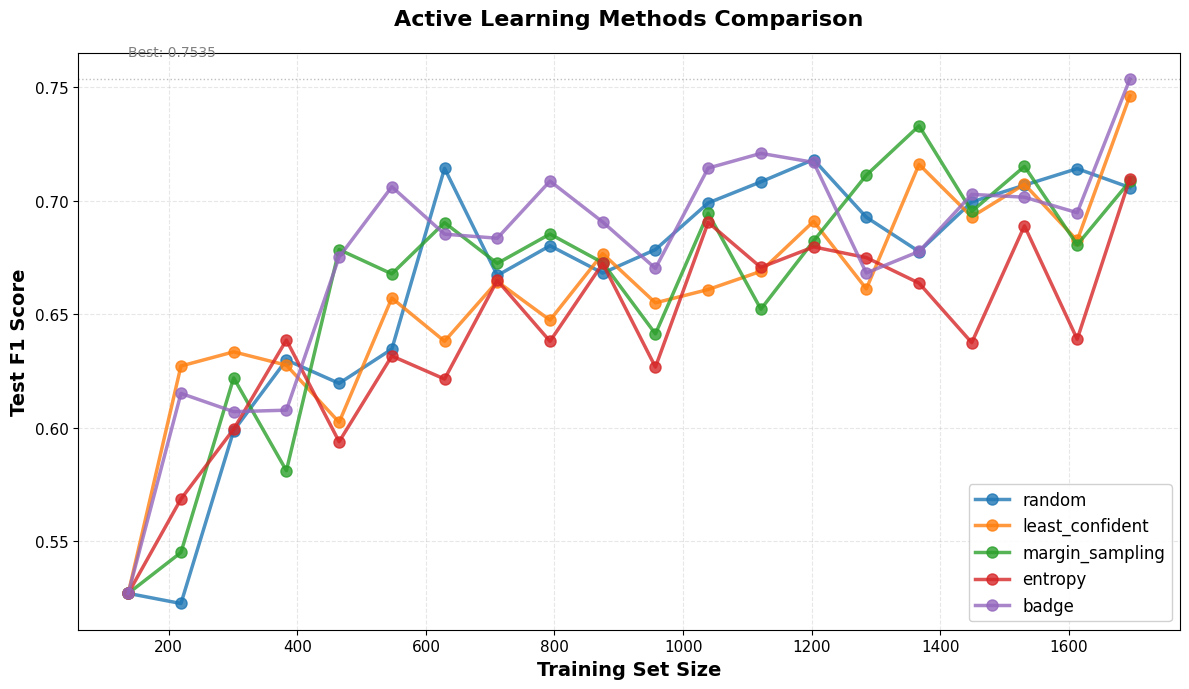


Final Performance (Last Iteration):
         method  train_size  test_f1  test_acc
          badge        1695 0.753496  0.753623
least_confident        1695 0.746111  0.746377
        entropy        1695 0.709670  0.710145
margin_sampling        1695 0.708528  0.710145
         random        1695 0.705711  0.706522


In [89]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each method
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('train_size')
    ax.plot(method_df['train_size'], method_df['test_f1'], 
            marker='o', linewidth=2.5, markersize=8, label=method, alpha=0.8)

# Styling
ax.set_xlabel('Training Set Size', fontsize=14, fontweight='bold')
ax.set_ylabel('Test F1 Score', fontsize=14, fontweight='bold')
ax.set_title('Active Learning Methods Comparison', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='lower right', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(labelsize=11)

# Add some context
ax.axhline(y=df_all['test_f1'].max(), color='gray', linestyle=':', alpha=0.5, linewidth=1)
ax.text(df_all['train_size'].min(), df_all['test_f1'].max() + 0.01, 
        f'Best: {df_all["test_f1"].max():.4f}', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFinal Performance (Last Iteration):")
final_results = df_all.groupby('method').tail(1)[['method', 'train_size', 'test_f1', 'test_acc']].sort_values('test_f1', ascending=False)
print(final_results.to_string(index=False))

Number of iterations per method:
method
badge              20
entropy            20
least_confident    20
margin_sampling    20
random             20
Name: iteration, dtype: int64


Performance progression:

random:
 iteration  train_size  train_ratio  test_f1  test_acc
         0         137         0.05 0.527085  0.528986
         1         219         0.08 0.522628  0.525362
         2         301         0.11 0.598690  0.605072
         3         383         0.14 0.629819  0.634058
         4         465         0.17 0.619523  0.626812
         5         547         0.20 0.634621  0.637681
         6         629         0.23 0.714164  0.713768
         7         711         0.26 0.667017  0.666667
         8         793         0.29 0.680109  0.681159
         9         875         0.32 0.668071  0.670290
        10         957         0.35 0.678416  0.677536
        11        1039         0.38 0.698946  0.699275
        12        1121         0.41 0.708229  0.706522
        13    

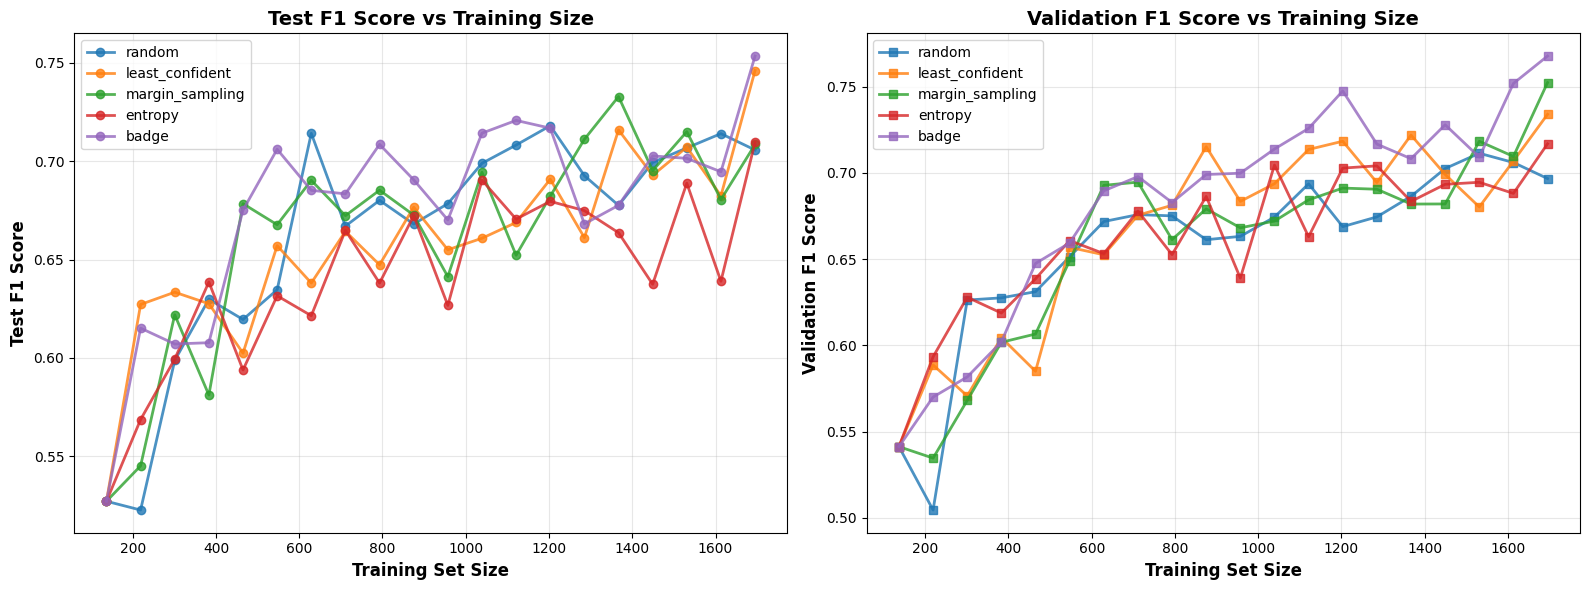



Method ranking by iteration (based on test_f1):

Iteration 0 (train_size = 137):
         method  test_f1
         random 0.527085
least_confident 0.527085
margin_sampling 0.527085
        entropy 0.527085
          badge 0.527085

Iteration 1 (train_size = 219):
         method  test_f1
least_confident 0.627165
          badge 0.615119
        entropy 0.568625
margin_sampling 0.545086
         random 0.522628

Iteration 2 (train_size = 301):
         method  test_f1
least_confident 0.633394
margin_sampling 0.621933
          badge 0.607060
        entropy 0.599373
         random 0.598690

Iteration 3 (train_size = 383):
         method  test_f1
        entropy 0.638589
         random 0.629819
least_confident 0.627531
          badge 0.607720
margin_sampling 0.581109

Iteration 4 (train_size = 465):
         method  test_f1
margin_sampling 0.678412
          badge 0.675149
         random 0.619523
least_confident 0.602406
        entropy 0.593856

Iteration 5 (train_size = 547):
  

In [90]:
# Check the details
print("Number of iterations per method:")
print(df_all.groupby('method')['iteration'].max() + 1)

print("\n\nPerformance progression:")
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('iteration')
    print(f"\n{method}:")
    print(method_df[['iteration', 'train_size', 'train_ratio', 'test_f1', 'test_acc']].to_string(index=False))

# Plot with more detail - show val_f1 vs test_f1
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test F1
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('train_size')
    axes[0].plot(method_df['train_size'], method_df['test_f1'], 
                marker='o', linewidth=2, markersize=6, label=method, alpha=0.8)

axes[0].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Test F1 Score', fontsize=12, fontweight='bold')
axes[0].set_title('Test F1 Score vs Training Size', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Validation F1
for method in df_all['method'].unique():
    method_df = df_all[df_all['method'] == method].sort_values('train_size')
    axes[1].plot(method_df['train_size'], method_df['val_f1'], 
                marker='s', linewidth=2, markersize=6, label=method, alpha=0.8)

axes[1].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation F1 Score', fontsize=12, fontweight='bold')
axes[1].set_title('Validation F1 Score vs Training Size', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison at each iteration
print("\n\nMethod ranking by iteration (based on test_f1):")
for iter_num in sorted(df_all['iteration'].unique()):
    iter_df = df_all[df_all['iteration'] == iter_num][['method', 'test_f1']].sort_values('test_f1', ascending=False)
    print(f"\nIteration {iter_num} (train_size = {df_all[df_all['iteration']==iter_num]['train_size'].iloc[0]}):")
    print(iter_df.to_string(index=False))